# Toy Regression

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import math

import numpy as np
import matplotlib.pyplot as plt

## Cubic

20 data points simulated as follows:

- x sampled from $\mathcal{U}(-4,4)$
- y sampled from $\mathcal{N}(x^3,3^2)$

In [2]:
np.random.seed(42)
torch.manual_seed(42)

x, _ = torch.empty(20,1).uniform_(-4,4).sort(0)
y = torch.normal(x**3,3)
grid = np.linspace(-6,6,400).reshape(-1,1)
y_true = (grid ** 3).reshape(-1,1)

Text(0,0.5,'f(x)')

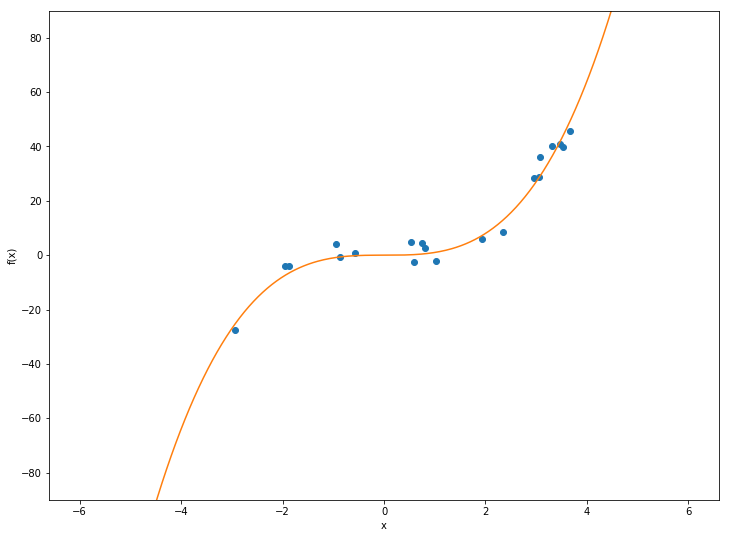

In [3]:
plt.figure(figsize=(12,9))
plt.plot(x.numpy(),y.numpy(),'o')
plt.plot(grid,y_true)
plt.ylim(-90,90)
plt.xlabel('x')
plt.ylabel('f(x)')

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(1, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 1, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

### SGLD

In [15]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld


np.random.seed(42)
torch.manual_seed(42)



lambda_ = 1.
#lr = 1e-6
# learning_rates = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
# learning_rates = [5e-5, 4e-5, 3e-5, 2e-5, 1e-5, 9e-6, 8e-6, 7e-6, 6e-6, 5e-6]
learning_rates = [6e-5]
# learning_rates = [1e-4]
# learning_rates = [9e-7]



batch_size = 20
dataset_size = 20

rmse_result = np.zeros((1,len(learning_rates)))

x_test = torch.FloatTensor(grid)
y_test = torch.FloatTensor(y_true)


for i, lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)
    predictions = torch.zeros(400,1)
    t = 1.

    for epoch in range(10000):
        running_loss = 0
        network.zero_grad()
        output = network(x)
        loss = (1/(2*9)) * criterion(output, y)
        loss.backward()
        optim.step()

        running_loss += loss * batch_size / dataset_size


        if (t >= 100) & (t % 100 == 0):
            with torch.autograd.no_grad():
                output = network(x_test)
                predictions = torch.cat((predictions, output), 1)

        t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    rmse_result[:,i] = torch.sqrt(criterion(y_test, torch.mean(predictions,1).view(-1,1)))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 608.4219
Epoch 1 - loss: 603.2444
Epoch 2 - loss: 601.4789
Epoch 3 - loss: 595.1372
Epoch 4 - loss: 589.7263
Epoch 5 - loss: 582.1104
Epoch 6 - loss: 581.5832
Epoch 7 - loss: 575.6078
Epoch 8 - loss: 567.8087
Epoch 9 - loss: 564.5701
Epoch 10 - loss: 560.8596
Epoch 11 - loss: 557.3531
Epoch 12 - loss: 554.2645
Epoch 13 - loss: 551.3122
Epoch 14 - loss: 545.0535
Epoch 15 - loss: 538.6858
Epoch 16 - loss: 534.4969
Epoch 17 - loss: 525.6320
Epoch 18 - loss: 520.7508
Epoch 19 - loss: 519.0065
Epoch 20 - loss: 513.2059
Epoch 21 - loss: 507.1250
Epoch 22 - loss: 505.5129
Epoch 23 - loss: 501.4169
Epoch 24 - loss: 496.1476
Epoch 25 - loss: 496.9992
Epoch 26 - loss: 493.2148
Epoch 27 - loss: 489.7957
Epoch 28 - loss: 486.0431
Epoch 29 - loss: 477.3506
Epoch 30 - loss: 469.2980
Epoch 31 - loss: 465.6153
Epoch 32 - loss: 462.0141
Epoch 33 - loss: 459.7785
Epoch 34 - loss: 454.0796
Epoch 35 - loss: 446.8868
Epoch 36 - loss: 434.7066
Epoch 37 - loss: 430.4473
Epoch 38 - loss: 421.6

Epoch 345 - loss: 73.8122
Epoch 346 - loss: 73.3068
Epoch 347 - loss: 73.2407
Epoch 348 - loss: 73.1514
Epoch 349 - loss: 73.0117
Epoch 350 - loss: 72.8389
Epoch 351 - loss: 72.3333
Epoch 352 - loss: 72.2814
Epoch 353 - loss: 71.7251
Epoch 354 - loss: 71.6635
Epoch 355 - loss: 71.8011
Epoch 356 - loss: 71.9004
Epoch 357 - loss: 71.7321
Epoch 358 - loss: 71.4711
Epoch 359 - loss: 71.2530
Epoch 360 - loss: 70.9128
Epoch 361 - loss: 70.6192
Epoch 362 - loss: 70.9210
Epoch 363 - loss: 70.7288
Epoch 364 - loss: 70.1657
Epoch 365 - loss: 69.9814
Epoch 366 - loss: 69.9536
Epoch 367 - loss: 69.9909
Epoch 368 - loss: 70.7730
Epoch 369 - loss: 71.0059
Epoch 370 - loss: 70.7257
Epoch 371 - loss: 70.4537
Epoch 372 - loss: 71.0324
Epoch 373 - loss: 70.6002
Epoch 374 - loss: 71.2201
Epoch 375 - loss: 70.8975
Epoch 376 - loss: 70.3563
Epoch 377 - loss: 70.9254
Epoch 378 - loss: 71.0099
Epoch 379 - loss: 70.5826
Epoch 380 - loss: 70.6376
Epoch 381 - loss: 70.9031
Epoch 382 - loss: 71.9512
Epoch 383 - 

Epoch 721 - loss: 51.4564
Epoch 722 - loss: 51.0523
Epoch 723 - loss: 51.1481
Epoch 724 - loss: 51.3800
Epoch 725 - loss: 51.2105
Epoch 726 - loss: 51.5074
Epoch 727 - loss: 51.1135
Epoch 728 - loss: 50.3747
Epoch 729 - loss: 50.6965
Epoch 730 - loss: 50.7048
Epoch 731 - loss: 51.2034
Epoch 732 - loss: 51.3893
Epoch 733 - loss: 50.9369
Epoch 734 - loss: 51.4910
Epoch 735 - loss: 50.3934
Epoch 736 - loss: 50.4493
Epoch 737 - loss: 49.3128
Epoch 738 - loss: 49.3336
Epoch 739 - loss: 49.3873
Epoch 740 - loss: 48.8661
Epoch 741 - loss: 49.7375
Epoch 742 - loss: 49.2355
Epoch 743 - loss: 49.2524
Epoch 744 - loss: 49.6356
Epoch 745 - loss: 49.4790
Epoch 746 - loss: 48.8814
Epoch 747 - loss: 48.9771
Epoch 748 - loss: 48.8618
Epoch 749 - loss: 49.8797
Epoch 750 - loss: 50.0172
Epoch 751 - loss: 49.6613
Epoch 752 - loss: 48.9757
Epoch 753 - loss: 48.9904
Epoch 754 - loss: 49.3014
Epoch 755 - loss: 49.6200
Epoch 756 - loss: 49.2823
Epoch 757 - loss: 49.0798
Epoch 758 - loss: 49.0750
Epoch 759 - 

Epoch 1105 - loss: 25.1808
Epoch 1106 - loss: 22.7143
Epoch 1107 - loss: 22.9696
Epoch 1108 - loss: 22.4433
Epoch 1109 - loss: 23.0989
Epoch 1110 - loss: 23.7929
Epoch 1111 - loss: 23.5385
Epoch 1112 - loss: 23.4251
Epoch 1113 - loss: 22.8069
Epoch 1114 - loss: 23.6942
Epoch 1115 - loss: 23.4331
Epoch 1116 - loss: 23.6001
Epoch 1117 - loss: 23.0357
Epoch 1118 - loss: 22.4990
Epoch 1119 - loss: 23.1099
Epoch 1120 - loss: 23.0660
Epoch 1121 - loss: 22.1307
Epoch 1122 - loss: 21.7641
Epoch 1123 - loss: 22.4695
Epoch 1124 - loss: 22.0553
Epoch 1125 - loss: 20.8392
Epoch 1126 - loss: 20.9176
Epoch 1127 - loss: 21.2605
Epoch 1128 - loss: 20.8682
Epoch 1129 - loss: 21.0650
Epoch 1130 - loss: 20.4123
Epoch 1131 - loss: 20.1137
Epoch 1132 - loss: 20.0515
Epoch 1133 - loss: 21.7514
Epoch 1134 - loss: 20.0475
Epoch 1135 - loss: 20.3235
Epoch 1136 - loss: 20.4742
Epoch 1137 - loss: 20.2271
Epoch 1138 - loss: 20.9659
Epoch 1139 - loss: 21.9754
Epoch 1140 - loss: 18.5454
Epoch 1141 - loss: 18.2102
E

Epoch 1497 - loss: 16.1864
Epoch 1498 - loss: 16.0219
Epoch 1499 - loss: 16.1923
Epoch 1500 - loss: 18.7458
Epoch 1501 - loss: 16.3908
Epoch 1502 - loss: 15.9191
Epoch 1503 - loss: 17.4515
Epoch 1504 - loss: 17.0934
Epoch 1505 - loss: 15.5791
Epoch 1506 - loss: 15.5296
Epoch 1507 - loss: 15.1238
Epoch 1508 - loss: 18.7707
Epoch 1509 - loss: 15.3500
Epoch 1510 - loss: 15.5449
Epoch 1511 - loss: 14.6910
Epoch 1512 - loss: 14.6080
Epoch 1513 - loss: 15.7970
Epoch 1514 - loss: 15.0588
Epoch 1515 - loss: 17.9443
Epoch 1516 - loss: 15.9815
Epoch 1517 - loss: 14.5099
Epoch 1518 - loss: 14.4054
Epoch 1519 - loss: 16.6626
Epoch 1520 - loss: 14.9634
Epoch 1521 - loss: 14.4823
Epoch 1522 - loss: 13.9926
Epoch 1523 - loss: 13.9152
Epoch 1524 - loss: 13.7867
Epoch 1525 - loss: 14.2676
Epoch 1526 - loss: 14.8249
Epoch 1527 - loss: 14.3208
Epoch 1528 - loss: 16.4201
Epoch 1529 - loss: 15.1655
Epoch 1530 - loss: 15.7192
Epoch 1531 - loss: 14.8738
Epoch 1532 - loss: 14.5356
Epoch 1533 - loss: 14.5416
E

Epoch 1814 - loss: 12.8564
Epoch 1815 - loss: 13.1935
Epoch 1816 - loss: 15.1058
Epoch 1817 - loss: 12.8761
Epoch 1818 - loss: 13.0872
Epoch 1819 - loss: 13.2192
Epoch 1820 - loss: 13.0552
Epoch 1821 - loss: 13.0758
Epoch 1822 - loss: 15.4431
Epoch 1823 - loss: 14.6143
Epoch 1824 - loss: 13.3045
Epoch 1825 - loss: 14.0216
Epoch 1826 - loss: 14.1644
Epoch 1827 - loss: 13.6728
Epoch 1828 - loss: 13.0719
Epoch 1829 - loss: 13.2207
Epoch 1830 - loss: 14.3637
Epoch 1831 - loss: 14.2625
Epoch 1832 - loss: 12.9138
Epoch 1833 - loss: 13.0374
Epoch 1834 - loss: 12.5381
Epoch 1835 - loss: 12.9223
Epoch 1836 - loss: 13.7769
Epoch 1837 - loss: 12.2749
Epoch 1838 - loss: 12.4389
Epoch 1839 - loss: 12.2237
Epoch 1840 - loss: 13.4904
Epoch 1841 - loss: 12.5572
Epoch 1842 - loss: 12.2890
Epoch 1843 - loss: 12.7336
Epoch 1844 - loss: 12.9576
Epoch 1845 - loss: 12.0559
Epoch 1846 - loss: 11.8654
Epoch 1847 - loss: 12.5363
Epoch 1848 - loss: 11.8697
Epoch 1849 - loss: 12.5074
Epoch 1850 - loss: 11.8560
E

Epoch 2137 - loss: 12.2490
Epoch 2138 - loss: 13.2386
Epoch 2139 - loss: 14.0003
Epoch 2140 - loss: 13.2802
Epoch 2141 - loss: 14.0685
Epoch 2142 - loss: 14.3863
Epoch 2143 - loss: 14.4533
Epoch 2144 - loss: 14.6993
Epoch 2145 - loss: 16.0111
Epoch 2146 - loss: 14.7779
Epoch 2147 - loss: 14.8975
Epoch 2148 - loss: 16.0724
Epoch 2149 - loss: 14.3846
Epoch 2150 - loss: 14.4197
Epoch 2151 - loss: 15.2144
Epoch 2152 - loss: 15.3867
Epoch 2153 - loss: 15.3827
Epoch 2154 - loss: 16.7671
Epoch 2155 - loss: 15.3672
Epoch 2156 - loss: 15.6885
Epoch 2157 - loss: 15.8976
Epoch 2158 - loss: 18.2719
Epoch 2159 - loss: 17.0742
Epoch 2160 - loss: 17.9237
Epoch 2161 - loss: 17.8692
Epoch 2162 - loss: 15.1065
Epoch 2163 - loss: 14.8350
Epoch 2164 - loss: 14.2772
Epoch 2165 - loss: 14.8795
Epoch 2166 - loss: 15.4231
Epoch 2167 - loss: 18.6686
Epoch 2168 - loss: 15.2526
Epoch 2169 - loss: 15.8785
Epoch 2170 - loss: 13.8198
Epoch 2171 - loss: 18.5719
Epoch 2172 - loss: 14.6677
Epoch 2173 - loss: 13.1907
E

Epoch 2444 - loss: 18.1213
Epoch 2445 - loss: 12.7569
Epoch 2446 - loss: 13.0124
Epoch 2447 - loss: 12.4964
Epoch 2448 - loss: 14.0836
Epoch 2449 - loss: 13.1244
Epoch 2450 - loss: 12.7723
Epoch 2451 - loss: 12.7487
Epoch 2452 - loss: 12.7955
Epoch 2453 - loss: 12.7947
Epoch 2454 - loss: 13.3833
Epoch 2455 - loss: 13.9455
Epoch 2456 - loss: 13.6165
Epoch 2457 - loss: 13.9301
Epoch 2458 - loss: 13.9448
Epoch 2459 - loss: 12.9143
Epoch 2460 - loss: 12.2252
Epoch 2461 - loss: 12.1212
Epoch 2462 - loss: 12.0413
Epoch 2463 - loss: 11.3753
Epoch 2464 - loss: 11.6970
Epoch 2465 - loss: 12.3962
Epoch 2466 - loss: 11.4845
Epoch 2467 - loss: 11.5270
Epoch 2468 - loss: 11.1955
Epoch 2469 - loss: 10.9706
Epoch 2470 - loss: 10.8571
Epoch 2471 - loss: 12.8380
Epoch 2472 - loss: 13.8373
Epoch 2473 - loss: 13.7916
Epoch 2474 - loss: 11.9222
Epoch 2475 - loss: 11.7523
Epoch 2476 - loss: 13.2174
Epoch 2477 - loss: 15.9275
Epoch 2478 - loss: 14.5361
Epoch 2479 - loss: 13.6421
Epoch 2480 - loss: 12.9982
E

Epoch 2805 - loss: 9.9024
Epoch 2806 - loss: 15.7012
Epoch 2807 - loss: 9.8461
Epoch 2808 - loss: 9.3380
Epoch 2809 - loss: 10.1772
Epoch 2810 - loss: 9.3101
Epoch 2811 - loss: 10.5538
Epoch 2812 - loss: 10.9026
Epoch 2813 - loss: 12.4510
Epoch 2814 - loss: 11.0799
Epoch 2815 - loss: 11.2335
Epoch 2816 - loss: 10.0110
Epoch 2817 - loss: 10.2938
Epoch 2818 - loss: 11.5381
Epoch 2819 - loss: 11.2268
Epoch 2820 - loss: 13.6043
Epoch 2821 - loss: 8.5523
Epoch 2822 - loss: 8.9597
Epoch 2823 - loss: 8.2572
Epoch 2824 - loss: 9.3055
Epoch 2825 - loss: 8.6014
Epoch 2826 - loss: 9.0971
Epoch 2827 - loss: 9.3307
Epoch 2828 - loss: 9.2376
Epoch 2829 - loss: 8.7289
Epoch 2830 - loss: 10.0769
Epoch 2831 - loss: 10.3266
Epoch 2832 - loss: 10.4958
Epoch 2833 - loss: 12.6281
Epoch 2834 - loss: 12.0759
Epoch 2835 - loss: 15.8689
Epoch 2836 - loss: 21.1246
Epoch 2837 - loss: 12.0064
Epoch 2838 - loss: 9.1208
Epoch 2839 - loss: 10.0688
Epoch 2840 - loss: 9.7881
Epoch 2841 - loss: 9.3944
Epoch 2842 - loss

Epoch 3145 - loss: 19.1703
Epoch 3146 - loss: 18.0755
Epoch 3147 - loss: 12.4579
Epoch 3148 - loss: 17.9315
Epoch 3149 - loss: 15.5498
Epoch 3150 - loss: 9.3714
Epoch 3151 - loss: 12.6425
Epoch 3152 - loss: 14.1490
Epoch 3153 - loss: 13.1757
Epoch 3154 - loss: 9.6705
Epoch 3155 - loss: 10.3641
Epoch 3156 - loss: 12.5048
Epoch 3157 - loss: 11.3552
Epoch 3158 - loss: 11.2660
Epoch 3159 - loss: 13.2422
Epoch 3160 - loss: 10.5954
Epoch 3161 - loss: 10.5162
Epoch 3162 - loss: 13.2865
Epoch 3163 - loss: 9.9505
Epoch 3164 - loss: 9.1601
Epoch 3165 - loss: 10.0697
Epoch 3166 - loss: 10.8591
Epoch 3167 - loss: 9.3658
Epoch 3168 - loss: 10.3605
Epoch 3169 - loss: 9.3188
Epoch 3170 - loss: 8.2388
Epoch 3171 - loss: 9.3614
Epoch 3172 - loss: 11.6464
Epoch 3173 - loss: 22.7347
Epoch 3174 - loss: 20.2296
Epoch 3175 - loss: 12.6316
Epoch 3176 - loss: 15.2116
Epoch 3177 - loss: 11.3581
Epoch 3178 - loss: 10.6809
Epoch 3179 - loss: 11.7663
Epoch 3180 - loss: 14.9398
Epoch 3181 - loss: 11.7295
Epoch 318

Epoch 3462 - loss: 9.6881
Epoch 3463 - loss: 8.1788
Epoch 3464 - loss: 6.9337
Epoch 3465 - loss: 8.3488
Epoch 3466 - loss: 11.9190
Epoch 3467 - loss: 8.4073
Epoch 3468 - loss: 9.0595
Epoch 3469 - loss: 8.8652
Epoch 3470 - loss: 7.6610
Epoch 3471 - loss: 9.4570
Epoch 3472 - loss: 7.8530
Epoch 3473 - loss: 7.5637
Epoch 3474 - loss: 7.1697
Epoch 3475 - loss: 6.7976
Epoch 3476 - loss: 7.0690
Epoch 3477 - loss: 7.3810
Epoch 3478 - loss: 7.4283
Epoch 3479 - loss: 10.8320
Epoch 3480 - loss: 10.7982
Epoch 3481 - loss: 12.9512
Epoch 3482 - loss: 10.2278
Epoch 3483 - loss: 14.1877
Epoch 3484 - loss: 9.8500
Epoch 3485 - loss: 9.6214
Epoch 3486 - loss: 10.2485
Epoch 3487 - loss: 9.3492
Epoch 3488 - loss: 12.4167
Epoch 3489 - loss: 12.0856
Epoch 3490 - loss: 9.5013
Epoch 3491 - loss: 9.4485
Epoch 3492 - loss: 8.8105
Epoch 3493 - loss: 7.6827
Epoch 3494 - loss: 9.7224
Epoch 3495 - loss: 11.4910
Epoch 3496 - loss: 9.2796
Epoch 3497 - loss: 7.8537
Epoch 3498 - loss: 8.5513
Epoch 3499 - loss: 10.4417
E

Epoch 3847 - loss: 12.8147
Epoch 3848 - loss: 11.8692
Epoch 3849 - loss: 10.6655
Epoch 3850 - loss: 11.5550
Epoch 3851 - loss: 13.3739
Epoch 3852 - loss: 11.8356
Epoch 3853 - loss: 12.0981
Epoch 3854 - loss: 11.5651
Epoch 3855 - loss: 11.0152
Epoch 3856 - loss: 14.4157
Epoch 3857 - loss: 16.8813
Epoch 3858 - loss: 18.4325
Epoch 3859 - loss: 13.3012
Epoch 3860 - loss: 9.8826
Epoch 3861 - loss: 10.9545
Epoch 3862 - loss: 10.9384
Epoch 3863 - loss: 11.6561
Epoch 3864 - loss: 11.8000
Epoch 3865 - loss: 11.0069
Epoch 3866 - loss: 12.8692
Epoch 3867 - loss: 11.8710
Epoch 3868 - loss: 10.9453
Epoch 3869 - loss: 9.9912
Epoch 3870 - loss: 10.1969
Epoch 3871 - loss: 10.3368
Epoch 3872 - loss: 10.1136
Epoch 3873 - loss: 10.4818
Epoch 3874 - loss: 10.6752
Epoch 3875 - loss: 11.0169
Epoch 3876 - loss: 12.9405
Epoch 3877 - loss: 10.2224
Epoch 3878 - loss: 10.3875
Epoch 3879 - loss: 10.7048
Epoch 3880 - loss: 12.9807
Epoch 3881 - loss: 10.8866
Epoch 3882 - loss: 11.1360
Epoch 3883 - loss: 14.9854
Epo

Epoch 4224 - loss: 20.3052
Epoch 4225 - loss: 30.3126
Epoch 4226 - loss: 28.8890
Epoch 4227 - loss: 31.8856
Epoch 4228 - loss: 14.0436
Epoch 4229 - loss: 13.9643
Epoch 4230 - loss: 15.9600
Epoch 4231 - loss: 10.7466
Epoch 4232 - loss: 6.9877
Epoch 4233 - loss: 6.8704
Epoch 4234 - loss: 6.9165
Epoch 4235 - loss: 8.0033
Epoch 4236 - loss: 14.9459
Epoch 4237 - loss: 21.2666
Epoch 4238 - loss: 16.7003
Epoch 4239 - loss: 18.5084
Epoch 4240 - loss: 19.9346
Epoch 4241 - loss: 14.3454
Epoch 4242 - loss: 19.8430
Epoch 4243 - loss: 18.4275
Epoch 4244 - loss: 32.6707
Epoch 4245 - loss: 27.4387
Epoch 4246 - loss: 14.2588
Epoch 4247 - loss: 29.2771
Epoch 4248 - loss: 26.2435
Epoch 4249 - loss: 22.6532
Epoch 4250 - loss: 20.3558
Epoch 4251 - loss: 14.0619
Epoch 4252 - loss: 10.3560
Epoch 4253 - loss: 10.5147
Epoch 4254 - loss: 10.3420
Epoch 4255 - loss: 13.4632
Epoch 4256 - loss: 11.1912
Epoch 4257 - loss: 10.4255
Epoch 4258 - loss: 8.0482
Epoch 4259 - loss: 7.4836
Epoch 4260 - loss: 6.8963
Epoch 42

Epoch 4603 - loss: 14.6084
Epoch 4604 - loss: 10.5574
Epoch 4605 - loss: 12.8013
Epoch 4606 - loss: 7.5339
Epoch 4607 - loss: 12.1800
Epoch 4608 - loss: 11.9991
Epoch 4609 - loss: 16.9848
Epoch 4610 - loss: 14.8040
Epoch 4611 - loss: 13.5612
Epoch 4612 - loss: 15.4195
Epoch 4613 - loss: 11.5132
Epoch 4614 - loss: 19.1139
Epoch 4615 - loss: 14.5444
Epoch 4616 - loss: 10.9827
Epoch 4617 - loss: 12.0386
Epoch 4618 - loss: 10.3241
Epoch 4619 - loss: 11.2406
Epoch 4620 - loss: 10.7315
Epoch 4621 - loss: 9.8117
Epoch 4622 - loss: 11.3649
Epoch 4623 - loss: 12.8033
Epoch 4624 - loss: 14.9558
Epoch 4625 - loss: 16.5956
Epoch 4626 - loss: 17.6304
Epoch 4627 - loss: 9.8414
Epoch 4628 - loss: 11.5679
Epoch 4629 - loss: 7.6794
Epoch 4630 - loss: 7.4945
Epoch 4631 - loss: 8.6707
Epoch 4632 - loss: 7.2426
Epoch 4633 - loss: 7.7213
Epoch 4634 - loss: 7.4459
Epoch 4635 - loss: 14.5721
Epoch 4636 - loss: 22.3076
Epoch 4637 - loss: 11.5365
Epoch 4638 - loss: 6.6721
Epoch 4639 - loss: 6.5186
Epoch 4640 -

Epoch 4923 - loss: 8.7463
Epoch 4924 - loss: 7.9179
Epoch 4925 - loss: 7.3798
Epoch 4926 - loss: 9.0417
Epoch 4927 - loss: 7.2726
Epoch 4928 - loss: 7.8744
Epoch 4929 - loss: 10.5214
Epoch 4930 - loss: 13.2042
Epoch 4931 - loss: 8.2560
Epoch 4932 - loss: 18.3811
Epoch 4933 - loss: 16.8764
Epoch 4934 - loss: 11.9393
Epoch 4935 - loss: 9.3465
Epoch 4936 - loss: 8.5660
Epoch 4937 - loss: 9.2846
Epoch 4938 - loss: 15.3549
Epoch 4939 - loss: 25.0137
Epoch 4940 - loss: 26.8715
Epoch 4941 - loss: 15.6069
Epoch 4942 - loss: 8.2743
Epoch 4943 - loss: 8.2220
Epoch 4944 - loss: 7.3779
Epoch 4945 - loss: 9.2884
Epoch 4946 - loss: 9.2586
Epoch 4947 - loss: 16.0710
Epoch 4948 - loss: 11.3696
Epoch 4949 - loss: 8.5126
Epoch 4950 - loss: 7.9727
Epoch 4951 - loss: 8.3907
Epoch 4952 - loss: 9.4247
Epoch 4953 - loss: 10.3936
Epoch 4954 - loss: 8.8515
Epoch 4955 - loss: 9.8304
Epoch 4956 - loss: 8.9419
Epoch 4957 - loss: 9.6869
Epoch 4958 - loss: 10.0699
Epoch 4959 - loss: 21.4941
Epoch 4960 - loss: 20.42

Epoch 5255 - loss: 8.4953
Epoch 5256 - loss: 8.0482
Epoch 5257 - loss: 8.0576
Epoch 5258 - loss: 8.2544
Epoch 5259 - loss: 7.4713
Epoch 5260 - loss: 9.8309
Epoch 5261 - loss: 8.4223
Epoch 5262 - loss: 14.8081
Epoch 5263 - loss: 17.9412
Epoch 5264 - loss: 18.5099
Epoch 5265 - loss: 22.7758
Epoch 5266 - loss: 20.1036
Epoch 5267 - loss: 21.7048
Epoch 5268 - loss: 18.4304
Epoch 5269 - loss: 23.5784
Epoch 5270 - loss: 15.5733
Epoch 5271 - loss: 9.8356
Epoch 5272 - loss: 13.5231
Epoch 5273 - loss: 10.3372
Epoch 5274 - loss: 7.3587
Epoch 5275 - loss: 11.7506
Epoch 5276 - loss: 12.4222
Epoch 5277 - loss: 9.5502
Epoch 5278 - loss: 9.3195
Epoch 5279 - loss: 8.2112
Epoch 5280 - loss: 8.2732
Epoch 5281 - loss: 7.2454
Epoch 5282 - loss: 7.6710
Epoch 5283 - loss: 9.1708
Epoch 5284 - loss: 7.3101
Epoch 5285 - loss: 6.8897
Epoch 5286 - loss: 7.2855
Epoch 5287 - loss: 6.9900
Epoch 5288 - loss: 7.3316
Epoch 5289 - loss: 7.9365
Epoch 5290 - loss: 9.1580
Epoch 5291 - loss: 8.9936
Epoch 5292 - loss: 7.0454

Epoch 5648 - loss: 6.8991
Epoch 5649 - loss: 12.5258
Epoch 5650 - loss: 11.9374
Epoch 5651 - loss: 7.7758
Epoch 5652 - loss: 10.1407
Epoch 5653 - loss: 8.7173
Epoch 5654 - loss: 8.3902
Epoch 5655 - loss: 7.6666
Epoch 5656 - loss: 8.0653
Epoch 5657 - loss: 10.3568
Epoch 5658 - loss: 7.9455
Epoch 5659 - loss: 9.2375
Epoch 5660 - loss: 17.2269
Epoch 5661 - loss: 10.8864
Epoch 5662 - loss: 15.4859
Epoch 5663 - loss: 11.9639
Epoch 5664 - loss: 9.6163
Epoch 5665 - loss: 8.3434
Epoch 5666 - loss: 7.8658
Epoch 5667 - loss: 7.9431
Epoch 5668 - loss: 11.3889
Epoch 5669 - loss: 8.4574
Epoch 5670 - loss: 7.4020
Epoch 5671 - loss: 9.4602
Epoch 5672 - loss: 9.4520
Epoch 5673 - loss: 10.0625
Epoch 5674 - loss: 9.7164
Epoch 5675 - loss: 9.1261
Epoch 5676 - loss: 9.4445
Epoch 5677 - loss: 8.0967
Epoch 5678 - loss: 9.0446
Epoch 5679 - loss: 8.9596
Epoch 5680 - loss: 9.1890
Epoch 5681 - loss: 9.5131
Epoch 5682 - loss: 13.8989
Epoch 5683 - loss: 13.1169
Epoch 5684 - loss: 8.5471
Epoch 5685 - loss: 9.3519


Epoch 6025 - loss: 9.2611
Epoch 6026 - loss: 9.6484
Epoch 6027 - loss: 10.3560
Epoch 6028 - loss: 9.1514
Epoch 6029 - loss: 8.3205
Epoch 6030 - loss: 9.1587
Epoch 6031 - loss: 7.5965
Epoch 6032 - loss: 9.5807
Epoch 6033 - loss: 9.1703
Epoch 6034 - loss: 10.1924
Epoch 6035 - loss: 10.8906
Epoch 6036 - loss: 8.9280
Epoch 6037 - loss: 7.0801
Epoch 6038 - loss: 6.9647
Epoch 6039 - loss: 7.5165
Epoch 6040 - loss: 7.0881
Epoch 6041 - loss: 7.4492
Epoch 6042 - loss: 9.9309
Epoch 6043 - loss: 6.9522
Epoch 6044 - loss: 6.9065
Epoch 6045 - loss: 6.8078
Epoch 6046 - loss: 7.0320
Epoch 6047 - loss: 6.9008
Epoch 6048 - loss: 7.4832
Epoch 6049 - loss: 7.8322
Epoch 6050 - loss: 7.6594
Epoch 6051 - loss: 7.6578
Epoch 6052 - loss: 7.1896
Epoch 6053 - loss: 7.1167
Epoch 6054 - loss: 7.8666
Epoch 6055 - loss: 10.1568
Epoch 6056 - loss: 8.2180
Epoch 6057 - loss: 7.0479
Epoch 6058 - loss: 7.5335
Epoch 6059 - loss: 7.1919
Epoch 6060 - loss: 6.7836
Epoch 6061 - loss: 7.0452
Epoch 6062 - loss: 7.1461
Epoch 60

Epoch 6402 - loss: 9.5863
Epoch 6403 - loss: 8.2139
Epoch 6404 - loss: 9.5474
Epoch 6405 - loss: 9.3814
Epoch 6406 - loss: 9.2392
Epoch 6407 - loss: 8.0597
Epoch 6408 - loss: 9.0340
Epoch 6409 - loss: 8.3325
Epoch 6410 - loss: 7.5707
Epoch 6411 - loss: 7.7816
Epoch 6412 - loss: 8.2925
Epoch 6413 - loss: 7.0108
Epoch 6414 - loss: 7.2811
Epoch 6415 - loss: 7.4084
Epoch 6416 - loss: 7.6160
Epoch 6417 - loss: 8.9639
Epoch 6418 - loss: 7.2977
Epoch 6419 - loss: 5.8201
Epoch 6420 - loss: 6.1333
Epoch 6421 - loss: 6.7028
Epoch 6422 - loss: 10.2683
Epoch 6423 - loss: 11.8860
Epoch 6424 - loss: 7.4901
Epoch 6425 - loss: 8.1422
Epoch 6426 - loss: 8.4219
Epoch 6427 - loss: 8.9356
Epoch 6428 - loss: 7.7684
Epoch 6429 - loss: 8.7202
Epoch 6430 - loss: 9.0048
Epoch 6431 - loss: 8.1505
Epoch 6432 - loss: 7.4852
Epoch 6433 - loss: 7.7966
Epoch 6434 - loss: 7.1770
Epoch 6435 - loss: 6.9655
Epoch 6436 - loss: 7.4325
Epoch 6437 - loss: 8.1565
Epoch 6438 - loss: 8.4777
Epoch 6439 - loss: 7.8126
Epoch 6440

Epoch 6727 - loss: 6.9759
Epoch 6728 - loss: 6.6921
Epoch 6729 - loss: 8.5040
Epoch 6730 - loss: 7.5644
Epoch 6731 - loss: 8.3096
Epoch 6732 - loss: 11.0321
Epoch 6733 - loss: 10.6567
Epoch 6734 - loss: 7.2297
Epoch 6735 - loss: 7.6719
Epoch 6736 - loss: 7.6749
Epoch 6737 - loss: 8.1199
Epoch 6738 - loss: 9.4406
Epoch 6739 - loss: 8.2638
Epoch 6740 - loss: 9.6578
Epoch 6741 - loss: 7.6020
Epoch 6742 - loss: 7.6622
Epoch 6743 - loss: 8.9535
Epoch 6744 - loss: 7.6939
Epoch 6745 - loss: 8.9114
Epoch 6746 - loss: 7.4546
Epoch 6747 - loss: 6.5433
Epoch 6748 - loss: 6.8033
Epoch 6749 - loss: 7.1611
Epoch 6750 - loss: 6.8807
Epoch 6751 - loss: 6.5593
Epoch 6752 - loss: 6.6170
Epoch 6753 - loss: 7.1292
Epoch 6754 - loss: 10.8618
Epoch 6755 - loss: 6.8241
Epoch 6756 - loss: 6.6711
Epoch 6757 - loss: 9.0409
Epoch 6758 - loss: 6.4980
Epoch 6759 - loss: 6.4433
Epoch 6760 - loss: 6.1268
Epoch 6761 - loss: 6.2339
Epoch 6762 - loss: 7.2824
Epoch 6763 - loss: 5.8214
Epoch 6764 - loss: 7.2439
Epoch 676

Epoch 7052 - loss: 7.9390
Epoch 7053 - loss: 8.4067
Epoch 7054 - loss: 12.9625
Epoch 7055 - loss: 10.3502
Epoch 7056 - loss: 7.9501
Epoch 7057 - loss: 8.6440
Epoch 7058 - loss: 10.6802
Epoch 7059 - loss: 8.2139
Epoch 7060 - loss: 12.4830
Epoch 7061 - loss: 12.4419
Epoch 7062 - loss: 10.2817
Epoch 7063 - loss: 7.4388
Epoch 7064 - loss: 7.8966
Epoch 7065 - loss: 7.8856
Epoch 7066 - loss: 7.7337
Epoch 7067 - loss: 8.2187
Epoch 7068 - loss: 9.5934
Epoch 7069 - loss: 8.2941
Epoch 7070 - loss: 9.0145
Epoch 7071 - loss: 8.1767
Epoch 7072 - loss: 10.0639
Epoch 7073 - loss: 10.5865
Epoch 7074 - loss: 9.3409
Epoch 7075 - loss: 9.2914
Epoch 7076 - loss: 8.8468
Epoch 7077 - loss: 9.7160
Epoch 7078 - loss: 9.1113
Epoch 7079 - loss: 12.6682
Epoch 7080 - loss: 13.2008
Epoch 7081 - loss: 11.4300
Epoch 7082 - loss: 11.3873
Epoch 7083 - loss: 9.5369
Epoch 7084 - loss: 9.1851
Epoch 7085 - loss: 8.7333
Epoch 7086 - loss: 8.3969
Epoch 7087 - loss: 11.0243
Epoch 7088 - loss: 8.5355
Epoch 7089 - loss: 7.6547

Epoch 7375 - loss: 7.4414
Epoch 7376 - loss: 8.9802
Epoch 7377 - loss: 6.8941
Epoch 7378 - loss: 7.8110
Epoch 7379 - loss: 9.1954
Epoch 7380 - loss: 8.8227
Epoch 7381 - loss: 7.2141
Epoch 7382 - loss: 6.5271
Epoch 7383 - loss: 6.9289
Epoch 7384 - loss: 7.9980
Epoch 7385 - loss: 7.4825
Epoch 7386 - loss: 8.4750
Epoch 7387 - loss: 10.3348
Epoch 7388 - loss: 11.5804
Epoch 7389 - loss: 10.0906
Epoch 7390 - loss: 9.8916
Epoch 7391 - loss: 7.4749
Epoch 7392 - loss: 8.0253
Epoch 7393 - loss: 9.3612
Epoch 7394 - loss: 8.9967
Epoch 7395 - loss: 7.9699
Epoch 7396 - loss: 8.8584
Epoch 7397 - loss: 9.3275
Epoch 7398 - loss: 8.4558
Epoch 7399 - loss: 8.4105
Epoch 7400 - loss: 7.5960
Epoch 7401 - loss: 9.2437
Epoch 7402 - loss: 7.0385
Epoch 7403 - loss: 7.4352
Epoch 7404 - loss: 6.7138
Epoch 7405 - loss: 7.4059
Epoch 7406 - loss: 7.7060
Epoch 7407 - loss: 7.2778
Epoch 7408 - loss: 9.7380
Epoch 7409 - loss: 8.6579
Epoch 7410 - loss: 6.9482
Epoch 7411 - loss: 6.7205
Epoch 7412 - loss: 7.6959
Epoch 741

Epoch 7762 - loss: 8.2993
Epoch 7763 - loss: 10.3941
Epoch 7764 - loss: 8.5048
Epoch 7765 - loss: 7.7894
Epoch 7766 - loss: 6.9279
Epoch 7767 - loss: 8.2957
Epoch 7768 - loss: 6.5959
Epoch 7769 - loss: 6.3593
Epoch 7770 - loss: 10.5727
Epoch 7771 - loss: 9.2402
Epoch 7772 - loss: 7.4857
Epoch 7773 - loss: 6.2403
Epoch 7774 - loss: 6.6786
Epoch 7775 - loss: 7.8739
Epoch 7776 - loss: 6.8056
Epoch 7777 - loss: 6.7864
Epoch 7778 - loss: 9.0443
Epoch 7779 - loss: 7.3359
Epoch 7780 - loss: 6.7229
Epoch 7781 - loss: 6.0286
Epoch 7782 - loss: 6.4923
Epoch 7783 - loss: 7.6183
Epoch 7784 - loss: 6.9641
Epoch 7785 - loss: 8.6424
Epoch 7786 - loss: 7.3790
Epoch 7787 - loss: 7.1152
Epoch 7788 - loss: 7.9592
Epoch 7789 - loss: 7.8205
Epoch 7790 - loss: 8.0892
Epoch 7791 - loss: 7.4145
Epoch 7792 - loss: 7.4562
Epoch 7793 - loss: 7.2034
Epoch 7794 - loss: 9.4637
Epoch 7795 - loss: 7.6586
Epoch 7796 - loss: 9.7921
Epoch 7797 - loss: 8.7583
Epoch 7798 - loss: 11.1614
Epoch 7799 - loss: 9.6186
Epoch 780

Epoch 8088 - loss: 8.6853
Epoch 8089 - loss: 11.2647
Epoch 8090 - loss: 12.9823
Epoch 8091 - loss: 9.5116
Epoch 8092 - loss: 9.9713
Epoch 8093 - loss: 11.6469
Epoch 8094 - loss: 8.7718
Epoch 8095 - loss: 8.9244
Epoch 8096 - loss: 10.1503
Epoch 8097 - loss: 10.7094
Epoch 8098 - loss: 8.8455
Epoch 8099 - loss: 7.7921
Epoch 8100 - loss: 7.9481
Epoch 8101 - loss: 7.7152
Epoch 8102 - loss: 7.6941
Epoch 8103 - loss: 9.3766
Epoch 8104 - loss: 9.4109
Epoch 8105 - loss: 12.8233
Epoch 8106 - loss: 13.0843
Epoch 8107 - loss: 21.9380
Epoch 8108 - loss: 12.8227
Epoch 8109 - loss: 11.6649
Epoch 8110 - loss: 8.6024
Epoch 8111 - loss: 10.7210
Epoch 8112 - loss: 9.7930
Epoch 8113 - loss: 8.5431
Epoch 8114 - loss: 7.7080
Epoch 8115 - loss: 11.3162
Epoch 8116 - loss: 11.3657
Epoch 8117 - loss: 8.9360
Epoch 8118 - loss: 10.0285
Epoch 8119 - loss: 10.9949
Epoch 8120 - loss: 8.3520
Epoch 8121 - loss: 9.2062
Epoch 8122 - loss: 9.9456
Epoch 8123 - loss: 11.0507
Epoch 8124 - loss: 15.3048
Epoch 8125 - loss: 15

Epoch 8412 - loss: 17.3959
Epoch 8413 - loss: 28.1079
Epoch 8414 - loss: 22.8559
Epoch 8415 - loss: 26.2102
Epoch 8416 - loss: 22.1799
Epoch 8417 - loss: 18.6958
Epoch 8418 - loss: 15.0003
Epoch 8419 - loss: 13.1609
Epoch 8420 - loss: 11.0662
Epoch 8421 - loss: 10.5105
Epoch 8422 - loss: 9.1478
Epoch 8423 - loss: 9.7592
Epoch 8424 - loss: 9.8449
Epoch 8425 - loss: 16.0331
Epoch 8426 - loss: 14.3956
Epoch 8427 - loss: 8.3460
Epoch 8428 - loss: 9.6726
Epoch 8429 - loss: 10.5673
Epoch 8430 - loss: 8.6100
Epoch 8431 - loss: 8.5043
Epoch 8432 - loss: 9.4518
Epoch 8433 - loss: 14.8753
Epoch 8434 - loss: 10.0948
Epoch 8435 - loss: 11.4175
Epoch 8436 - loss: 10.2577
Epoch 8437 - loss: 9.3536
Epoch 8438 - loss: 8.8735
Epoch 8439 - loss: 8.7147
Epoch 8440 - loss: 8.4337
Epoch 8441 - loss: 9.5176
Epoch 8442 - loss: 8.9024
Epoch 8443 - loss: 7.2503
Epoch 8444 - loss: 11.4650
Epoch 8445 - loss: 9.2056
Epoch 8446 - loss: 7.2813
Epoch 8447 - loss: 14.5505
Epoch 8448 - loss: 11.4353
Epoch 8449 - loss:

Epoch 8740 - loss: 9.2415
Epoch 8741 - loss: 9.9532
Epoch 8742 - loss: 8.2406
Epoch 8743 - loss: 7.3046
Epoch 8744 - loss: 7.0423
Epoch 8745 - loss: 6.8260
Epoch 8746 - loss: 9.6811
Epoch 8747 - loss: 7.5673
Epoch 8748 - loss: 7.1589
Epoch 8749 - loss: 6.5665
Epoch 8750 - loss: 10.6571
Epoch 8751 - loss: 7.2631
Epoch 8752 - loss: 6.5614
Epoch 8753 - loss: 7.3717
Epoch 8754 - loss: 8.2314
Epoch 8755 - loss: 7.9144
Epoch 8756 - loss: 6.7241
Epoch 8757 - loss: 6.9880
Epoch 8758 - loss: 7.9788
Epoch 8759 - loss: 6.6630
Epoch 8760 - loss: 6.5576
Epoch 8761 - loss: 7.1907
Epoch 8762 - loss: 8.4251
Epoch 8763 - loss: 7.3451
Epoch 8764 - loss: 7.2985
Epoch 8765 - loss: 10.7604
Epoch 8766 - loss: 8.6957
Epoch 8767 - loss: 10.5834
Epoch 8768 - loss: 7.2582
Epoch 8769 - loss: 10.8303
Epoch 8770 - loss: 8.2513
Epoch 8771 - loss: 11.5976
Epoch 8772 - loss: 6.4315
Epoch 8773 - loss: 6.4156
Epoch 8774 - loss: 6.4602
Epoch 8775 - loss: 7.6207
Epoch 8776 - loss: 7.2752
Epoch 8777 - loss: 6.2831
Epoch 8

Epoch 9093 - loss: 25.7033
Epoch 9094 - loss: 21.8187
Epoch 9095 - loss: 11.6305
Epoch 9096 - loss: 9.9433
Epoch 9097 - loss: 8.5008
Epoch 9098 - loss: 13.2707
Epoch 9099 - loss: 13.3041
Epoch 9100 - loss: 20.9427
Epoch 9101 - loss: 16.8482
Epoch 9102 - loss: 38.3993
Epoch 9103 - loss: 25.1318
Epoch 9104 - loss: 25.7390
Epoch 9105 - loss: 20.4927
Epoch 9106 - loss: 27.6247
Epoch 9107 - loss: 27.3624
Epoch 9108 - loss: 22.8424
Epoch 9109 - loss: 19.8729
Epoch 9110 - loss: 14.7162
Epoch 9111 - loss: 20.3530
Epoch 9112 - loss: 26.9432
Epoch 9113 - loss: 9.0502
Epoch 9114 - loss: 9.0273
Epoch 9115 - loss: 9.9682
Epoch 9116 - loss: 8.7922
Epoch 9117 - loss: 7.6657
Epoch 9118 - loss: 11.3306
Epoch 9119 - loss: 7.7061
Epoch 9120 - loss: 11.7271
Epoch 9121 - loss: 16.9038
Epoch 9122 - loss: 8.1989
Epoch 9123 - loss: 11.3470
Epoch 9124 - loss: 15.7305
Epoch 9125 - loss: 8.3483
Epoch 9126 - loss: 6.8830
Epoch 9127 - loss: 7.1725
Epoch 9128 - loss: 12.3774
Epoch 9129 - loss: 8.0241
Epoch 9130 - l

Epoch 9424 - loss: 10.3937
Epoch 9425 - loss: 12.5653
Epoch 9426 - loss: 9.6849
Epoch 9427 - loss: 19.3825
Epoch 9428 - loss: 15.4272
Epoch 9429 - loss: 14.9132
Epoch 9430 - loss: 13.6343
Epoch 9431 - loss: 10.8134
Epoch 9432 - loss: 9.3157
Epoch 9433 - loss: 8.4302
Epoch 9434 - loss: 17.2797
Epoch 9435 - loss: 13.2451
Epoch 9436 - loss: 10.5356
Epoch 9437 - loss: 10.7709
Epoch 9438 - loss: 8.7876
Epoch 9439 - loss: 9.5920
Epoch 9440 - loss: 8.6131
Epoch 9441 - loss: 8.2371
Epoch 9442 - loss: 8.2294
Epoch 9443 - loss: 8.6892
Epoch 9444 - loss: 11.4445
Epoch 9445 - loss: 8.6698
Epoch 9446 - loss: 8.1339
Epoch 9447 - loss: 9.3542
Epoch 9448 - loss: 8.9267
Epoch 9449 - loss: 8.7785
Epoch 9450 - loss: 8.3457
Epoch 9451 - loss: 8.4225
Epoch 9452 - loss: 8.2331
Epoch 9453 - loss: 8.6506
Epoch 9454 - loss: 8.8776
Epoch 9455 - loss: 9.3385
Epoch 9456 - loss: 7.9507
Epoch 9457 - loss: 8.8432
Epoch 9458 - loss: 9.3094
Epoch 9459 - loss: 10.1434
Epoch 9460 - loss: 11.3338
Epoch 9461 - loss: 11.28

Epoch 9767 - loss: 25.0802
Epoch 9768 - loss: 24.7732
Epoch 9769 - loss: 55.3725
Epoch 9770 - loss: 63.8170
Epoch 9771 - loss: 28.5709
Epoch 9772 - loss: 16.2516
Epoch 9773 - loss: 9.7821
Epoch 9774 - loss: 8.4188
Epoch 9775 - loss: 6.8990
Epoch 9776 - loss: 7.1231
Epoch 9777 - loss: 7.1806
Epoch 9778 - loss: 9.1835
Epoch 9779 - loss: 8.6736
Epoch 9780 - loss: 11.3414
Epoch 9781 - loss: 12.3859
Epoch 9782 - loss: 11.3250
Epoch 9783 - loss: 10.0390
Epoch 9784 - loss: 9.0292
Epoch 9785 - loss: 7.1608
Epoch 9786 - loss: 7.6528
Epoch 9787 - loss: 7.8351
Epoch 9788 - loss: 7.1193
Epoch 9789 - loss: 8.1600
Epoch 9790 - loss: 7.1751
Epoch 9791 - loss: 11.5173
Epoch 9792 - loss: 7.7235
Epoch 9793 - loss: 8.0438
Epoch 9794 - loss: 8.6411
Epoch 9795 - loss: 8.0860
Epoch 9796 - loss: 8.8485
Epoch 9797 - loss: 8.7595
Epoch 9798 - loss: 7.5050
Epoch 9799 - loss: 8.8892
Epoch 9800 - loss: 11.5962
Epoch 9801 - loss: 14.0148
Epoch 9802 - loss: 11.7628
Epoch 9803 - loss: 8.4628
Epoch 9804 - loss: 7.816

Text(0,0.5,'f(x)')

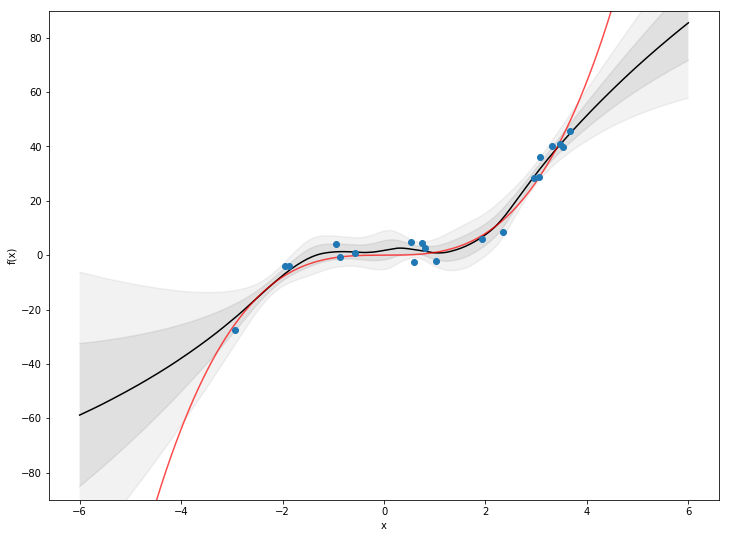

In [16]:
upper1 = np.mean(predictions[:,1:].detach().numpy(),1) + np.std(predictions[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions[:,1:].detach().numpy(),1) + 2 * np.std(predictions[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions[:,1:].detach().numpy(),1) + 3 * np.std(predictions[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions[:,1:].detach().numpy(),1) - np.std(predictions[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions[:,1:].detach().numpy(),1) - 2 * np.std(predictions[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions[:,1:].detach().numpy(),1) - 3 * np.std(predictions[:,1:].detach().numpy(),1)


plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions[:,1:].detach().numpy(),1),'black')
# plt.plot(grid,upper3,'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
# plt.plot(grid,lower3,'black')
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)
plt.xlabel('x')
plt.ylabel('f(x)')

### pSGLD

In [17]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld


lambda_ = 1.
lr = 6e-12
alpha = 0.99


batch_size = 20
dataset_size= 20



x_test = torch.FloatTensor(grid)
y_test = torch.FloatTensor(y_true)

# learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
# learning_rates = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14]
# learning_rates = [5e-13, 4e-13, 3e-13, 2e-13, 1e-13, 9e-14, 8e-14, 7e-14, 6e-14, 5e-14]
# learning_rates = [2e-12]
learning_rates = [8e-13]
rmse_result = np.zeros((1,len(learning_rates)))


for i,lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = psgld.optim.psgld(network, lr, lambda_, alpha, batch_size, dataset_size)
    predictions_psgld = torch.zeros(400,1)
    t = 1.
    
    for epoch in range(10000):
        running_loss = 0
        network.zero_grad()
        output = network(x)
        loss = (1./(2*9))*criterion(output, y)
        loss.backward()
        optim.step()

        running_loss += loss * batch_size / dataset_size


        if (t >= 100) & (t % 100 == 0):
            with torch.autograd.no_grad():
                output = network(x_test)
                predictions_psgld = torch.cat((predictions_psgld, output), 1)

        t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    rmse_result[:,i] = torch.sqrt(criterion(y_test, torch.mean(predictions_psgld,1).view(-1,1)))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 600.3889
Epoch 1 - loss: 600.4173
Epoch 2 - loss: 595.6016
Epoch 3 - loss: 589.7164
Epoch 4 - loss: 587.5980
Epoch 5 - loss: 584.8954
Epoch 6 - loss: 580.3758
Epoch 7 - loss: 576.8188
Epoch 8 - loss: 572.9070
Epoch 9 - loss: 572.6141
Epoch 10 - loss: 568.4731
Epoch 11 - loss: 563.7454
Epoch 12 - loss: 558.3977
Epoch 13 - loss: 554.5078
Epoch 14 - loss: 553.8846
Epoch 15 - loss: 554.8708
Epoch 16 - loss: 544.9474
Epoch 17 - loss: 541.1351
Epoch 18 - loss: 542.1827
Epoch 19 - loss: 538.1570
Epoch 20 - loss: 533.5388
Epoch 21 - loss: 532.2548
Epoch 22 - loss: 529.8428
Epoch 23 - loss: 531.0375
Epoch 24 - loss: 530.7072
Epoch 25 - loss: 528.8375
Epoch 26 - loss: 524.7643
Epoch 27 - loss: 524.7001
Epoch 28 - loss: 523.8256
Epoch 29 - loss: 518.1479
Epoch 30 - loss: 511.6963
Epoch 31 - loss: 509.0016
Epoch 32 - loss: 507.7661
Epoch 33 - loss: 502.8105
Epoch 34 - loss: 501.5292
Epoch 35 - loss: 490.8846
Epoch 36 - loss: 480.8104
Epoch 37 - loss: 477.0648
Epoch 38 - loss: 465.3

Epoch 356 - loss: 80.4006
Epoch 357 - loss: 81.6207
Epoch 358 - loss: 80.7134
Epoch 359 - loss: 79.8264
Epoch 360 - loss: 78.6614
Epoch 361 - loss: 78.3283
Epoch 362 - loss: 79.0526
Epoch 363 - loss: 79.4999
Epoch 364 - loss: 79.0733
Epoch 365 - loss: 78.7733
Epoch 366 - loss: 78.6866
Epoch 367 - loss: 79.6047
Epoch 368 - loss: 78.4052
Epoch 369 - loss: 78.1344
Epoch 370 - loss: 78.6616
Epoch 371 - loss: 78.2901
Epoch 372 - loss: 78.1512
Epoch 373 - loss: 79.2766
Epoch 374 - loss: 81.1287
Epoch 375 - loss: 79.5383
Epoch 376 - loss: 78.1501
Epoch 377 - loss: 77.7194
Epoch 378 - loss: 77.3324
Epoch 379 - loss: 77.1740
Epoch 380 - loss: 75.8376
Epoch 381 - loss: 76.0272
Epoch 382 - loss: 76.4117
Epoch 383 - loss: 76.6923
Epoch 384 - loss: 76.4054
Epoch 385 - loss: 75.4676
Epoch 386 - loss: 75.1541
Epoch 387 - loss: 75.1729
Epoch 388 - loss: 74.0567
Epoch 389 - loss: 73.9025
Epoch 390 - loss: 72.4347
Epoch 391 - loss: 72.4036
Epoch 392 - loss: 72.1955
Epoch 393 - loss: 72.4250
Epoch 394 - 

Epoch 733 - loss: 48.7410
Epoch 734 - loss: 48.4992
Epoch 735 - loss: 46.3888
Epoch 736 - loss: 46.2086
Epoch 737 - loss: 44.9378
Epoch 738 - loss: 44.0297
Epoch 739 - loss: 44.1873
Epoch 740 - loss: 44.4436
Epoch 741 - loss: 43.4262
Epoch 742 - loss: 43.7822
Epoch 743 - loss: 43.1925
Epoch 744 - loss: 43.3741
Epoch 745 - loss: 43.2407
Epoch 746 - loss: 43.6122
Epoch 747 - loss: 43.7006
Epoch 748 - loss: 43.2056
Epoch 749 - loss: 42.6125
Epoch 750 - loss: 42.7675
Epoch 751 - loss: 43.0300
Epoch 752 - loss: 43.7087
Epoch 753 - loss: 42.2053
Epoch 754 - loss: 43.0183
Epoch 755 - loss: 43.4809
Epoch 756 - loss: 42.5205
Epoch 757 - loss: 43.0202
Epoch 758 - loss: 42.7983
Epoch 759 - loss: 42.3443
Epoch 760 - loss: 42.2646
Epoch 761 - loss: 41.0527
Epoch 762 - loss: 41.4334
Epoch 763 - loss: 43.3217
Epoch 764 - loss: 42.7471
Epoch 765 - loss: 41.3196
Epoch 766 - loss: 42.0587
Epoch 767 - loss: 40.9160
Epoch 768 - loss: 41.5131
Epoch 769 - loss: 41.9833
Epoch 770 - loss: 41.0544
Epoch 771 - 

Epoch 1114 - loss: 15.9477
Epoch 1115 - loss: 16.2326
Epoch 1116 - loss: 15.6425
Epoch 1117 - loss: 16.3177
Epoch 1118 - loss: 17.0000
Epoch 1119 - loss: 16.9989
Epoch 1120 - loss: 16.9990
Epoch 1121 - loss: 16.7861
Epoch 1122 - loss: 17.0391
Epoch 1123 - loss: 16.9669
Epoch 1124 - loss: 16.3656
Epoch 1125 - loss: 15.6759
Epoch 1126 - loss: 15.9713
Epoch 1127 - loss: 16.1767
Epoch 1128 - loss: 15.6799
Epoch 1129 - loss: 16.3419
Epoch 1130 - loss: 15.8972
Epoch 1131 - loss: 17.3584
Epoch 1132 - loss: 18.6537
Epoch 1133 - loss: 19.3435
Epoch 1134 - loss: 18.5182
Epoch 1135 - loss: 19.5218
Epoch 1136 - loss: 20.0461
Epoch 1137 - loss: 20.7914
Epoch 1138 - loss: 20.5397
Epoch 1139 - loss: 21.2024
Epoch 1140 - loss: 19.8103
Epoch 1141 - loss: 19.4989
Epoch 1142 - loss: 20.2028
Epoch 1143 - loss: 21.5319
Epoch 1144 - loss: 21.3010
Epoch 1145 - loss: 21.1059
Epoch 1146 - loss: 20.6838
Epoch 1147 - loss: 20.7111
Epoch 1148 - loss: 20.0239
Epoch 1149 - loss: 19.5475
Epoch 1150 - loss: 19.9098
E

Epoch 1422 - loss: 13.7953
Epoch 1423 - loss: 13.2298
Epoch 1424 - loss: 13.5234
Epoch 1425 - loss: 12.1868
Epoch 1426 - loss: 12.5131
Epoch 1427 - loss: 13.3653
Epoch 1428 - loss: 13.1618
Epoch 1429 - loss: 16.1550
Epoch 1430 - loss: 13.7882
Epoch 1431 - loss: 12.5851
Epoch 1432 - loss: 12.2887
Epoch 1433 - loss: 12.5626
Epoch 1434 - loss: 13.4905
Epoch 1435 - loss: 12.5989
Epoch 1436 - loss: 14.1374
Epoch 1437 - loss: 14.2237
Epoch 1438 - loss: 14.0533
Epoch 1439 - loss: 13.4434
Epoch 1440 - loss: 14.5837
Epoch 1441 - loss: 17.1000
Epoch 1442 - loss: 14.4082
Epoch 1443 - loss: 14.0839
Epoch 1444 - loss: 13.3527
Epoch 1445 - loss: 15.6558
Epoch 1446 - loss: 13.4418
Epoch 1447 - loss: 16.7809
Epoch 1448 - loss: 14.8311
Epoch 1449 - loss: 12.0423
Epoch 1450 - loss: 11.8997
Epoch 1451 - loss: 12.0999
Epoch 1452 - loss: 12.6422
Epoch 1453 - loss: 13.2516
Epoch 1454 - loss: 15.4063
Epoch 1455 - loss: 14.6927
Epoch 1456 - loss: 14.8465
Epoch 1457 - loss: 15.1543
Epoch 1458 - loss: 15.0658
E

Epoch 1738 - loss: 13.7066
Epoch 1739 - loss: 12.2226
Epoch 1740 - loss: 15.3029
Epoch 1741 - loss: 11.6316
Epoch 1742 - loss: 10.8961
Epoch 1743 - loss: 11.5223
Epoch 1744 - loss: 12.7692
Epoch 1745 - loss: 11.4867
Epoch 1746 - loss: 10.6195
Epoch 1747 - loss: 11.2890
Epoch 1748 - loss: 12.0984
Epoch 1749 - loss: 14.8211
Epoch 1750 - loss: 11.2337
Epoch 1751 - loss: 12.0471
Epoch 1752 - loss: 14.4184
Epoch 1753 - loss: 12.5947
Epoch 1754 - loss: 14.3087
Epoch 1755 - loss: 13.1917
Epoch 1756 - loss: 12.3142
Epoch 1757 - loss: 14.5220
Epoch 1758 - loss: 12.7420
Epoch 1759 - loss: 14.3199
Epoch 1760 - loss: 16.3060
Epoch 1761 - loss: 11.7208
Epoch 1762 - loss: 10.9462
Epoch 1763 - loss: 12.2203
Epoch 1764 - loss: 10.9140
Epoch 1765 - loss: 12.4830
Epoch 1766 - loss: 15.6814
Epoch 1767 - loss: 12.8800
Epoch 1768 - loss: 12.4802
Epoch 1769 - loss: 11.6266
Epoch 1770 - loss: 15.8452
Epoch 1771 - loss: 12.2453
Epoch 1772 - loss: 11.4662
Epoch 1773 - loss: 11.5893
Epoch 1774 - loss: 10.6834
E

Epoch 2087 - loss: 17.6670
Epoch 2088 - loss: 20.5485
Epoch 2089 - loss: 18.4412
Epoch 2090 - loss: 17.7056
Epoch 2091 - loss: 17.7008
Epoch 2092 - loss: 17.2110
Epoch 2093 - loss: 14.6960
Epoch 2094 - loss: 14.6642
Epoch 2095 - loss: 13.8544
Epoch 2096 - loss: 14.0968
Epoch 2097 - loss: 17.4499
Epoch 2098 - loss: 15.2451
Epoch 2099 - loss: 14.9176
Epoch 2100 - loss: 22.5876
Epoch 2101 - loss: 15.0180
Epoch 2102 - loss: 14.0058
Epoch 2103 - loss: 13.3089
Epoch 2104 - loss: 13.3624
Epoch 2105 - loss: 13.5150
Epoch 2106 - loss: 13.8558
Epoch 2107 - loss: 17.8397
Epoch 2108 - loss: 13.2887
Epoch 2109 - loss: 16.7186
Epoch 2110 - loss: 12.9081
Epoch 2111 - loss: 13.3239
Epoch 2112 - loss: 13.5466
Epoch 2113 - loss: 13.7478
Epoch 2114 - loss: 15.7861
Epoch 2115 - loss: 14.7546
Epoch 2116 - loss: 15.5335
Epoch 2117 - loss: 15.6681
Epoch 2118 - loss: 16.4941
Epoch 2119 - loss: 16.8927
Epoch 2120 - loss: 15.3022
Epoch 2121 - loss: 15.8673
Epoch 2122 - loss: 15.1419
Epoch 2123 - loss: 17.6137
E

Epoch 2455 - loss: 11.4919
Epoch 2456 - loss: 11.8767
Epoch 2457 - loss: 11.7341
Epoch 2458 - loss: 12.7293
Epoch 2459 - loss: 13.2203
Epoch 2460 - loss: 12.8395
Epoch 2461 - loss: 12.8956
Epoch 2462 - loss: 12.5629
Epoch 2463 - loss: 14.1278
Epoch 2464 - loss: 12.4062
Epoch 2465 - loss: 14.5504
Epoch 2466 - loss: 20.9735
Epoch 2467 - loss: 13.6452
Epoch 2468 - loss: 11.4360
Epoch 2469 - loss: 16.6670
Epoch 2470 - loss: 14.1165
Epoch 2471 - loss: 13.6039
Epoch 2472 - loss: 10.2638
Epoch 2473 - loss: 10.6380
Epoch 2474 - loss: 11.0077
Epoch 2475 - loss: 11.3858
Epoch 2476 - loss: 12.9135
Epoch 2477 - loss: 13.4869
Epoch 2478 - loss: 13.9675
Epoch 2479 - loss: 15.3817
Epoch 2480 - loss: 11.6371
Epoch 2481 - loss: 12.1238
Epoch 2482 - loss: 16.9699
Epoch 2483 - loss: 18.9233
Epoch 2484 - loss: 20.3678
Epoch 2485 - loss: 16.1215
Epoch 2486 - loss: 14.1756
Epoch 2487 - loss: 12.3431
Epoch 2488 - loss: 11.5179
Epoch 2489 - loss: 11.3416
Epoch 2490 - loss: 12.1363
Epoch 2491 - loss: 13.2577
E

Epoch 2826 - loss: 24.6168
Epoch 2827 - loss: 29.9463
Epoch 2828 - loss: 34.0565
Epoch 2829 - loss: 29.9537
Epoch 2830 - loss: 20.1589
Epoch 2831 - loss: 20.9233
Epoch 2832 - loss: 36.9691
Epoch 2833 - loss: 40.1765
Epoch 2834 - loss: 40.4838
Epoch 2835 - loss: 23.0222
Epoch 2836 - loss: 11.8597
Epoch 2837 - loss: 12.6416
Epoch 2838 - loss: 8.3095
Epoch 2839 - loss: 11.2819
Epoch 2840 - loss: 23.0487
Epoch 2841 - loss: 29.7259
Epoch 2842 - loss: 27.9324
Epoch 2843 - loss: 29.6987
Epoch 2844 - loss: 17.6535
Epoch 2845 - loss: 14.1050
Epoch 2846 - loss: 12.9595
Epoch 2847 - loss: 13.6998
Epoch 2848 - loss: 11.9209
Epoch 2849 - loss: 10.0722
Epoch 2850 - loss: 12.0789
Epoch 2851 - loss: 10.0789
Epoch 2852 - loss: 11.8654
Epoch 2853 - loss: 19.3472
Epoch 2854 - loss: 21.8653
Epoch 2855 - loss: 10.6165
Epoch 2856 - loss: 11.3513
Epoch 2857 - loss: 9.7514
Epoch 2858 - loss: 9.3587
Epoch 2859 - loss: 9.8795
Epoch 2860 - loss: 8.6176
Epoch 2861 - loss: 10.3604
Epoch 2862 - loss: 8.8527
Epoch 2

Epoch 3177 - loss: 51.3272
Epoch 3178 - loss: 61.2986
Epoch 3179 - loss: 84.0151
Epoch 3180 - loss: 47.6391
Epoch 3181 - loss: 36.1006
Epoch 3182 - loss: 27.9833
Epoch 3183 - loss: 14.0422
Epoch 3184 - loss: 12.6798
Epoch 3185 - loss: 12.8072
Epoch 3186 - loss: 10.7641
Epoch 3187 - loss: 12.5329
Epoch 3188 - loss: 22.5412
Epoch 3189 - loss: 38.8831
Epoch 3190 - loss: 35.0306
Epoch 3191 - loss: 33.9079
Epoch 3192 - loss: 22.9330
Epoch 3193 - loss: 14.2824
Epoch 3194 - loss: 16.0682
Epoch 3195 - loss: 8.8436
Epoch 3196 - loss: 14.1905
Epoch 3197 - loss: 15.9593
Epoch 3198 - loss: 30.2158
Epoch 3199 - loss: 38.2281
Epoch 3200 - loss: 41.5893
Epoch 3201 - loss: 31.1758
Epoch 3202 - loss: 24.2837
Epoch 3203 - loss: 40.4018
Epoch 3204 - loss: 30.6558
Epoch 3205 - loss: 10.1824
Epoch 3206 - loss: 14.1456
Epoch 3207 - loss: 10.0387
Epoch 3208 - loss: 10.0710
Epoch 3209 - loss: 9.6685
Epoch 3210 - loss: 9.8843
Epoch 3211 - loss: 10.4492
Epoch 3212 - loss: 12.0214
Epoch 3213 - loss: 18.6444
Epoc

Epoch 3552 - loss: 8.4759
Epoch 3553 - loss: 9.6829
Epoch 3554 - loss: 25.5497
Epoch 3555 - loss: 15.2251
Epoch 3556 - loss: 12.0483
Epoch 3557 - loss: 23.0350
Epoch 3558 - loss: 39.7928
Epoch 3559 - loss: 35.6422
Epoch 3560 - loss: 24.7696
Epoch 3561 - loss: 20.4880
Epoch 3562 - loss: 17.2598
Epoch 3563 - loss: 12.7761
Epoch 3564 - loss: 16.1555
Epoch 3565 - loss: 15.3420
Epoch 3566 - loss: 9.4209
Epoch 3567 - loss: 10.5842
Epoch 3568 - loss: 16.4453
Epoch 3569 - loss: 10.7240
Epoch 3570 - loss: 9.4408
Epoch 3571 - loss: 9.8589
Epoch 3572 - loss: 11.4246
Epoch 3573 - loss: 18.0331
Epoch 3574 - loss: 11.1389
Epoch 3575 - loss: 8.6254
Epoch 3576 - loss: 9.9624
Epoch 3577 - loss: 10.7506
Epoch 3578 - loss: 9.0669
Epoch 3579 - loss: 12.8497
Epoch 3580 - loss: 10.0722
Epoch 3581 - loss: 9.6597
Epoch 3582 - loss: 7.8089
Epoch 3583 - loss: 8.7743
Epoch 3584 - loss: 13.4200
Epoch 3585 - loss: 9.9331
Epoch 3586 - loss: 13.4577
Epoch 3587 - loss: 10.6397
Epoch 3588 - loss: 12.5606
Epoch 3589 - 

Epoch 3941 - loss: 18.8121
Epoch 3942 - loss: 12.9521
Epoch 3943 - loss: 12.9728
Epoch 3944 - loss: 15.6209
Epoch 3945 - loss: 19.2604
Epoch 3946 - loss: 20.7932
Epoch 3947 - loss: 15.7223
Epoch 3948 - loss: 38.9781
Epoch 3949 - loss: 17.4005
Epoch 3950 - loss: 19.2887
Epoch 3951 - loss: 16.9801
Epoch 3952 - loss: 12.0325
Epoch 3953 - loss: 11.3419
Epoch 3954 - loss: 13.0241
Epoch 3955 - loss: 13.4032
Epoch 3956 - loss: 14.8697
Epoch 3957 - loss: 12.8092
Epoch 3958 - loss: 16.9633
Epoch 3959 - loss: 14.0023
Epoch 3960 - loss: 16.7827
Epoch 3961 - loss: 13.2600
Epoch 3962 - loss: 23.1424
Epoch 3963 - loss: 14.0201
Epoch 3964 - loss: 20.8949
Epoch 3965 - loss: 19.6883
Epoch 3966 - loss: 16.8326
Epoch 3967 - loss: 18.4475
Epoch 3968 - loss: 17.0571
Epoch 3969 - loss: 16.1264
Epoch 3970 - loss: 16.9556
Epoch 3971 - loss: 13.7995
Epoch 3972 - loss: 14.7057
Epoch 3973 - loss: 15.1125
Epoch 3974 - loss: 20.6516
Epoch 3975 - loss: 17.1094
Epoch 3976 - loss: 14.6449
Epoch 3977 - loss: 20.5030
E

Epoch 4311 - loss: 14.3935
Epoch 4312 - loss: 10.0676
Epoch 4313 - loss: 10.2165
Epoch 4314 - loss: 14.8422
Epoch 4315 - loss: 14.1740
Epoch 4316 - loss: 14.3158
Epoch 4317 - loss: 15.5814
Epoch 4318 - loss: 19.0425
Epoch 4319 - loss: 10.4683
Epoch 4320 - loss: 13.9929
Epoch 4321 - loss: 15.2235
Epoch 4322 - loss: 11.6471
Epoch 4323 - loss: 12.4813
Epoch 4324 - loss: 12.6880
Epoch 4325 - loss: 10.4411
Epoch 4326 - loss: 11.8576
Epoch 4327 - loss: 15.7040
Epoch 4328 - loss: 15.5935
Epoch 4329 - loss: 17.2876
Epoch 4330 - loss: 19.2651
Epoch 4331 - loss: 18.6382
Epoch 4332 - loss: 19.4952
Epoch 4333 - loss: 15.1492
Epoch 4334 - loss: 15.0709
Epoch 4335 - loss: 17.2992
Epoch 4336 - loss: 8.9104
Epoch 4337 - loss: 8.6841
Epoch 4338 - loss: 8.7917
Epoch 4339 - loss: 8.1067
Epoch 4340 - loss: 24.5446
Epoch 4341 - loss: 18.8412
Epoch 4342 - loss: 29.9640
Epoch 4343 - loss: 10.5490
Epoch 4344 - loss: 9.6525
Epoch 4345 - loss: 12.3609
Epoch 4346 - loss: 14.2137
Epoch 4347 - loss: 11.3831
Epoch 

Epoch 4680 - loss: 12.7217
Epoch 4681 - loss: 13.9281
Epoch 4682 - loss: 12.9906
Epoch 4683 - loss: 13.6033
Epoch 4684 - loss: 30.5550
Epoch 4685 - loss: 37.7161
Epoch 4686 - loss: 32.8624
Epoch 4687 - loss: 25.3579
Epoch 4688 - loss: 20.8202
Epoch 4689 - loss: 13.3229
Epoch 4690 - loss: 16.6283
Epoch 4691 - loss: 14.8942
Epoch 4692 - loss: 12.8527
Epoch 4693 - loss: 10.7809
Epoch 4694 - loss: 10.4456
Epoch 4695 - loss: 16.7314
Epoch 4696 - loss: 8.9491
Epoch 4697 - loss: 10.4084
Epoch 4698 - loss: 9.4037
Epoch 4699 - loss: 9.9457
Epoch 4700 - loss: 9.7818
Epoch 4701 - loss: 11.5268
Epoch 4702 - loss: 11.8802
Epoch 4703 - loss: 10.3604
Epoch 4704 - loss: 11.9692
Epoch 4705 - loss: 9.6343
Epoch 4706 - loss: 10.5504
Epoch 4707 - loss: 11.2554
Epoch 4708 - loss: 9.4922
Epoch 4709 - loss: 8.8316
Epoch 4710 - loss: 16.7149
Epoch 4711 - loss: 19.5541
Epoch 4712 - loss: 21.0246
Epoch 4713 - loss: 30.5269
Epoch 4714 - loss: 33.1740
Epoch 4715 - loss: 17.2861
Epoch 4716 - loss: 13.7667
Epoch 47

Epoch 5053 - loss: 22.8538
Epoch 5054 - loss: 20.2888
Epoch 5055 - loss: 15.4246
Epoch 5056 - loss: 19.4038
Epoch 5057 - loss: 15.2545
Epoch 5058 - loss: 17.0024
Epoch 5059 - loss: 21.9247
Epoch 5060 - loss: 19.5689
Epoch 5061 - loss: 17.9815
Epoch 5062 - loss: 15.9940
Epoch 5063 - loss: 17.9881
Epoch 5064 - loss: 15.7672
Epoch 5065 - loss: 14.6017
Epoch 5066 - loss: 15.9174
Epoch 5067 - loss: 16.6218
Epoch 5068 - loss: 19.1903
Epoch 5069 - loss: 17.0870
Epoch 5070 - loss: 17.0274
Epoch 5071 - loss: 16.0632
Epoch 5072 - loss: 18.3846
Epoch 5073 - loss: 17.2546
Epoch 5074 - loss: 15.1595
Epoch 5075 - loss: 14.1606
Epoch 5076 - loss: 13.2831
Epoch 5077 - loss: 12.6205
Epoch 5078 - loss: 14.2609
Epoch 5079 - loss: 13.1453
Epoch 5080 - loss: 10.7748
Epoch 5081 - loss: 11.8173
Epoch 5082 - loss: 11.8640
Epoch 5083 - loss: 10.9667
Epoch 5084 - loss: 13.5093
Epoch 5085 - loss: 9.6127
Epoch 5086 - loss: 15.5804
Epoch 5087 - loss: 10.3951
Epoch 5088 - loss: 14.7312
Epoch 5089 - loss: 11.3004
Ep

Epoch 5365 - loss: 26.3525
Epoch 5366 - loss: 34.1508
Epoch 5367 - loss: 28.5198
Epoch 5368 - loss: 41.3857
Epoch 5369 - loss: 61.9509
Epoch 5370 - loss: 101.8315
Epoch 5371 - loss: 103.5863
Epoch 5372 - loss: 108.2101
Epoch 5373 - loss: 89.3962
Epoch 5374 - loss: 72.8545
Epoch 5375 - loss: 41.2599
Epoch 5376 - loss: 41.0230
Epoch 5377 - loss: 36.3734
Epoch 5378 - loss: 16.6202
Epoch 5379 - loss: 14.9960
Epoch 5380 - loss: 14.5613
Epoch 5381 - loss: 24.8600
Epoch 5382 - loss: 21.8006
Epoch 5383 - loss: 19.3303
Epoch 5384 - loss: 26.6012
Epoch 5385 - loss: 13.8913
Epoch 5386 - loss: 11.3198
Epoch 5387 - loss: 18.8402
Epoch 5388 - loss: 11.4840
Epoch 5389 - loss: 16.1267
Epoch 5390 - loss: 17.7500
Epoch 5391 - loss: 15.3203
Epoch 5392 - loss: 19.0788
Epoch 5393 - loss: 14.4436
Epoch 5394 - loss: 8.3048
Epoch 5395 - loss: 8.1849
Epoch 5396 - loss: 7.9916
Epoch 5397 - loss: 8.6906
Epoch 5398 - loss: 7.5497
Epoch 5399 - loss: 8.5036
Epoch 5400 - loss: 11.9168
Epoch 5401 - loss: 10.0200
Epoc

Epoch 5723 - loss: 9.0518
Epoch 5724 - loss: 10.5279
Epoch 5725 - loss: 13.0520
Epoch 5726 - loss: 12.6800
Epoch 5727 - loss: 23.6799
Epoch 5728 - loss: 13.9524
Epoch 5729 - loss: 11.5250
Epoch 5730 - loss: 20.2716
Epoch 5731 - loss: 7.4050
Epoch 5732 - loss: 10.3492
Epoch 5733 - loss: 21.7849
Epoch 5734 - loss: 14.0452
Epoch 5735 - loss: 15.7858
Epoch 5736 - loss: 12.2742
Epoch 5737 - loss: 7.9728
Epoch 5738 - loss: 9.5646
Epoch 5739 - loss: 8.9323
Epoch 5740 - loss: 7.5827
Epoch 5741 - loss: 8.7144
Epoch 5742 - loss: 8.4479
Epoch 5743 - loss: 7.2901
Epoch 5744 - loss: 8.4843
Epoch 5745 - loss: 13.5589
Epoch 5746 - loss: 23.3335
Epoch 5747 - loss: 14.4131
Epoch 5748 - loss: 17.2182
Epoch 5749 - loss: 8.5364
Epoch 5750 - loss: 8.3531
Epoch 5751 - loss: 14.4390
Epoch 5752 - loss: 12.8939
Epoch 5753 - loss: 21.7119
Epoch 5754 - loss: 16.3385
Epoch 5755 - loss: 17.8423
Epoch 5756 - loss: 28.1851
Epoch 5757 - loss: 18.9250
Epoch 5758 - loss: 32.5089
Epoch 5759 - loss: 27.9272
Epoch 5760 - 

Epoch 6034 - loss: 10.0374
Epoch 6035 - loss: 8.2377
Epoch 6036 - loss: 7.3194
Epoch 6037 - loss: 8.8967
Epoch 6038 - loss: 8.9614
Epoch 6039 - loss: 9.8140
Epoch 6040 - loss: 7.4389
Epoch 6041 - loss: 18.6885
Epoch 6042 - loss: 8.0660
Epoch 6043 - loss: 7.8404
Epoch 6044 - loss: 7.0246
Epoch 6045 - loss: 8.4338
Epoch 6046 - loss: 8.0742
Epoch 6047 - loss: 8.9911
Epoch 6048 - loss: 9.2941
Epoch 6049 - loss: 9.4434
Epoch 6050 - loss: 9.7480
Epoch 6051 - loss: 9.4488
Epoch 6052 - loss: 8.4635
Epoch 6053 - loss: 9.9568
Epoch 6054 - loss: 8.2611
Epoch 6055 - loss: 11.0822
Epoch 6056 - loss: 10.8917
Epoch 6057 - loss: 8.7697
Epoch 6058 - loss: 12.3805
Epoch 6059 - loss: 15.0197
Epoch 6060 - loss: 20.4862
Epoch 6061 - loss: 27.8095
Epoch 6062 - loss: 34.0938
Epoch 6063 - loss: 28.0124
Epoch 6064 - loss: 10.1347
Epoch 6065 - loss: 9.0831
Epoch 6066 - loss: 7.3091
Epoch 6067 - loss: 8.6874
Epoch 6068 - loss: 8.5106
Epoch 6069 - loss: 9.4795
Epoch 6070 - loss: 12.9991
Epoch 6071 - loss: 22.6278

Epoch 6384 - loss: 22.6789
Epoch 6385 - loss: 13.8722
Epoch 6386 - loss: 20.0636
Epoch 6387 - loss: 8.6769
Epoch 6388 - loss: 8.3925
Epoch 6389 - loss: 9.1797
Epoch 6390 - loss: 11.2612
Epoch 6391 - loss: 8.4531
Epoch 6392 - loss: 8.1300
Epoch 6393 - loss: 11.8891
Epoch 6394 - loss: 12.4435
Epoch 6395 - loss: 9.7002
Epoch 6396 - loss: 9.7629
Epoch 6397 - loss: 11.2023
Epoch 6398 - loss: 13.1234
Epoch 6399 - loss: 11.4608
Epoch 6400 - loss: 17.6798
Epoch 6401 - loss: 16.4057
Epoch 6402 - loss: 21.1353
Epoch 6403 - loss: 11.2426
Epoch 6404 - loss: 15.4310
Epoch 6405 - loss: 11.6478
Epoch 6406 - loss: 12.3892
Epoch 6407 - loss: 29.5555
Epoch 6408 - loss: 23.3480
Epoch 6409 - loss: 54.9259
Epoch 6410 - loss: 35.3017
Epoch 6411 - loss: 43.5305
Epoch 6412 - loss: 32.2701
Epoch 6413 - loss: 12.4316
Epoch 6414 - loss: 20.8118
Epoch 6415 - loss: 33.0925
Epoch 6416 - loss: 10.9626
Epoch 6417 - loss: 17.0928
Epoch 6418 - loss: 16.2272
Epoch 6419 - loss: 20.1573
Epoch 6420 - loss: 40.1573
Epoch 64

Epoch 6722 - loss: 9.6002
Epoch 6723 - loss: 10.1721
Epoch 6724 - loss: 17.6657
Epoch 6725 - loss: 9.6437
Epoch 6726 - loss: 8.5640
Epoch 6727 - loss: 7.2451
Epoch 6728 - loss: 10.0094
Epoch 6729 - loss: 7.6502
Epoch 6730 - loss: 9.6034
Epoch 6731 - loss: 9.4143
Epoch 6732 - loss: 9.6620
Epoch 6733 - loss: 9.9578
Epoch 6734 - loss: 10.3017
Epoch 6735 - loss: 10.1649
Epoch 6736 - loss: 12.4074
Epoch 6737 - loss: 12.8159
Epoch 6738 - loss: 8.2634
Epoch 6739 - loss: 10.1238
Epoch 6740 - loss: 10.2026
Epoch 6741 - loss: 11.0671
Epoch 6742 - loss: 14.6801
Epoch 6743 - loss: 12.7637
Epoch 6744 - loss: 9.1913
Epoch 6745 - loss: 9.0701
Epoch 6746 - loss: 9.7852
Epoch 6747 - loss: 8.6070
Epoch 6748 - loss: 7.7118
Epoch 6749 - loss: 7.7084
Epoch 6750 - loss: 8.6503
Epoch 6751 - loss: 8.8036
Epoch 6752 - loss: 7.7503
Epoch 6753 - loss: 7.6370
Epoch 6754 - loss: 7.4196
Epoch 6755 - loss: 11.2108
Epoch 6756 - loss: 11.9121
Epoch 6757 - loss: 20.7112
Epoch 6758 - loss: 16.1960
Epoch 6759 - loss: 12.

Epoch 7041 - loss: 17.9200
Epoch 7042 - loss: 12.7898
Epoch 7043 - loss: 12.6746
Epoch 7044 - loss: 20.3005
Epoch 7045 - loss: 14.4372
Epoch 7046 - loss: 15.4967
Epoch 7047 - loss: 8.3046
Epoch 7048 - loss: 10.4293
Epoch 7049 - loss: 9.1806
Epoch 7050 - loss: 13.9807
Epoch 7051 - loss: 11.7359
Epoch 7052 - loss: 13.5119
Epoch 7053 - loss: 9.6111
Epoch 7054 - loss: 14.2150
Epoch 7055 - loss: 10.7466
Epoch 7056 - loss: 11.0109
Epoch 7057 - loss: 19.6932
Epoch 7058 - loss: 8.9219
Epoch 7059 - loss: 8.2838
Epoch 7060 - loss: 18.6985
Epoch 7061 - loss: 24.5630
Epoch 7062 - loss: 19.1776
Epoch 7063 - loss: 7.8136
Epoch 7064 - loss: 8.3448
Epoch 7065 - loss: 9.0320
Epoch 7066 - loss: 11.6894
Epoch 7067 - loss: 7.9245
Epoch 7068 - loss: 7.5919
Epoch 7069 - loss: 8.9091
Epoch 7070 - loss: 18.1257
Epoch 7071 - loss: 27.1467
Epoch 7072 - loss: 17.5074
Epoch 7073 - loss: 13.5347
Epoch 7074 - loss: 10.9547
Epoch 7075 - loss: 7.6248
Epoch 7076 - loss: 8.7005
Epoch 7077 - loss: 8.8055
Epoch 7078 - lo

Epoch 7392 - loss: 11.9170
Epoch 7393 - loss: 16.7602
Epoch 7394 - loss: 15.3785
Epoch 7395 - loss: 21.3997
Epoch 7396 - loss: 22.5311
Epoch 7397 - loss: 13.7049
Epoch 7398 - loss: 12.3121
Epoch 7399 - loss: 9.2905
Epoch 7400 - loss: 11.4560
Epoch 7401 - loss: 11.4842
Epoch 7402 - loss: 17.5710
Epoch 7403 - loss: 27.7161
Epoch 7404 - loss: 59.1840
Epoch 7405 - loss: 29.3708
Epoch 7406 - loss: 19.9641
Epoch 7407 - loss: 11.2000
Epoch 7408 - loss: 16.9915
Epoch 7409 - loss: 9.6672
Epoch 7410 - loss: 14.7204
Epoch 7411 - loss: 12.6549
Epoch 7412 - loss: 17.9803
Epoch 7413 - loss: 32.5184
Epoch 7414 - loss: 27.7833
Epoch 7415 - loss: 47.5134
Epoch 7416 - loss: 35.3062
Epoch 7417 - loss: 44.5636
Epoch 7418 - loss: 87.5272
Epoch 7419 - loss: 56.7618
Epoch 7420 - loss: 36.6387
Epoch 7421 - loss: 39.4578
Epoch 7422 - loss: 38.2740
Epoch 7423 - loss: 24.2198
Epoch 7424 - loss: 36.7903
Epoch 7425 - loss: 20.1342
Epoch 7426 - loss: 30.0814
Epoch 7427 - loss: 16.1289
Epoch 7428 - loss: 24.2268
Epo

Epoch 7742 - loss: 10.0012
Epoch 7743 - loss: 11.4941
Epoch 7744 - loss: 23.5234
Epoch 7745 - loss: 11.1286
Epoch 7746 - loss: 10.7548
Epoch 7747 - loss: 8.1355
Epoch 7748 - loss: 11.1794
Epoch 7749 - loss: 12.2862
Epoch 7750 - loss: 9.1291
Epoch 7751 - loss: 15.1081
Epoch 7752 - loss: 6.7654
Epoch 7753 - loss: 11.1553
Epoch 7754 - loss: 35.4163
Epoch 7755 - loss: 42.8136
Epoch 7756 - loss: 51.4972
Epoch 7757 - loss: 39.5364
Epoch 7758 - loss: 46.6899
Epoch 7759 - loss: 62.3223
Epoch 7760 - loss: 65.1084
Epoch 7761 - loss: 35.6697
Epoch 7762 - loss: 46.5906
Epoch 7763 - loss: 53.4400
Epoch 7764 - loss: 49.3729
Epoch 7765 - loss: 44.5232
Epoch 7766 - loss: 66.7749
Epoch 7767 - loss: 22.1481
Epoch 7768 - loss: 16.5999
Epoch 7769 - loss: 14.7975
Epoch 7770 - loss: 11.7094
Epoch 7771 - loss: 8.6388
Epoch 7772 - loss: 10.8489
Epoch 7773 - loss: 15.0115
Epoch 7774 - loss: 11.6633
Epoch 7775 - loss: 9.8092
Epoch 7776 - loss: 12.5683
Epoch 7777 - loss: 17.4248
Epoch 7778 - loss: 20.9482
Epoch 

Epoch 8110 - loss: 9.5597
Epoch 8111 - loss: 8.7527
Epoch 8112 - loss: 11.0232
Epoch 8113 - loss: 9.8378
Epoch 8114 - loss: 10.0731
Epoch 8115 - loss: 18.5034
Epoch 8116 - loss: 18.3579
Epoch 8117 - loss: 15.2353
Epoch 8118 - loss: 15.6637
Epoch 8119 - loss: 39.0149
Epoch 8120 - loss: 26.8091
Epoch 8121 - loss: 26.1572
Epoch 8122 - loss: 12.4060
Epoch 8123 - loss: 11.1820
Epoch 8124 - loss: 13.3230
Epoch 8125 - loss: 12.3464
Epoch 8126 - loss: 14.1070
Epoch 8127 - loss: 7.4366
Epoch 8128 - loss: 7.9702
Epoch 8129 - loss: 12.7594
Epoch 8130 - loss: 9.7071
Epoch 8131 - loss: 13.3098
Epoch 8132 - loss: 11.6883
Epoch 8133 - loss: 10.3388
Epoch 8134 - loss: 8.7490
Epoch 8135 - loss: 10.4616
Epoch 8136 - loss: 7.7586
Epoch 8137 - loss: 9.9978
Epoch 8138 - loss: 12.3709
Epoch 8139 - loss: 10.6026
Epoch 8140 - loss: 8.1908
Epoch 8141 - loss: 7.5822
Epoch 8142 - loss: 7.1683
Epoch 8143 - loss: 7.9488
Epoch 8144 - loss: 8.2002
Epoch 8145 - loss: 8.9748
Epoch 8146 - loss: 13.4693
Epoch 8147 - los

Epoch 8458 - loss: 16.9529
Epoch 8459 - loss: 14.5603
Epoch 8460 - loss: 13.3938
Epoch 8461 - loss: 15.1880
Epoch 8462 - loss: 24.1372
Epoch 8463 - loss: 15.9097
Epoch 8464 - loss: 11.2296
Epoch 8465 - loss: 12.5452
Epoch 8466 - loss: 12.7643
Epoch 8467 - loss: 9.5975
Epoch 8468 - loss: 21.6114
Epoch 8469 - loss: 10.6085
Epoch 8470 - loss: 14.1623
Epoch 8471 - loss: 12.9976
Epoch 8472 - loss: 12.3358
Epoch 8473 - loss: 11.6502
Epoch 8474 - loss: 12.5764
Epoch 8475 - loss: 20.1884
Epoch 8476 - loss: 16.0509
Epoch 8477 - loss: 7.5112
Epoch 8478 - loss: 10.7490
Epoch 8479 - loss: 12.4101
Epoch 8480 - loss: 9.0711
Epoch 8481 - loss: 14.7492
Epoch 8482 - loss: 15.3709
Epoch 8483 - loss: 11.1261
Epoch 8484 - loss: 13.2827
Epoch 8485 - loss: 13.3817
Epoch 8486 - loss: 13.1320
Epoch 8487 - loss: 8.9898
Epoch 8488 - loss: 12.4486
Epoch 8489 - loss: 15.2767
Epoch 8490 - loss: 15.7669
Epoch 8491 - loss: 11.7143
Epoch 8492 - loss: 9.4750
Epoch 8493 - loss: 10.2899
Epoch 8494 - loss: 7.9800
Epoch 8

Epoch 8777 - loss: 20.9946
Epoch 8778 - loss: 18.5945
Epoch 8779 - loss: 14.8449
Epoch 8780 - loss: 13.0248
Epoch 8781 - loss: 13.3762
Epoch 8782 - loss: 15.1047
Epoch 8783 - loss: 7.3288
Epoch 8784 - loss: 11.3220
Epoch 8785 - loss: 11.5017
Epoch 8786 - loss: 8.1389
Epoch 8787 - loss: 15.3850
Epoch 8788 - loss: 10.2375
Epoch 8789 - loss: 11.8270
Epoch 8790 - loss: 8.8415
Epoch 8791 - loss: 9.7412
Epoch 8792 - loss: 16.4023
Epoch 8793 - loss: 25.5297
Epoch 8794 - loss: 35.0677
Epoch 8795 - loss: 19.5095
Epoch 8796 - loss: 11.8143
Epoch 8797 - loss: 8.2274
Epoch 8798 - loss: 8.2430
Epoch 8799 - loss: 12.6496
Epoch 8800 - loss: 20.2326
Epoch 8801 - loss: 10.5751
Epoch 8802 - loss: 12.9251
Epoch 8803 - loss: 14.3179
Epoch 8804 - loss: 10.0118
Epoch 8805 - loss: 16.2823
Epoch 8806 - loss: 20.8751
Epoch 8807 - loss: 13.2821
Epoch 8808 - loss: 9.0727
Epoch 8809 - loss: 8.4194
Epoch 8810 - loss: 14.1793
Epoch 8811 - loss: 22.4027
Epoch 8812 - loss: 10.5996
Epoch 8813 - loss: 14.4385
Epoch 881

Epoch 9138 - loss: 14.0241
Epoch 9139 - loss: 26.1483
Epoch 9140 - loss: 13.8560
Epoch 9141 - loss: 13.9750
Epoch 9142 - loss: 18.6962
Epoch 9143 - loss: 25.3820
Epoch 9144 - loss: 37.5179
Epoch 9145 - loss: 11.0020
Epoch 9146 - loss: 9.6004
Epoch 9147 - loss: 10.5331
Epoch 9148 - loss: 10.0705
Epoch 9149 - loss: 13.0313
Epoch 9150 - loss: 19.9195
Epoch 9151 - loss: 18.5799
Epoch 9152 - loss: 16.4482
Epoch 9153 - loss: 12.8123
Epoch 9154 - loss: 17.0121
Epoch 9155 - loss: 9.9040
Epoch 9156 - loss: 13.6680
Epoch 9157 - loss: 11.1054
Epoch 9158 - loss: 10.4584
Epoch 9159 - loss: 13.7006
Epoch 9160 - loss: 14.1014
Epoch 9161 - loss: 14.3601
Epoch 9162 - loss: 17.4113
Epoch 9163 - loss: 18.0366
Epoch 9164 - loss: 21.1368
Epoch 9165 - loss: 18.7620
Epoch 9166 - loss: 12.2225
Epoch 9167 - loss: 26.4593
Epoch 9168 - loss: 26.3835
Epoch 9169 - loss: 20.7350
Epoch 9170 - loss: 16.5421
Epoch 9171 - loss: 11.6598
Epoch 9172 - loss: 12.0601
Epoch 9173 - loss: 13.2865
Epoch 9174 - loss: 12.8872
Epo

Epoch 9485 - loss: 9.1595
Epoch 9486 - loss: 9.7415
Epoch 9487 - loss: 11.0103
Epoch 9488 - loss: 24.2489
Epoch 9489 - loss: 17.3449
Epoch 9490 - loss: 16.4544
Epoch 9491 - loss: 14.6245
Epoch 9492 - loss: 19.0445
Epoch 9493 - loss: 16.0045
Epoch 9494 - loss: 11.4723
Epoch 9495 - loss: 11.3330
Epoch 9496 - loss: 12.6600
Epoch 9497 - loss: 15.9980
Epoch 9498 - loss: 19.1753
Epoch 9499 - loss: 13.6045
Epoch 9500 - loss: 12.6613
Epoch 9501 - loss: 16.0680
Epoch 9502 - loss: 15.8243
Epoch 9503 - loss: 10.0178
Epoch 9504 - loss: 15.7616
Epoch 9505 - loss: 12.3100
Epoch 9506 - loss: 14.7174
Epoch 9507 - loss: 18.5748
Epoch 9508 - loss: 12.3871
Epoch 9509 - loss: 10.2139
Epoch 9510 - loss: 11.7251
Epoch 9511 - loss: 17.3873
Epoch 9512 - loss: 22.6951
Epoch 9513 - loss: 23.2756
Epoch 9514 - loss: 19.2532
Epoch 9515 - loss: 16.2146
Epoch 9516 - loss: 20.3991
Epoch 9517 - loss: 12.1213
Epoch 9518 - loss: 14.5590
Epoch 9519 - loss: 15.3948
Epoch 9520 - loss: 16.3849
Epoch 9521 - loss: 20.3018
Epo

Epoch 9857 - loss: 17.7609
Epoch 9858 - loss: 60.6842
Epoch 9859 - loss: 92.7809
Epoch 9860 - loss: 90.7004
Epoch 9861 - loss: 55.6519
Epoch 9862 - loss: 29.0170
Epoch 9863 - loss: 45.6520
Epoch 9864 - loss: 29.9385
Epoch 9865 - loss: 10.0462
Epoch 9866 - loss: 15.3582
Epoch 9867 - loss: 14.1156
Epoch 9868 - loss: 16.0010
Epoch 9869 - loss: 13.1355
Epoch 9870 - loss: 19.2020
Epoch 9871 - loss: 14.1748
Epoch 9872 - loss: 12.9702
Epoch 9873 - loss: 9.5908
Epoch 9874 - loss: 12.5231
Epoch 9875 - loss: 9.1234
Epoch 9876 - loss: 11.0087
Epoch 9877 - loss: 10.0424
Epoch 9878 - loss: 9.6481
Epoch 9879 - loss: 23.3142
Epoch 9880 - loss: 11.4565
Epoch 9881 - loss: 12.2253
Epoch 9882 - loss: 11.2414
Epoch 9883 - loss: 10.9130
Epoch 9884 - loss: 14.8477
Epoch 9885 - loss: 14.2078
Epoch 9886 - loss: 25.2621
Epoch 9887 - loss: 22.2419
Epoch 9888 - loss: 12.8715
Epoch 9889 - loss: 10.2771
Epoch 9890 - loss: 10.1241
Epoch 9891 - loss: 9.4311
Epoch 9892 - loss: 15.7302
Epoch 9893 - loss: 9.2823
Epoch 

Text(0,0.5,'f(x)')

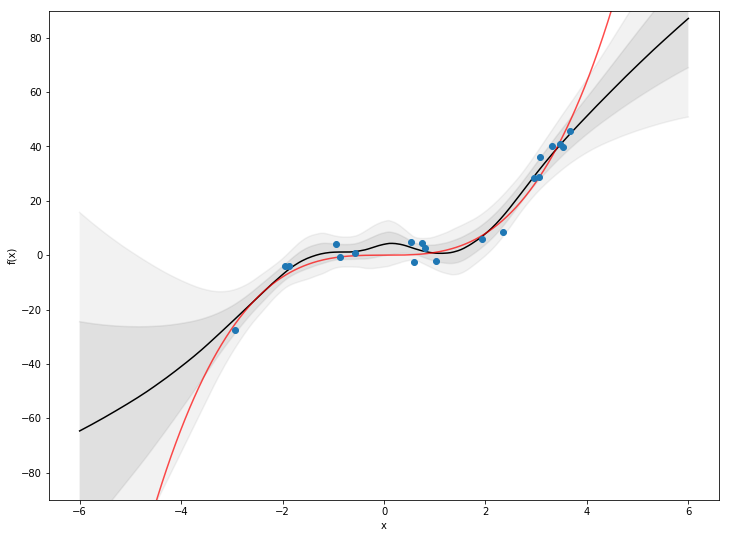

In [18]:
upper1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + np.std(predictions_psgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_psgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)
plt.xlabel('x')
plt.ylabel('f(x)')

### KSGLD

In [51]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgld

eta = 1.
v = 0.
lambda_ = 1.
l2 = 1e-3


batch_size = 20
dataset_size= 20

x_test = torch.FloatTensor(grid)
y_test = torch.FloatTensor(y_true)

# learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
# learning_rates = [1e-2, 9e-3, 8e-3, 7e-3, 6e-3, 5e-3]
# learning_rates = [1e-2]
# learning_rates = [1e-2]
learning_rates = [8e-4]
rmse_result = np.zeros((1,len(learning_rates)))


for i,lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    predictions_ksgld = torch.zeros(400,1)
    
    t = 1.
    for epoch in range(10000):

        running_loss = 0

        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = (1./(2*9))*criterion(output, y)
        loss.backward()
        optim.step()

        running_loss += loss * batch_size / dataset_size


        if (t >= 100) & (t % 100 == 0):
            with torch.autograd.no_grad():
                output = network(x_test)
                predictions_ksgld = torch.cat((predictions_ksgld, output), 1)

        t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    rmse_result[:,i] = torch.sqrt(criterion(y_test, torch.mean(predictions_ksgld,1).view(-1,1)))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 603.3179
Epoch 1 - loss: 602.7935
Epoch 2 - loss: 601.9443
Epoch 3 - loss: 600.9313
Epoch 4 - loss: 594.3685
Epoch 5 - loss: 591.7249
Epoch 6 - loss: 587.7665
Epoch 7 - loss: 585.2677
Epoch 8 - loss: 582.3805
Epoch 9 - loss: 583.7275
Epoch 10 - loss: 579.9213
Epoch 11 - loss: 576.1246
Epoch 12 - loss: 576.0466
Epoch 13 - loss: 574.1481
Epoch 14 - loss: 576.1010
Epoch 15 - loss: 579.2664
Epoch 16 - loss: 577.1788
Epoch 17 - loss: 576.5375
Epoch 18 - loss: 574.4368
Epoch 19 - loss: 567.7382
Epoch 20 - loss: 567.5784
Epoch 21 - loss: 562.7883
Epoch 22 - loss: 560.4968
Epoch 23 - loss: 558.8797
Epoch 24 - loss: 553.4134
Epoch 25 - loss: 552.1290
Epoch 26 - loss: 551.0366
Epoch 27 - loss: 546.1026
Epoch 28 - loss: 543.9974
Epoch 29 - loss: 539.5905
Epoch 30 - loss: 532.3190
Epoch 31 - loss: 531.6785
Epoch 32 - loss: 531.1380
Epoch 33 - loss: 522.1179
Epoch 34 - loss: 519.4222
Epoch 35 - loss: 513.4846
Epoch 36 - loss: 504.1584
Epoch 37 - loss: 501.4735
Epoch 38 - loss: 502.6

Epoch 332 - loss: 22.9474
Epoch 333 - loss: 22.3317
Epoch 334 - loss: 22.8521
Epoch 335 - loss: 24.8568
Epoch 336 - loss: 26.4223
Epoch 337 - loss: 28.1025
Epoch 338 - loss: 29.8991
Epoch 339 - loss: 28.7236
Epoch 340 - loss: 29.2617
Epoch 341 - loss: 28.3207
Epoch 342 - loss: 27.6580
Epoch 343 - loss: 28.3645
Epoch 344 - loss: 26.3381
Epoch 345 - loss: 24.0067
Epoch 346 - loss: 25.8545
Epoch 347 - loss: 24.3298
Epoch 348 - loss: 21.5921
Epoch 349 - loss: 21.4842
Epoch 350 - loss: 21.1167
Epoch 351 - loss: 21.7085
Epoch 352 - loss: 21.9733
Epoch 353 - loss: 20.6122
Epoch 354 - loss: 19.2510
Epoch 355 - loss: 19.1108
Epoch 356 - loss: 19.3771
Epoch 357 - loss: 19.4230
Epoch 358 - loss: 18.7035
Epoch 359 - loss: 19.5614
Epoch 360 - loss: 18.6226
Epoch 361 - loss: 18.4716
Epoch 362 - loss: 18.2345
Epoch 363 - loss: 16.8471
Epoch 364 - loss: 17.4547
Epoch 365 - loss: 17.2249
Epoch 366 - loss: 17.1158
Epoch 367 - loss: 18.5506
Epoch 368 - loss: 19.5040
Epoch 369 - loss: 19.5439
Epoch 370 - 

Epoch 652 - loss: 9.0926
Epoch 653 - loss: 10.1052
Epoch 654 - loss: 10.7147
Epoch 655 - loss: 10.6713
Epoch 656 - loss: 10.5874
Epoch 657 - loss: 11.0977
Epoch 658 - loss: 11.9186
Epoch 659 - loss: 13.7491
Epoch 660 - loss: 13.1927
Epoch 661 - loss: 12.2767
Epoch 662 - loss: 11.3532
Epoch 663 - loss: 10.6029
Epoch 664 - loss: 10.3100
Epoch 665 - loss: 9.0345
Epoch 666 - loss: 8.7365
Epoch 667 - loss: 9.0271
Epoch 668 - loss: 8.5657
Epoch 669 - loss: 8.2364
Epoch 670 - loss: 9.5361
Epoch 671 - loss: 9.1692
Epoch 672 - loss: 10.4532
Epoch 673 - loss: 9.2059
Epoch 674 - loss: 8.8396
Epoch 675 - loss: 7.8834
Epoch 676 - loss: 8.5109
Epoch 677 - loss: 9.2401
Epoch 678 - loss: 8.3043
Epoch 679 - loss: 8.3950
Epoch 680 - loss: 8.1741
Epoch 681 - loss: 8.2579
Epoch 682 - loss: 7.8282
Epoch 683 - loss: 8.3275
Epoch 684 - loss: 9.0345
Epoch 685 - loss: 9.4163
Epoch 686 - loss: 9.7793
Epoch 687 - loss: 9.1602
Epoch 688 - loss: 9.1505
Epoch 689 - loss: 10.4400
Epoch 690 - loss: 10.3964
Epoch 691 

Epoch 973 - loss: 19.7930
Epoch 974 - loss: 19.8104
Epoch 975 - loss: 21.4575
Epoch 976 - loss: 22.5667
Epoch 977 - loss: 22.4416
Epoch 978 - loss: 21.4361
Epoch 979 - loss: 20.6646
Epoch 980 - loss: 17.7911
Epoch 981 - loss: 18.5265
Epoch 982 - loss: 18.5111
Epoch 983 - loss: 17.1646
Epoch 984 - loss: 15.9006
Epoch 985 - loss: 16.1426
Epoch 986 - loss: 16.0767
Epoch 987 - loss: 14.4350
Epoch 988 - loss: 14.3950
Epoch 989 - loss: 13.7690
Epoch 990 - loss: 13.1866
Epoch 991 - loss: 12.0573
Epoch 992 - loss: 10.3755
Epoch 993 - loss: 10.2494
Epoch 994 - loss: 10.0611
Epoch 995 - loss: 9.9787
Epoch 996 - loss: 9.0474
Epoch 997 - loss: 8.6995
Epoch 998 - loss: 7.8931
Epoch 999 - loss: 8.0119
Epoch 1000 - loss: 9.1466
Epoch 1001 - loss: 9.4790
Epoch 1002 - loss: 9.1042
Epoch 1003 - loss: 9.2937
Epoch 1004 - loss: 8.9947
Epoch 1005 - loss: 9.7753
Epoch 1006 - loss: 9.3317
Epoch 1007 - loss: 9.3457
Epoch 1008 - loss: 9.8932
Epoch 1009 - loss: 10.9628
Epoch 1010 - loss: 11.2763
Epoch 1011 - lo

Epoch 1294 - loss: 7.4477
Epoch 1295 - loss: 7.8376
Epoch 1296 - loss: 8.1303
Epoch 1297 - loss: 8.3324
Epoch 1298 - loss: 7.2699
Epoch 1299 - loss: 7.2277
Epoch 1300 - loss: 7.3444
Epoch 1301 - loss: 7.9281
Epoch 1302 - loss: 8.3832
Epoch 1303 - loss: 8.2820
Epoch 1304 - loss: 8.3562
Epoch 1305 - loss: 8.6737
Epoch 1306 - loss: 10.9981
Epoch 1307 - loss: 11.4413
Epoch 1308 - loss: 10.1360
Epoch 1309 - loss: 10.7493
Epoch 1310 - loss: 9.3064
Epoch 1311 - loss: 8.5112
Epoch 1312 - loss: 7.9995
Epoch 1313 - loss: 10.0107
Epoch 1314 - loss: 8.9617
Epoch 1315 - loss: 7.6042
Epoch 1316 - loss: 8.1138
Epoch 1317 - loss: 7.6197
Epoch 1318 - loss: 8.0126
Epoch 1319 - loss: 7.4590
Epoch 1320 - loss: 6.6897
Epoch 1321 - loss: 7.6121
Epoch 1322 - loss: 7.3693
Epoch 1323 - loss: 8.5875
Epoch 1324 - loss: 9.1220
Epoch 1325 - loss: 8.6237
Epoch 1326 - loss: 10.2732
Epoch 1327 - loss: 7.5938
Epoch 1328 - loss: 7.2597
Epoch 1329 - loss: 7.3583
Epoch 1330 - loss: 6.9523
Epoch 1331 - loss: 6.9655
Epoch 

Epoch 1605 - loss: 13.7698
Epoch 1606 - loss: 13.3708
Epoch 1607 - loss: 11.1996
Epoch 1608 - loss: 11.5760
Epoch 1609 - loss: 10.5900
Epoch 1610 - loss: 9.8065
Epoch 1611 - loss: 9.4970
Epoch 1612 - loss: 9.8592
Epoch 1613 - loss: 9.3147
Epoch 1614 - loss: 8.1836
Epoch 1615 - loss: 9.9778
Epoch 1616 - loss: 10.5792
Epoch 1617 - loss: 13.2789
Epoch 1618 - loss: 14.4856
Epoch 1619 - loss: 13.2398
Epoch 1620 - loss: 12.9641
Epoch 1621 - loss: 11.7251
Epoch 1622 - loss: 11.2189
Epoch 1623 - loss: 10.9765
Epoch 1624 - loss: 10.6513
Epoch 1625 - loss: 8.9964
Epoch 1626 - loss: 8.4052
Epoch 1627 - loss: 9.2937
Epoch 1628 - loss: 9.1763
Epoch 1629 - loss: 11.1988
Epoch 1630 - loss: 10.2577
Epoch 1631 - loss: 10.3731
Epoch 1632 - loss: 9.5677
Epoch 1633 - loss: 10.3570
Epoch 1634 - loss: 10.0709
Epoch 1635 - loss: 10.4295
Epoch 1636 - loss: 11.0113
Epoch 1637 - loss: 11.8685
Epoch 1638 - loss: 13.0576
Epoch 1639 - loss: 12.9940
Epoch 1640 - loss: 15.0687
Epoch 1641 - loss: 14.1249
Epoch 1642 -

Epoch 1921 - loss: 11.3218
Epoch 1922 - loss: 12.2052
Epoch 1923 - loss: 11.6493
Epoch 1924 - loss: 14.9207
Epoch 1925 - loss: 13.2148
Epoch 1926 - loss: 11.9331
Epoch 1927 - loss: 13.0952
Epoch 1928 - loss: 16.5246
Epoch 1929 - loss: 13.0084
Epoch 1930 - loss: 13.4610
Epoch 1931 - loss: 13.1175
Epoch 1932 - loss: 14.1695
Epoch 1933 - loss: 13.8749
Epoch 1934 - loss: 10.8532
Epoch 1935 - loss: 11.4249
Epoch 1936 - loss: 12.5392
Epoch 1937 - loss: 12.3664
Epoch 1938 - loss: 13.6847
Epoch 1939 - loss: 15.5663
Epoch 1940 - loss: 13.2362
Epoch 1941 - loss: 13.9994
Epoch 1942 - loss: 12.2096
Epoch 1943 - loss: 12.2484
Epoch 1944 - loss: 11.9641
Epoch 1945 - loss: 11.6016
Epoch 1946 - loss: 14.0205
Epoch 1947 - loss: 13.0846
Epoch 1948 - loss: 15.4290
Epoch 1949 - loss: 11.3028
Epoch 1950 - loss: 10.8175
Epoch 1951 - loss: 14.3053
Epoch 1952 - loss: 13.7439
Epoch 1953 - loss: 15.9908
Epoch 1954 - loss: 13.0173
Epoch 1955 - loss: 14.3454
Epoch 1956 - loss: 16.5677
Epoch 1957 - loss: 18.2348
E

Epoch 2239 - loss: 10.1233
Epoch 2240 - loss: 10.3875
Epoch 2241 - loss: 10.5210
Epoch 2242 - loss: 8.6936
Epoch 2243 - loss: 8.7033
Epoch 2244 - loss: 7.9932
Epoch 2245 - loss: 7.2351
Epoch 2246 - loss: 6.9695
Epoch 2247 - loss: 8.4270
Epoch 2248 - loss: 9.0712
Epoch 2249 - loss: 9.3793
Epoch 2250 - loss: 9.5322
Epoch 2251 - loss: 10.2583
Epoch 2252 - loss: 8.5751
Epoch 2253 - loss: 10.1555
Epoch 2254 - loss: 10.7723
Epoch 2255 - loss: 10.3240
Epoch 2256 - loss: 11.1856
Epoch 2257 - loss: 10.9564
Epoch 2258 - loss: 11.0649
Epoch 2259 - loss: 10.9921
Epoch 2260 - loss: 11.2255
Epoch 2261 - loss: 10.8513
Epoch 2262 - loss: 10.3263
Epoch 2263 - loss: 11.1813
Epoch 2264 - loss: 10.1766
Epoch 2265 - loss: 9.5309
Epoch 2266 - loss: 10.2785
Epoch 2267 - loss: 10.0311
Epoch 2268 - loss: 9.5693
Epoch 2269 - loss: 10.0549
Epoch 2270 - loss: 10.4982
Epoch 2271 - loss: 13.0888
Epoch 2272 - loss: 11.2945
Epoch 2273 - loss: 9.0527
Epoch 2274 - loss: 9.1600
Epoch 2275 - loss: 9.0591
Epoch 2276 - los

Epoch 2558 - loss: 12.5741
Epoch 2559 - loss: 14.8734
Epoch 2560 - loss: 20.8302
Epoch 2561 - loss: 18.1574
Epoch 2562 - loss: 17.6441
Epoch 2563 - loss: 20.2630
Epoch 2564 - loss: 16.6519
Epoch 2565 - loss: 16.5462
Epoch 2566 - loss: 15.3083
Epoch 2567 - loss: 14.6311
Epoch 2568 - loss: 14.3256
Epoch 2569 - loss: 16.0737
Epoch 2570 - loss: 12.1484
Epoch 2571 - loss: 11.5044
Epoch 2572 - loss: 10.6132
Epoch 2573 - loss: 10.8338
Epoch 2574 - loss: 12.5899
Epoch 2575 - loss: 12.7984
Epoch 2576 - loss: 12.4861
Epoch 2577 - loss: 13.9057
Epoch 2578 - loss: 15.3593
Epoch 2579 - loss: 15.1207
Epoch 2580 - loss: 13.8592
Epoch 2581 - loss: 11.7670
Epoch 2582 - loss: 10.6715
Epoch 2583 - loss: 11.4238
Epoch 2584 - loss: 11.8043
Epoch 2585 - loss: 13.2472
Epoch 2586 - loss: 14.5036
Epoch 2587 - loss: 11.8609
Epoch 2588 - loss: 12.7830
Epoch 2589 - loss: 12.0847
Epoch 2590 - loss: 12.3788
Epoch 2591 - loss: 12.4512
Epoch 2592 - loss: 11.9096
Epoch 2593 - loss: 11.5970
Epoch 2594 - loss: 13.5588
E

Epoch 2879 - loss: 12.8116
Epoch 2880 - loss: 11.8803
Epoch 2881 - loss: 13.8090
Epoch 2882 - loss: 14.0400
Epoch 2883 - loss: 13.8730
Epoch 2884 - loss: 10.9586
Epoch 2885 - loss: 12.1121
Epoch 2886 - loss: 11.4089
Epoch 2887 - loss: 11.7008
Epoch 2888 - loss: 11.4058
Epoch 2889 - loss: 12.4004
Epoch 2890 - loss: 13.8822
Epoch 2891 - loss: 10.6647
Epoch 2892 - loss: 14.3899
Epoch 2893 - loss: 12.8167
Epoch 2894 - loss: 14.9949
Epoch 2895 - loss: 14.8162
Epoch 2896 - loss: 17.2160
Epoch 2897 - loss: 14.6907
Epoch 2898 - loss: 16.9585
Epoch 2899 - loss: 16.5078
Epoch 2900 - loss: 14.6861
Epoch 2901 - loss: 15.7862
Epoch 2902 - loss: 13.6238
Epoch 2903 - loss: 12.2120
Epoch 2904 - loss: 15.7353
Epoch 2905 - loss: 15.6305
Epoch 2906 - loss: 14.5909
Epoch 2907 - loss: 15.1770
Epoch 2908 - loss: 14.4590
Epoch 2909 - loss: 12.9602
Epoch 2910 - loss: 12.4466
Epoch 2911 - loss: 11.2353
Epoch 2912 - loss: 12.5254
Epoch 2913 - loss: 12.9568
Epoch 2914 - loss: 11.8212
Epoch 2915 - loss: 11.9837
E

Epoch 3189 - loss: 11.5036
Epoch 3190 - loss: 12.7195
Epoch 3191 - loss: 14.3381
Epoch 3192 - loss: 14.4093
Epoch 3193 - loss: 14.4639
Epoch 3194 - loss: 13.9931
Epoch 3195 - loss: 14.2917
Epoch 3196 - loss: 15.7557
Epoch 3197 - loss: 16.8277
Epoch 3198 - loss: 17.1112
Epoch 3199 - loss: 16.3168
Epoch 3200 - loss: 15.7960
Epoch 3201 - loss: 18.9606
Epoch 3202 - loss: 18.1139
Epoch 3203 - loss: 18.5519
Epoch 3204 - loss: 18.0060
Epoch 3205 - loss: 18.0174
Epoch 3206 - loss: 16.6924
Epoch 3207 - loss: 16.5486
Epoch 3208 - loss: 15.3567
Epoch 3209 - loss: 15.1305
Epoch 3210 - loss: 16.1443
Epoch 3211 - loss: 16.7231
Epoch 3212 - loss: 14.6067
Epoch 3213 - loss: 15.5685
Epoch 3214 - loss: 13.9557
Epoch 3215 - loss: 14.3063
Epoch 3216 - loss: 16.2676
Epoch 3217 - loss: 13.9650
Epoch 3218 - loss: 13.2610
Epoch 3219 - loss: 13.0371
Epoch 3220 - loss: 13.8374
Epoch 3221 - loss: 13.6963
Epoch 3222 - loss: 13.1693
Epoch 3223 - loss: 13.8409
Epoch 3224 - loss: 12.7939
Epoch 3225 - loss: 12.7923
E

Epoch 3507 - loss: 14.4944
Epoch 3508 - loss: 13.5698
Epoch 3509 - loss: 12.3810
Epoch 3510 - loss: 12.0477
Epoch 3511 - loss: 9.7678
Epoch 3512 - loss: 10.6592
Epoch 3513 - loss: 10.0015
Epoch 3514 - loss: 10.1549
Epoch 3515 - loss: 9.6170
Epoch 3516 - loss: 11.0770
Epoch 3517 - loss: 11.3234
Epoch 3518 - loss: 11.1181
Epoch 3519 - loss: 11.0331
Epoch 3520 - loss: 11.3665
Epoch 3521 - loss: 12.9009
Epoch 3522 - loss: 13.6162
Epoch 3523 - loss: 16.6312
Epoch 3524 - loss: 19.2962
Epoch 3525 - loss: 15.7390
Epoch 3526 - loss: 14.3356
Epoch 3527 - loss: 14.5196
Epoch 3528 - loss: 12.8007
Epoch 3529 - loss: 13.2132
Epoch 3530 - loss: 11.9401
Epoch 3531 - loss: 12.7135
Epoch 3532 - loss: 12.9966
Epoch 3533 - loss: 11.5820
Epoch 3534 - loss: 10.1803
Epoch 3535 - loss: 12.0377
Epoch 3536 - loss: 12.2504
Epoch 3537 - loss: 12.1479
Epoch 3538 - loss: 9.3301
Epoch 3539 - loss: 9.1386
Epoch 3540 - loss: 9.1330
Epoch 3541 - loss: 9.6484
Epoch 3542 - loss: 10.9117
Epoch 3543 - loss: 11.3004
Epoch 3

Epoch 3828 - loss: 10.3216
Epoch 3829 - loss: 11.3366
Epoch 3830 - loss: 11.8022
Epoch 3831 - loss: 11.6163
Epoch 3832 - loss: 11.9677
Epoch 3833 - loss: 11.2761
Epoch 3834 - loss: 10.6902
Epoch 3835 - loss: 10.2051
Epoch 3836 - loss: 9.2625
Epoch 3837 - loss: 10.4861
Epoch 3838 - loss: 11.1586
Epoch 3839 - loss: 12.7195
Epoch 3840 - loss: 12.1871
Epoch 3841 - loss: 10.6139
Epoch 3842 - loss: 11.4151
Epoch 3843 - loss: 11.5290
Epoch 3844 - loss: 12.2780
Epoch 3845 - loss: 10.4639
Epoch 3846 - loss: 10.7590
Epoch 3847 - loss: 11.1754
Epoch 3848 - loss: 13.7055
Epoch 3849 - loss: 16.3174
Epoch 3850 - loss: 16.7181
Epoch 3851 - loss: 17.1999
Epoch 3852 - loss: 18.0081
Epoch 3853 - loss: 18.8058
Epoch 3854 - loss: 18.4992
Epoch 3855 - loss: 16.1024
Epoch 3856 - loss: 13.7302
Epoch 3857 - loss: 14.9733
Epoch 3858 - loss: 12.2412
Epoch 3859 - loss: 9.9178
Epoch 3860 - loss: 9.8193
Epoch 3861 - loss: 8.1128
Epoch 3862 - loss: 9.2178
Epoch 3863 - loss: 8.7464
Epoch 3864 - loss: 9.2980
Epoch 38

Epoch 4137 - loss: 19.3261
Epoch 4138 - loss: 15.8004
Epoch 4139 - loss: 15.1486
Epoch 4140 - loss: 16.5341
Epoch 4141 - loss: 16.8179
Epoch 4142 - loss: 17.9594
Epoch 4143 - loss: 19.7083
Epoch 4144 - loss: 21.9196
Epoch 4145 - loss: 20.0497
Epoch 4146 - loss: 15.1442
Epoch 4147 - loss: 14.5288
Epoch 4148 - loss: 15.1337
Epoch 4149 - loss: 14.5487
Epoch 4150 - loss: 13.8327
Epoch 4151 - loss: 13.4336
Epoch 4152 - loss: 14.0456
Epoch 4153 - loss: 14.6565
Epoch 4154 - loss: 13.5333
Epoch 4155 - loss: 14.6318
Epoch 4156 - loss: 13.6021
Epoch 4157 - loss: 14.9010
Epoch 4158 - loss: 15.7850
Epoch 4159 - loss: 16.2827
Epoch 4160 - loss: 15.0694
Epoch 4161 - loss: 15.7340
Epoch 4162 - loss: 17.0348
Epoch 4163 - loss: 17.7773
Epoch 4164 - loss: 13.1841
Epoch 4165 - loss: 15.9626
Epoch 4166 - loss: 16.0367
Epoch 4167 - loss: 14.9712
Epoch 4168 - loss: 15.7659
Epoch 4169 - loss: 15.2252
Epoch 4170 - loss: 14.8569
Epoch 4171 - loss: 13.3406
Epoch 4172 - loss: 13.6569
Epoch 4173 - loss: 14.1741
E

Epoch 4450 - loss: 16.7706
Epoch 4451 - loss: 16.2133
Epoch 4452 - loss: 16.7967
Epoch 4453 - loss: 16.1493
Epoch 4454 - loss: 17.0970
Epoch 4455 - loss: 16.8902
Epoch 4456 - loss: 16.7408
Epoch 4457 - loss: 17.1237
Epoch 4458 - loss: 16.5913
Epoch 4459 - loss: 16.0600
Epoch 4460 - loss: 15.3880
Epoch 4461 - loss: 10.2946
Epoch 4462 - loss: 11.6943
Epoch 4463 - loss: 11.0937
Epoch 4464 - loss: 12.8320
Epoch 4465 - loss: 13.5317
Epoch 4466 - loss: 14.7349
Epoch 4467 - loss: 16.9271
Epoch 4468 - loss: 16.8307
Epoch 4469 - loss: 15.4233
Epoch 4470 - loss: 16.9518
Epoch 4471 - loss: 18.6614
Epoch 4472 - loss: 13.9714
Epoch 4473 - loss: 17.2213
Epoch 4474 - loss: 16.0098
Epoch 4475 - loss: 14.1221
Epoch 4476 - loss: 15.3949
Epoch 4477 - loss: 14.5648
Epoch 4478 - loss: 14.2542
Epoch 4479 - loss: 13.8544
Epoch 4480 - loss: 14.7208
Epoch 4481 - loss: 17.8161
Epoch 4482 - loss: 18.9321
Epoch 4483 - loss: 19.1633
Epoch 4484 - loss: 19.0446
Epoch 4485 - loss: 19.1086
Epoch 4486 - loss: 17.3319
E

Epoch 4755 - loss: 16.4434
Epoch 4756 - loss: 15.3254
Epoch 4757 - loss: 14.8361
Epoch 4758 - loss: 16.1863
Epoch 4759 - loss: 14.5059
Epoch 4760 - loss: 14.8004
Epoch 4761 - loss: 14.5328
Epoch 4762 - loss: 15.2162
Epoch 4763 - loss: 15.2980
Epoch 4764 - loss: 17.9671
Epoch 4765 - loss: 17.1379
Epoch 4766 - loss: 16.8676
Epoch 4767 - loss: 16.4426
Epoch 4768 - loss: 16.8962
Epoch 4769 - loss: 17.5389
Epoch 4770 - loss: 17.7944
Epoch 4771 - loss: 20.0553
Epoch 4772 - loss: 20.6538
Epoch 4773 - loss: 16.3404
Epoch 4774 - loss: 18.9903
Epoch 4775 - loss: 19.2394
Epoch 4776 - loss: 25.9552
Epoch 4777 - loss: 27.4877
Epoch 4778 - loss: 28.9902
Epoch 4779 - loss: 30.6621
Epoch 4780 - loss: 25.9239
Epoch 4781 - loss: 27.3265
Epoch 4782 - loss: 19.6292
Epoch 4783 - loss: 18.3157
Epoch 4784 - loss: 27.3361
Epoch 4785 - loss: 26.4398
Epoch 4786 - loss: 30.0134
Epoch 4787 - loss: 27.9042
Epoch 4788 - loss: 24.9630
Epoch 4789 - loss: 24.9271
Epoch 4790 - loss: 20.5833
Epoch 4791 - loss: 21.6611
E

Epoch 5072 - loss: 9.1977
Epoch 5073 - loss: 9.8880
Epoch 5074 - loss: 10.4945
Epoch 5075 - loss: 11.3714
Epoch 5076 - loss: 9.2326
Epoch 5077 - loss: 11.4218
Epoch 5078 - loss: 12.0108
Epoch 5079 - loss: 10.5163
Epoch 5080 - loss: 10.2566
Epoch 5081 - loss: 11.9990
Epoch 5082 - loss: 12.6384
Epoch 5083 - loss: 12.0968
Epoch 5084 - loss: 11.5312
Epoch 5085 - loss: 13.0602
Epoch 5086 - loss: 12.7002
Epoch 5087 - loss: 10.6992
Epoch 5088 - loss: 11.2628
Epoch 5089 - loss: 11.5885
Epoch 5090 - loss: 12.0822
Epoch 5091 - loss: 10.6422
Epoch 5092 - loss: 9.2635
Epoch 5093 - loss: 10.5539
Epoch 5094 - loss: 12.2941
Epoch 5095 - loss: 11.9751
Epoch 5096 - loss: 11.6325
Epoch 5097 - loss: 11.0913
Epoch 5098 - loss: 10.4962
Epoch 5099 - loss: 13.7964
Epoch 5100 - loss: 13.0651
Epoch 5101 - loss: 12.8012
Epoch 5102 - loss: 13.5974
Epoch 5103 - loss: 13.4983
Epoch 5104 - loss: 12.9371
Epoch 5105 - loss: 14.3315
Epoch 5106 - loss: 12.5993
Epoch 5107 - loss: 11.7248
Epoch 5108 - loss: 12.2279
Epoch

Epoch 5399 - loss: 12.3286
Epoch 5400 - loss: 17.8363
Epoch 5401 - loss: 21.4869
Epoch 5402 - loss: 18.0468
Epoch 5403 - loss: 16.4479
Epoch 5404 - loss: 14.9639
Epoch 5405 - loss: 15.5441
Epoch 5406 - loss: 15.1928
Epoch 5407 - loss: 14.6493
Epoch 5408 - loss: 15.2983
Epoch 5409 - loss: 12.2725
Epoch 5410 - loss: 11.9598
Epoch 5411 - loss: 10.7346
Epoch 5412 - loss: 11.9017
Epoch 5413 - loss: 12.7168
Epoch 5414 - loss: 15.3149
Epoch 5415 - loss: 13.5358
Epoch 5416 - loss: 12.2441
Epoch 5417 - loss: 9.9022
Epoch 5418 - loss: 11.7100
Epoch 5419 - loss: 10.5626
Epoch 5420 - loss: 10.5345
Epoch 5421 - loss: 11.3992
Epoch 5422 - loss: 10.1922
Epoch 5423 - loss: 10.0403
Epoch 5424 - loss: 11.6102
Epoch 5425 - loss: 9.3318
Epoch 5426 - loss: 8.9545
Epoch 5427 - loss: 9.9000
Epoch 5428 - loss: 11.4037
Epoch 5429 - loss: 14.2910
Epoch 5430 - loss: 13.5693
Epoch 5431 - loss: 11.7990
Epoch 5432 - loss: 11.4144
Epoch 5433 - loss: 14.0870
Epoch 5434 - loss: 14.0559
Epoch 5435 - loss: 14.1914
Epoch

Epoch 5713 - loss: 12.3845
Epoch 5714 - loss: 11.9871
Epoch 5715 - loss: 12.6355
Epoch 5716 - loss: 12.6413
Epoch 5717 - loss: 11.6391
Epoch 5718 - loss: 10.2749
Epoch 5719 - loss: 9.4417
Epoch 5720 - loss: 11.2030
Epoch 5721 - loss: 9.7179
Epoch 5722 - loss: 10.8821
Epoch 5723 - loss: 12.6587
Epoch 5724 - loss: 12.7627
Epoch 5725 - loss: 14.2395
Epoch 5726 - loss: 13.2558
Epoch 5727 - loss: 13.5343
Epoch 5728 - loss: 13.5449
Epoch 5729 - loss: 11.8782
Epoch 5730 - loss: 13.7356
Epoch 5731 - loss: 13.5282
Epoch 5732 - loss: 14.3724
Epoch 5733 - loss: 13.4394
Epoch 5734 - loss: 13.4096
Epoch 5735 - loss: 13.2432
Epoch 5736 - loss: 13.6026
Epoch 5737 - loss: 13.1307
Epoch 5738 - loss: 12.2823
Epoch 5739 - loss: 12.9331
Epoch 5740 - loss: 11.4207
Epoch 5741 - loss: 11.4197
Epoch 5742 - loss: 10.8084
Epoch 5743 - loss: 8.4694
Epoch 5744 - loss: 8.6958
Epoch 5745 - loss: 7.7911
Epoch 5746 - loss: 8.7027
Epoch 5747 - loss: 8.9879
Epoch 5748 - loss: 10.5551
Epoch 5749 - loss: 11.2159
Epoch 57

Epoch 6025 - loss: 13.0857
Epoch 6026 - loss: 14.0844
Epoch 6027 - loss: 14.7296
Epoch 6028 - loss: 13.3542
Epoch 6029 - loss: 13.8637
Epoch 6030 - loss: 14.0987
Epoch 6031 - loss: 14.8654
Epoch 6032 - loss: 19.2546
Epoch 6033 - loss: 17.9227
Epoch 6034 - loss: 16.8120
Epoch 6035 - loss: 20.3258
Epoch 6036 - loss: 20.0042
Epoch 6037 - loss: 20.5103
Epoch 6038 - loss: 21.5816
Epoch 6039 - loss: 21.0415
Epoch 6040 - loss: 21.3158
Epoch 6041 - loss: 22.0136
Epoch 6042 - loss: 25.9015
Epoch 6043 - loss: 27.8220
Epoch 6044 - loss: 27.0821
Epoch 6045 - loss: 20.9611
Epoch 6046 - loss: 21.5956
Epoch 6047 - loss: 20.9776
Epoch 6048 - loss: 18.7193
Epoch 6049 - loss: 18.7747
Epoch 6050 - loss: 16.8573
Epoch 6051 - loss: 12.9222
Epoch 6052 - loss: 13.7711
Epoch 6053 - loss: 16.2875
Epoch 6054 - loss: 14.0089
Epoch 6055 - loss: 14.0076
Epoch 6056 - loss: 14.7773
Epoch 6057 - loss: 13.8911
Epoch 6058 - loss: 18.0577
Epoch 6059 - loss: 23.3341
Epoch 6060 - loss: 19.8135
Epoch 6061 - loss: 22.8175
E

Epoch 6331 - loss: 16.5719
Epoch 6332 - loss: 17.5202
Epoch 6333 - loss: 22.1933
Epoch 6334 - loss: 19.9227
Epoch 6335 - loss: 18.1499
Epoch 6336 - loss: 17.2108
Epoch 6337 - loss: 15.1844
Epoch 6338 - loss: 14.3249
Epoch 6339 - loss: 12.6057
Epoch 6340 - loss: 11.9630
Epoch 6341 - loss: 12.4613
Epoch 6342 - loss: 14.6987
Epoch 6343 - loss: 12.7139
Epoch 6344 - loss: 11.4435
Epoch 6345 - loss: 12.6115
Epoch 6346 - loss: 13.8255
Epoch 6347 - loss: 14.5808
Epoch 6348 - loss: 18.7411
Epoch 6349 - loss: 20.4736
Epoch 6350 - loss: 18.3787
Epoch 6351 - loss: 17.2684
Epoch 6352 - loss: 18.5731
Epoch 6353 - loss: 21.1005
Epoch 6354 - loss: 19.9447
Epoch 6355 - loss: 21.6186
Epoch 6356 - loss: 23.2006
Epoch 6357 - loss: 26.3816
Epoch 6358 - loss: 18.1687
Epoch 6359 - loss: 18.9067
Epoch 6360 - loss: 16.7917
Epoch 6361 - loss: 18.4323
Epoch 6362 - loss: 20.1537
Epoch 6363 - loss: 19.6556
Epoch 6364 - loss: 22.0840
Epoch 6365 - loss: 23.6517
Epoch 6366 - loss: 25.5587
Epoch 6367 - loss: 21.5463
E

Epoch 6651 - loss: 14.2451
Epoch 6652 - loss: 16.4769
Epoch 6653 - loss: 22.0569
Epoch 6654 - loss: 14.4026
Epoch 6655 - loss: 16.7160
Epoch 6656 - loss: 14.7141
Epoch 6657 - loss: 16.3582
Epoch 6658 - loss: 15.3391
Epoch 6659 - loss: 13.6361
Epoch 6660 - loss: 17.5900
Epoch 6661 - loss: 20.4880
Epoch 6662 - loss: 22.8045
Epoch 6663 - loss: 19.2554
Epoch 6664 - loss: 20.7424
Epoch 6665 - loss: 20.0316
Epoch 6666 - loss: 19.2819
Epoch 6667 - loss: 21.8614
Epoch 6668 - loss: 24.6774
Epoch 6669 - loss: 28.9319
Epoch 6670 - loss: 30.3115
Epoch 6671 - loss: 32.9518
Epoch 6672 - loss: 28.6648
Epoch 6673 - loss: 23.7789
Epoch 6674 - loss: 22.1632
Epoch 6675 - loss: 21.8594
Epoch 6676 - loss: 20.7808
Epoch 6677 - loss: 18.6021
Epoch 6678 - loss: 14.5248
Epoch 6679 - loss: 15.2939
Epoch 6680 - loss: 14.0864
Epoch 6681 - loss: 14.3575
Epoch 6682 - loss: 13.4433
Epoch 6683 - loss: 12.3001
Epoch 6684 - loss: 14.3633
Epoch 6685 - loss: 10.8427
Epoch 6686 - loss: 11.2210
Epoch 6687 - loss: 12.0076
E

Epoch 6959 - loss: 13.0865
Epoch 6960 - loss: 14.0380
Epoch 6961 - loss: 11.4226
Epoch 6962 - loss: 9.5598
Epoch 6963 - loss: 10.1473
Epoch 6964 - loss: 11.4160
Epoch 6965 - loss: 10.5476
Epoch 6966 - loss: 9.3275
Epoch 6967 - loss: 8.8953
Epoch 6968 - loss: 9.5040
Epoch 6969 - loss: 11.9695
Epoch 6970 - loss: 15.3613
Epoch 6971 - loss: 16.5977
Epoch 6972 - loss: 17.1403
Epoch 6973 - loss: 13.1403
Epoch 6974 - loss: 12.3850
Epoch 6975 - loss: 11.4233
Epoch 6976 - loss: 13.5356
Epoch 6977 - loss: 14.4035
Epoch 6978 - loss: 15.2590
Epoch 6979 - loss: 12.9676
Epoch 6980 - loss: 12.7614
Epoch 6981 - loss: 11.7550
Epoch 6982 - loss: 11.9327
Epoch 6983 - loss: 13.2734
Epoch 6984 - loss: 13.0210
Epoch 6985 - loss: 13.8507
Epoch 6986 - loss: 12.2140
Epoch 6987 - loss: 11.7047
Epoch 6988 - loss: 10.9290
Epoch 6989 - loss: 11.3000
Epoch 6990 - loss: 11.5183
Epoch 6991 - loss: 13.7920
Epoch 6992 - loss: 13.4120
Epoch 6993 - loss: 16.4507
Epoch 6994 - loss: 15.4995
Epoch 6995 - loss: 14.0877
Epoch

Epoch 7275 - loss: 17.4307
Epoch 7276 - loss: 16.4313
Epoch 7277 - loss: 16.3154
Epoch 7278 - loss: 13.1651
Epoch 7279 - loss: 12.3299
Epoch 7280 - loss: 13.4880
Epoch 7281 - loss: 13.8207
Epoch 7282 - loss: 12.4858
Epoch 7283 - loss: 10.2655
Epoch 7284 - loss: 10.1308
Epoch 7285 - loss: 12.2855
Epoch 7286 - loss: 10.9043
Epoch 7287 - loss: 13.5543
Epoch 7288 - loss: 12.5763
Epoch 7289 - loss: 13.9941
Epoch 7290 - loss: 12.5161
Epoch 7291 - loss: 12.2883
Epoch 7292 - loss: 16.6629
Epoch 7293 - loss: 14.6588
Epoch 7294 - loss: 12.9723
Epoch 7295 - loss: 13.5511
Epoch 7296 - loss: 13.5910
Epoch 7297 - loss: 13.1545
Epoch 7298 - loss: 14.9233
Epoch 7299 - loss: 15.5764
Epoch 7300 - loss: 15.4278
Epoch 7301 - loss: 13.9790
Epoch 7302 - loss: 18.0292
Epoch 7303 - loss: 17.3340
Epoch 7304 - loss: 15.8523
Epoch 7305 - loss: 14.1441
Epoch 7306 - loss: 13.3676
Epoch 7307 - loss: 13.4077
Epoch 7308 - loss: 12.6908
Epoch 7309 - loss: 9.9474
Epoch 7310 - loss: 9.2522
Epoch 7311 - loss: 9.0506
Epoc

Epoch 7589 - loss: 14.9050
Epoch 7590 - loss: 15.6438
Epoch 7591 - loss: 14.7643
Epoch 7592 - loss: 13.8550
Epoch 7593 - loss: 16.9072
Epoch 7594 - loss: 15.6619
Epoch 7595 - loss: 14.2127
Epoch 7596 - loss: 13.7741
Epoch 7597 - loss: 12.7268
Epoch 7598 - loss: 12.2551
Epoch 7599 - loss: 17.1186
Epoch 7600 - loss: 20.0507
Epoch 7601 - loss: 15.6143
Epoch 7602 - loss: 17.4295
Epoch 7603 - loss: 16.8093
Epoch 7604 - loss: 17.0951
Epoch 7605 - loss: 18.4438
Epoch 7606 - loss: 20.6148
Epoch 7607 - loss: 18.3539
Epoch 7608 - loss: 17.3801
Epoch 7609 - loss: 14.0762
Epoch 7610 - loss: 17.0516
Epoch 7611 - loss: 20.6628
Epoch 7612 - loss: 21.9220
Epoch 7613 - loss: 25.3714
Epoch 7614 - loss: 24.8535
Epoch 7615 - loss: 17.6192
Epoch 7616 - loss: 15.0917
Epoch 7617 - loss: 15.1859
Epoch 7618 - loss: 13.4236
Epoch 7619 - loss: 13.0501
Epoch 7620 - loss: 13.8872
Epoch 7621 - loss: 12.8892
Epoch 7622 - loss: 16.1115
Epoch 7623 - loss: 12.4138
Epoch 7624 - loss: 13.6814
Epoch 7625 - loss: 15.1159
E

Epoch 7910 - loss: 8.1747
Epoch 7911 - loss: 7.3657
Epoch 7912 - loss: 8.7634
Epoch 7913 - loss: 11.7002
Epoch 7914 - loss: 10.4991
Epoch 7915 - loss: 8.0904
Epoch 7916 - loss: 10.6720
Epoch 7917 - loss: 11.1521
Epoch 7918 - loss: 11.1589
Epoch 7919 - loss: 13.4639
Epoch 7920 - loss: 13.2856
Epoch 7921 - loss: 12.3214
Epoch 7922 - loss: 11.6060
Epoch 7923 - loss: 15.1995
Epoch 7924 - loss: 16.0692
Epoch 7925 - loss: 18.0983
Epoch 7926 - loss: 17.5569
Epoch 7927 - loss: 9.9407
Epoch 7928 - loss: 8.5069
Epoch 7929 - loss: 8.7113
Epoch 7930 - loss: 9.4834
Epoch 7931 - loss: 9.4039
Epoch 7932 - loss: 7.9694
Epoch 7933 - loss: 7.4877
Epoch 7934 - loss: 6.1457
Epoch 7935 - loss: 6.0099
Epoch 7936 - loss: 8.1624
Epoch 7937 - loss: 10.5628
Epoch 7938 - loss: 8.8898
Epoch 7939 - loss: 9.4905
Epoch 7940 - loss: 9.4207
Epoch 7941 - loss: 11.1882
Epoch 7942 - loss: 10.7800
Epoch 7943 - loss: 9.4031
Epoch 7944 - loss: 8.6866
Epoch 7945 - loss: 10.8111
Epoch 7946 - loss: 9.7632
Epoch 7947 - loss: 7.

Epoch 8228 - loss: 10.2667
Epoch 8229 - loss: 9.8935
Epoch 8230 - loss: 8.7892
Epoch 8231 - loss: 9.1592
Epoch 8232 - loss: 9.2830
Epoch 8233 - loss: 9.9818
Epoch 8234 - loss: 11.2708
Epoch 8235 - loss: 10.5907
Epoch 8236 - loss: 10.9462
Epoch 8237 - loss: 10.9508
Epoch 8238 - loss: 9.4184
Epoch 8239 - loss: 10.8367
Epoch 8240 - loss: 10.6961
Epoch 8241 - loss: 11.1905
Epoch 8242 - loss: 12.2936
Epoch 8243 - loss: 14.6484
Epoch 8244 - loss: 11.7365
Epoch 8245 - loss: 14.2330
Epoch 8246 - loss: 12.6794
Epoch 8247 - loss: 11.1640
Epoch 8248 - loss: 10.2993
Epoch 8249 - loss: 11.7711
Epoch 8250 - loss: 11.5992
Epoch 8251 - loss: 12.7775
Epoch 8252 - loss: 15.7457
Epoch 8253 - loss: 14.8603
Epoch 8254 - loss: 14.6391
Epoch 8255 - loss: 16.0818
Epoch 8256 - loss: 16.2246
Epoch 8257 - loss: 16.2280
Epoch 8258 - loss: 14.9380
Epoch 8259 - loss: 16.1803
Epoch 8260 - loss: 16.1767
Epoch 8261 - loss: 14.7466
Epoch 8262 - loss: 14.8247
Epoch 8263 - loss: 15.5332
Epoch 8264 - loss: 13.5590
Epoch 8

Epoch 8550 - loss: 13.3264
Epoch 8551 - loss: 10.5388
Epoch 8552 - loss: 9.6442
Epoch 8553 - loss: 10.1737
Epoch 8554 - loss: 8.0477
Epoch 8555 - loss: 8.2640
Epoch 8556 - loss: 8.8506
Epoch 8557 - loss: 10.0208
Epoch 8558 - loss: 11.9448
Epoch 8559 - loss: 15.3085
Epoch 8560 - loss: 13.0519
Epoch 8561 - loss: 16.3752
Epoch 8562 - loss: 13.3837
Epoch 8563 - loss: 12.9067
Epoch 8564 - loss: 12.7802
Epoch 8565 - loss: 12.9037
Epoch 8566 - loss: 12.3733
Epoch 8567 - loss: 15.2545
Epoch 8568 - loss: 17.3852
Epoch 8569 - loss: 22.1792
Epoch 8570 - loss: 22.4522
Epoch 8571 - loss: 16.0867
Epoch 8572 - loss: 15.2296
Epoch 8573 - loss: 15.9263
Epoch 8574 - loss: 14.7086
Epoch 8575 - loss: 14.8379
Epoch 8576 - loss: 14.7947
Epoch 8577 - loss: 11.9522
Epoch 8578 - loss: 14.9557
Epoch 8579 - loss: 14.9659
Epoch 8580 - loss: 14.0735
Epoch 8581 - loss: 11.2111
Epoch 8582 - loss: 10.7428
Epoch 8583 - loss: 11.2169
Epoch 8584 - loss: 10.7892
Epoch 8585 - loss: 15.9545
Epoch 8586 - loss: 17.1698
Epoch

Epoch 8874 - loss: 17.7108
Epoch 8875 - loss: 13.1220
Epoch 8876 - loss: 17.7556
Epoch 8877 - loss: 19.3462
Epoch 8878 - loss: 24.7938
Epoch 8879 - loss: 22.5711
Epoch 8880 - loss: 20.8079
Epoch 8881 - loss: 23.0089
Epoch 8882 - loss: 17.9304
Epoch 8883 - loss: 18.2326
Epoch 8884 - loss: 18.9215
Epoch 8885 - loss: 19.6091
Epoch 8886 - loss: 18.6923
Epoch 8887 - loss: 14.7229
Epoch 8888 - loss: 14.0071
Epoch 8889 - loss: 12.1551
Epoch 8890 - loss: 14.1988
Epoch 8891 - loss: 15.9241
Epoch 8892 - loss: 17.2759
Epoch 8893 - loss: 18.3394
Epoch 8894 - loss: 17.3048
Epoch 8895 - loss: 18.6788
Epoch 8896 - loss: 14.8759
Epoch 8897 - loss: 16.9130
Epoch 8898 - loss: 13.7555
Epoch 8899 - loss: 13.1698
Epoch 8900 - loss: 12.2828
Epoch 8901 - loss: 9.1649
Epoch 8902 - loss: 8.4383
Epoch 8903 - loss: 8.7035
Epoch 8904 - loss: 7.5417
Epoch 8905 - loss: 8.5892
Epoch 8906 - loss: 7.0262
Epoch 8907 - loss: 7.3008
Epoch 8908 - loss: 7.8344
Epoch 8909 - loss: 8.8951
Epoch 8910 - loss: 10.5124
Epoch 8911

Epoch 9187 - loss: 12.3384
Epoch 9188 - loss: 14.0574
Epoch 9189 - loss: 18.7986
Epoch 9190 - loss: 22.3935
Epoch 9191 - loss: 21.4750
Epoch 9192 - loss: 23.9176
Epoch 9193 - loss: 21.1884
Epoch 9194 - loss: 21.0165
Epoch 9195 - loss: 19.0511
Epoch 9196 - loss: 17.6553
Epoch 9197 - loss: 17.5005
Epoch 9198 - loss: 21.1930
Epoch 9199 - loss: 16.9612
Epoch 9200 - loss: 15.2253
Epoch 9201 - loss: 16.0335
Epoch 9202 - loss: 15.0958
Epoch 9203 - loss: 13.9001
Epoch 9204 - loss: 12.8300
Epoch 9205 - loss: 12.3049
Epoch 9206 - loss: 15.2962
Epoch 9207 - loss: 18.1055
Epoch 9208 - loss: 14.4025
Epoch 9209 - loss: 12.1425
Epoch 9210 - loss: 11.9063
Epoch 9211 - loss: 11.6268
Epoch 9212 - loss: 10.8371
Epoch 9213 - loss: 8.2323
Epoch 9214 - loss: 9.2202
Epoch 9215 - loss: 9.6075
Epoch 9216 - loss: 10.1473
Epoch 9217 - loss: 8.2988
Epoch 9218 - loss: 9.7746
Epoch 9219 - loss: 7.0659
Epoch 9220 - loss: 10.3928
Epoch 9221 - loss: 9.5012
Epoch 9222 - loss: 11.1510
Epoch 9223 - loss: 9.5197
Epoch 922

Epoch 9504 - loss: 20.3200
Epoch 9505 - loss: 19.8858
Epoch 9506 - loss: 25.2848
Epoch 9507 - loss: 24.2043
Epoch 9508 - loss: 25.4920
Epoch 9509 - loss: 24.5734
Epoch 9510 - loss: 24.4955
Epoch 9511 - loss: 22.9997
Epoch 9512 - loss: 24.1154
Epoch 9513 - loss: 25.2014
Epoch 9514 - loss: 26.1256
Epoch 9515 - loss: 25.5401
Epoch 9516 - loss: 26.9693
Epoch 9517 - loss: 27.6590
Epoch 9518 - loss: 30.8496
Epoch 9519 - loss: 33.7324
Epoch 9520 - loss: 31.3947
Epoch 9521 - loss: 29.3533
Epoch 9522 - loss: 28.1248
Epoch 9523 - loss: 29.9701
Epoch 9524 - loss: 31.3965
Epoch 9525 - loss: 31.7802
Epoch 9526 - loss: 32.8469
Epoch 9527 - loss: 23.5222
Epoch 9528 - loss: 21.9975
Epoch 9529 - loss: 19.9021
Epoch 9530 - loss: 19.5340
Epoch 9531 - loss: 18.8147
Epoch 9532 - loss: 20.1773
Epoch 9533 - loss: 19.6855
Epoch 9534 - loss: 16.7948
Epoch 9535 - loss: 18.5514
Epoch 9536 - loss: 17.7335
Epoch 9537 - loss: 16.2035
Epoch 9538 - loss: 15.1156
Epoch 9539 - loss: 15.4224
Epoch 9540 - loss: 14.5701
E

Epoch 9817 - loss: 16.3015
Epoch 9818 - loss: 13.1697
Epoch 9819 - loss: 14.0850
Epoch 9820 - loss: 12.4411
Epoch 9821 - loss: 10.6367
Epoch 9822 - loss: 11.8822
Epoch 9823 - loss: 12.4888
Epoch 9824 - loss: 11.7835
Epoch 9825 - loss: 11.7067
Epoch 9826 - loss: 10.6547
Epoch 9827 - loss: 10.7907
Epoch 9828 - loss: 11.6297
Epoch 9829 - loss: 10.7403
Epoch 9830 - loss: 12.3653
Epoch 9831 - loss: 14.6731
Epoch 9832 - loss: 15.2294
Epoch 9833 - loss: 18.8032
Epoch 9834 - loss: 20.2240
Epoch 9835 - loss: 18.6350
Epoch 9836 - loss: 17.9504
Epoch 9837 - loss: 17.8657
Epoch 9838 - loss: 21.0443
Epoch 9839 - loss: 21.1818
Epoch 9840 - loss: 17.2123
Epoch 9841 - loss: 11.9367
Epoch 9842 - loss: 8.5484
Epoch 9843 - loss: 8.0204
Epoch 9844 - loss: 9.4505
Epoch 9845 - loss: 10.8491
Epoch 9846 - loss: 10.9919
Epoch 9847 - loss: 10.0877
Epoch 9848 - loss: 9.6828
Epoch 9849 - loss: 10.4466
Epoch 9850 - loss: 9.9204
Epoch 9851 - loss: 10.7570
Epoch 9852 - loss: 11.0433
Epoch 9853 - loss: 11.2259
Epoch 

Text(0,0.5,'f(x)')

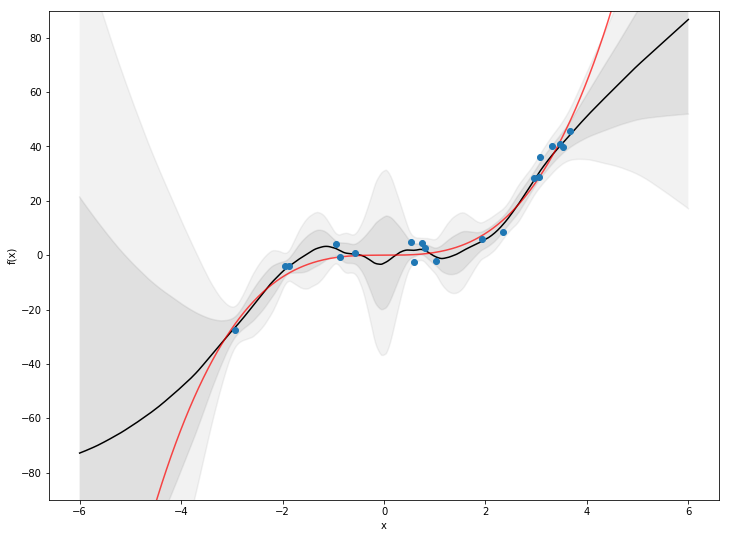

In [52]:
upper1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + np.std(predictions_ksgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_ksgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)
plt.xlabel('x')
plt.ylabel('f(x)')

### KSGFS

In [27]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs

eta = 1.
v = 0.
lambda_ = 1.
l2 = 1e-3

# learning_rates = [5e-2]
# learning_rates = [8e-3, 7e-3]
# learning_rates = [4e-2]
# learning_rates = [8e-3]
# learning_rates = [1e-3]
# learning_rates = [1e-3, 1e-4]
# learning_rates = [5e-3, 4e-3, 2e-3, 1e-3, 9e-4, 8e-4, 7e-4, 6e-4, 5e-4]
# learning_rates = [6e-2]
learning_rates = [6e-3]


batch_size = 20
dataset_size= 20

x_test = torch.FloatTensor(grid)
y_test = torch.FloatTensor(y_true)

rmse_result = np.zeros((1,len(learning_rates)))

for i,lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    predictions_ksgfs = torch.zeros(400,1)
    t = 1.

    for epoch in range(10000):

        running_loss = 0

        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = (1./(2*9))*criterion(output, y)
        loss.backward()
        optim.step()



        running_loss += loss * batch_size / dataset_size


        if (t >= 100) & (t % 100 == 0):
            with torch.autograd.no_grad():
                output = network(x_test)
                predictions_ksgfs = torch.cat((predictions_ksgfs, output), 1)

        t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    rmse_result[:,i] = torch.sqrt(criterion(y_test, torch.mean(predictions_ksgfs,1).view(-1,1)))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 617.2687
Epoch 1 - loss: 523.3157
Epoch 2 - loss: 430.5934
Epoch 3 - loss: 336.3737
Epoch 4 - loss: 249.8866
Epoch 5 - loss: 172.2121
Epoch 6 - loss: 124.8117
Epoch 7 - loss: 99.8448
Epoch 8 - loss: 83.0731
Epoch 9 - loss: 77.0917
Epoch 10 - loss: 68.6636
Epoch 11 - loss: 63.5345
Epoch 12 - loss: 61.2734
Epoch 13 - loss: 58.7007
Epoch 14 - loss: 56.7780
Epoch 15 - loss: 52.7492
Epoch 16 - loss: 49.6623
Epoch 17 - loss: 47.3905
Epoch 18 - loss: 47.8336
Epoch 19 - loss: 44.5313
Epoch 20 - loss: 42.2068
Epoch 21 - loss: 39.6044
Epoch 22 - loss: 38.1716
Epoch 23 - loss: 32.9225
Epoch 24 - loss: 31.8344
Epoch 25 - loss: 28.8461
Epoch 26 - loss: 25.7808
Epoch 27 - loss: 22.3024
Epoch 28 - loss: 22.4130
Epoch 29 - loss: 22.8161
Epoch 30 - loss: 17.8962
Epoch 31 - loss: 17.4610
Epoch 32 - loss: 20.3792
Epoch 33 - loss: 15.7215
Epoch 34 - loss: 16.1769
Epoch 35 - loss: 16.1686
Epoch 36 - loss: 17.5161
Epoch 37 - loss: 25.2621
Epoch 38 - loss: 21.3393
Epoch 39 - loss: 15.0526
Epo

Epoch 328 - loss: 10.3732
Epoch 329 - loss: 7.6798
Epoch 330 - loss: 8.4071
Epoch 331 - loss: 9.7498
Epoch 332 - loss: 8.7649
Epoch 333 - loss: 23.6150
Epoch 334 - loss: 14.0964
Epoch 335 - loss: 9.2621
Epoch 336 - loss: 10.6514
Epoch 337 - loss: 11.1625
Epoch 338 - loss: 10.4877
Epoch 339 - loss: 10.6665
Epoch 340 - loss: 8.8357
Epoch 341 - loss: 9.0269
Epoch 342 - loss: 13.1174
Epoch 343 - loss: 6.9992
Epoch 344 - loss: 7.0343
Epoch 345 - loss: 9.0794
Epoch 346 - loss: 8.1591
Epoch 347 - loss: 8.0594
Epoch 348 - loss: 8.4754
Epoch 349 - loss: 9.3188
Epoch 350 - loss: 9.3362
Epoch 351 - loss: 12.9103
Epoch 352 - loss: 8.0257
Epoch 353 - loss: 9.8427
Epoch 354 - loss: 7.9147
Epoch 355 - loss: 9.6457
Epoch 356 - loss: 12.9051
Epoch 357 - loss: 14.1189
Epoch 358 - loss: 24.5518
Epoch 359 - loss: 21.6145
Epoch 360 - loss: 30.2555
Epoch 361 - loss: 14.7296
Epoch 362 - loss: 7.0583
Epoch 363 - loss: 10.3982
Epoch 364 - loss: 6.8102
Epoch 365 - loss: 8.9153
Epoch 366 - loss: 8.0668
Epoch 367

Epoch 666 - loss: 8.2732
Epoch 667 - loss: 7.8440
Epoch 668 - loss: 7.9981
Epoch 669 - loss: 6.9654
Epoch 670 - loss: 10.2808
Epoch 671 - loss: 16.3264
Epoch 672 - loss: 10.7034
Epoch 673 - loss: 20.3572
Epoch 674 - loss: 10.9124
Epoch 675 - loss: 8.2826
Epoch 676 - loss: 7.0915
Epoch 677 - loss: 7.4989
Epoch 678 - loss: 10.9036
Epoch 679 - loss: 6.7913
Epoch 680 - loss: 8.7011
Epoch 681 - loss: 7.5965
Epoch 682 - loss: 6.9574
Epoch 683 - loss: 9.3554
Epoch 684 - loss: 6.5771
Epoch 685 - loss: 7.7742
Epoch 686 - loss: 8.4507
Epoch 687 - loss: 12.8901
Epoch 688 - loss: 12.2843
Epoch 689 - loss: 13.5351
Epoch 690 - loss: 7.1121
Epoch 691 - loss: 7.0402
Epoch 692 - loss: 6.4090
Epoch 693 - loss: 9.1080
Epoch 694 - loss: 8.7506
Epoch 695 - loss: 10.6448
Epoch 696 - loss: 13.5015
Epoch 697 - loss: 17.2862
Epoch 698 - loss: 15.0790
Epoch 699 - loss: 9.8634
Epoch 700 - loss: 9.8581
Epoch 701 - loss: 9.2906
Epoch 702 - loss: 12.8218
Epoch 703 - loss: 11.3381
Epoch 704 - loss: 11.7934
Epoch 705

Epoch 1008 - loss: 11.0598
Epoch 1009 - loss: 7.6314
Epoch 1010 - loss: 12.6531
Epoch 1011 - loss: 7.3032
Epoch 1012 - loss: 6.1055
Epoch 1013 - loss: 6.3774
Epoch 1014 - loss: 9.4593
Epoch 1015 - loss: 15.2611
Epoch 1016 - loss: 17.3357
Epoch 1017 - loss: 10.5833
Epoch 1018 - loss: 9.1985
Epoch 1019 - loss: 15.3790
Epoch 1020 - loss: 14.2392
Epoch 1021 - loss: 11.1395
Epoch 1022 - loss: 11.5456
Epoch 1023 - loss: 7.4922
Epoch 1024 - loss: 10.9179
Epoch 1025 - loss: 8.7573
Epoch 1026 - loss: 7.2715
Epoch 1027 - loss: 7.0894
Epoch 1028 - loss: 7.1975
Epoch 1029 - loss: 7.5340
Epoch 1030 - loss: 9.1475
Epoch 1031 - loss: 9.0665
Epoch 1032 - loss: 8.7896
Epoch 1033 - loss: 10.7247
Epoch 1034 - loss: 15.0982
Epoch 1035 - loss: 17.2934
Epoch 1036 - loss: 59.8647
Epoch 1037 - loss: 34.7958
Epoch 1038 - loss: 22.4610
Epoch 1039 - loss: 6.9183
Epoch 1040 - loss: 8.1617
Epoch 1041 - loss: 6.5958
Epoch 1042 - loss: 11.9272
Epoch 1043 - loss: 45.2570
Epoch 1044 - loss: 39.4306
Epoch 1045 - loss: 

Epoch 1328 - loss: 12.9635
Epoch 1329 - loss: 14.2637
Epoch 1330 - loss: 17.1615
Epoch 1331 - loss: 15.0843
Epoch 1332 - loss: 20.0541
Epoch 1333 - loss: 7.8903
Epoch 1334 - loss: 6.6760
Epoch 1335 - loss: 10.6784
Epoch 1336 - loss: 12.2584
Epoch 1337 - loss: 8.0006
Epoch 1338 - loss: 7.6948
Epoch 1339 - loss: 17.1765
Epoch 1340 - loss: 10.6710
Epoch 1341 - loss: 9.7117
Epoch 1342 - loss: 12.2922
Epoch 1343 - loss: 14.3849
Epoch 1344 - loss: 22.6772
Epoch 1345 - loss: 15.4434
Epoch 1346 - loss: 81.2935
Epoch 1347 - loss: 44.3716
Epoch 1348 - loss: 18.1242
Epoch 1349 - loss: 29.7903
Epoch 1350 - loss: 41.1025
Epoch 1351 - loss: 105.4968
Epoch 1352 - loss: 17.2254
Epoch 1353 - loss: 16.9982
Epoch 1354 - loss: 13.5677
Epoch 1355 - loss: 8.2298
Epoch 1356 - loss: 8.5219
Epoch 1357 - loss: 6.6931
Epoch 1358 - loss: 11.5302
Epoch 1359 - loss: 19.2429
Epoch 1360 - loss: 19.2648
Epoch 1361 - loss: 13.2286
Epoch 1362 - loss: 7.7786
Epoch 1363 - loss: 17.7241
Epoch 1364 - loss: 143.6359
Epoch 13

Epoch 1636 - loss: 7.3960
Epoch 1637 - loss: 9.5236
Epoch 1638 - loss: 8.0736
Epoch 1639 - loss: 19.7545
Epoch 1640 - loss: 17.0758
Epoch 1641 - loss: 8.8975
Epoch 1642 - loss: 7.3901
Epoch 1643 - loss: 10.5035
Epoch 1644 - loss: 9.1920
Epoch 1645 - loss: 10.2058
Epoch 1646 - loss: 9.7737
Epoch 1647 - loss: 10.5649
Epoch 1648 - loss: 15.1824
Epoch 1649 - loss: 8.3255
Epoch 1650 - loss: 8.9023
Epoch 1651 - loss: 10.7050
Epoch 1652 - loss: 14.4693
Epoch 1653 - loss: 6.0908
Epoch 1654 - loss: 8.1182
Epoch 1655 - loss: 7.1112
Epoch 1656 - loss: 11.2628
Epoch 1657 - loss: 13.4510
Epoch 1658 - loss: 8.1652
Epoch 1659 - loss: 20.0531
Epoch 1660 - loss: 7.4051
Epoch 1661 - loss: 9.7689
Epoch 1662 - loss: 13.5759
Epoch 1663 - loss: 9.1009
Epoch 1664 - loss: 7.9910
Epoch 1665 - loss: 8.5691
Epoch 1666 - loss: 7.9390
Epoch 1667 - loss: 10.7576
Epoch 1668 - loss: 9.9993
Epoch 1669 - loss: 10.6460
Epoch 1670 - loss: 19.9076
Epoch 1671 - loss: 8.3262
Epoch 1672 - loss: 14.5144
Epoch 1673 - loss: 7.0

Epoch 1960 - loss: 25.7006
Epoch 1961 - loss: 9.5978
Epoch 1962 - loss: 11.2035
Epoch 1963 - loss: 8.2195
Epoch 1964 - loss: 8.2158
Epoch 1965 - loss: 7.6302
Epoch 1966 - loss: 7.0628
Epoch 1967 - loss: 8.4118
Epoch 1968 - loss: 8.0207
Epoch 1969 - loss: 9.3526
Epoch 1970 - loss: 17.8920
Epoch 1971 - loss: 20.0494
Epoch 1972 - loss: 6.9491
Epoch 1973 - loss: 9.0708
Epoch 1974 - loss: 25.9917
Epoch 1975 - loss: 25.4222
Epoch 1976 - loss: 62.4038
Epoch 1977 - loss: 169.1910
Epoch 1978 - loss: 154.3238
Epoch 1979 - loss: 140.7215
Epoch 1980 - loss: 645.3529
Epoch 1981 - loss: 19.4775
Epoch 1982 - loss: 17.2423
Epoch 1983 - loss: 15.6355
Epoch 1984 - loss: 8.4420
Epoch 1985 - loss: 12.1972
Epoch 1986 - loss: 26.6812
Epoch 1987 - loss: 31.6004
Epoch 1988 - loss: 16.2041
Epoch 1989 - loss: 15.5169
Epoch 1990 - loss: 18.2830
Epoch 1991 - loss: 10.4902
Epoch 1992 - loss: 8.6871
Epoch 1993 - loss: 10.4432
Epoch 1994 - loss: 8.2110
Epoch 1995 - loss: 7.3246
Epoch 1996 - loss: 7.4640
Epoch 1997 -

Epoch 2266 - loss: 12.3324
Epoch 2267 - loss: 10.2781
Epoch 2268 - loss: 9.1029
Epoch 2269 - loss: 11.2559
Epoch 2270 - loss: 13.1919
Epoch 2271 - loss: 10.4895
Epoch 2272 - loss: 9.6423
Epoch 2273 - loss: 9.3298
Epoch 2274 - loss: 8.6458
Epoch 2275 - loss: 11.5098
Epoch 2276 - loss: 13.8075
Epoch 2277 - loss: 10.6304
Epoch 2278 - loss: 11.2374
Epoch 2279 - loss: 13.8022
Epoch 2280 - loss: 14.8788
Epoch 2281 - loss: 9.0601
Epoch 2282 - loss: 11.2163
Epoch 2283 - loss: 11.0507
Epoch 2284 - loss: 8.2855
Epoch 2285 - loss: 9.9289
Epoch 2286 - loss: 14.2307
Epoch 2287 - loss: 14.9005
Epoch 2288 - loss: 8.9307
Epoch 2289 - loss: 9.6666
Epoch 2290 - loss: 9.3339
Epoch 2291 - loss: 12.2261
Epoch 2292 - loss: 8.8355
Epoch 2293 - loss: 12.6685
Epoch 2294 - loss: 8.6093
Epoch 2295 - loss: 9.0959
Epoch 2296 - loss: 7.6692
Epoch 2297 - loss: 7.9055
Epoch 2298 - loss: 8.7987
Epoch 2299 - loss: 7.9834
Epoch 2300 - loss: 10.6546
Epoch 2301 - loss: 10.6823
Epoch 2302 - loss: 12.7007
Epoch 2303 - loss:

Epoch 2577 - loss: 11.8408
Epoch 2578 - loss: 26.7569
Epoch 2579 - loss: 27.7894
Epoch 2580 - loss: 44.1033
Epoch 2581 - loss: 57.8990
Epoch 2582 - loss: 46.9683
Epoch 2583 - loss: 59.4913
Epoch 2584 - loss: 47.9636
Epoch 2585 - loss: 11.1701
Epoch 2586 - loss: 24.5826
Epoch 2587 - loss: 18.2502
Epoch 2588 - loss: 24.4978
Epoch 2589 - loss: 12.3578
Epoch 2590 - loss: 33.4587
Epoch 2591 - loss: 111.0080
Epoch 2592 - loss: 71.6420
Epoch 2593 - loss: 296.8335
Epoch 2594 - loss: 941.2362
Epoch 2595 - loss: 258.4007
Epoch 2596 - loss: 123.3895
Epoch 2597 - loss: 37.2743
Epoch 2598 - loss: 34.1183
Epoch 2599 - loss: 14.2280
Epoch 2600 - loss: 10.5863
Epoch 2601 - loss: 10.6445
Epoch 2602 - loss: 12.7040
Epoch 2603 - loss: 30.8591
Epoch 2604 - loss: 26.5744
Epoch 2605 - loss: 26.2734
Epoch 2606 - loss: 20.1875
Epoch 2607 - loss: 39.5635
Epoch 2608 - loss: 19.1226
Epoch 2609 - loss: 255.1573
Epoch 2610 - loss: 579.5640
Epoch 2611 - loss: 65.2459
Epoch 2612 - loss: 82.4093
Epoch 2613 - loss: 78

Epoch 2893 - loss: 8.2718
Epoch 2894 - loss: 7.7797
Epoch 2895 - loss: 8.2341
Epoch 2896 - loss: 7.9221
Epoch 2897 - loss: 10.1567
Epoch 2898 - loss: 13.4045
Epoch 2899 - loss: 8.1912
Epoch 2900 - loss: 13.6169
Epoch 2901 - loss: 11.8048
Epoch 2902 - loss: 6.6100
Epoch 2903 - loss: 7.4855
Epoch 2904 - loss: 8.5660
Epoch 2905 - loss: 7.1370
Epoch 2906 - loss: 7.5426
Epoch 2907 - loss: 7.1884
Epoch 2908 - loss: 8.3124
Epoch 2909 - loss: 12.3815
Epoch 2910 - loss: 23.8391
Epoch 2911 - loss: 14.6184
Epoch 2912 - loss: 9.5463
Epoch 2913 - loss: 7.9110
Epoch 2914 - loss: 6.7714
Epoch 2915 - loss: 6.8692
Epoch 2916 - loss: 7.6014
Epoch 2917 - loss: 16.1919
Epoch 2918 - loss: 10.7502
Epoch 2919 - loss: 30.2341
Epoch 2920 - loss: 108.6457
Epoch 2921 - loss: 11.0398
Epoch 2922 - loss: 11.6893
Epoch 2923 - loss: 9.9245
Epoch 2924 - loss: 7.2038
Epoch 2925 - loss: 7.8447
Epoch 2926 - loss: 12.4572
Epoch 2927 - loss: 10.7227
Epoch 2928 - loss: 7.5283
Epoch 2929 - loss: 7.6711
Epoch 2930 - loss: 7.8

Epoch 3213 - loss: 7.6440
Epoch 3214 - loss: 7.7219
Epoch 3215 - loss: 8.3905
Epoch 3216 - loss: 7.4966
Epoch 3217 - loss: 7.9857
Epoch 3218 - loss: 7.7719
Epoch 3219 - loss: 10.7870
Epoch 3220 - loss: 11.3000
Epoch 3221 - loss: 21.2060
Epoch 3222 - loss: 13.5025
Epoch 3223 - loss: 20.6941
Epoch 3224 - loss: 6.3105
Epoch 3225 - loss: 7.7466
Epoch 3226 - loss: 7.1490
Epoch 3227 - loss: 17.5723
Epoch 3228 - loss: 34.3570
Epoch 3229 - loss: 34.8539
Epoch 3230 - loss: 20.7232
Epoch 3231 - loss: 13.1776
Epoch 3232 - loss: 10.2498
Epoch 3233 - loss: 8.2340
Epoch 3234 - loss: 8.0931
Epoch 3235 - loss: 7.0742
Epoch 3236 - loss: 7.7161
Epoch 3237 - loss: 25.1192
Epoch 3238 - loss: 37.2959
Epoch 3239 - loss: 51.0736
Epoch 3240 - loss: 281.1720
Epoch 3241 - loss: 32.2463
Epoch 3242 - loss: 58.1317
Epoch 3243 - loss: 27.3092
Epoch 3244 - loss: 62.7326
Epoch 3245 - loss: 104.0480
Epoch 3246 - loss: 54.8900
Epoch 3247 - loss: 86.4972
Epoch 3248 - loss: 7.5848
Epoch 3249 - loss: 9.6451
Epoch 3250 - l

Epoch 3526 - loss: 14.5466
Epoch 3527 - loss: 6.8510
Epoch 3528 - loss: 8.2597
Epoch 3529 - loss: 7.6908
Epoch 3530 - loss: 7.0893
Epoch 3531 - loss: 7.7309
Epoch 3532 - loss: 15.5108
Epoch 3533 - loss: 94.1730
Epoch 3534 - loss: 43.1788
Epoch 3535 - loss: 40.0679
Epoch 3536 - loss: 12.7984
Epoch 3537 - loss: 19.7185
Epoch 3538 - loss: 22.6049
Epoch 3539 - loss: 32.7480
Epoch 3540 - loss: 13.2214
Epoch 3541 - loss: 15.9327
Epoch 3542 - loss: 14.9831
Epoch 3543 - loss: 27.6871
Epoch 3544 - loss: 20.9729
Epoch 3545 - loss: 20.4517
Epoch 3546 - loss: 28.7490
Epoch 3547 - loss: 9.1161
Epoch 3548 - loss: 10.7816
Epoch 3549 - loss: 12.2476
Epoch 3550 - loss: 8.2498
Epoch 3551 - loss: 7.6577
Epoch 3552 - loss: 7.3678
Epoch 3553 - loss: 7.8658
Epoch 3554 - loss: 7.4452
Epoch 3555 - loss: 6.7051
Epoch 3556 - loss: 7.4552
Epoch 3557 - loss: 7.0515
Epoch 3558 - loss: 8.9548
Epoch 3559 - loss: 8.4790
Epoch 3560 - loss: 7.7054
Epoch 3561 - loss: 14.2706
Epoch 3562 - loss: 25.2329
Epoch 3563 - loss:

Epoch 3845 - loss: 9.4839
Epoch 3846 - loss: 7.1969
Epoch 3847 - loss: 9.8711
Epoch 3848 - loss: 8.4677
Epoch 3849 - loss: 7.9898
Epoch 3850 - loss: 7.1654
Epoch 3851 - loss: 7.2695
Epoch 3852 - loss: 7.6698
Epoch 3853 - loss: 7.8120
Epoch 3854 - loss: 6.9075
Epoch 3855 - loss: 7.1052
Epoch 3856 - loss: 7.5737
Epoch 3857 - loss: 8.2409
Epoch 3858 - loss: 10.8336
Epoch 3859 - loss: 7.3707
Epoch 3860 - loss: 8.2631
Epoch 3861 - loss: 9.8946
Epoch 3862 - loss: 8.5037
Epoch 3863 - loss: 17.5114
Epoch 3864 - loss: 114.2212
Epoch 3865 - loss: 31.2070
Epoch 3866 - loss: 9.4409
Epoch 3867 - loss: 10.8053
Epoch 3868 - loss: 11.6543
Epoch 3869 - loss: 10.5316
Epoch 3870 - loss: 31.2188
Epoch 3871 - loss: 15.3405
Epoch 3872 - loss: 32.6911
Epoch 3873 - loss: 28.7726
Epoch 3874 - loss: 20.5547
Epoch 3875 - loss: 6.7580
Epoch 3876 - loss: 7.1619
Epoch 3877 - loss: 10.5905
Epoch 3878 - loss: 10.9099
Epoch 3879 - loss: 7.4110
Epoch 3880 - loss: 7.6631
Epoch 3881 - loss: 9.0877
Epoch 3882 - loss: 8.74

Epoch 4154 - loss: 7.2015
Epoch 4155 - loss: 6.9912
Epoch 4156 - loss: 7.7341
Epoch 4157 - loss: 9.7053
Epoch 4158 - loss: 7.0261
Epoch 4159 - loss: 7.7758
Epoch 4160 - loss: 9.1976
Epoch 4161 - loss: 7.7182
Epoch 4162 - loss: 6.7516
Epoch 4163 - loss: 7.5488
Epoch 4164 - loss: 6.9670
Epoch 4165 - loss: 8.0116
Epoch 4166 - loss: 8.7432
Epoch 4167 - loss: 6.4530
Epoch 4168 - loss: 6.8589
Epoch 4169 - loss: 7.8381
Epoch 4170 - loss: 7.3827
Epoch 4171 - loss: 6.4906
Epoch 4172 - loss: 7.3728
Epoch 4173 - loss: 7.3138
Epoch 4174 - loss: 8.3500
Epoch 4175 - loss: 7.4794
Epoch 4176 - loss: 7.8556
Epoch 4177 - loss: 6.6381
Epoch 4178 - loss: 6.4948
Epoch 4179 - loss: 7.0840
Epoch 4180 - loss: 7.9239
Epoch 4181 - loss: 7.1751
Epoch 4182 - loss: 8.5838
Epoch 4183 - loss: 6.6880
Epoch 4184 - loss: 7.3003
Epoch 4185 - loss: 16.0097
Epoch 4186 - loss: 61.1188
Epoch 4187 - loss: 103.8096
Epoch 4188 - loss: 52.9577
Epoch 4189 - loss: 22.3596
Epoch 4190 - loss: 8.9172
Epoch 4191 - loss: 12.4050
Epoch

Epoch 4465 - loss: 23.0621
Epoch 4466 - loss: 165.4298
Epoch 4467 - loss: 57.1522
Epoch 4468 - loss: 400.1491
Epoch 4469 - loss: 357.6698
Epoch 4470 - loss: 211.6668
Epoch 4471 - loss: 83.8677
Epoch 4472 - loss: 53.8516
Epoch 4473 - loss: 33.8593
Epoch 4474 - loss: 25.4167
Epoch 4475 - loss: 20.3788
Epoch 4476 - loss: 13.6397
Epoch 4477 - loss: 15.2748
Epoch 4478 - loss: 20.0283
Epoch 4479 - loss: 50.0664
Epoch 4480 - loss: 19.3769
Epoch 4481 - loss: 20.2520
Epoch 4482 - loss: 31.0118
Epoch 4483 - loss: 36.1694
Epoch 4484 - loss: 15.3982
Epoch 4485 - loss: 16.6463
Epoch 4486 - loss: 31.0880
Epoch 4487 - loss: 125.8254
Epoch 4488 - loss: 16.6122
Epoch 4489 - loss: 13.2061
Epoch 4490 - loss: 29.7288
Epoch 4491 - loss: 42.4355
Epoch 4492 - loss: 162.1706
Epoch 4493 - loss: 98.4621
Epoch 4494 - loss: 205.1131
Epoch 4495 - loss: 38.1172
Epoch 4496 - loss: 13.6619
Epoch 4497 - loss: 17.2380
Epoch 4498 - loss: 19.6947
Epoch 4499 - loss: 19.1958
Epoch 4500 - loss: 12.0361
Epoch 4501 - loss: 33

Epoch 4787 - loss: 29.1640
Epoch 4788 - loss: 24.0890
Epoch 4789 - loss: 8.4486
Epoch 4790 - loss: 17.2794
Epoch 4791 - loss: 8.4374
Epoch 4792 - loss: 13.4297
Epoch 4793 - loss: 9.0110
Epoch 4794 - loss: 9.7850
Epoch 4795 - loss: 8.3297
Epoch 4796 - loss: 8.1807
Epoch 4797 - loss: 7.4311
Epoch 4798 - loss: 7.9072
Epoch 4799 - loss: 9.6286
Epoch 4800 - loss: 7.2748
Epoch 4801 - loss: 6.9196
Epoch 4802 - loss: 7.2073
Epoch 4803 - loss: 13.2420
Epoch 4804 - loss: 14.7414
Epoch 4805 - loss: 6.3732
Epoch 4806 - loss: 8.1789
Epoch 4807 - loss: 7.8870
Epoch 4808 - loss: 7.9567
Epoch 4809 - loss: 6.5915
Epoch 4810 - loss: 9.6942
Epoch 4811 - loss: 7.9681
Epoch 4812 - loss: 18.1064
Epoch 4813 - loss: 154.5692
Epoch 4814 - loss: 41.5253
Epoch 4815 - loss: 24.8503
Epoch 4816 - loss: 27.6598
Epoch 4817 - loss: 23.4468
Epoch 4818 - loss: 10.0282
Epoch 4819 - loss: 9.3747
Epoch 4820 - loss: 12.5867
Epoch 4821 - loss: 14.6255
Epoch 4822 - loss: 13.2063
Epoch 4823 - loss: 8.7425
Epoch 4824 - loss: 8.

Epoch 5098 - loss: 13.6644
Epoch 5099 - loss: 54.5438
Epoch 5100 - loss: 7.2126
Epoch 5101 - loss: 9.4459
Epoch 5102 - loss: 11.7408
Epoch 5103 - loss: 12.3467
Epoch 5104 - loss: 8.4467
Epoch 5105 - loss: 9.7212
Epoch 5106 - loss: 13.2679
Epoch 5107 - loss: 6.9937
Epoch 5108 - loss: 8.1090
Epoch 5109 - loss: 22.7619
Epoch 5110 - loss: 11.0675
Epoch 5111 - loss: 15.9032
Epoch 5112 - loss: 7.1484
Epoch 5113 - loss: 7.1782
Epoch 5114 - loss: 21.0311
Epoch 5115 - loss: 45.6047
Epoch 5116 - loss: 14.2863
Epoch 5117 - loss: 8.5658
Epoch 5118 - loss: 15.8515
Epoch 5119 - loss: 11.4894
Epoch 5120 - loss: 6.8233
Epoch 5121 - loss: 7.0932
Epoch 5122 - loss: 7.2840
Epoch 5123 - loss: 9.0862
Epoch 5124 - loss: 13.9326
Epoch 5125 - loss: 12.2588
Epoch 5126 - loss: 7.1644
Epoch 5127 - loss: 9.5468
Epoch 5128 - loss: 9.3565
Epoch 5129 - loss: 7.5598
Epoch 5130 - loss: 7.5729
Epoch 5131 - loss: 7.7902
Epoch 5132 - loss: 14.4519
Epoch 5133 - loss: 7.7661
Epoch 5134 - loss: 9.9998
Epoch 5135 - loss: 9.1

Epoch 5416 - loss: 6.5406
Epoch 5417 - loss: 7.5356
Epoch 5418 - loss: 12.2656
Epoch 5419 - loss: 16.5260
Epoch 5420 - loss: 8.2721
Epoch 5421 - loss: 6.5941
Epoch 5422 - loss: 6.6256
Epoch 5423 - loss: 6.4597
Epoch 5424 - loss: 6.8681
Epoch 5425 - loss: 6.4064
Epoch 5426 - loss: 6.4550
Epoch 5427 - loss: 9.4415
Epoch 5428 - loss: 17.2713
Epoch 5429 - loss: 12.3134
Epoch 5430 - loss: 8.8973
Epoch 5431 - loss: 6.8842
Epoch 5432 - loss: 6.7172
Epoch 5433 - loss: 7.5818
Epoch 5434 - loss: 24.0569
Epoch 5435 - loss: 12.3399
Epoch 5436 - loss: 7.7136
Epoch 5437 - loss: 18.3166
Epoch 5438 - loss: 7.2692
Epoch 5439 - loss: 8.0670
Epoch 5440 - loss: 7.0697
Epoch 5441 - loss: 7.7480
Epoch 5442 - loss: 19.8656
Epoch 5443 - loss: 12.5458
Epoch 5444 - loss: 6.5235
Epoch 5445 - loss: 8.9755
Epoch 5446 - loss: 9.0804
Epoch 5447 - loss: 13.7152
Epoch 5448 - loss: 7.9196
Epoch 5449 - loss: 7.8014
Epoch 5450 - loss: 7.7421
Epoch 5451 - loss: 8.6143
Epoch 5452 - loss: 8.7445
Epoch 5453 - loss: 9.1148
Ep

Epoch 5725 - loss: 17.6349
Epoch 5726 - loss: 20.3974
Epoch 5727 - loss: 22.9349
Epoch 5728 - loss: 21.8049
Epoch 5729 - loss: 41.0838
Epoch 5730 - loss: 28.2004
Epoch 5731 - loss: 92.6778
Epoch 5732 - loss: 23.5891
Epoch 5733 - loss: 62.7182
Epoch 5734 - loss: 58.3674
Epoch 5735 - loss: 34.9700
Epoch 5736 - loss: 14.2534
Epoch 5737 - loss: 13.2606
Epoch 5738 - loss: 14.2352
Epoch 5739 - loss: 14.9413
Epoch 5740 - loss: 15.8947
Epoch 5741 - loss: 23.4673
Epoch 5742 - loss: 14.6895
Epoch 5743 - loss: 14.0584
Epoch 5744 - loss: 18.2458
Epoch 5745 - loss: 17.4995
Epoch 5746 - loss: 22.8757
Epoch 5747 - loss: 141.3096
Epoch 5748 - loss: 127.6357
Epoch 5749 - loss: 22.1663
Epoch 5750 - loss: 18.4118
Epoch 5751 - loss: 32.2677
Epoch 5752 - loss: 56.4636
Epoch 5753 - loss: 21.8156
Epoch 5754 - loss: 43.4454
Epoch 5755 - loss: 16.0997
Epoch 5756 - loss: 13.6391
Epoch 5757 - loss: 13.8610
Epoch 5758 - loss: 14.3040
Epoch 5759 - loss: 11.8250
Epoch 5760 - loss: 11.9540
Epoch 5761 - loss: 18.4705

Epoch 6041 - loss: 22.0045
Epoch 6042 - loss: 16.7889
Epoch 6043 - loss: 12.1939
Epoch 6044 - loss: 10.2434
Epoch 6045 - loss: 9.8865
Epoch 6046 - loss: 10.5560
Epoch 6047 - loss: 21.7677
Epoch 6048 - loss: 22.9457
Epoch 6049 - loss: 28.8975
Epoch 6050 - loss: 12.3060
Epoch 6051 - loss: 9.9282
Epoch 6052 - loss: 7.8223
Epoch 6053 - loss: 8.2884
Epoch 6054 - loss: 7.7395
Epoch 6055 - loss: 8.1432
Epoch 6056 - loss: 12.7991
Epoch 6057 - loss: 10.2189
Epoch 6058 - loss: 8.6726
Epoch 6059 - loss: 11.3772
Epoch 6060 - loss: 9.3779
Epoch 6061 - loss: 12.3942
Epoch 6062 - loss: 17.1500
Epoch 6063 - loss: 9.4068
Epoch 6064 - loss: 20.0855
Epoch 6065 - loss: 9.6303
Epoch 6066 - loss: 15.4834
Epoch 6067 - loss: 13.5800
Epoch 6068 - loss: 16.6536
Epoch 6069 - loss: 14.7800
Epoch 6070 - loss: 13.5695
Epoch 6071 - loss: 23.3229
Epoch 6072 - loss: 8.5539
Epoch 6073 - loss: 8.0797
Epoch 6074 - loss: 7.5811
Epoch 6075 - loss: 8.1813
Epoch 6076 - loss: 7.8999
Epoch 6077 - loss: 8.1504
Epoch 6078 - loss

Epoch 6352 - loss: 9.3029
Epoch 6353 - loss: 10.9979
Epoch 6354 - loss: 10.0085
Epoch 6355 - loss: 9.1546
Epoch 6356 - loss: 9.1769
Epoch 6357 - loss: 9.1428
Epoch 6358 - loss: 9.4530
Epoch 6359 - loss: 10.1393
Epoch 6360 - loss: 12.4533
Epoch 6361 - loss: 11.4565
Epoch 6362 - loss: 13.6595
Epoch 6363 - loss: 9.2220
Epoch 6364 - loss: 9.3407
Epoch 6365 - loss: 10.8459
Epoch 6366 - loss: 13.0620
Epoch 6367 - loss: 12.1025
Epoch 6368 - loss: 15.0559
Epoch 6369 - loss: 18.7973
Epoch 6370 - loss: 16.8302
Epoch 6371 - loss: 17.4529
Epoch 6372 - loss: 15.1275
Epoch 6373 - loss: 17.2511
Epoch 6374 - loss: 22.5161
Epoch 6375 - loss: 18.5548
Epoch 6376 - loss: 38.0010
Epoch 6377 - loss: 43.5337
Epoch 6378 - loss: 24.5965
Epoch 6379 - loss: 11.1455
Epoch 6380 - loss: 13.7222
Epoch 6381 - loss: 10.4795
Epoch 6382 - loss: 14.4851
Epoch 6383 - loss: 39.4770
Epoch 6384 - loss: 16.8392
Epoch 6385 - loss: 10.5548
Epoch 6386 - loss: 9.6403
Epoch 6387 - loss: 8.5594
Epoch 6388 - loss: 9.0959
Epoch 6389 

Epoch 6665 - loss: 16.1377
Epoch 6666 - loss: 10.9354
Epoch 6667 - loss: 7.5749
Epoch 6668 - loss: 6.6747
Epoch 6669 - loss: 7.5888
Epoch 6670 - loss: 15.2093
Epoch 6671 - loss: 19.7721
Epoch 6672 - loss: 18.9446
Epoch 6673 - loss: 9.4304
Epoch 6674 - loss: 7.4828
Epoch 6675 - loss: 7.2987
Epoch 6676 - loss: 7.7160
Epoch 6677 - loss: 8.2807
Epoch 6678 - loss: 8.1024
Epoch 6679 - loss: 9.2755
Epoch 6680 - loss: 7.5740
Epoch 6681 - loss: 7.1772
Epoch 6682 - loss: 7.1015
Epoch 6683 - loss: 7.0149
Epoch 6684 - loss: 10.8759
Epoch 6685 - loss: 9.4060
Epoch 6686 - loss: 11.8839
Epoch 6687 - loss: 7.9771
Epoch 6688 - loss: 7.5136
Epoch 6689 - loss: 7.1064
Epoch 6690 - loss: 6.4929
Epoch 6691 - loss: 6.4371
Epoch 6692 - loss: 24.3389
Epoch 6693 - loss: 7.7220
Epoch 6694 - loss: 9.7151
Epoch 6695 - loss: 13.8316
Epoch 6696 - loss: 89.4684
Epoch 6697 - loss: 29.9890
Epoch 6698 - loss: 17.2822
Epoch 6699 - loss: 16.7459
Epoch 6700 - loss: 7.1054
Epoch 6701 - loss: 8.0888
Epoch 6702 - loss: 13.467

Epoch 6987 - loss: 9.1422
Epoch 6988 - loss: 9.9144
Epoch 6989 - loss: 9.0957
Epoch 6990 - loss: 9.7935
Epoch 6991 - loss: 9.8022
Epoch 6992 - loss: 11.9397
Epoch 6993 - loss: 10.8775
Epoch 6994 - loss: 20.7027
Epoch 6995 - loss: 13.9282
Epoch 6996 - loss: 9.0203
Epoch 6997 - loss: 9.7365
Epoch 6998 - loss: 10.0060
Epoch 6999 - loss: 10.4331
Epoch 7000 - loss: 8.1901
Epoch 7001 - loss: 8.4357
Epoch 7002 - loss: 8.7332
Epoch 7003 - loss: 8.8518
Epoch 7004 - loss: 9.5034
Epoch 7005 - loss: 20.6915
Epoch 7006 - loss: 12.8703
Epoch 7007 - loss: 11.8728
Epoch 7008 - loss: 12.7462
Epoch 7009 - loss: 25.6255
Epoch 7010 - loss: 9.4144
Epoch 7011 - loss: 10.1753
Epoch 7012 - loss: 26.3002
Epoch 7013 - loss: 9.0726
Epoch 7014 - loss: 9.5523
Epoch 7015 - loss: 9.1091
Epoch 7016 - loss: 11.5821
Epoch 7017 - loss: 12.6157
Epoch 7018 - loss: 9.7409
Epoch 7019 - loss: 9.8540
Epoch 7020 - loss: 8.4609
Epoch 7021 - loss: 9.7340
Epoch 7022 - loss: 8.7207
Epoch 7023 - loss: 9.4216
Epoch 7024 - loss: 15.5

Epoch 7309 - loss: 20.6735
Epoch 7310 - loss: 10.6518
Epoch 7311 - loss: 10.6141
Epoch 7312 - loss: 50.5762
Epoch 7313 - loss: 35.2568
Epoch 7314 - loss: 9.8856
Epoch 7315 - loss: 47.3460
Epoch 7316 - loss: 70.7744
Epoch 7317 - loss: 297.3951
Epoch 7318 - loss: 481.3984
Epoch 7319 - loss: 106.9418
Epoch 7320 - loss: 7.9713
Epoch 7321 - loss: 7.5568
Epoch 7322 - loss: 14.9492
Epoch 7323 - loss: 10.6292
Epoch 7324 - loss: 24.3586
Epoch 7325 - loss: 168.9749
Epoch 7326 - loss: 795.0941
Epoch 7327 - loss: 141.7353
Epoch 7328 - loss: 64.5851
Epoch 7329 - loss: 36.5222
Epoch 7330 - loss: 29.6293
Epoch 7331 - loss: 23.3888
Epoch 7332 - loss: 21.3897
Epoch 7333 - loss: 29.3239
Epoch 7334 - loss: 53.8480
Epoch 7335 - loss: 12.0550
Epoch 7336 - loss: 11.3786
Epoch 7337 - loss: 13.6777
Epoch 7338 - loss: 11.3011
Epoch 7339 - loss: 10.3780
Epoch 7340 - loss: 11.5077
Epoch 7341 - loss: 13.6271
Epoch 7342 - loss: 8.7153
Epoch 7343 - loss: 8.2862
Epoch 7344 - loss: 8.7418
Epoch 7345 - loss: 7.8829
Ep

Epoch 7622 - loss: 33.0064
Epoch 7623 - loss: 25.1590
Epoch 7624 - loss: 8.8067
Epoch 7625 - loss: 9.5759
Epoch 7626 - loss: 15.5710
Epoch 7627 - loss: 25.3952
Epoch 7628 - loss: 42.5257
Epoch 7629 - loss: 31.0778
Epoch 7630 - loss: 20.1732
Epoch 7631 - loss: 297.5388
Epoch 7632 - loss: 128.3440
Epoch 7633 - loss: 69.3074
Epoch 7634 - loss: 482.1127
Epoch 7635 - loss: 20.5642
Epoch 7636 - loss: 22.9589
Epoch 7637 - loss: 26.7416
Epoch 7638 - loss: 16.0817
Epoch 7639 - loss: 14.9538
Epoch 7640 - loss: 13.2428
Epoch 7641 - loss: 9.7863
Epoch 7642 - loss: 11.1570
Epoch 7643 - loss: 9.9158
Epoch 7644 - loss: 9.0100
Epoch 7645 - loss: 11.4625
Epoch 7646 - loss: 12.1623
Epoch 7647 - loss: 14.6590
Epoch 7648 - loss: 28.6840
Epoch 7649 - loss: 66.0561
Epoch 7650 - loss: 15.4214
Epoch 7651 - loss: 9.6452
Epoch 7652 - loss: 11.5973
Epoch 7653 - loss: 20.5263
Epoch 7654 - loss: 21.5414
Epoch 7655 - loss: 23.2954
Epoch 7656 - loss: 11.1220
Epoch 7657 - loss: 8.3808
Epoch 7658 - loss: 8.5466
Epoch 

Epoch 7933 - loss: 10.3720
Epoch 7934 - loss: 9.3548
Epoch 7935 - loss: 15.5603
Epoch 7936 - loss: 11.1300
Epoch 7937 - loss: 9.1316
Epoch 7938 - loss: 14.7836
Epoch 7939 - loss: 10.3975
Epoch 7940 - loss: 10.0904
Epoch 7941 - loss: 9.2619
Epoch 7942 - loss: 8.9467
Epoch 7943 - loss: 8.1027
Epoch 7944 - loss: 8.4283
Epoch 7945 - loss: 8.2604
Epoch 7946 - loss: 7.9098
Epoch 7947 - loss: 9.0927
Epoch 7948 - loss: 8.8298
Epoch 7949 - loss: 13.1285
Epoch 7950 - loss: 14.6565
Epoch 7951 - loss: 13.5324
Epoch 7952 - loss: 8.6393
Epoch 7953 - loss: 9.3948
Epoch 7954 - loss: 18.3866
Epoch 7955 - loss: 22.8163
Epoch 7956 - loss: 104.2087
Epoch 7957 - loss: 65.4525
Epoch 7958 - loss: 22.7519
Epoch 7959 - loss: 83.0342
Epoch 7960 - loss: 86.6893
Epoch 7961 - loss: 51.7686
Epoch 7962 - loss: 9.8538
Epoch 7963 - loss: 9.6407
Epoch 7964 - loss: 9.3817
Epoch 7965 - loss: 15.9364
Epoch 7966 - loss: 8.7672
Epoch 7967 - loss: 8.3556
Epoch 7968 - loss: 8.9129
Epoch 7969 - loss: 10.0321
Epoch 7970 - loss:

Epoch 8256 - loss: 7.2068
Epoch 8257 - loss: 6.9958
Epoch 8258 - loss: 8.6855
Epoch 8259 - loss: 7.8109
Epoch 8260 - loss: 13.5858
Epoch 8261 - loss: 14.1857
Epoch 8262 - loss: 7.0983
Epoch 8263 - loss: 8.6638
Epoch 8264 - loss: 27.2576
Epoch 8265 - loss: 45.8325
Epoch 8266 - loss: 183.8026
Epoch 8267 - loss: 182.6062
Epoch 8268 - loss: 450.5211
Epoch 8269 - loss: 10.0295
Epoch 8270 - loss: 9.3759
Epoch 8271 - loss: 8.1063
Epoch 8272 - loss: 8.9192
Epoch 8273 - loss: 7.1620
Epoch 8274 - loss: 8.3501
Epoch 8275 - loss: 7.1197
Epoch 8276 - loss: 7.3122
Epoch 8277 - loss: 7.1244
Epoch 8278 - loss: 11.8271
Epoch 8279 - loss: 8.2110
Epoch 8280 - loss: 6.4522
Epoch 8281 - loss: 6.4284
Epoch 8282 - loss: 6.6311
Epoch 8283 - loss: 7.1702
Epoch 8284 - loss: 6.4737
Epoch 8285 - loss: 7.3943
Epoch 8286 - loss: 6.5991
Epoch 8287 - loss: 8.5205
Epoch 8288 - loss: 6.4007
Epoch 8289 - loss: 8.1644
Epoch 8290 - loss: 6.3555
Epoch 8291 - loss: 6.3416
Epoch 8292 - loss: 11.0036
Epoch 8293 - loss: 27.918

Epoch 8572 - loss: 7.5016
Epoch 8573 - loss: 9.4638
Epoch 8574 - loss: 8.9255
Epoch 8575 - loss: 13.9849
Epoch 8576 - loss: 6.5915
Epoch 8577 - loss: 6.9104
Epoch 8578 - loss: 10.9382
Epoch 8579 - loss: 7.2872
Epoch 8580 - loss: 7.9374
Epoch 8581 - loss: 7.2311
Epoch 8582 - loss: 7.2624
Epoch 8583 - loss: 9.1022
Epoch 8584 - loss: 19.6751
Epoch 8585 - loss: 8.7983
Epoch 8586 - loss: 9.2380
Epoch 8587 - loss: 33.2318
Epoch 8588 - loss: 22.8294
Epoch 8589 - loss: 18.7121
Epoch 8590 - loss: 27.5504
Epoch 8591 - loss: 7.9450
Epoch 8592 - loss: 7.2901
Epoch 8593 - loss: 7.9267
Epoch 8594 - loss: 9.3907
Epoch 8595 - loss: 9.6085
Epoch 8596 - loss: 12.3854
Epoch 8597 - loss: 9.3237
Epoch 8598 - loss: 6.7224
Epoch 8599 - loss: 8.1993
Epoch 8600 - loss: 7.4710
Epoch 8601 - loss: 6.8678
Epoch 8602 - loss: 10.9522
Epoch 8603 - loss: 8.3368
Epoch 8604 - loss: 6.8991
Epoch 8605 - loss: 7.9149
Epoch 8606 - loss: 8.1368
Epoch 8607 - loss: 7.1474
Epoch 8608 - loss: 7.3373
Epoch 8609 - loss: 8.2063
Epo

Epoch 8884 - loss: 10.0316
Epoch 8885 - loss: 6.5230
Epoch 8886 - loss: 7.3159
Epoch 8887 - loss: 7.5871
Epoch 8888 - loss: 8.2221
Epoch 8889 - loss: 6.5029
Epoch 8890 - loss: 9.2223
Epoch 8891 - loss: 6.9134
Epoch 8892 - loss: 11.0382
Epoch 8893 - loss: 8.3545
Epoch 8894 - loss: 10.1694
Epoch 8895 - loss: 8.8679
Epoch 8896 - loss: 12.3769
Epoch 8897 - loss: 14.1542
Epoch 8898 - loss: 16.4084
Epoch 8899 - loss: 21.9806
Epoch 8900 - loss: 86.2828
Epoch 8901 - loss: 337.2431
Epoch 8902 - loss: 80.3950
Epoch 8903 - loss: 19.8538
Epoch 8904 - loss: 10.6330
Epoch 8905 - loss: 14.2399
Epoch 8906 - loss: 16.6147
Epoch 8907 - loss: 8.0046
Epoch 8908 - loss: 9.8081
Epoch 8909 - loss: 7.8014
Epoch 8910 - loss: 8.6488
Epoch 8911 - loss: 7.4718
Epoch 8912 - loss: 7.3853
Epoch 8913 - loss: 7.5092
Epoch 8914 - loss: 8.6960
Epoch 8915 - loss: 10.9279
Epoch 8916 - loss: 23.6715
Epoch 8917 - loss: 20.2644
Epoch 8918 - loss: 9.4141
Epoch 8919 - loss: 9.0237
Epoch 8920 - loss: 9.0372
Epoch 8921 - loss: 7

Epoch 9202 - loss: 29.3631
Epoch 9203 - loss: 32.9233
Epoch 9204 - loss: 33.6591
Epoch 9205 - loss: 6.6055
Epoch 9206 - loss: 5.8988
Epoch 9207 - loss: 7.1132
Epoch 9208 - loss: 7.3680
Epoch 9209 - loss: 7.1323
Epoch 9210 - loss: 7.7860
Epoch 9211 - loss: 7.0407
Epoch 9212 - loss: 6.2988
Epoch 9213 - loss: 6.1303
Epoch 9214 - loss: 12.0862
Epoch 9215 - loss: 6.3542
Epoch 9216 - loss: 10.8617
Epoch 9217 - loss: 14.4578
Epoch 9218 - loss: 28.5872
Epoch 9219 - loss: 20.2303
Epoch 9220 - loss: 7.2969
Epoch 9221 - loss: 6.0714
Epoch 9222 - loss: 6.5206
Epoch 9223 - loss: 5.8961
Epoch 9224 - loss: 6.8356
Epoch 9225 - loss: 12.4069
Epoch 9226 - loss: 6.3964
Epoch 9227 - loss: 8.5441
Epoch 9228 - loss: 6.8717
Epoch 9229 - loss: 6.6625
Epoch 9230 - loss: 7.4325
Epoch 9231 - loss: 6.5865
Epoch 9232 - loss: 8.9000
Epoch 9233 - loss: 10.5777
Epoch 9234 - loss: 9.3913
Epoch 9235 - loss: 8.5152
Epoch 9236 - loss: 6.5441
Epoch 9237 - loss: 6.5507
Epoch 9238 - loss: 6.6529
Epoch 9239 - loss: 13.5132
E

Epoch 9528 - loss: 35.2249
Epoch 9529 - loss: 10.3770
Epoch 9530 - loss: 7.8141
Epoch 9531 - loss: 6.9269
Epoch 9532 - loss: 7.1838
Epoch 9533 - loss: 6.2057
Epoch 9534 - loss: 6.8130
Epoch 9535 - loss: 9.4739
Epoch 9536 - loss: 10.3277
Epoch 9537 - loss: 6.7800
Epoch 9538 - loss: 5.6540
Epoch 9539 - loss: 7.5116
Epoch 9540 - loss: 6.6284
Epoch 9541 - loss: 8.6996
Epoch 9542 - loss: 5.6686
Epoch 9543 - loss: 13.7687
Epoch 9544 - loss: 5.8825
Epoch 9545 - loss: 9.9161
Epoch 9546 - loss: 5.6090
Epoch 9547 - loss: 6.4001
Epoch 9548 - loss: 9.2165
Epoch 9549 - loss: 5.5414
Epoch 9550 - loss: 12.9394
Epoch 9551 - loss: 6.5094
Epoch 9552 - loss: 11.5354
Epoch 9553 - loss: 6.4890
Epoch 9554 - loss: 6.1154
Epoch 9555 - loss: 6.0348
Epoch 9556 - loss: 6.8038
Epoch 9557 - loss: 5.9864
Epoch 9558 - loss: 8.0798
Epoch 9559 - loss: 11.8867
Epoch 9560 - loss: 6.7944
Epoch 9561 - loss: 10.5337
Epoch 9562 - loss: 7.7684
Epoch 9563 - loss: 17.1357
Epoch 9564 - loss: 17.1332
Epoch 9565 - loss: 6.2723
Ep

Epoch 9854 - loss: 14.8469
Epoch 9855 - loss: 13.5575
Epoch 9856 - loss: 13.1771
Epoch 9857 - loss: 37.3194
Epoch 9858 - loss: 12.2048
Epoch 9859 - loss: 14.2672
Epoch 9860 - loss: 9.9568
Epoch 9861 - loss: 7.1113
Epoch 9862 - loss: 6.7688
Epoch 9863 - loss: 7.4829
Epoch 9864 - loss: 8.9462
Epoch 9865 - loss: 6.8621
Epoch 9866 - loss: 6.8960
Epoch 9867 - loss: 8.9506
Epoch 9868 - loss: 10.9222
Epoch 9869 - loss: 11.2768
Epoch 9870 - loss: 7.3775
Epoch 9871 - loss: 15.9512
Epoch 9872 - loss: 8.0262
Epoch 9873 - loss: 7.1339
Epoch 9874 - loss: 8.7753
Epoch 9875 - loss: 13.2613
Epoch 9876 - loss: 10.5916
Epoch 9877 - loss: 11.9869
Epoch 9878 - loss: 11.3492
Epoch 9879 - loss: 35.4975
Epoch 9880 - loss: 166.5152
Epoch 9881 - loss: 64.4032
Epoch 9882 - loss: 24.1378
Epoch 9883 - loss: 8.6939
Epoch 9884 - loss: 8.2395
Epoch 9885 - loss: 9.9521
Epoch 9886 - loss: 7.7308
Epoch 9887 - loss: 7.0759
Epoch 9888 - loss: 10.4079
Epoch 9889 - loss: 184.6414
Epoch 9890 - loss: 2371.8999
Epoch 9891 - l

Text(0,0.5,'f(x)')

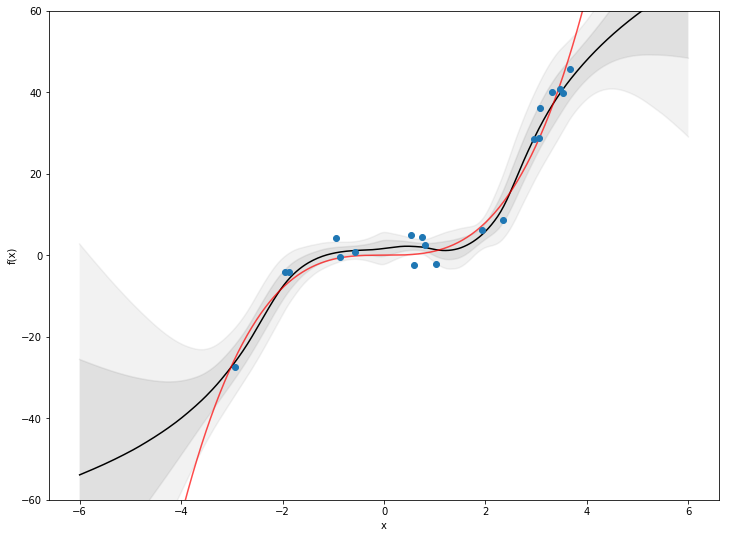

In [28]:
upper1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + 3 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)

lower1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - 3 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)


plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_ksgfs[:,1:].detach().numpy(),1), 'black')
# plt.plot(grid,upper3,'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
# plt.plot(grid,lower3,'black')
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-60,60)
plt.xlabel('x')
plt.ylabel('f(x)')

## Sinus (Louizos, Welling (2016))¶

20 data points simulated as follows:
- 12 samples $x_i$ from $\mathcal{U}(0,0.6)$ and 8 samples from $\mathcal{U}(0.8,1)$
- $y = x_i + \epsilon_i + \sin(4(x_i + \epsilon_i)) + \sin(13(x_i + \epsilon_i))$ with $\epsilon_i \sim \mathcal{N}(0,0.0009)$

See https://arxiv.org/pdf/1603.04733.pdf

In [3]:
np.random.seed(42)
torch.manual_seed(42)

# Create simulated data set
x1 = torch.empty(12, 1).uniform_(0, 0.6)
x2 = torch.empty(8, 1).uniform_(0.8, 1)

x,_ = torch.cat((x1,x2),0).sort(0)

epsilon = torch.normal(torch.zeros_like(x),math.sqrt(0.0009))
y = x + epsilon + torch.sin(4*(x + epsilon)) + torch.sin(13 * (x + epsilon))

grid = np.linspace(-1,2,400)
y_true = (grid + np.sin(4 * grid) + np.sin(13 * grid)).reshape(-1,1)

Text(0.5,0,'x')

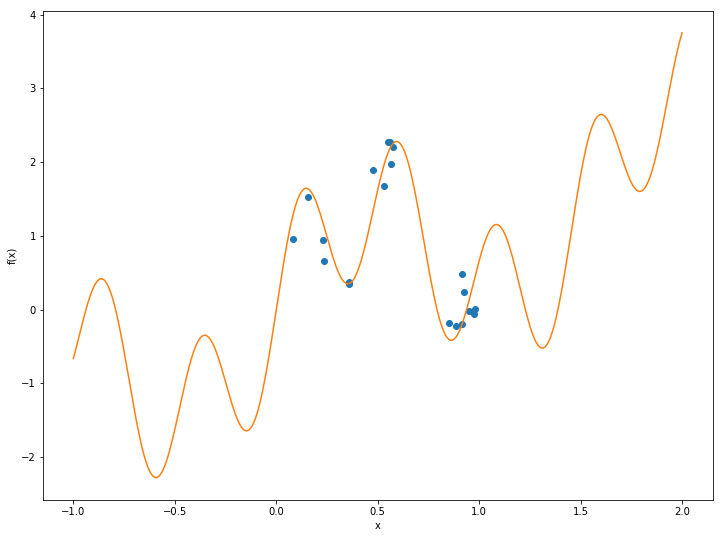

In [4]:
plt.figure(figsize=(12,9))
plt.plot(x.numpy(),y.numpy(),'o')
plt.plot(grid, y_true)
plt.ylabel('f(x)')
plt.xlabel('x')

### SGLD

In [64]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld


np.random.seed(42)
torch.manual_seed(42)



lambda_ = 1.
# learning_rates = [6e-6]
learning_rates = [1e-6]



batch_size = 20
dataset_size = 20

rmse_result = np.zeros((1,len(learning_rates)))

x_test = torch.FloatTensor(grid)
y_test = torch.FloatTensor(y_true)


for i, lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)
    predictions = torch.zeros(400,1)
    t = 1.

    for epoch in range(10000):
        running_loss = 0
        network.zero_grad()
        output = network(x)
        loss = (1/(2*0.0009)) * criterion(output, y)
        loss.backward()
        optim.step()

        running_loss += loss * batch_size / dataset_size


        if (t >= 100) & (t % 100 == 0):
            with torch.autograd.no_grad():
                output = network(x_test)
                predictions = torch.cat((predictions, output), 1)

        t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    rmse_result[:,i] = torch.sqrt(criterion(y_test, torch.mean(predictions,1).view(-1,1)))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 20151.8906
Epoch 1 - loss: 11081.6787
Epoch 2 - loss: 9345.0352
Epoch 3 - loss: 8818.4346
Epoch 4 - loss: 8630.3389
Epoch 5 - loss: 8488.8701
Epoch 6 - loss: 8355.2236
Epoch 7 - loss: 8247.4902
Epoch 8 - loss: 8130.3193
Epoch 9 - loss: 8012.5195
Epoch 10 - loss: 7913.6704
Epoch 11 - loss: 7827.1045
Epoch 12 - loss: 7731.7393
Epoch 13 - loss: 7659.2251
Epoch 14 - loss: 7602.4131
Epoch 15 - loss: 7517.1274
Epoch 16 - loss: 7442.1299
Epoch 17 - loss: 7375.5361
Epoch 18 - loss: 7294.2163
Epoch 19 - loss: 7218.9155
Epoch 20 - loss: 7148.6201
Epoch 21 - loss: 7089.9736
Epoch 22 - loss: 7015.6943
Epoch 23 - loss: 6959.7275
Epoch 24 - loss: 6901.6602
Epoch 25 - loss: 6831.7437
Epoch 26 - loss: 6777.6045
Epoch 27 - loss: 6716.0796
Epoch 28 - loss: 6668.9233
Epoch 29 - loss: 6635.7607
Epoch 30 - loss: 6593.7627
Epoch 31 - loss: 6542.0542
Epoch 32 - loss: 6507.9238
Epoch 33 - loss: 6474.2500
Epoch 34 - loss: 6433.1929
Epoch 35 - loss: 6399.8110
Epoch 36 - loss: 6358.3804
Epoch 37 

Epoch 333 - loss: 4127.6328
Epoch 334 - loss: 4107.1108
Epoch 335 - loss: 4105.8779
Epoch 336 - loss: 4070.2961
Epoch 337 - loss: 4072.0903
Epoch 338 - loss: 4046.9165
Epoch 339 - loss: 4075.2593
Epoch 340 - loss: 4085.8093
Epoch 341 - loss: 4185.6104
Epoch 342 - loss: 4130.4756
Epoch 343 - loss: 4143.3550
Epoch 344 - loss: 4084.2363
Epoch 345 - loss: 4143.4336
Epoch 346 - loss: 4071.5601
Epoch 347 - loss: 4050.5652
Epoch 348 - loss: 4047.2122
Epoch 349 - loss: 4036.3706
Epoch 350 - loss: 3963.6265
Epoch 351 - loss: 3983.9438
Epoch 352 - loss: 3915.6743
Epoch 353 - loss: 3933.0027
Epoch 354 - loss: 3889.0867
Epoch 355 - loss: 3926.6792
Epoch 356 - loss: 3908.9272
Epoch 357 - loss: 3906.1204
Epoch 358 - loss: 3908.6421
Epoch 359 - loss: 3976.9624
Epoch 360 - loss: 3965.1353
Epoch 361 - loss: 4014.5125
Epoch 362 - loss: 3907.9949
Epoch 363 - loss: 3989.3325
Epoch 364 - loss: 4058.9458
Epoch 365 - loss: 4277.0591
Epoch 366 - loss: 4266.6011
Epoch 367 - loss: 4592.2612
Epoch 368 - loss: 44

Epoch 640 - loss: 2541.9189
Epoch 641 - loss: 2684.1414
Epoch 642 - loss: 3010.3167
Epoch 643 - loss: 3356.2329
Epoch 644 - loss: 3596.6274
Epoch 645 - loss: 4257.3569
Epoch 646 - loss: 4353.1919
Epoch 647 - loss: 4547.2236
Epoch 648 - loss: 4430.2251
Epoch 649 - loss: 4267.0435
Epoch 650 - loss: 3941.4487
Epoch 651 - loss: 3742.3320
Epoch 652 - loss: 3192.2490
Epoch 653 - loss: 2775.9595
Epoch 654 - loss: 2394.0598
Epoch 655 - loss: 2259.0974
Epoch 656 - loss: 2120.0513
Epoch 657 - loss: 2029.6650
Epoch 658 - loss: 1942.9547
Epoch 659 - loss: 1920.1022
Epoch 660 - loss: 1902.4713
Epoch 661 - loss: 1889.9479
Epoch 662 - loss: 1888.6667
Epoch 663 - loss: 1857.6643
Epoch 664 - loss: 1864.6155
Epoch 665 - loss: 1855.0039
Epoch 666 - loss: 1838.4623
Epoch 667 - loss: 1837.9128
Epoch 668 - loss: 1865.2725
Epoch 669 - loss: 1856.4945
Epoch 670 - loss: 1858.0492
Epoch 671 - loss: 1855.2230
Epoch 672 - loss: 1891.1370
Epoch 673 - loss: 1888.1375
Epoch 674 - loss: 1913.0696
Epoch 675 - loss: 19

Epoch 942 - loss: 1720.3558
Epoch 943 - loss: 1649.8137
Epoch 944 - loss: 1633.1895
Epoch 945 - loss: 1628.4938
Epoch 946 - loss: 1631.5959
Epoch 947 - loss: 1687.2490
Epoch 948 - loss: 1679.0479
Epoch 949 - loss: 1720.9885
Epoch 950 - loss: 1820.0752
Epoch 951 - loss: 1786.0303
Epoch 952 - loss: 1778.8313
Epoch 953 - loss: 1756.2914
Epoch 954 - loss: 1770.1448
Epoch 955 - loss: 1667.2021
Epoch 956 - loss: 1613.9095
Epoch 957 - loss: 1578.3309
Epoch 958 - loss: 1570.4038
Epoch 959 - loss: 1558.3491
Epoch 960 - loss: 1597.0742
Epoch 961 - loss: 1600.9318
Epoch 962 - loss: 1622.3247
Epoch 963 - loss: 1620.4092
Epoch 964 - loss: 1569.8253
Epoch 965 - loss: 1588.9746
Epoch 966 - loss: 1566.1719
Epoch 967 - loss: 1562.4067
Epoch 968 - loss: 1600.2738
Epoch 969 - loss: 1630.8336
Epoch 970 - loss: 1715.5420
Epoch 971 - loss: 1787.8523
Epoch 972 - loss: 1848.7178
Epoch 973 - loss: 1943.1342
Epoch 974 - loss: 2077.8372
Epoch 975 - loss: 2144.1926
Epoch 976 - loss: 2186.4316
Epoch 977 - loss: 22

Epoch 1236 - loss: 1276.3018
Epoch 1237 - loss: 1266.7413
Epoch 1238 - loss: 1258.4089
Epoch 1239 - loss: 1261.0023
Epoch 1240 - loss: 1277.7023
Epoch 1241 - loss: 1308.2157
Epoch 1242 - loss: 1325.1625
Epoch 1243 - loss: 1369.6074
Epoch 1244 - loss: 1392.2610
Epoch 1245 - loss: 1377.7433
Epoch 1246 - loss: 1424.2897
Epoch 1247 - loss: 1454.1088
Epoch 1248 - loss: 1495.3369
Epoch 1249 - loss: 1471.3881
Epoch 1250 - loss: 1465.3208
Epoch 1251 - loss: 1475.3077
Epoch 1252 - loss: 1476.9906
Epoch 1253 - loss: 1518.1377
Epoch 1254 - loss: 1552.8912
Epoch 1255 - loss: 1533.0477
Epoch 1256 - loss: 1538.9132
Epoch 1257 - loss: 1502.3936
Epoch 1258 - loss: 1553.2452
Epoch 1259 - loss: 1568.4821
Epoch 1260 - loss: 1643.1783
Epoch 1261 - loss: 1701.6064
Epoch 1262 - loss: 1825.7438
Epoch 1263 - loss: 1859.9427
Epoch 1264 - loss: 1831.6492
Epoch 1265 - loss: 1926.5657
Epoch 1266 - loss: 1871.5344
Epoch 1267 - loss: 1860.0146
Epoch 1268 - loss: 1822.6960
Epoch 1269 - loss: 1851.4753
Epoch 1270 - l

Epoch 1531 - loss: 1102.7786
Epoch 1532 - loss: 1106.0123
Epoch 1533 - loss: 1096.0916
Epoch 1534 - loss: 1098.7382
Epoch 1535 - loss: 1085.0156
Epoch 1536 - loss: 1095.3326
Epoch 1537 - loss: 1099.6169
Epoch 1538 - loss: 1098.5800
Epoch 1539 - loss: 1131.3464
Epoch 1540 - loss: 1116.8190
Epoch 1541 - loss: 1165.7861
Epoch 1542 - loss: 1175.5115
Epoch 1543 - loss: 1185.4257
Epoch 1544 - loss: 1192.4362
Epoch 1545 - loss: 1208.5195
Epoch 1546 - loss: 1170.6898
Epoch 1547 - loss: 1175.7798
Epoch 1548 - loss: 1196.1417
Epoch 1549 - loss: 1176.5055
Epoch 1550 - loss: 1149.6024
Epoch 1551 - loss: 1159.3140
Epoch 1552 - loss: 1111.0562
Epoch 1553 - loss: 1105.9070
Epoch 1554 - loss: 1103.6752
Epoch 1555 - loss: 1127.7966
Epoch 1556 - loss: 1106.3376
Epoch 1557 - loss: 1113.1455
Epoch 1558 - loss: 1105.3790
Epoch 1559 - loss: 1132.3976
Epoch 1560 - loss: 1153.6096
Epoch 1561 - loss: 1186.4707
Epoch 1562 - loss: 1204.2665
Epoch 1563 - loss: 1200.0720
Epoch 1564 - loss: 1212.8726
Epoch 1565 - l

Epoch 1866 - loss: 1192.5464
Epoch 1867 - loss: 1222.7590
Epoch 1868 - loss: 1238.6250
Epoch 1869 - loss: 1261.6797
Epoch 1870 - loss: 1261.3479
Epoch 1871 - loss: 1302.5806
Epoch 1872 - loss: 1301.4805
Epoch 1873 - loss: 1301.3717
Epoch 1874 - loss: 1246.0834
Epoch 1875 - loss: 1189.5635
Epoch 1876 - loss: 1184.0265
Epoch 1877 - loss: 1203.5145
Epoch 1878 - loss: 1201.1094
Epoch 1879 - loss: 1208.3157
Epoch 1880 - loss: 1237.1672
Epoch 1881 - loss: 1181.0066
Epoch 1882 - loss: 1173.1230
Epoch 1883 - loss: 1157.4163
Epoch 1884 - loss: 1165.4996
Epoch 1885 - loss: 1134.4312
Epoch 1886 - loss: 1108.9720
Epoch 1887 - loss: 1086.2316
Epoch 1888 - loss: 1066.3489
Epoch 1889 - loss: 1046.2950
Epoch 1890 - loss: 1045.8496
Epoch 1891 - loss: 1038.3563
Epoch 1892 - loss: 1032.4847
Epoch 1893 - loss: 1050.4368
Epoch 1894 - loss: 1076.2903
Epoch 1895 - loss: 1066.1063
Epoch 1896 - loss: 1039.1227
Epoch 1897 - loss: 1031.9004
Epoch 1898 - loss: 1020.0099
Epoch 1899 - loss: 960.4323
Epoch 1900 - lo

Epoch 2174 - loss: 880.1444
Epoch 2175 - loss: 825.3214
Epoch 2176 - loss: 796.9648
Epoch 2177 - loss: 781.3182
Epoch 2178 - loss: 780.2310
Epoch 2179 - loss: 777.8181
Epoch 2180 - loss: 779.0558
Epoch 2181 - loss: 774.9269
Epoch 2182 - loss: 784.9053
Epoch 2183 - loss: 772.0538
Epoch 2184 - loss: 763.0968
Epoch 2185 - loss: 760.8653
Epoch 2186 - loss: 755.7245
Epoch 2187 - loss: 758.4425
Epoch 2188 - loss: 754.5792
Epoch 2189 - loss: 750.6512
Epoch 2190 - loss: 745.6638
Epoch 2191 - loss: 745.8730
Epoch 2192 - loss: 744.4391
Epoch 2193 - loss: 741.2740
Epoch 2194 - loss: 740.9124
Epoch 2195 - loss: 741.3324
Epoch 2196 - loss: 746.3262
Epoch 2197 - loss: 744.9019
Epoch 2198 - loss: 744.3893
Epoch 2199 - loss: 751.8965
Epoch 2200 - loss: 760.6248
Epoch 2201 - loss: 791.2445
Epoch 2202 - loss: 771.3532
Epoch 2203 - loss: 760.8075
Epoch 2204 - loss: 753.3295
Epoch 2205 - loss: 750.9117
Epoch 2206 - loss: 740.1155
Epoch 2207 - loss: 740.0650
Epoch 2208 - loss: 754.8071
Epoch 2209 - loss: 7

Epoch 2541 - loss: 817.4014
Epoch 2542 - loss: 826.3436
Epoch 2543 - loss: 813.2037
Epoch 2544 - loss: 840.4449
Epoch 2545 - loss: 858.2844
Epoch 2546 - loss: 873.3762
Epoch 2547 - loss: 888.7230
Epoch 2548 - loss: 856.6671
Epoch 2549 - loss: 844.5803
Epoch 2550 - loss: 857.3674
Epoch 2551 - loss: 866.2316
Epoch 2552 - loss: 855.7822
Epoch 2553 - loss: 909.1359
Epoch 2554 - loss: 876.7418
Epoch 2555 - loss: 909.5101
Epoch 2556 - loss: 900.0558
Epoch 2557 - loss: 884.4623
Epoch 2558 - loss: 917.4940
Epoch 2559 - loss: 898.4709
Epoch 2560 - loss: 951.9844
Epoch 2561 - loss: 988.5869
Epoch 2562 - loss: 1029.4451
Epoch 2563 - loss: 1016.6652
Epoch 2564 - loss: 1039.4736
Epoch 2565 - loss: 1092.6810
Epoch 2566 - loss: 1189.9806
Epoch 2567 - loss: 1168.3575
Epoch 2568 - loss: 1148.3021
Epoch 2569 - loss: 1169.5785
Epoch 2570 - loss: 1148.3041
Epoch 2571 - loss: 1149.9958
Epoch 2572 - loss: 1200.8555
Epoch 2573 - loss: 1160.9248
Epoch 2574 - loss: 1183.3901
Epoch 2575 - loss: 1100.0187
Epoch 

Epoch 2862 - loss: 639.6317
Epoch 2863 - loss: 643.1880
Epoch 2864 - loss: 640.1082
Epoch 2865 - loss: 642.1927
Epoch 2866 - loss: 640.5467
Epoch 2867 - loss: 646.0684
Epoch 2868 - loss: 642.1568
Epoch 2869 - loss: 640.8547
Epoch 2870 - loss: 639.7717
Epoch 2871 - loss: 641.2569
Epoch 2872 - loss: 638.8716
Epoch 2873 - loss: 642.9284
Epoch 2874 - loss: 645.7380
Epoch 2875 - loss: 639.5712
Epoch 2876 - loss: 637.6021
Epoch 2877 - loss: 639.2085
Epoch 2878 - loss: 635.9404
Epoch 2879 - loss: 635.9144
Epoch 2880 - loss: 633.8344
Epoch 2881 - loss: 635.2042
Epoch 2882 - loss: 643.8893
Epoch 2883 - loss: 645.9759
Epoch 2884 - loss: 663.5208
Epoch 2885 - loss: 644.6843
Epoch 2886 - loss: 655.1506
Epoch 2887 - loss: 658.4076
Epoch 2888 - loss: 657.3975
Epoch 2889 - loss: 659.3440
Epoch 2890 - loss: 660.3696
Epoch 2891 - loss: 660.1344
Epoch 2892 - loss: 668.4519
Epoch 2893 - loss: 682.5825
Epoch 2894 - loss: 700.4042
Epoch 2895 - loss: 691.2941
Epoch 2896 - loss: 669.4974
Epoch 2897 - loss: 6

Epoch 3167 - loss: 1677.3494
Epoch 3168 - loss: 1735.4944
Epoch 3169 - loss: 1678.2883
Epoch 3170 - loss: 1782.3792
Epoch 3171 - loss: 1776.6653
Epoch 3172 - loss: 1803.4060
Epoch 3173 - loss: 1705.0182
Epoch 3174 - loss: 1565.5596
Epoch 3175 - loss: 1483.4868
Epoch 3176 - loss: 1452.5656
Epoch 3177 - loss: 1451.3365
Epoch 3178 - loss: 1329.8715
Epoch 3179 - loss: 1279.8270
Epoch 3180 - loss: 1297.4369
Epoch 3181 - loss: 1272.4561
Epoch 3182 - loss: 1200.0560
Epoch 3183 - loss: 1136.3652
Epoch 3184 - loss: 1054.7374
Epoch 3185 - loss: 1055.1271
Epoch 3186 - loss: 1036.0159
Epoch 3187 - loss: 1074.7323
Epoch 3188 - loss: 961.0802
Epoch 3189 - loss: 1016.8620
Epoch 3190 - loss: 954.8989
Epoch 3191 - loss: 895.2048
Epoch 3192 - loss: 780.3663
Epoch 3193 - loss: 702.1826
Epoch 3194 - loss: 666.3542
Epoch 3195 - loss: 672.2170
Epoch 3196 - loss: 660.6478
Epoch 3197 - loss: 648.9367
Epoch 3198 - loss: 644.4222
Epoch 3199 - loss: 641.6321
Epoch 3200 - loss: 640.1407
Epoch 3201 - loss: 649.678

Epoch 3539 - loss: 924.3746
Epoch 3540 - loss: 865.2503
Epoch 3541 - loss: 808.3987
Epoch 3542 - loss: 831.2316
Epoch 3543 - loss: 845.2689
Epoch 3544 - loss: 830.0319
Epoch 3545 - loss: 821.4122
Epoch 3546 - loss: 773.4456
Epoch 3547 - loss: 813.1505
Epoch 3548 - loss: 840.8787
Epoch 3549 - loss: 797.3643
Epoch 3550 - loss: 748.9079
Epoch 3551 - loss: 760.3729
Epoch 3552 - loss: 742.1959
Epoch 3553 - loss: 749.6631
Epoch 3554 - loss: 688.4614
Epoch 3555 - loss: 697.6139
Epoch 3556 - loss: 704.1517
Epoch 3557 - loss: 685.7890
Epoch 3558 - loss: 702.0453
Epoch 3559 - loss: 687.6973
Epoch 3560 - loss: 693.8804
Epoch 3561 - loss: 716.8372
Epoch 3562 - loss: 723.9612
Epoch 3563 - loss: 708.8440
Epoch 3564 - loss: 731.0526
Epoch 3565 - loss: 696.3282
Epoch 3566 - loss: 666.9886
Epoch 3567 - loss: 645.7563
Epoch 3568 - loss: 657.2750
Epoch 3569 - loss: 655.3154
Epoch 3570 - loss: 670.4401
Epoch 3571 - loss: 652.7488
Epoch 3572 - loss: 646.2087
Epoch 3573 - loss: 642.4529
Epoch 3574 - loss: 6

Epoch 3838 - loss: 598.7053
Epoch 3839 - loss: 601.4350
Epoch 3840 - loss: 609.1336
Epoch 3841 - loss: 609.8860
Epoch 3842 - loss: 611.6846
Epoch 3843 - loss: 629.0414
Epoch 3844 - loss: 633.1902
Epoch 3845 - loss: 651.2375
Epoch 3846 - loss: 652.9881
Epoch 3847 - loss: 661.6310
Epoch 3848 - loss: 640.1215
Epoch 3849 - loss: 640.1777
Epoch 3850 - loss: 621.3845
Epoch 3851 - loss: 613.2264
Epoch 3852 - loss: 623.9122
Epoch 3853 - loss: 621.9986
Epoch 3854 - loss: 615.4922
Epoch 3855 - loss: 612.6972
Epoch 3856 - loss: 614.3653
Epoch 3857 - loss: 619.8754
Epoch 3858 - loss: 617.7234
Epoch 3859 - loss: 613.4791
Epoch 3860 - loss: 605.6049
Epoch 3861 - loss: 612.9810
Epoch 3862 - loss: 607.1902
Epoch 3863 - loss: 604.6626
Epoch 3864 - loss: 604.7073
Epoch 3865 - loss: 608.6414
Epoch 3866 - loss: 609.2732
Epoch 3867 - loss: 602.7539
Epoch 3868 - loss: 595.6606
Epoch 3869 - loss: 597.8795
Epoch 3870 - loss: 592.4426
Epoch 3871 - loss: 595.3902
Epoch 3872 - loss: 603.5275
Epoch 3873 - loss: 6

Epoch 4150 - loss: 1610.7225
Epoch 4151 - loss: 1603.6653
Epoch 4152 - loss: 1615.4382
Epoch 4153 - loss: 1587.6495
Epoch 4154 - loss: 1563.9734
Epoch 4155 - loss: 1438.4901
Epoch 4156 - loss: 1428.7614
Epoch 4157 - loss: 1401.0752
Epoch 4158 - loss: 1280.1489
Epoch 4159 - loss: 1326.3405
Epoch 4160 - loss: 1223.5184
Epoch 4161 - loss: 1170.9331
Epoch 4162 - loss: 1218.6002
Epoch 4163 - loss: 1120.3918
Epoch 4164 - loss: 1122.6823
Epoch 4165 - loss: 1015.0238
Epoch 4166 - loss: 964.7423
Epoch 4167 - loss: 880.1178
Epoch 4168 - loss: 810.1529
Epoch 4169 - loss: 809.4745
Epoch 4170 - loss: 751.7340
Epoch 4171 - loss: 713.3072
Epoch 4172 - loss: 697.4243
Epoch 4173 - loss: 678.6881
Epoch 4174 - loss: 661.5159
Epoch 4175 - loss: 654.3287
Epoch 4176 - loss: 661.6159
Epoch 4177 - loss: 661.5788
Epoch 4178 - loss: 645.8052
Epoch 4179 - loss: 650.7234
Epoch 4180 - loss: 620.6888
Epoch 4181 - loss: 639.2569
Epoch 4182 - loss: 632.0731
Epoch 4183 - loss: 617.8074
Epoch 4184 - loss: 612.0041
Epoc

Epoch 4449 - loss: 585.4458
Epoch 4450 - loss: 593.1115
Epoch 4451 - loss: 584.5721
Epoch 4452 - loss: 573.4503
Epoch 4453 - loss: 570.5693
Epoch 4454 - loss: 574.5029
Epoch 4455 - loss: 570.0281
Epoch 4456 - loss: 570.6016
Epoch 4457 - loss: 571.3283
Epoch 4458 - loss: 575.6030
Epoch 4459 - loss: 581.9393
Epoch 4460 - loss: 580.2469
Epoch 4461 - loss: 570.6768
Epoch 4462 - loss: 568.2245
Epoch 4463 - loss: 568.8785
Epoch 4464 - loss: 570.0128
Epoch 4465 - loss: 570.7330
Epoch 4466 - loss: 569.3412
Epoch 4467 - loss: 566.7816
Epoch 4468 - loss: 566.9493
Epoch 4469 - loss: 569.6831
Epoch 4470 - loss: 567.4456
Epoch 4471 - loss: 567.0439
Epoch 4472 - loss: 566.5638
Epoch 4473 - loss: 570.5901
Epoch 4474 - loss: 567.0519
Epoch 4475 - loss: 569.0791
Epoch 4476 - loss: 569.6983
Epoch 4477 - loss: 571.1857
Epoch 4478 - loss: 565.9227
Epoch 4479 - loss: 568.9847
Epoch 4480 - loss: 568.9236
Epoch 4481 - loss: 564.3437
Epoch 4482 - loss: 566.1284
Epoch 4483 - loss: 569.7947
Epoch 4484 - loss: 5

Epoch 4764 - loss: 573.8141
Epoch 4765 - loss: 573.0740
Epoch 4766 - loss: 573.3136
Epoch 4767 - loss: 574.8530
Epoch 4768 - loss: 574.3994
Epoch 4769 - loss: 573.1067
Epoch 4770 - loss: 572.4974
Epoch 4771 - loss: 576.5394
Epoch 4772 - loss: 575.0208
Epoch 4773 - loss: 580.5441
Epoch 4774 - loss: 582.9457
Epoch 4775 - loss: 596.9407
Epoch 4776 - loss: 586.1798
Epoch 4777 - loss: 586.5579
Epoch 4778 - loss: 599.3427
Epoch 4779 - loss: 606.9977
Epoch 4780 - loss: 597.2217
Epoch 4781 - loss: 595.6343
Epoch 4782 - loss: 585.0704
Epoch 4783 - loss: 582.8845
Epoch 4784 - loss: 585.7027
Epoch 4785 - loss: 577.0870
Epoch 4786 - loss: 581.5836
Epoch 4787 - loss: 576.2570
Epoch 4788 - loss: 578.8225
Epoch 4789 - loss: 575.8462
Epoch 4790 - loss: 577.0741
Epoch 4791 - loss: 573.8829
Epoch 4792 - loss: 571.7043
Epoch 4793 - loss: 572.1004
Epoch 4794 - loss: 572.6624
Epoch 4795 - loss: 568.9070
Epoch 4796 - loss: 570.2568
Epoch 4797 - loss: 569.5748
Epoch 4798 - loss: 570.2469
Epoch 4799 - loss: 5

Epoch 5141 - loss: 560.1808
Epoch 5142 - loss: 562.9490
Epoch 5143 - loss: 554.2853
Epoch 5144 - loss: 553.5600
Epoch 5145 - loss: 553.1152
Epoch 5146 - loss: 554.3796
Epoch 5147 - loss: 558.6746
Epoch 5148 - loss: 560.3370
Epoch 5149 - loss: 553.8238
Epoch 5150 - loss: 556.1413
Epoch 5151 - loss: 555.6376
Epoch 5152 - loss: 565.5802
Epoch 5153 - loss: 561.2574
Epoch 5154 - loss: 568.5677
Epoch 5155 - loss: 562.3110
Epoch 5156 - loss: 562.0518
Epoch 5157 - loss: 560.0388
Epoch 5158 - loss: 557.0923
Epoch 5159 - loss: 558.3939
Epoch 5160 - loss: 559.2479
Epoch 5161 - loss: 557.1116
Epoch 5162 - loss: 554.5997
Epoch 5163 - loss: 554.5834
Epoch 5164 - loss: 557.3464
Epoch 5165 - loss: 557.5049
Epoch 5166 - loss: 554.6243
Epoch 5167 - loss: 555.3327
Epoch 5168 - loss: 555.7072
Epoch 5169 - loss: 552.4960
Epoch 5170 - loss: 551.9016
Epoch 5171 - loss: 554.1630
Epoch 5172 - loss: 552.6307
Epoch 5173 - loss: 558.3649
Epoch 5174 - loss: 553.8665
Epoch 5175 - loss: 553.4400
Epoch 5176 - loss: 5

Epoch 5439 - loss: 766.0867
Epoch 5440 - loss: 755.9618
Epoch 5441 - loss: 762.8815
Epoch 5442 - loss: 711.9581
Epoch 5443 - loss: 696.6428
Epoch 5444 - loss: 687.0319
Epoch 5445 - loss: 653.3728
Epoch 5446 - loss: 643.9704
Epoch 5447 - loss: 634.1134
Epoch 5448 - loss: 656.8840
Epoch 5449 - loss: 659.4927
Epoch 5450 - loss: 645.9901
Epoch 5451 - loss: 653.5458
Epoch 5452 - loss: 663.5466
Epoch 5453 - loss: 681.5026
Epoch 5454 - loss: 680.2881
Epoch 5455 - loss: 679.9972
Epoch 5456 - loss: 657.8505
Epoch 5457 - loss: 632.3472
Epoch 5458 - loss: 643.1444
Epoch 5459 - loss: 674.6004
Epoch 5460 - loss: 675.9308
Epoch 5461 - loss: 677.3618
Epoch 5462 - loss: 670.1567
Epoch 5463 - loss: 672.9727
Epoch 5464 - loss: 662.1420
Epoch 5465 - loss: 646.4452
Epoch 5466 - loss: 633.5490
Epoch 5467 - loss: 618.6130
Epoch 5468 - loss: 635.9558
Epoch 5469 - loss: 625.4997
Epoch 5470 - loss: 669.2748
Epoch 5471 - loss: 652.7687
Epoch 5472 - loss: 678.7720
Epoch 5473 - loss: 633.4521
Epoch 5474 - loss: 6

Epoch 5764 - loss: 579.7457
Epoch 5765 - loss: 578.3594
Epoch 5766 - loss: 592.3741
Epoch 5767 - loss: 588.2386
Epoch 5768 - loss: 595.2088
Epoch 5769 - loss: 586.6422
Epoch 5770 - loss: 603.8729
Epoch 5771 - loss: 599.1627
Epoch 5772 - loss: 620.0916
Epoch 5773 - loss: 662.8894
Epoch 5774 - loss: 692.6946
Epoch 5775 - loss: 682.0040
Epoch 5776 - loss: 703.6897
Epoch 5777 - loss: 689.9404
Epoch 5778 - loss: 772.7437
Epoch 5779 - loss: 757.6485
Epoch 5780 - loss: 781.8066
Epoch 5781 - loss: 778.9958
Epoch 5782 - loss: 870.4741
Epoch 5783 - loss: 903.0458
Epoch 5784 - loss: 996.7971
Epoch 5785 - loss: 1010.0965
Epoch 5786 - loss: 971.8600
Epoch 5787 - loss: 1041.7667
Epoch 5788 - loss: 1068.9382
Epoch 5789 - loss: 993.8543
Epoch 5790 - loss: 989.7101
Epoch 5791 - loss: 1022.0501
Epoch 5792 - loss: 921.2523
Epoch 5793 - loss: 955.9982
Epoch 5794 - loss: 902.4664
Epoch 5795 - loss: 911.2255
Epoch 5796 - loss: 910.2834
Epoch 5797 - loss: 939.6470
Epoch 5798 - loss: 917.9681
Epoch 5799 - los

Epoch 6075 - loss: 560.6755
Epoch 6076 - loss: 549.8398
Epoch 6077 - loss: 559.8575
Epoch 6078 - loss: 558.8057
Epoch 6079 - loss: 564.3380
Epoch 6080 - loss: 556.5972
Epoch 6081 - loss: 551.7477
Epoch 6082 - loss: 558.1848
Epoch 6083 - loss: 567.9161
Epoch 6084 - loss: 580.6498
Epoch 6085 - loss: 598.7316
Epoch 6086 - loss: 619.4733
Epoch 6087 - loss: 608.4482
Epoch 6088 - loss: 627.8580
Epoch 6089 - loss: 624.0475
Epoch 6090 - loss: 608.6022
Epoch 6091 - loss: 612.3428
Epoch 6092 - loss: 635.0039
Epoch 6093 - loss: 660.6513
Epoch 6094 - loss: 646.9067
Epoch 6095 - loss: 646.2620
Epoch 6096 - loss: 617.6504
Epoch 6097 - loss: 631.9788
Epoch 6098 - loss: 608.2894
Epoch 6099 - loss: 603.1804
Epoch 6100 - loss: 600.5936
Epoch 6101 - loss: 606.9283
Epoch 6102 - loss: 591.2697
Epoch 6103 - loss: 605.7996
Epoch 6104 - loss: 621.4290
Epoch 6105 - loss: 619.6445
Epoch 6106 - loss: 619.2448
Epoch 6107 - loss: 597.6346
Epoch 6108 - loss: 615.6027
Epoch 6109 - loss: 610.8517
Epoch 6110 - loss: 6

Epoch 6407 - loss: 1421.9492
Epoch 6408 - loss: 1460.8914
Epoch 6409 - loss: 1426.9822
Epoch 6410 - loss: 1407.0564
Epoch 6411 - loss: 1421.8876
Epoch 6412 - loss: 1465.1780
Epoch 6413 - loss: 1383.4354
Epoch 6414 - loss: 1384.4570
Epoch 6415 - loss: 1357.3186
Epoch 6416 - loss: 1253.8372
Epoch 6417 - loss: 1251.0492
Epoch 6418 - loss: 1265.6703
Epoch 6419 - loss: 1225.7544
Epoch 6420 - loss: 1130.4336
Epoch 6421 - loss: 1172.6831
Epoch 6422 - loss: 1206.3021
Epoch 6423 - loss: 1077.6957
Epoch 6424 - loss: 1056.1115
Epoch 6425 - loss: 1036.9645
Epoch 6426 - loss: 1007.8986
Epoch 6427 - loss: 1003.0228
Epoch 6428 - loss: 937.7043
Epoch 6429 - loss: 893.2552
Epoch 6430 - loss: 852.6227
Epoch 6431 - loss: 874.0928
Epoch 6432 - loss: 896.0153
Epoch 6433 - loss: 818.9021
Epoch 6434 - loss: 841.8387
Epoch 6435 - loss: 791.8279
Epoch 6436 - loss: 732.0862
Epoch 6437 - loss: 746.1534
Epoch 6438 - loss: 711.4854
Epoch 6439 - loss: 692.9863
Epoch 6440 - loss: 631.9335
Epoch 6441 - loss: 603.9557

Epoch 6716 - loss: 602.5846
Epoch 6717 - loss: 629.3853
Epoch 6718 - loss: 596.7462
Epoch 6719 - loss: 630.6396
Epoch 6720 - loss: 636.0651
Epoch 6721 - loss: 637.2192
Epoch 6722 - loss: 641.6712
Epoch 6723 - loss: 653.5821
Epoch 6724 - loss: 659.4767
Epoch 6725 - loss: 663.0459
Epoch 6726 - loss: 711.1163
Epoch 6727 - loss: 691.5936
Epoch 6728 - loss: 697.2726
Epoch 6729 - loss: 718.9072
Epoch 6730 - loss: 710.0353
Epoch 6731 - loss: 731.7780
Epoch 6732 - loss: 751.1511
Epoch 6733 - loss: 721.9253
Epoch 6734 - loss: 728.0206
Epoch 6735 - loss: 731.9214
Epoch 6736 - loss: 713.4384
Epoch 6737 - loss: 743.4372
Epoch 6738 - loss: 774.7147
Epoch 6739 - loss: 801.0388
Epoch 6740 - loss: 901.0243
Epoch 6741 - loss: 889.1603
Epoch 6742 - loss: 854.3629
Epoch 6743 - loss: 870.9376
Epoch 6744 - loss: 871.0321
Epoch 6745 - loss: 885.4070
Epoch 6746 - loss: 901.3942
Epoch 6747 - loss: 919.1134
Epoch 6748 - loss: 984.4209
Epoch 6749 - loss: 1084.1315
Epoch 6750 - loss: 1031.5350
Epoch 6751 - loss:

Epoch 7031 - loss: 550.6113
Epoch 7032 - loss: 548.4378
Epoch 7033 - loss: 553.6841
Epoch 7034 - loss: 542.3337
Epoch 7035 - loss: 539.6033
Epoch 7036 - loss: 539.2935
Epoch 7037 - loss: 538.1105
Epoch 7038 - loss: 546.8358
Epoch 7039 - loss: 545.1551
Epoch 7040 - loss: 550.4012
Epoch 7041 - loss: 549.1367
Epoch 7042 - loss: 551.7169
Epoch 7043 - loss: 541.7963
Epoch 7044 - loss: 541.6136
Epoch 7045 - loss: 540.4121
Epoch 7046 - loss: 545.0858
Epoch 7047 - loss: 553.6553
Epoch 7048 - loss: 556.6835
Epoch 7049 - loss: 569.3548
Epoch 7050 - loss: 575.8864
Epoch 7051 - loss: 588.4489
Epoch 7052 - loss: 586.1505
Epoch 7053 - loss: 577.4731
Epoch 7054 - loss: 565.5358
Epoch 7055 - loss: 545.5959
Epoch 7056 - loss: 544.1658
Epoch 7057 - loss: 543.3577
Epoch 7058 - loss: 549.5033
Epoch 7059 - loss: 548.0825
Epoch 7060 - loss: 558.0107
Epoch 7061 - loss: 573.7514
Epoch 7062 - loss: 551.3221
Epoch 7063 - loss: 551.6451
Epoch 7064 - loss: 556.0323
Epoch 7065 - loss: 568.9103
Epoch 7066 - loss: 5

Epoch 7331 - loss: 745.0726
Epoch 7332 - loss: 782.4259
Epoch 7333 - loss: 788.2288
Epoch 7334 - loss: 767.2545
Epoch 7335 - loss: 785.7250
Epoch 7336 - loss: 759.6403
Epoch 7337 - loss: 761.5408
Epoch 7338 - loss: 759.4154
Epoch 7339 - loss: 758.5281
Epoch 7340 - loss: 806.5334
Epoch 7341 - loss: 883.1884
Epoch 7342 - loss: 882.0169
Epoch 7343 - loss: 843.9988
Epoch 7344 - loss: 863.8996
Epoch 7345 - loss: 859.3390
Epoch 7346 - loss: 853.5465
Epoch 7347 - loss: 777.4802
Epoch 7348 - loss: 714.2969
Epoch 7349 - loss: 734.8742
Epoch 7350 - loss: 793.2586
Epoch 7351 - loss: 801.2178
Epoch 7352 - loss: 831.8825
Epoch 7353 - loss: 830.4176
Epoch 7354 - loss: 814.6852
Epoch 7355 - loss: 806.8269
Epoch 7356 - loss: 832.6996
Epoch 7357 - loss: 859.5212
Epoch 7358 - loss: 891.9246
Epoch 7359 - loss: 870.0926
Epoch 7360 - loss: 840.3176
Epoch 7361 - loss: 848.7186
Epoch 7362 - loss: 851.9025
Epoch 7363 - loss: 868.4988
Epoch 7364 - loss: 883.5846
Epoch 7365 - loss: 847.6951
Epoch 7366 - loss: 8

Epoch 7645 - loss: 624.2346
Epoch 7646 - loss: 602.4212
Epoch 7647 - loss: 607.3587
Epoch 7648 - loss: 588.6694
Epoch 7649 - loss: 620.9841
Epoch 7650 - loss: 601.5367
Epoch 7651 - loss: 578.7045
Epoch 7652 - loss: 548.1491
Epoch 7653 - loss: 552.5417
Epoch 7654 - loss: 555.5203
Epoch 7655 - loss: 548.3147
Epoch 7656 - loss: 541.7445
Epoch 7657 - loss: 538.4272
Epoch 7658 - loss: 530.0857
Epoch 7659 - loss: 535.6888
Epoch 7660 - loss: 543.2297
Epoch 7661 - loss: 543.1666
Epoch 7662 - loss: 533.5930
Epoch 7663 - loss: 543.5953
Epoch 7664 - loss: 554.1202
Epoch 7665 - loss: 552.6819
Epoch 7666 - loss: 547.5368
Epoch 7667 - loss: 537.3916
Epoch 7668 - loss: 538.3889
Epoch 7669 - loss: 542.3975
Epoch 7670 - loss: 537.9692
Epoch 7671 - loss: 536.1782
Epoch 7672 - loss: 535.4762
Epoch 7673 - loss: 534.6534
Epoch 7674 - loss: 544.1301
Epoch 7675 - loss: 551.9644
Epoch 7676 - loss: 546.6965
Epoch 7677 - loss: 556.0223
Epoch 7678 - loss: 534.8627
Epoch 7679 - loss: 534.0923
Epoch 7680 - loss: 5

Epoch 8011 - loss: 616.2872
Epoch 8012 - loss: 597.0233
Epoch 8013 - loss: 595.7643
Epoch 8014 - loss: 621.3289
Epoch 8015 - loss: 658.3514
Epoch 8016 - loss: 702.0212
Epoch 8017 - loss: 740.7584
Epoch 8018 - loss: 747.5892
Epoch 8019 - loss: 766.9916
Epoch 8020 - loss: 745.2294
Epoch 8021 - loss: 752.3979
Epoch 8022 - loss: 766.4954
Epoch 8023 - loss: 802.8284
Epoch 8024 - loss: 799.8964
Epoch 8025 - loss: 830.7238
Epoch 8026 - loss: 832.4686
Epoch 8027 - loss: 823.7092
Epoch 8028 - loss: 824.1957
Epoch 8029 - loss: 830.3279
Epoch 8030 - loss: 788.6866
Epoch 8031 - loss: 727.7482
Epoch 8032 - loss: 719.8732
Epoch 8033 - loss: 705.6072
Epoch 8034 - loss: 709.9402
Epoch 8035 - loss: 701.8240
Epoch 8036 - loss: 661.9827
Epoch 8037 - loss: 675.9908
Epoch 8038 - loss: 644.7067
Epoch 8039 - loss: 683.7156
Epoch 8040 - loss: 668.3629
Epoch 8041 - loss: 667.4203
Epoch 8042 - loss: 698.7010
Epoch 8043 - loss: 680.3441
Epoch 8044 - loss: 653.7603
Epoch 8045 - loss: 655.3024
Epoch 8046 - loss: 6

Epoch 8318 - loss: 614.5394
Epoch 8319 - loss: 607.6666
Epoch 8320 - loss: 593.6403
Epoch 8321 - loss: 567.6840
Epoch 8322 - loss: 564.7147
Epoch 8323 - loss: 587.0928
Epoch 8324 - loss: 608.8109
Epoch 8325 - loss: 618.3237
Epoch 8326 - loss: 607.9000
Epoch 8327 - loss: 620.2926
Epoch 8328 - loss: 614.4921
Epoch 8329 - loss: 614.7479
Epoch 8330 - loss: 584.3524
Epoch 8331 - loss: 561.0996
Epoch 8332 - loss: 558.7101
Epoch 8333 - loss: 550.8356
Epoch 8334 - loss: 537.6014
Epoch 8335 - loss: 532.5732
Epoch 8336 - loss: 542.2618
Epoch 8337 - loss: 536.1691
Epoch 8338 - loss: 551.5464
Epoch 8339 - loss: 553.5715
Epoch 8340 - loss: 557.9930
Epoch 8341 - loss: 569.9329
Epoch 8342 - loss: 546.4689
Epoch 8343 - loss: 539.6627
Epoch 8344 - loss: 534.4130
Epoch 8345 - loss: 535.7395
Epoch 8346 - loss: 528.3680
Epoch 8347 - loss: 526.9660
Epoch 8348 - loss: 525.3728
Epoch 8349 - loss: 522.4861
Epoch 8350 - loss: 528.4051
Epoch 8351 - loss: 524.5350
Epoch 8352 - loss: 523.0016
Epoch 8353 - loss: 5

Epoch 8629 - loss: 913.9926
Epoch 8630 - loss: 855.1420
Epoch 8631 - loss: 891.0891
Epoch 8632 - loss: 859.3654
Epoch 8633 - loss: 931.6971
Epoch 8634 - loss: 953.7811
Epoch 8635 - loss: 948.2858
Epoch 8636 - loss: 994.6570
Epoch 8637 - loss: 1029.8081
Epoch 8638 - loss: 1020.9250
Epoch 8639 - loss: 1046.3444
Epoch 8640 - loss: 1002.5861
Epoch 8641 - loss: 994.1362
Epoch 8642 - loss: 997.3990
Epoch 8643 - loss: 1020.6781
Epoch 8644 - loss: 1021.0648
Epoch 8645 - loss: 998.0402
Epoch 8646 - loss: 1010.4406
Epoch 8647 - loss: 1007.6188
Epoch 8648 - loss: 966.6096
Epoch 8649 - loss: 897.4550
Epoch 8650 - loss: 865.3768
Epoch 8651 - loss: 843.0535
Epoch 8652 - loss: 856.6791
Epoch 8653 - loss: 816.2368
Epoch 8654 - loss: 816.8510
Epoch 8655 - loss: 769.5242
Epoch 8656 - loss: 777.0139
Epoch 8657 - loss: 722.1652
Epoch 8658 - loss: 680.4648
Epoch 8659 - loss: 642.1494
Epoch 8660 - loss: 635.9987
Epoch 8661 - loss: 634.1716
Epoch 8662 - loss: 666.3284
Epoch 8663 - loss: 667.1381
Epoch 8664 -

Epoch 8954 - loss: 658.4141
Epoch 8955 - loss: 655.0374
Epoch 8956 - loss: 672.5538
Epoch 8957 - loss: 737.6909
Epoch 8958 - loss: 766.3749
Epoch 8959 - loss: 799.5928
Epoch 8960 - loss: 826.5975
Epoch 8961 - loss: 833.8090
Epoch 8962 - loss: 833.4575
Epoch 8963 - loss: 853.2809
Epoch 8964 - loss: 842.2147
Epoch 8965 - loss: 867.7394
Epoch 8966 - loss: 902.0709
Epoch 8967 - loss: 875.4727
Epoch 8968 - loss: 849.8498
Epoch 8969 - loss: 885.5734
Epoch 8970 - loss: 887.2211
Epoch 8971 - loss: 958.5698
Epoch 8972 - loss: 952.0358
Epoch 8973 - loss: 955.2788
Epoch 8974 - loss: 996.7922
Epoch 8975 - loss: 1045.7711
Epoch 8976 - loss: 1020.5560
Epoch 8977 - loss: 993.3546
Epoch 8978 - loss: 1066.2504
Epoch 8979 - loss: 1109.7299
Epoch 8980 - loss: 1095.7627
Epoch 8981 - loss: 1163.5590
Epoch 8982 - loss: 1219.3854
Epoch 8983 - loss: 1194.0663
Epoch 8984 - loss: 1173.7499
Epoch 8985 - loss: 1140.1582
Epoch 8986 - loss: 1153.1558
Epoch 8987 - loss: 1219.5664
Epoch 8988 - loss: 1291.2977
Epoch 8

Epoch 9267 - loss: 533.9090
Epoch 9268 - loss: 536.0844
Epoch 9269 - loss: 529.9816
Epoch 9270 - loss: 542.9144
Epoch 9271 - loss: 533.6601
Epoch 9272 - loss: 557.0922
Epoch 9273 - loss: 552.9951
Epoch 9274 - loss: 556.6852
Epoch 9275 - loss: 546.7413
Epoch 9276 - loss: 567.2054
Epoch 9277 - loss: 568.1486
Epoch 9278 - loss: 548.7295
Epoch 9279 - loss: 545.9855
Epoch 9280 - loss: 561.5779
Epoch 9281 - loss: 555.2833
Epoch 9282 - loss: 553.2383
Epoch 9283 - loss: 560.1945
Epoch 9284 - loss: 558.7958
Epoch 9285 - loss: 559.4313
Epoch 9286 - loss: 563.2306
Epoch 9287 - loss: 540.2826
Epoch 9288 - loss: 540.9820
Epoch 9289 - loss: 555.3060
Epoch 9290 - loss: 554.4877
Epoch 9291 - loss: 539.3188
Epoch 9292 - loss: 549.8881
Epoch 9293 - loss: 547.0999
Epoch 9294 - loss: 547.4634
Epoch 9295 - loss: 559.7071
Epoch 9296 - loss: 587.1326
Epoch 9297 - loss: 579.7789
Epoch 9298 - loss: 572.3294
Epoch 9299 - loss: 596.9162
Epoch 9300 - loss: 665.6729
Epoch 9301 - loss: 714.7646
Epoch 9302 - loss: 8

Epoch 9562 - loss: 582.2444
Epoch 9563 - loss: 581.8130
Epoch 9564 - loss: 572.4720
Epoch 9565 - loss: 560.0567
Epoch 9566 - loss: 563.9739
Epoch 9567 - loss: 609.3165
Epoch 9568 - loss: 647.5013
Epoch 9569 - loss: 682.8666
Epoch 9570 - loss: 682.8239
Epoch 9571 - loss: 742.4850
Epoch 9572 - loss: 736.8437
Epoch 9573 - loss: 714.3378
Epoch 9574 - loss: 706.6270
Epoch 9575 - loss: 669.9067
Epoch 9576 - loss: 663.3254
Epoch 9577 - loss: 664.3069
Epoch 9578 - loss: 660.7836
Epoch 9579 - loss: 637.5764
Epoch 9580 - loss: 644.8693
Epoch 9581 - loss: 621.1121
Epoch 9582 - loss: 592.5916
Epoch 9583 - loss: 600.2826
Epoch 9584 - loss: 619.0035
Epoch 9585 - loss: 623.1263
Epoch 9586 - loss: 617.2274
Epoch 9587 - loss: 602.8606
Epoch 9588 - loss: 582.8698
Epoch 9589 - loss: 605.7943
Epoch 9590 - loss: 607.3282
Epoch 9591 - loss: 593.5237
Epoch 9592 - loss: 605.1443
Epoch 9593 - loss: 626.3613
Epoch 9594 - loss: 606.0834
Epoch 9595 - loss: 594.5115
Epoch 9596 - loss: 587.1099
Epoch 9597 - loss: 5

Epoch 9896 - loss: 522.5396
Epoch 9897 - loss: 529.7316
Epoch 9898 - loss: 532.5402
Epoch 9899 - loss: 530.1958
Epoch 9900 - loss: 527.7595
Epoch 9901 - loss: 532.2988
Epoch 9902 - loss: 529.2064
Epoch 9903 - loss: 536.6577
Epoch 9904 - loss: 543.2853
Epoch 9905 - loss: 537.7148
Epoch 9906 - loss: 551.8747
Epoch 9907 - loss: 546.6131
Epoch 9908 - loss: 561.4330
Epoch 9909 - loss: 565.8318
Epoch 9910 - loss: 578.5489
Epoch 9911 - loss: 568.7840
Epoch 9912 - loss: 629.3967
Epoch 9913 - loss: 613.5003
Epoch 9914 - loss: 633.2958
Epoch 9915 - loss: 665.1713
Epoch 9916 - loss: 658.7877
Epoch 9917 - loss: 693.3284
Epoch 9918 - loss: 736.6182
Epoch 9919 - loss: 708.8195
Epoch 9920 - loss: 692.8964
Epoch 9921 - loss: 700.9918
Epoch 9922 - loss: 673.3187
Epoch 9923 - loss: 675.1959
Epoch 9924 - loss: 739.2211
Epoch 9925 - loss: 774.8161
Epoch 9926 - loss: 765.6900
Epoch 9927 - loss: 672.0969
Epoch 9928 - loss: 650.6602
Epoch 9929 - loss: 671.7301
Epoch 9930 - loss: 703.8104
Epoch 9931 - loss: 6

Text(0,0.5,'f(x)')

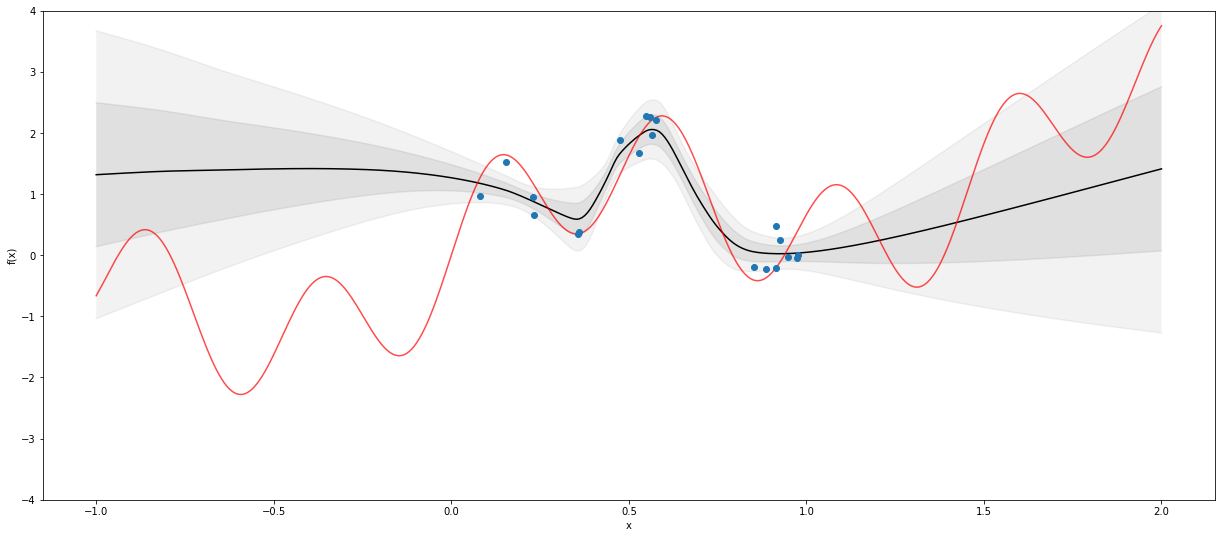

In [65]:
upper1 = np.mean(predictions[:,1:].detach().numpy(),1) + np.std(predictions[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions[:,1:].detach().numpy(),1) + 2 * np.std(predictions[:,1:].detach().numpy(),1)

lower1 = np.mean(predictions[:,1:].detach().numpy(),1) - np.std(predictions[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions[:,1:].detach().numpy(),1) - 2 * np.std(predictions[:,1:].detach().numpy(),1)


plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions[:,1:].detach().numpy(),1),'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r',alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)
plt.xlabel('x')
plt.ylabel('f(x)')

### pSGLD

In [76]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld


lambda_ = 1.
lr = 1e-12
alpha = 0.99


batch_size = 20
dataset_size= 20



x_test = torch.FloatTensor(grid)
y_test = torch.FloatTensor(y_true)

# learning_rates = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14]
# learning_rates = [5e-13, 4e-13, 3e-13, 2e-13, 1e-13, 9e-14, 8e-14, 7e-14, 6e-14, 5e-14]
learning_rates = [8e-14]
rmse_result = np.zeros((1,len(learning_rates)))


for i,lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = psgld.optim.psgld(network, lr, lambda_, alpha, batch_size, dataset_size)
    predictions_psgld = torch.zeros(400,1)
    t = 1.
    
    for epoch in range(10000):
        running_loss = 0
        network.zero_grad()
        output = network(x)
        loss = (1./(2*0.0009))*criterion(output, y)
        loss.backward()
        optim.step()

        running_loss += loss * batch_size / dataset_size


        if (t >= 100) & (t % 100 == 0):
            with torch.autograd.no_grad():
                output = network(x_test)
                predictions_psgld = torch.cat((predictions_psgld, output), 1)

        t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    rmse_result[:,i] = torch.sqrt(criterion(y_test, torch.mean(predictions_psgld,1).view(-1,1)))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 15900.8613
Epoch 1 - loss: 21119.2422
Epoch 2 - loss: 26669.1055
Epoch 3 - loss: 9550.4033
Epoch 4 - loss: 9239.9941
Epoch 5 - loss: 8977.0107
Epoch 6 - loss: 8691.3730
Epoch 7 - loss: 8412.0518
Epoch 8 - loss: 8159.8218
Epoch 9 - loss: 7851.2031
Epoch 10 - loss: 7595.3853
Epoch 11 - loss: 7380.3311
Epoch 12 - loss: 7135.2607
Epoch 13 - loss: 6905.0508
Epoch 14 - loss: 6747.7329
Epoch 15 - loss: 6601.2983
Epoch 16 - loss: 6532.4351
Epoch 17 - loss: 6530.5630
Epoch 18 - loss: 7205.9541
Epoch 19 - loss: 9239.0117
Epoch 20 - loss: 13092.4268
Epoch 21 - loss: 10657.4531
Epoch 22 - loss: 9155.0879
Epoch 23 - loss: 7007.2959
Epoch 24 - loss: 6615.1094
Epoch 25 - loss: 6345.9736
Epoch 26 - loss: 6194.2344
Epoch 27 - loss: 6094.9214
Epoch 28 - loss: 5977.1558
Epoch 29 - loss: 5972.2114
Epoch 30 - loss: 5994.2544
Epoch 31 - loss: 6425.6387
Epoch 32 - loss: 7111.5479
Epoch 33 - loss: 8824.0996
Epoch 34 - loss: 9816.1006
Epoch 35 - loss: 8552.5508
Epoch 36 - loss: 7283.6118
Epoch 

Epoch 329 - loss: 2016.5242
Epoch 330 - loss: 2019.2487
Epoch 331 - loss: 2050.0361
Epoch 332 - loss: 2137.3342
Epoch 333 - loss: 2273.1528
Epoch 334 - loss: 2710.3982
Epoch 335 - loss: 3064.4529
Epoch 336 - loss: 4056.1919
Epoch 337 - loss: 4213.8110
Epoch 338 - loss: 4874.0835
Epoch 339 - loss: 3941.8999
Epoch 340 - loss: 3506.3149
Epoch 341 - loss: 3190.3906
Epoch 342 - loss: 3274.4990
Epoch 343 - loss: 3179.6299
Epoch 344 - loss: 3265.3789
Epoch 345 - loss: 3488.5769
Epoch 346 - loss: 3521.6831
Epoch 347 - loss: 3876.8716
Epoch 348 - loss: 4091.5652
Epoch 349 - loss: 3865.1804
Epoch 350 - loss: 4264.4829
Epoch 351 - loss: 4010.3184
Epoch 352 - loss: 4116.9453
Epoch 353 - loss: 3781.9517
Epoch 354 - loss: 3504.2007
Epoch 355 - loss: 3615.5066
Epoch 356 - loss: 3890.1179
Epoch 357 - loss: 3728.6948
Epoch 358 - loss: 3617.5308
Epoch 359 - loss: 3457.5332
Epoch 360 - loss: 3352.8860
Epoch 361 - loss: 3174.5178
Epoch 362 - loss: 3267.4685
Epoch 363 - loss: 3022.8723
Epoch 364 - loss: 28

Epoch 665 - loss: 1847.7849
Epoch 666 - loss: 1976.1526
Epoch 667 - loss: 1910.3303
Epoch 668 - loss: 1903.6296
Epoch 669 - loss: 1802.7371
Epoch 670 - loss: 1844.7985
Epoch 671 - loss: 1870.4111
Epoch 672 - loss: 2047.6520
Epoch 673 - loss: 2294.8682
Epoch 674 - loss: 2954.9866
Epoch 675 - loss: 3960.0776
Epoch 676 - loss: 5170.9004
Epoch 677 - loss: 4995.3101
Epoch 678 - loss: 3061.8389
Epoch 679 - loss: 2523.3354
Epoch 680 - loss: 2318.2051
Epoch 681 - loss: 2299.1763
Epoch 682 - loss: 2387.2310
Epoch 683 - loss: 2307.3286
Epoch 684 - loss: 2363.8306
Epoch 685 - loss: 2249.0391
Epoch 686 - loss: 2305.2244
Epoch 687 - loss: 2288.9585
Epoch 688 - loss: 2310.2988
Epoch 689 - loss: 2368.8352
Epoch 690 - loss: 2461.5908
Epoch 691 - loss: 2638.1292
Epoch 692 - loss: 2636.7090
Epoch 693 - loss: 2649.8079
Epoch 694 - loss: 2859.6584
Epoch 695 - loss: 2931.2451
Epoch 696 - loss: 3117.9534
Epoch 697 - loss: 2966.6685
Epoch 698 - loss: 3108.9485
Epoch 699 - loss: 3088.1797
Epoch 700 - loss: 30

Epoch 1020 - loss: 2012.8079
Epoch 1021 - loss: 2024.5459
Epoch 1022 - loss: 2030.9443
Epoch 1023 - loss: 2184.2266
Epoch 1024 - loss: 2390.9448
Epoch 1025 - loss: 2770.1560
Epoch 1026 - loss: 3563.1711
Epoch 1027 - loss: 4937.6929
Epoch 1028 - loss: 5625.1250
Epoch 1029 - loss: 5150.7607
Epoch 1030 - loss: 2556.2266
Epoch 1031 - loss: 1610.6263
Epoch 1032 - loss: 1338.0098
Epoch 1033 - loss: 1309.7623
Epoch 1034 - loss: 1325.8522
Epoch 1035 - loss: 1359.2600
Epoch 1036 - loss: 1350.1338
Epoch 1037 - loss: 1308.0032
Epoch 1038 - loss: 1308.2557
Epoch 1039 - loss: 1299.4476
Epoch 1040 - loss: 1299.1055
Epoch 1041 - loss: 1281.0625
Epoch 1042 - loss: 1304.3436
Epoch 1043 - loss: 1271.9860
Epoch 1044 - loss: 1299.2069
Epoch 1045 - loss: 1408.4998
Epoch 1046 - loss: 1429.0752
Epoch 1047 - loss: 1422.2207
Epoch 1048 - loss: 1452.1323
Epoch 1049 - loss: 1565.4980
Epoch 1050 - loss: 1818.3230
Epoch 1051 - loss: 1932.4211
Epoch 1052 - loss: 2141.1238
Epoch 1053 - loss: 2416.1965
Epoch 1054 - l

Epoch 1326 - loss: 1018.3716
Epoch 1327 - loss: 1011.3854
Epoch 1328 - loss: 1010.5317
Epoch 1329 - loss: 971.8114
Epoch 1330 - loss: 970.1495
Epoch 1331 - loss: 989.5848
Epoch 1332 - loss: 1012.3597
Epoch 1333 - loss: 1029.4824
Epoch 1334 - loss: 1011.1954
Epoch 1335 - loss: 989.1058
Epoch 1336 - loss: 1014.4725
Epoch 1337 - loss: 968.1061
Epoch 1338 - loss: 1017.2829
Epoch 1339 - loss: 1038.7561
Epoch 1340 - loss: 1071.4299
Epoch 1341 - loss: 1058.2715
Epoch 1342 - loss: 1002.2425
Epoch 1343 - loss: 1081.0486
Epoch 1344 - loss: 1205.9052
Epoch 1345 - loss: 1301.1552
Epoch 1346 - loss: 1479.0515
Epoch 1347 - loss: 1660.3571
Epoch 1348 - loss: 1862.6484
Epoch 1349 - loss: 2228.9966
Epoch 1350 - loss: 2425.1577
Epoch 1351 - loss: 2369.3196
Epoch 1352 - loss: 2297.1294
Epoch 1353 - loss: 2066.3352
Epoch 1354 - loss: 1865.4417
Epoch 1355 - loss: 1611.1719
Epoch 1356 - loss: 1643.2396
Epoch 1357 - loss: 1750.9199
Epoch 1358 - loss: 1908.3268
Epoch 1359 - loss: 1840.2561
Epoch 1360 - loss: 

Epoch 1636 - loss: 865.1808
Epoch 1637 - loss: 895.8165
Epoch 1638 - loss: 966.0543
Epoch 1639 - loss: 1015.0450
Epoch 1640 - loss: 1065.9795
Epoch 1641 - loss: 1088.7255
Epoch 1642 - loss: 1103.2518
Epoch 1643 - loss: 1227.6052
Epoch 1644 - loss: 1462.2144
Epoch 1645 - loss: 1675.9641
Epoch 1646 - loss: 2041.4742
Epoch 1647 - loss: 2339.7825
Epoch 1648 - loss: 2374.3079
Epoch 1649 - loss: 2503.5703
Epoch 1650 - loss: 2282.0229
Epoch 1651 - loss: 2259.3350
Epoch 1652 - loss: 2052.5923
Epoch 1653 - loss: 1843.1873
Epoch 1654 - loss: 1466.5261
Epoch 1655 - loss: 1318.8225
Epoch 1656 - loss: 1181.3073
Epoch 1657 - loss: 1157.0876
Epoch 1658 - loss: 1174.2720
Epoch 1659 - loss: 1001.5909
Epoch 1660 - loss: 962.9550
Epoch 1661 - loss: 977.2196
Epoch 1662 - loss: 946.9141
Epoch 1663 - loss: 910.3713
Epoch 1664 - loss: 859.6517
Epoch 1665 - loss: 840.4468
Epoch 1666 - loss: 835.9788
Epoch 1667 - loss: 815.7810
Epoch 1668 - loss: 797.6294
Epoch 1669 - loss: 785.0459
Epoch 1670 - loss: 767.4074

Epoch 1926 - loss: 739.6635
Epoch 1927 - loss: 768.4704
Epoch 1928 - loss: 791.0851
Epoch 1929 - loss: 788.5884
Epoch 1930 - loss: 831.2471
Epoch 1931 - loss: 899.2704
Epoch 1932 - loss: 982.9549
Epoch 1933 - loss: 1177.9803
Epoch 1934 - loss: 1282.6434
Epoch 1935 - loss: 1565.4629
Epoch 1936 - loss: 1888.3047
Epoch 1937 - loss: 2140.5540
Epoch 1938 - loss: 2131.3245
Epoch 1939 - loss: 1943.4954
Epoch 1940 - loss: 1786.6506
Epoch 1941 - loss: 1493.3417
Epoch 1942 - loss: 1343.3910
Epoch 1943 - loss: 1177.1836
Epoch 1944 - loss: 1078.2550
Epoch 1945 - loss: 946.9528
Epoch 1946 - loss: 922.8055
Epoch 1947 - loss: 906.5275
Epoch 1948 - loss: 857.8395
Epoch 1949 - loss: 865.1089
Epoch 1950 - loss: 835.9149
Epoch 1951 - loss: 816.7903
Epoch 1952 - loss: 815.6898
Epoch 1953 - loss: 816.8311
Epoch 1954 - loss: 827.6838
Epoch 1955 - loss: 811.9482
Epoch 1956 - loss: 817.7217
Epoch 1957 - loss: 813.6054
Epoch 1958 - loss: 815.0030
Epoch 1959 - loss: 802.5225
Epoch 1960 - loss: 818.8638
Epoch 19

Epoch 2219 - loss: 1229.7551
Epoch 2220 - loss: 1251.6776
Epoch 2221 - loss: 1094.9553
Epoch 2222 - loss: 997.8730
Epoch 2223 - loss: 931.3643
Epoch 2224 - loss: 912.8264
Epoch 2225 - loss: 890.9818
Epoch 2226 - loss: 955.6289
Epoch 2227 - loss: 869.7264
Epoch 2228 - loss: 818.6116
Epoch 2229 - loss: 868.6691
Epoch 2230 - loss: 893.8922
Epoch 2231 - loss: 880.3719
Epoch 2232 - loss: 848.0851
Epoch 2233 - loss: 898.7491
Epoch 2234 - loss: 958.8415
Epoch 2235 - loss: 977.0545
Epoch 2236 - loss: 981.8547
Epoch 2237 - loss: 939.8255
Epoch 2238 - loss: 1010.4460
Epoch 2239 - loss: 995.9495
Epoch 2240 - loss: 940.5848
Epoch 2241 - loss: 879.6965
Epoch 2242 - loss: 862.0294
Epoch 2243 - loss: 898.0065
Epoch 2244 - loss: 947.7992
Epoch 2245 - loss: 953.4357
Epoch 2246 - loss: 950.1896
Epoch 2247 - loss: 1003.8923
Epoch 2248 - loss: 1122.1606
Epoch 2249 - loss: 1162.8408
Epoch 2250 - loss: 1154.7626
Epoch 2251 - loss: 1215.2620
Epoch 2252 - loss: 1262.3008
Epoch 2253 - loss: 1380.6539
Epoch 225

Epoch 2515 - loss: 1100.1099
Epoch 2516 - loss: 957.7496
Epoch 2517 - loss: 1060.9562
Epoch 2518 - loss: 1162.6576
Epoch 2519 - loss: 1047.6177
Epoch 2520 - loss: 914.2577
Epoch 2521 - loss: 924.2812
Epoch 2522 - loss: 888.1286
Epoch 2523 - loss: 860.6248
Epoch 2524 - loss: 815.5106
Epoch 2525 - loss: 859.4889
Epoch 2526 - loss: 799.9764
Epoch 2527 - loss: 714.0415
Epoch 2528 - loss: 732.5362
Epoch 2529 - loss: 742.1639
Epoch 2530 - loss: 701.3772
Epoch 2531 - loss: 694.4507
Epoch 2532 - loss: 733.6655
Epoch 2533 - loss: 686.1070
Epoch 2534 - loss: 682.8989
Epoch 2535 - loss: 703.7159
Epoch 2536 - loss: 741.6566
Epoch 2537 - loss: 734.6539
Epoch 2538 - loss: 724.3882
Epoch 2539 - loss: 768.8604
Epoch 2540 - loss: 867.5720
Epoch 2541 - loss: 781.3192
Epoch 2542 - loss: 808.3450
Epoch 2543 - loss: 935.3182
Epoch 2544 - loss: 1051.4606
Epoch 2545 - loss: 977.3815
Epoch 2546 - loss: 1047.1915
Epoch 2547 - loss: 968.9048
Epoch 2548 - loss: 1049.8616
Epoch 2549 - loss: 1035.4769
Epoch 2550 -

Epoch 2861 - loss: 636.6769
Epoch 2862 - loss: 643.3449
Epoch 2863 - loss: 632.8364
Epoch 2864 - loss: 609.1938
Epoch 2865 - loss: 596.4130
Epoch 2866 - loss: 592.4753
Epoch 2867 - loss: 601.2559
Epoch 2868 - loss: 598.6738
Epoch 2869 - loss: 602.7609
Epoch 2870 - loss: 595.4667
Epoch 2871 - loss: 599.4143
Epoch 2872 - loss: 593.9297
Epoch 2873 - loss: 591.6174
Epoch 2874 - loss: 598.2559
Epoch 2875 - loss: 589.2343
Epoch 2876 - loss: 604.0934
Epoch 2877 - loss: 607.6740
Epoch 2878 - loss: 614.4982
Epoch 2879 - loss: 604.6393
Epoch 2880 - loss: 615.3698
Epoch 2881 - loss: 606.7697
Epoch 2882 - loss: 636.3541
Epoch 2883 - loss: 652.0243
Epoch 2884 - loss: 717.9882
Epoch 2885 - loss: 818.3500
Epoch 2886 - loss: 798.4190
Epoch 2887 - loss: 911.6223
Epoch 2888 - loss: 991.5182
Epoch 2889 - loss: 1197.1863
Epoch 2890 - loss: 1317.3129
Epoch 2891 - loss: 1449.5742
Epoch 2892 - loss: 1423.5291
Epoch 2893 - loss: 1595.9667
Epoch 2894 - loss: 1643.7126
Epoch 2895 - loss: 1727.8342
Epoch 2896 - 

Epoch 3162 - loss: 1139.8765
Epoch 3163 - loss: 1078.3595
Epoch 3164 - loss: 1081.2153
Epoch 3165 - loss: 1105.8536
Epoch 3166 - loss: 1088.0972
Epoch 3167 - loss: 981.5444
Epoch 3168 - loss: 1023.9587
Epoch 3169 - loss: 984.3480
Epoch 3170 - loss: 934.5363
Epoch 3171 - loss: 844.2775
Epoch 3172 - loss: 793.6656
Epoch 3173 - loss: 742.2985
Epoch 3174 - loss: 705.2504
Epoch 3175 - loss: 721.0400
Epoch 3176 - loss: 742.5329
Epoch 3177 - loss: 725.5129
Epoch 3178 - loss: 721.8308
Epoch 3179 - loss: 721.3422
Epoch 3180 - loss: 693.6580
Epoch 3181 - loss: 721.5367
Epoch 3182 - loss: 761.4866
Epoch 3183 - loss: 791.7384
Epoch 3184 - loss: 772.9954
Epoch 3185 - loss: 764.7528
Epoch 3186 - loss: 735.3543
Epoch 3187 - loss: 763.5370
Epoch 3188 - loss: 750.8854
Epoch 3189 - loss: 798.1313
Epoch 3190 - loss: 798.3975
Epoch 3191 - loss: 859.8239
Epoch 3192 - loss: 956.8412
Epoch 3193 - loss: 1071.4762
Epoch 3194 - loss: 1337.0897
Epoch 3195 - loss: 1594.6204
Epoch 3196 - loss: 1681.8977
Epoch 3197

Epoch 3512 - loss: 656.6883
Epoch 3513 - loss: 679.4642
Epoch 3514 - loss: 698.8590
Epoch 3515 - loss: 652.8223
Epoch 3516 - loss: 695.8623
Epoch 3517 - loss: 698.6667
Epoch 3518 - loss: 714.5870
Epoch 3519 - loss: 803.3663
Epoch 3520 - loss: 788.7425
Epoch 3521 - loss: 774.4181
Epoch 3522 - loss: 822.0350
Epoch 3523 - loss: 796.5339
Epoch 3524 - loss: 788.3843
Epoch 3525 - loss: 687.9274
Epoch 3526 - loss: 700.8748
Epoch 3527 - loss: 732.1071
Epoch 3528 - loss: 723.6476
Epoch 3529 - loss: 711.8834
Epoch 3530 - loss: 743.0176
Epoch 3531 - loss: 740.5905
Epoch 3532 - loss: 713.1686
Epoch 3533 - loss: 743.4962
Epoch 3534 - loss: 671.4982
Epoch 3535 - loss: 641.8232
Epoch 3536 - loss: 609.9883
Epoch 3537 - loss: 619.2377
Epoch 3538 - loss: 604.9882
Epoch 3539 - loss: 620.1292
Epoch 3540 - loss: 603.5151
Epoch 3541 - loss: 640.7462
Epoch 3542 - loss: 724.1553
Epoch 3543 - loss: 768.3898
Epoch 3544 - loss: 827.1097
Epoch 3545 - loss: 948.2321
Epoch 3546 - loss: 1138.1818
Epoch 3547 - loss: 

Epoch 3869 - loss: 1022.1400
Epoch 3870 - loss: 1082.8523
Epoch 3871 - loss: 1024.6277
Epoch 3872 - loss: 1201.7711
Epoch 3873 - loss: 1300.1412
Epoch 3874 - loss: 1393.5150
Epoch 3875 - loss: 1403.8857
Epoch 3876 - loss: 1251.0289
Epoch 3877 - loss: 1147.7823
Epoch 3878 - loss: 1066.5798
Epoch 3879 - loss: 979.0607
Epoch 3880 - loss: 1000.2958
Epoch 3881 - loss: 959.7234
Epoch 3882 - loss: 855.7334
Epoch 3883 - loss: 820.4482
Epoch 3884 - loss: 757.4750
Epoch 3885 - loss: 699.9354
Epoch 3886 - loss: 677.7675
Epoch 3887 - loss: 712.6627
Epoch 3888 - loss: 686.5773
Epoch 3889 - loss: 693.0095
Epoch 3890 - loss: 735.5362
Epoch 3891 - loss: 691.6025
Epoch 3892 - loss: 667.9711
Epoch 3893 - loss: 648.9457
Epoch 3894 - loss: 694.8267
Epoch 3895 - loss: 674.0085
Epoch 3896 - loss: 666.0962
Epoch 3897 - loss: 685.6824
Epoch 3898 - loss: 642.8781
Epoch 3899 - loss: 626.8561
Epoch 3900 - loss: 593.0786
Epoch 3901 - loss: 592.7144
Epoch 3902 - loss: 598.7465
Epoch 3903 - loss: 601.7331
Epoch 390

Epoch 4165 - loss: 555.2871
Epoch 4166 - loss: 560.0722
Epoch 4167 - loss: 557.3770
Epoch 4168 - loss: 557.2438
Epoch 4169 - loss: 555.6849
Epoch 4170 - loss: 553.3267
Epoch 4171 - loss: 554.2327
Epoch 4172 - loss: 556.4316
Epoch 4173 - loss: 552.5602
Epoch 4174 - loss: 556.7224
Epoch 4175 - loss: 561.0705
Epoch 4176 - loss: 572.7208
Epoch 4177 - loss: 555.1207
Epoch 4178 - loss: 552.2660
Epoch 4179 - loss: 554.8360
Epoch 4180 - loss: 563.0192
Epoch 4181 - loss: 575.6891
Epoch 4182 - loss: 621.4544
Epoch 4183 - loss: 647.7987
Epoch 4184 - loss: 753.3134
Epoch 4185 - loss: 904.5099
Epoch 4186 - loss: 1253.9158
Epoch 4187 - loss: 1706.9996
Epoch 4188 - loss: 2534.0022
Epoch 4189 - loss: 3518.4387
Epoch 4190 - loss: 4139.0015
Epoch 4191 - loss: 3457.0503
Epoch 4192 - loss: 2083.5544
Epoch 4193 - loss: 1274.4595
Epoch 4194 - loss: 939.2303
Epoch 4195 - loss: 823.9829
Epoch 4196 - loss: 781.6351
Epoch 4197 - loss: 738.8570
Epoch 4198 - loss: 682.4644
Epoch 4199 - loss: 664.1673
Epoch 4200 -

Epoch 4483 - loss: 830.0980
Epoch 4484 - loss: 694.7731
Epoch 4485 - loss: 646.9681
Epoch 4486 - loss: 612.0049
Epoch 4487 - loss: 604.1058
Epoch 4488 - loss: 618.5280
Epoch 4489 - loss: 667.1882
Epoch 4490 - loss: 753.7863
Epoch 4491 - loss: 768.9777
Epoch 4492 - loss: 823.1678
Epoch 4493 - loss: 796.0045
Epoch 4494 - loss: 966.6727
Epoch 4495 - loss: 1045.2150
Epoch 4496 - loss: 1079.1791
Epoch 4497 - loss: 1138.3391
Epoch 4498 - loss: 1258.6447
Epoch 4499 - loss: 1201.5939
Epoch 4500 - loss: 1139.9399
Epoch 4501 - loss: 1120.3397
Epoch 4502 - loss: 1126.7452
Epoch 4503 - loss: 1143.0295
Epoch 4504 - loss: 1096.1869
Epoch 4505 - loss: 987.4744
Epoch 4506 - loss: 993.7563
Epoch 4507 - loss: 953.8837
Epoch 4508 - loss: 949.8702
Epoch 4509 - loss: 1007.7752
Epoch 4510 - loss: 954.7274
Epoch 4511 - loss: 952.7126
Epoch 4512 - loss: 893.4691
Epoch 4513 - loss: 791.4741
Epoch 4514 - loss: 718.2495
Epoch 4515 - loss: 671.4194
Epoch 4516 - loss: 700.5515
Epoch 4517 - loss: 684.0577
Epoch 451

Epoch 4837 - loss: 583.0874
Epoch 4838 - loss: 644.1887
Epoch 4839 - loss: 671.4237
Epoch 4840 - loss: 654.7816
Epoch 4841 - loss: 625.8693
Epoch 4842 - loss: 631.2186
Epoch 4843 - loss: 638.9905
Epoch 4844 - loss: 677.7320
Epoch 4845 - loss: 743.6133
Epoch 4846 - loss: 723.2476
Epoch 4847 - loss: 779.3550
Epoch 4848 - loss: 781.5458
Epoch 4849 - loss: 864.1295
Epoch 4850 - loss: 948.4276
Epoch 4851 - loss: 955.8629
Epoch 4852 - loss: 1045.6212
Epoch 4853 - loss: 939.8070
Epoch 4854 - loss: 914.5991
Epoch 4855 - loss: 891.3505
Epoch 4856 - loss: 909.3690
Epoch 4857 - loss: 829.7622
Epoch 4858 - loss: 772.5108
Epoch 4859 - loss: 671.6138
Epoch 4860 - loss: 638.7832
Epoch 4861 - loss: 629.5394
Epoch 4862 - loss: 647.8110
Epoch 4863 - loss: 573.8251
Epoch 4864 - loss: 602.4397
Epoch 4865 - loss: 575.2147
Epoch 4866 - loss: 579.2728
Epoch 4867 - loss: 584.0862
Epoch 4868 - loss: 566.0211
Epoch 4869 - loss: 598.9564
Epoch 4870 - loss: 576.6947
Epoch 4871 - loss: 642.8770
Epoch 4872 - loss: 

Epoch 5176 - loss: 670.6254
Epoch 5177 - loss: 686.9297
Epoch 5178 - loss: 684.5307
Epoch 5179 - loss: 751.1536
Epoch 5180 - loss: 779.3205
Epoch 5181 - loss: 798.2112
Epoch 5182 - loss: 859.5293
Epoch 5183 - loss: 930.5511
Epoch 5184 - loss: 1030.3480
Epoch 5185 - loss: 1184.6993
Epoch 5186 - loss: 1328.8722
Epoch 5187 - loss: 1406.2533
Epoch 5188 - loss: 1477.6443
Epoch 5189 - loss: 1520.7601
Epoch 5190 - loss: 1405.8636
Epoch 5191 - loss: 1378.7201
Epoch 5192 - loss: 1314.2985
Epoch 5193 - loss: 1039.8867
Epoch 5194 - loss: 928.8493
Epoch 5195 - loss: 889.7151
Epoch 5196 - loss: 944.4578
Epoch 5197 - loss: 976.9064
Epoch 5198 - loss: 1002.2590
Epoch 5199 - loss: 909.6415
Epoch 5200 - loss: 877.2198
Epoch 5201 - loss: 828.8522
Epoch 5202 - loss: 805.1503
Epoch 5203 - loss: 742.9431
Epoch 5204 - loss: 676.9903
Epoch 5205 - loss: 588.5890
Epoch 5206 - loss: 588.2570
Epoch 5207 - loss: 579.4340
Epoch 5208 - loss: 582.1436
Epoch 5209 - loss: 551.9836
Epoch 5210 - loss: 564.2133
Epoch 521

Epoch 5472 - loss: 522.8233
Epoch 5473 - loss: 530.9617
Epoch 5474 - loss: 522.5256
Epoch 5475 - loss: 525.4308
Epoch 5476 - loss: 519.1776
Epoch 5477 - loss: 525.3310
Epoch 5478 - loss: 530.8115
Epoch 5479 - loss: 534.6471
Epoch 5480 - loss: 529.6494
Epoch 5481 - loss: 523.2651
Epoch 5482 - loss: 530.7535
Epoch 5483 - loss: 546.4897
Epoch 5484 - loss: 546.9658
Epoch 5485 - loss: 557.8172
Epoch 5486 - loss: 592.1812
Epoch 5487 - loss: 623.3908
Epoch 5488 - loss: 702.9742
Epoch 5489 - loss: 724.7881
Epoch 5490 - loss: 761.3414
Epoch 5491 - loss: 838.3014
Epoch 5492 - loss: 1014.3972
Epoch 5493 - loss: 1050.9618
Epoch 5494 - loss: 1152.9167
Epoch 5495 - loss: 1185.4637
Epoch 5496 - loss: 1219.3120
Epoch 5497 - loss: 1086.0718
Epoch 5498 - loss: 1063.1021
Epoch 5499 - loss: 1019.5838
Epoch 5500 - loss: 853.8463
Epoch 5501 - loss: 757.2932
Epoch 5502 - loss: 698.4991
Epoch 5503 - loss: 651.2575
Epoch 5504 - loss: 623.2245
Epoch 5505 - loss: 644.3929
Epoch 5506 - loss: 663.0315
Epoch 5507 -

Epoch 5778 - loss: 659.7819
Epoch 5779 - loss: 681.1812
Epoch 5780 - loss: 645.8950
Epoch 5781 - loss: 631.3839
Epoch 5782 - loss: 643.3256
Epoch 5783 - loss: 680.7042
Epoch 5784 - loss: 748.2272
Epoch 5785 - loss: 760.9655
Epoch 5786 - loss: 723.1887
Epoch 5787 - loss: 748.8360
Epoch 5788 - loss: 674.3820
Epoch 5789 - loss: 675.0023
Epoch 5790 - loss: 704.4215
Epoch 5791 - loss: 738.3729
Epoch 5792 - loss: 768.3542
Epoch 5793 - loss: 813.1815
Epoch 5794 - loss: 766.3450
Epoch 5795 - loss: 784.9487
Epoch 5796 - loss: 806.0801
Epoch 5797 - loss: 762.1653
Epoch 5798 - loss: 761.9475
Epoch 5799 - loss: 761.1906
Epoch 5800 - loss: 770.9069
Epoch 5801 - loss: 816.7877
Epoch 5802 - loss: 728.3510
Epoch 5803 - loss: 770.0891
Epoch 5804 - loss: 826.8632
Epoch 5805 - loss: 844.6697
Epoch 5806 - loss: 940.9718
Epoch 5807 - loss: 1026.3265
Epoch 5808 - loss: 1074.2760
Epoch 5809 - loss: 937.7904
Epoch 5810 - loss: 733.4827
Epoch 5811 - loss: 718.8169
Epoch 5812 - loss: 612.9708
Epoch 5813 - loss:

Epoch 6130 - loss: 510.8337
Epoch 6131 - loss: 511.2436
Epoch 6132 - loss: 530.6743
Epoch 6133 - loss: 540.5452
Epoch 6134 - loss: 556.8643
Epoch 6135 - loss: 622.5193
Epoch 6136 - loss: 655.0578
Epoch 6137 - loss: 709.8508
Epoch 6138 - loss: 791.9531
Epoch 6139 - loss: 843.6075
Epoch 6140 - loss: 866.6180
Epoch 6141 - loss: 851.1525
Epoch 6142 - loss: 867.3856
Epoch 6143 - loss: 827.1009
Epoch 6144 - loss: 730.1813
Epoch 6145 - loss: 671.7074
Epoch 6146 - loss: 722.1693
Epoch 6147 - loss: 719.2850
Epoch 6148 - loss: 690.8776
Epoch 6149 - loss: 640.8693
Epoch 6150 - loss: 630.5448
Epoch 6151 - loss: 636.0726
Epoch 6152 - loss: 593.0212
Epoch 6153 - loss: 580.8011
Epoch 6154 - loss: 573.4196
Epoch 6155 - loss: 577.9725
Epoch 6156 - loss: 592.6066
Epoch 6157 - loss: 648.7877
Epoch 6158 - loss: 604.7726
Epoch 6159 - loss: 571.9034
Epoch 6160 - loss: 558.3577
Epoch 6161 - loss: 575.4514
Epoch 6162 - loss: 602.2238
Epoch 6163 - loss: 631.4745
Epoch 6164 - loss: 605.2026
Epoch 6165 - loss: 6

Epoch 6461 - loss: 632.2367
Epoch 6462 - loss: 637.2934
Epoch 6463 - loss: 637.1846
Epoch 6464 - loss: 641.2377
Epoch 6465 - loss: 690.5856
Epoch 6466 - loss: 732.8043
Epoch 6467 - loss: 710.4196
Epoch 6468 - loss: 683.5525
Epoch 6469 - loss: 645.8123
Epoch 6470 - loss: 620.7303
Epoch 6471 - loss: 651.0093
Epoch 6472 - loss: 690.9763
Epoch 6473 - loss: 737.1664
Epoch 6474 - loss: 712.4653
Epoch 6475 - loss: 785.4036
Epoch 6476 - loss: 781.0615
Epoch 6477 - loss: 825.0008
Epoch 6478 - loss: 868.9718
Epoch 6479 - loss: 870.1156
Epoch 6480 - loss: 824.0983
Epoch 6481 - loss: 799.5192
Epoch 6482 - loss: 726.2784
Epoch 6483 - loss: 677.1230
Epoch 6484 - loss: 643.4865
Epoch 6485 - loss: 582.2582
Epoch 6486 - loss: 583.8933
Epoch 6487 - loss: 596.0167
Epoch 6488 - loss: 582.1938
Epoch 6489 - loss: 603.9417
Epoch 6490 - loss: 559.5983
Epoch 6491 - loss: 547.1904
Epoch 6492 - loss: 548.3516
Epoch 6493 - loss: 566.8540
Epoch 6494 - loss: 516.0435
Epoch 6495 - loss: 527.0097
Epoch 6496 - loss: 5

Epoch 6811 - loss: 504.2267
Epoch 6812 - loss: 494.0151
Epoch 6813 - loss: 498.2773
Epoch 6814 - loss: 491.3350
Epoch 6815 - loss: 490.2203
Epoch 6816 - loss: 504.8970
Epoch 6817 - loss: 507.2022
Epoch 6818 - loss: 525.0806
Epoch 6819 - loss: 517.5775
Epoch 6820 - loss: 543.8992
Epoch 6821 - loss: 543.6766
Epoch 6822 - loss: 541.3895
Epoch 6823 - loss: 539.2557
Epoch 6824 - loss: 542.1071
Epoch 6825 - loss: 562.6136
Epoch 6826 - loss: 609.3371
Epoch 6827 - loss: 596.2126
Epoch 6828 - loss: 632.2852
Epoch 6829 - loss: 635.0316
Epoch 6830 - loss: 603.8949
Epoch 6831 - loss: 585.9076
Epoch 6832 - loss: 611.5871
Epoch 6833 - loss: 723.8937
Epoch 6834 - loss: 827.7506
Epoch 6835 - loss: 1136.7913
Epoch 6836 - loss: 1616.9573
Epoch 6837 - loss: 2338.8967
Epoch 6838 - loss: 2573.7744
Epoch 6839 - loss: 2521.5134
Epoch 6840 - loss: 2216.1350
Epoch 6841 - loss: 1406.8613
Epoch 6842 - loss: 941.4424
Epoch 6843 - loss: 689.0475
Epoch 6844 - loss: 603.3406
Epoch 6845 - loss: 566.1025
Epoch 6846 - 

Epoch 7119 - loss: 884.1569
Epoch 7120 - loss: 926.7449
Epoch 7121 - loss: 1143.4602
Epoch 7122 - loss: 1280.3176
Epoch 7123 - loss: 1391.4017
Epoch 7124 - loss: 1511.8164
Epoch 7125 - loss: 1456.0629
Epoch 7126 - loss: 1312.4803
Epoch 7127 - loss: 1170.5826
Epoch 7128 - loss: 1038.6764
Epoch 7129 - loss: 908.5153
Epoch 7130 - loss: 854.7384
Epoch 7131 - loss: 769.8759
Epoch 7132 - loss: 791.7991
Epoch 7133 - loss: 822.8422
Epoch 7134 - loss: 952.0426
Epoch 7135 - loss: 1051.4152
Epoch 7136 - loss: 1052.1698
Epoch 7137 - loss: 915.3199
Epoch 7138 - loss: 732.5943
Epoch 7139 - loss: 703.8533
Epoch 7140 - loss: 634.9412
Epoch 7141 - loss: 599.3163
Epoch 7142 - loss: 546.8122
Epoch 7143 - loss: 523.6394
Epoch 7144 - loss: 524.3297
Epoch 7145 - loss: 522.3143
Epoch 7146 - loss: 515.7869
Epoch 7147 - loss: 511.5666
Epoch 7148 - loss: 511.0996
Epoch 7149 - loss: 542.3162
Epoch 7150 - loss: 522.4077
Epoch 7151 - loss: 523.2157
Epoch 7152 - loss: 513.3082
Epoch 7153 - loss: 530.4141
Epoch 7154

Epoch 7419 - loss: 606.8207
Epoch 7420 - loss: 642.3558
Epoch 7421 - loss: 741.3335
Epoch 7422 - loss: 735.7492
Epoch 7423 - loss: 899.5637
Epoch 7424 - loss: 974.2157
Epoch 7425 - loss: 1149.4756
Epoch 7426 - loss: 1027.9246
Epoch 7427 - loss: 973.3298
Epoch 7428 - loss: 809.8806
Epoch 7429 - loss: 722.7899
Epoch 7430 - loss: 633.6601
Epoch 7431 - loss: 644.4337
Epoch 7432 - loss: 595.5876
Epoch 7433 - loss: 553.2141
Epoch 7434 - loss: 528.2057
Epoch 7435 - loss: 520.5735
Epoch 7436 - loss: 564.2440
Epoch 7437 - loss: 598.6703
Epoch 7438 - loss: 622.9642
Epoch 7439 - loss: 622.6058
Epoch 7440 - loss: 622.7364
Epoch 7441 - loss: 628.4589
Epoch 7442 - loss: 653.1597
Epoch 7443 - loss: 704.9131
Epoch 7444 - loss: 769.4930
Epoch 7445 - loss: 903.6942
Epoch 7446 - loss: 979.2601
Epoch 7447 - loss: 1092.7441
Epoch 7448 - loss: 1233.0065
Epoch 7449 - loss: 1496.9639
Epoch 7450 - loss: 1757.5787
Epoch 7451 - loss: 1803.4172
Epoch 7452 - loss: 1764.2133
Epoch 7453 - loss: 1566.4120
Epoch 7454 

Epoch 7726 - loss: 518.3354
Epoch 7727 - loss: 542.9414
Epoch 7728 - loss: 597.5339
Epoch 7729 - loss: 627.9561
Epoch 7730 - loss: 755.7685
Epoch 7731 - loss: 784.9175
Epoch 7732 - loss: 853.1136
Epoch 7733 - loss: 942.2638
Epoch 7734 - loss: 1073.3052
Epoch 7735 - loss: 1256.2030
Epoch 7736 - loss: 1515.7458
Epoch 7737 - loss: 1753.8723
Epoch 7738 - loss: 1880.9476
Epoch 7739 - loss: 2223.7549
Epoch 7740 - loss: 1883.7170
Epoch 7741 - loss: 1967.8588
Epoch 7742 - loss: 1644.4495
Epoch 7743 - loss: 1341.2040
Epoch 7744 - loss: 1141.8899
Epoch 7745 - loss: 943.0828
Epoch 7746 - loss: 767.8868
Epoch 7747 - loss: 690.0479
Epoch 7748 - loss: 656.1031
Epoch 7749 - loss: 699.8826
Epoch 7750 - loss: 658.0923
Epoch 7751 - loss: 651.3094
Epoch 7752 - loss: 599.4208
Epoch 7753 - loss: 571.6167
Epoch 7754 - loss: 543.0638
Epoch 7755 - loss: 551.0680
Epoch 7756 - loss: 563.1683
Epoch 7757 - loss: 544.9540
Epoch 7758 - loss: 562.6615
Epoch 7759 - loss: 551.3971
Epoch 7760 - loss: 563.3591
Epoch 776

Epoch 8019 - loss: 568.7434
Epoch 8020 - loss: 569.0386
Epoch 8021 - loss: 571.2777
Epoch 8022 - loss: 564.5309
Epoch 8023 - loss: 599.5582
Epoch 8024 - loss: 624.9651
Epoch 8025 - loss: 608.1096
Epoch 8026 - loss: 591.1581
Epoch 8027 - loss: 604.6088
Epoch 8028 - loss: 713.1176
Epoch 8029 - loss: 746.7775
Epoch 8030 - loss: 776.4113
Epoch 8031 - loss: 800.1790
Epoch 8032 - loss: 914.3947
Epoch 8033 - loss: 1019.8988
Epoch 8034 - loss: 1023.1676
Epoch 8035 - loss: 1119.8777
Epoch 8036 - loss: 1052.2758
Epoch 8037 - loss: 1100.0377
Epoch 8038 - loss: 965.6102
Epoch 8039 - loss: 962.6534
Epoch 8040 - loss: 899.0744
Epoch 8041 - loss: 897.3929
Epoch 8042 - loss: 778.0495
Epoch 8043 - loss: 713.3455
Epoch 8044 - loss: 648.8832
Epoch 8045 - loss: 626.2612
Epoch 8046 - loss: 592.5791
Epoch 8047 - loss: 564.1511
Epoch 8048 - loss: 560.1572
Epoch 8049 - loss: 552.1262
Epoch 8050 - loss: 599.0709
Epoch 8051 - loss: 616.5844
Epoch 8052 - loss: 661.4739
Epoch 8053 - loss: 698.3600
Epoch 8054 - lo

Epoch 8380 - loss: 636.0490
Epoch 8381 - loss: 724.5854
Epoch 8382 - loss: 845.7741
Epoch 8383 - loss: 1156.3219
Epoch 8384 - loss: 1682.3656
Epoch 8385 - loss: 1931.9915
Epoch 8386 - loss: 1623.0547
Epoch 8387 - loss: 1307.8075
Epoch 8388 - loss: 948.4388
Epoch 8389 - loss: 842.3493
Epoch 8390 - loss: 788.2238
Epoch 8391 - loss: 801.7363
Epoch 8392 - loss: 850.9711
Epoch 8393 - loss: 825.6204
Epoch 8394 - loss: 801.0100
Epoch 8395 - loss: 680.3524
Epoch 8396 - loss: 657.2319
Epoch 8397 - loss: 620.2765
Epoch 8398 - loss: 585.6406
Epoch 8399 - loss: 567.5900
Epoch 8400 - loss: 579.1024
Epoch 8401 - loss: 560.7166
Epoch 8402 - loss: 522.1273
Epoch 8403 - loss: 529.3240
Epoch 8404 - loss: 532.0067
Epoch 8405 - loss: 539.5305
Epoch 8406 - loss: 518.6694
Epoch 8407 - loss: 552.7034
Epoch 8408 - loss: 540.7293
Epoch 8409 - loss: 557.3083
Epoch 8410 - loss: 620.2250
Epoch 8411 - loss: 654.8906
Epoch 8412 - loss: 645.3357
Epoch 8413 - loss: 766.5925
Epoch 8414 - loss: 947.2531
Epoch 8415 - lo

Epoch 8744 - loss: 493.6611
Epoch 8745 - loss: 493.8848
Epoch 8746 - loss: 501.9225
Epoch 8747 - loss: 494.1288
Epoch 8748 - loss: 490.2011
Epoch 8749 - loss: 511.8145
Epoch 8750 - loss: 535.8793
Epoch 8751 - loss: 579.3992
Epoch 8752 - loss: 648.1470
Epoch 8753 - loss: 821.7797
Epoch 8754 - loss: 891.7540
Epoch 8755 - loss: 1009.7308
Epoch 8756 - loss: 1168.5404
Epoch 8757 - loss: 1301.9730
Epoch 8758 - loss: 1251.8263
Epoch 8759 - loss: 1329.4983
Epoch 8760 - loss: 1082.1560
Epoch 8761 - loss: 960.3138
Epoch 8762 - loss: 879.8827
Epoch 8763 - loss: 967.0640
Epoch 8764 - loss: 1109.9675
Epoch 8765 - loss: 1215.4211
Epoch 8766 - loss: 1539.9683
Epoch 8767 - loss: 1462.7993
Epoch 8768 - loss: 1387.2003
Epoch 8769 - loss: 1133.1449
Epoch 8770 - loss: 1022.9481
Epoch 8771 - loss: 783.3782
Epoch 8772 - loss: 656.8129
Epoch 8773 - loss: 615.3727
Epoch 8774 - loss: 553.5734
Epoch 8775 - loss: 594.8438
Epoch 8776 - loss: 554.9473
Epoch 8777 - loss: 509.2756
Epoch 8778 - loss: 500.9936
Epoch 8

Epoch 9079 - loss: 643.9721
Epoch 9080 - loss: 601.4940
Epoch 9081 - loss: 569.0658
Epoch 9082 - loss: 597.3758
Epoch 9083 - loss: 578.7972
Epoch 9084 - loss: 581.3019
Epoch 9085 - loss: 568.2742
Epoch 9086 - loss: 577.3531
Epoch 9087 - loss: 591.1185
Epoch 9088 - loss: 601.9143
Epoch 9089 - loss: 662.9100
Epoch 9090 - loss: 651.0889
Epoch 9091 - loss: 613.0518
Epoch 9092 - loss: 589.7229
Epoch 9093 - loss: 553.5317
Epoch 9094 - loss: 579.3450
Epoch 9095 - loss: 562.0716
Epoch 9096 - loss: 528.8989
Epoch 9097 - loss: 491.7527
Epoch 9098 - loss: 522.0842
Epoch 9099 - loss: 486.8180
Epoch 9100 - loss: 476.7836
Epoch 9101 - loss: 488.3518
Epoch 9102 - loss: 510.5421
Epoch 9103 - loss: 532.8206
Epoch 9104 - loss: 516.1556
Epoch 9105 - loss: 518.0464
Epoch 9106 - loss: 568.8939
Epoch 9107 - loss: 551.7509
Epoch 9108 - loss: 594.2108
Epoch 9109 - loss: 655.2687
Epoch 9110 - loss: 631.4310
Epoch 9111 - loss: 728.4311
Epoch 9112 - loss: 795.2126
Epoch 9113 - loss: 1028.2701
Epoch 9114 - loss: 

Epoch 9420 - loss: 1672.0094
Epoch 9421 - loss: 1506.4393
Epoch 9422 - loss: 955.8492
Epoch 9423 - loss: 712.7708
Epoch 9424 - loss: 614.1758
Epoch 9425 - loss: 648.5211
Epoch 9426 - loss: 675.0505
Epoch 9427 - loss: 672.4636
Epoch 9428 - loss: 725.9125
Epoch 9429 - loss: 793.7678
Epoch 9430 - loss: 855.0132
Epoch 9431 - loss: 1021.1759
Epoch 9432 - loss: 1047.1324
Epoch 9433 - loss: 1075.4746
Epoch 9434 - loss: 1090.1680
Epoch 9435 - loss: 1038.4413
Epoch 9436 - loss: 1193.6405
Epoch 9437 - loss: 1107.6270
Epoch 9438 - loss: 1239.0435
Epoch 9439 - loss: 1043.8810
Epoch 9440 - loss: 1038.3744
Epoch 9441 - loss: 893.6517
Epoch 9442 - loss: 793.6641
Epoch 9443 - loss: 695.0721
Epoch 9444 - loss: 657.3474
Epoch 9445 - loss: 695.1315
Epoch 9446 - loss: 719.0043
Epoch 9447 - loss: 731.4688
Epoch 9448 - loss: 775.8040
Epoch 9449 - loss: 851.3048
Epoch 9450 - loss: 847.7018
Epoch 9451 - loss: 829.5077
Epoch 9452 - loss: 809.3599
Epoch 9453 - loss: 814.7512
Epoch 9454 - loss: 840.4327
Epoch 94

Epoch 9762 - loss: 587.9609
Epoch 9763 - loss: 650.3073
Epoch 9764 - loss: 660.9186
Epoch 9765 - loss: 646.1834
Epoch 9766 - loss: 629.1532
Epoch 9767 - loss: 583.3506
Epoch 9768 - loss: 606.2970
Epoch 9769 - loss: 629.0818
Epoch 9770 - loss: 611.8837
Epoch 9771 - loss: 631.0370
Epoch 9772 - loss: 666.4078
Epoch 9773 - loss: 594.6261
Epoch 9774 - loss: 636.8220
Epoch 9775 - loss: 645.8977
Epoch 9776 - loss: 619.5293
Epoch 9777 - loss: 537.6541
Epoch 9778 - loss: 556.8004
Epoch 9779 - loss: 543.7695
Epoch 9780 - loss: 515.1235
Epoch 9781 - loss: 522.4754
Epoch 9782 - loss: 541.8579
Epoch 9783 - loss: 560.3194
Epoch 9784 - loss: 594.3541
Epoch 9785 - loss: 702.2349
Epoch 9786 - loss: 727.5099
Epoch 9787 - loss: 765.8194
Epoch 9788 - loss: 749.9750
Epoch 9789 - loss: 773.4478
Epoch 9790 - loss: 811.4835
Epoch 9791 - loss: 907.3859
Epoch 9792 - loss: 955.0845
Epoch 9793 - loss: 925.3489
Epoch 9794 - loss: 838.2899
Epoch 9795 - loss: 791.5365
Epoch 9796 - loss: 681.2211
Epoch 9797 - loss: 5

Text(0,0.5,'f(x)')

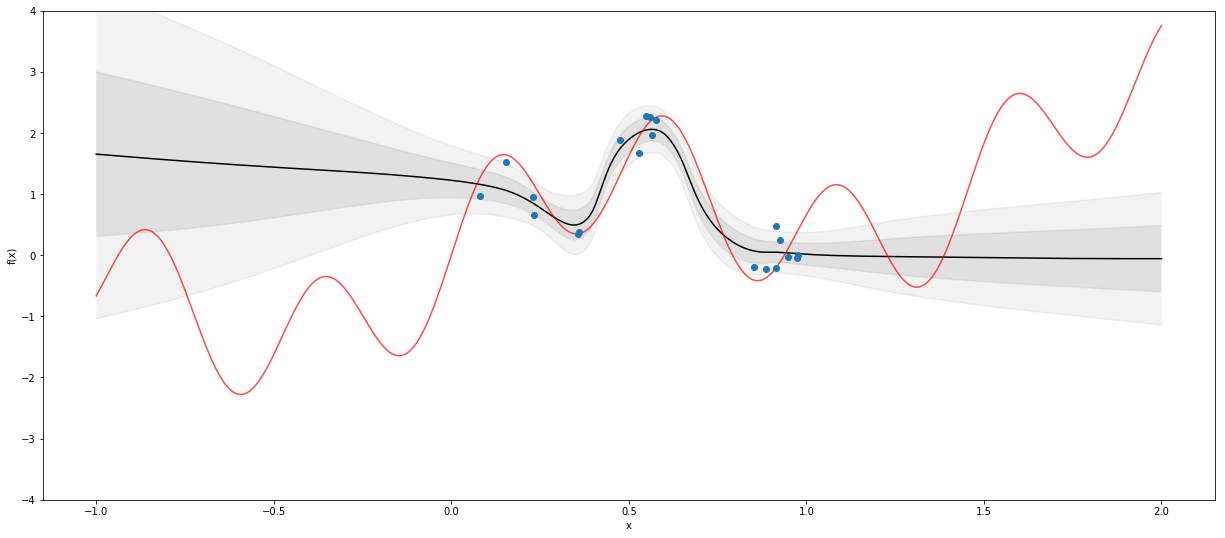

In [77]:
upper1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + np.std(predictions_psgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_psgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)
plt.xlabel('x')
plt.ylabel('f(x)')

### KSGLD

In [15]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgld

eta = 1.
v = 0.
lambda_ = 1.
l2 = 1e-3


batch_size = 20
dataset_size= 20

x_test = torch.FloatTensor(grid)
y_test = torch.FloatTensor(y_true)

# learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
# learning_rates = [1e-2, 9e-3, 8e-3, 7e-3, 6e-3, 5e-3]
# learning_rates = [1e-2]
learning_rates = [6e-4]
rmse_result = np.zeros((1,len(learning_rates)))


for i,lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    predictions_ksgld = torch.zeros(400,1)
    
    t = 1.
    for epoch in range(10000):

        running_loss = 0

        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = (1./(2*0.0009))*criterion(output, y)
        loss.backward()
        optim.step()

        running_loss += loss * batch_size / dataset_size


        if (t >= 100) & (t % 100 == 0):
            with torch.autograd.no_grad():
                output = network(x_test)
                predictions_ksgld = torch.cat((predictions_ksgld, output), 1)

        t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    rmse_result[:,i] = torch.sqrt(criterion(y_test, torch.mean(predictions_ksgld,1).view(-1,1)))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 13936.9746
Epoch 1 - loss: 13489.0469
Epoch 2 - loss: 13159.4795
Epoch 3 - loss: 12784.2656
Epoch 4 - loss: 12508.4893
Epoch 5 - loss: 12152.0400
Epoch 6 - loss: 11898.8789
Epoch 7 - loss: 11702.5859
Epoch 8 - loss: 11503.8721
Epoch 9 - loss: 11389.8760
Epoch 10 - loss: 11190.9453
Epoch 11 - loss: 11044.2002
Epoch 12 - loss: 10925.7031
Epoch 13 - loss: 10766.9248
Epoch 14 - loss: 10635.1133
Epoch 15 - loss: 10462.4072
Epoch 16 - loss: 10115.7422
Epoch 17 - loss: 9880.8896
Epoch 18 - loss: 9784.1699
Epoch 19 - loss: 9738.8564
Epoch 20 - loss: 9594.8320
Epoch 21 - loss: 9500.9932
Epoch 22 - loss: 9365.5254
Epoch 23 - loss: 9297.6836
Epoch 24 - loss: 9264.8184
Epoch 25 - loss: 9128.0635
Epoch 26 - loss: 9025.7490
Epoch 27 - loss: 8986.3438
Epoch 28 - loss: 8850.4248
Epoch 29 - loss: 8667.1904
Epoch 30 - loss: 8612.0957
Epoch 31 - loss: 8498.8691
Epoch 32 - loss: 8402.2812
Epoch 33 - loss: 8316.2930
Epoch 34 - loss: 8368.3057
Epoch 35 - loss: 8224.9033
Epoch 36 - loss: 8109

Epoch 299 - loss: 1661.4739
Epoch 300 - loss: 1674.7455
Epoch 301 - loss: 1674.9612
Epoch 302 - loss: 1650.1917
Epoch 303 - loss: 1636.5529
Epoch 304 - loss: 1597.0587
Epoch 305 - loss: 1586.9980
Epoch 306 - loss: 1560.4470
Epoch 307 - loss: 1547.6638
Epoch 308 - loss: 1505.2047
Epoch 309 - loss: 1519.4562
Epoch 310 - loss: 1530.5798
Epoch 311 - loss: 1505.6899
Epoch 312 - loss: 1511.1945
Epoch 313 - loss: 1467.4674
Epoch 314 - loss: 1472.0751
Epoch 315 - loss: 1404.8087
Epoch 316 - loss: 1468.4032
Epoch 317 - loss: 1427.5149
Epoch 318 - loss: 1477.4099
Epoch 319 - loss: 1431.2839
Epoch 320 - loss: 1408.6024
Epoch 321 - loss: 1398.7015
Epoch 322 - loss: 1394.8372
Epoch 323 - loss: 1398.8940
Epoch 324 - loss: 1394.9741
Epoch 325 - loss: 1342.0404
Epoch 326 - loss: 1342.7130
Epoch 327 - loss: 1315.2893
Epoch 328 - loss: 1287.9562
Epoch 329 - loss: 1268.2944
Epoch 330 - loss: 1258.1804
Epoch 331 - loss: 1238.2172
Epoch 332 - loss: 1244.3693
Epoch 333 - loss: 1219.1605
Epoch 334 - loss: 11

Epoch 607 - loss: 691.7349
Epoch 608 - loss: 698.8171
Epoch 609 - loss: 697.2388
Epoch 610 - loss: 655.3954
Epoch 611 - loss: 674.0178
Epoch 612 - loss: 682.3815
Epoch 613 - loss: 682.4678
Epoch 614 - loss: 682.7963
Epoch 615 - loss: 693.2009
Epoch 616 - loss: 714.4952
Epoch 617 - loss: 751.8951
Epoch 618 - loss: 696.8300
Epoch 619 - loss: 684.3829
Epoch 620 - loss: 670.8830
Epoch 621 - loss: 655.9085
Epoch 622 - loss: 647.4370
Epoch 623 - loss: 635.1314
Epoch 624 - loss: 623.7161
Epoch 625 - loss: 626.3704
Epoch 626 - loss: 627.6323
Epoch 627 - loss: 611.8069
Epoch 628 - loss: 655.9153
Epoch 629 - loss: 688.4236
Epoch 630 - loss: 649.3630
Epoch 631 - loss: 658.1575
Epoch 632 - loss: 677.8196
Epoch 633 - loss: 703.8154
Epoch 634 - loss: 725.6761
Epoch 635 - loss: 704.3044
Epoch 636 - loss: 702.4233
Epoch 637 - loss: 698.5173
Epoch 638 - loss: 741.2102
Epoch 639 - loss: 767.6541
Epoch 640 - loss: 746.8656
Epoch 641 - loss: 726.0312
Epoch 642 - loss: 690.7933
Epoch 643 - loss: 693.9255
E

Epoch 911 - loss: 695.0911
Epoch 912 - loss: 682.0630
Epoch 913 - loss: 669.9168
Epoch 914 - loss: 652.2146
Epoch 915 - loss: 642.6410
Epoch 916 - loss: 626.4019
Epoch 917 - loss: 646.8915
Epoch 918 - loss: 626.9028
Epoch 919 - loss: 615.5511
Epoch 920 - loss: 622.1559
Epoch 921 - loss: 621.7576
Epoch 922 - loss: 636.4933
Epoch 923 - loss: 642.4753
Epoch 924 - loss: 693.8070
Epoch 925 - loss: 658.6616
Epoch 926 - loss: 710.1002
Epoch 927 - loss: 682.4359
Epoch 928 - loss: 686.0460
Epoch 929 - loss: 721.6762
Epoch 930 - loss: 652.1546
Epoch 931 - loss: 653.5275
Epoch 932 - loss: 696.7721
Epoch 933 - loss: 683.5327
Epoch 934 - loss: 660.0263
Epoch 935 - loss: 654.1509
Epoch 936 - loss: 756.8878
Epoch 937 - loss: 776.2383
Epoch 938 - loss: 778.3433
Epoch 939 - loss: 960.9318
Epoch 940 - loss: 1060.9122
Epoch 941 - loss: 984.0531
Epoch 942 - loss: 961.9260
Epoch 943 - loss: 870.1310
Epoch 944 - loss: 801.6186
Epoch 945 - loss: 804.2519
Epoch 946 - loss: 795.5699
Epoch 947 - loss: 762.1788


Epoch 1220 - loss: 534.9734
Epoch 1221 - loss: 545.0489
Epoch 1222 - loss: 479.5114
Epoch 1223 - loss: 479.2401
Epoch 1224 - loss: 466.1068
Epoch 1225 - loss: 492.6490
Epoch 1226 - loss: 472.6219
Epoch 1227 - loss: 470.3250
Epoch 1228 - loss: 486.7607
Epoch 1229 - loss: 478.4674
Epoch 1230 - loss: 548.1569
Epoch 1231 - loss: 535.3718
Epoch 1232 - loss: 546.2022
Epoch 1233 - loss: 531.1560
Epoch 1234 - loss: 560.4509
Epoch 1235 - loss: 530.9561
Epoch 1236 - loss: 504.9967
Epoch 1237 - loss: 472.9557
Epoch 1238 - loss: 498.2221
Epoch 1239 - loss: 490.8409
Epoch 1240 - loss: 494.5048
Epoch 1241 - loss: 482.4998
Epoch 1242 - loss: 480.8399
Epoch 1243 - loss: 503.5780
Epoch 1244 - loss: 514.0895
Epoch 1245 - loss: 505.2729
Epoch 1246 - loss: 510.6270
Epoch 1247 - loss: 512.9387
Epoch 1248 - loss: 530.8697
Epoch 1249 - loss: 558.5055
Epoch 1250 - loss: 616.2437
Epoch 1251 - loss: 502.0048
Epoch 1252 - loss: 618.5186
Epoch 1253 - loss: 647.8695
Epoch 1254 - loss: 636.8952
Epoch 1255 - loss: 6

Epoch 1523 - loss: 520.6243
Epoch 1524 - loss: 540.0325
Epoch 1525 - loss: 530.8621
Epoch 1526 - loss: 503.5888
Epoch 1527 - loss: 493.2662
Epoch 1528 - loss: 501.4210
Epoch 1529 - loss: 488.9539
Epoch 1530 - loss: 507.5526
Epoch 1531 - loss: 489.0042
Epoch 1532 - loss: 472.8526
Epoch 1533 - loss: 389.2213
Epoch 1534 - loss: 399.7756
Epoch 1535 - loss: 381.8475
Epoch 1536 - loss: 382.6438
Epoch 1537 - loss: 402.3923
Epoch 1538 - loss: 399.7749
Epoch 1539 - loss: 386.1379
Epoch 1540 - loss: 395.3195
Epoch 1541 - loss: 396.1782
Epoch 1542 - loss: 384.6723
Epoch 1543 - loss: 376.0448
Epoch 1544 - loss: 394.7409
Epoch 1545 - loss: 387.8582
Epoch 1546 - loss: 390.3195
Epoch 1547 - loss: 382.8728
Epoch 1548 - loss: 394.1933
Epoch 1549 - loss: 382.2788
Epoch 1550 - loss: 388.7484
Epoch 1551 - loss: 387.5192
Epoch 1552 - loss: 401.7308
Epoch 1553 - loss: 382.5924
Epoch 1554 - loss: 398.9164
Epoch 1555 - loss: 433.9023
Epoch 1556 - loss: 422.8984
Epoch 1557 - loss: 411.2330
Epoch 1558 - loss: 5

Epoch 1830 - loss: 538.5424
Epoch 1831 - loss: 541.9824
Epoch 1832 - loss: 571.6188
Epoch 1833 - loss: 554.7980
Epoch 1834 - loss: 497.9799
Epoch 1835 - loss: 474.2417
Epoch 1836 - loss: 466.3117
Epoch 1837 - loss: 448.1653
Epoch 1838 - loss: 472.1039
Epoch 1839 - loss: 411.8345
Epoch 1840 - loss: 437.2922
Epoch 1841 - loss: 434.0775
Epoch 1842 - loss: 471.5732
Epoch 1843 - loss: 532.5427
Epoch 1844 - loss: 551.5488
Epoch 1845 - loss: 534.0375
Epoch 1846 - loss: 587.7905
Epoch 1847 - loss: 591.8076
Epoch 1848 - loss: 611.4034
Epoch 1849 - loss: 611.5319
Epoch 1850 - loss: 589.8597
Epoch 1851 - loss: 599.0565
Epoch 1852 - loss: 551.3248
Epoch 1853 - loss: 592.6624
Epoch 1854 - loss: 576.7795
Epoch 1855 - loss: 515.9237
Epoch 1856 - loss: 540.2417
Epoch 1857 - loss: 506.6024
Epoch 1858 - loss: 500.4980
Epoch 1859 - loss: 530.5182
Epoch 1860 - loss: 527.3962
Epoch 1861 - loss: 529.7856
Epoch 1862 - loss: 600.8923
Epoch 1863 - loss: 546.6737
Epoch 1864 - loss: 501.3724
Epoch 1865 - loss: 4

Epoch 2123 - loss: 411.7008
Epoch 2124 - loss: 425.2982
Epoch 2125 - loss: 435.9853
Epoch 2126 - loss: 475.6124
Epoch 2127 - loss: 490.0328
Epoch 2128 - loss: 506.9018
Epoch 2129 - loss: 474.9479
Epoch 2130 - loss: 442.5374
Epoch 2131 - loss: 439.2292
Epoch 2132 - loss: 460.7541
Epoch 2133 - loss: 417.6187
Epoch 2134 - loss: 388.8749
Epoch 2135 - loss: 406.0958
Epoch 2136 - loss: 388.4222
Epoch 2137 - loss: 389.7397
Epoch 2138 - loss: 419.5259
Epoch 2139 - loss: 370.7844
Epoch 2140 - loss: 393.8063
Epoch 2141 - loss: 435.7809
Epoch 2142 - loss: 481.1247
Epoch 2143 - loss: 553.0248
Epoch 2144 - loss: 570.5519
Epoch 2145 - loss: 628.0475
Epoch 2146 - loss: 613.7034
Epoch 2147 - loss: 847.5009
Epoch 2148 - loss: 850.6600
Epoch 2149 - loss: 680.5168
Epoch 2150 - loss: 733.2117
Epoch 2151 - loss: 630.7357
Epoch 2152 - loss: 588.9553
Epoch 2153 - loss: 530.4383
Epoch 2154 - loss: 478.6634
Epoch 2155 - loss: 456.5807
Epoch 2156 - loss: 487.3341
Epoch 2157 - loss: 459.2215
Epoch 2158 - loss: 4

Epoch 2421 - loss: 771.0683
Epoch 2422 - loss: 708.4831
Epoch 2423 - loss: 712.6327
Epoch 2424 - loss: 676.9398
Epoch 2425 - loss: 656.5067
Epoch 2426 - loss: 577.5513
Epoch 2427 - loss: 551.9296
Epoch 2428 - loss: 525.0295
Epoch 2429 - loss: 449.6263
Epoch 2430 - loss: 423.6455
Epoch 2431 - loss: 421.7442
Epoch 2432 - loss: 437.6591
Epoch 2433 - loss: 433.8009
Epoch 2434 - loss: 411.1607
Epoch 2435 - loss: 438.8384
Epoch 2436 - loss: 436.3972
Epoch 2437 - loss: 541.9798
Epoch 2438 - loss: 538.8716
Epoch 2439 - loss: 552.7640
Epoch 2440 - loss: 616.3453
Epoch 2441 - loss: 578.2557
Epoch 2442 - loss: 510.6162
Epoch 2443 - loss: 501.1961
Epoch 2444 - loss: 449.9772
Epoch 2445 - loss: 433.3265
Epoch 2446 - loss: 441.7020
Epoch 2447 - loss: 408.1478
Epoch 2448 - loss: 401.5429
Epoch 2449 - loss: 424.0082
Epoch 2450 - loss: 398.3841
Epoch 2451 - loss: 395.4814
Epoch 2452 - loss: 394.5987
Epoch 2453 - loss: 408.9919
Epoch 2454 - loss: 411.6046
Epoch 2455 - loss: 376.4787
Epoch 2456 - loss: 3

Epoch 2724 - loss: 541.2679
Epoch 2725 - loss: 632.7230
Epoch 2726 - loss: 690.7233
Epoch 2727 - loss: 1067.9012
Epoch 2728 - loss: 922.2626
Epoch 2729 - loss: 39722.8555
Epoch 2730 - loss: 23557.9004
Epoch 2731 - loss: 19976.4980
Epoch 2732 - loss: 17638.7383
Epoch 2733 - loss: 11538.9619
Epoch 2734 - loss: 10629.1279
Epoch 2735 - loss: 9098.4258
Epoch 2736 - loss: 8450.5078
Epoch 2737 - loss: 6973.2100
Epoch 2738 - loss: 7386.5508
Epoch 2739 - loss: 5459.1060
Epoch 2740 - loss: 5168.9463
Epoch 2741 - loss: 4157.1221
Epoch 2742 - loss: 3768.3997
Epoch 2743 - loss: 3140.4504
Epoch 2744 - loss: 2726.0710
Epoch 2745 - loss: 2459.1077
Epoch 2746 - loss: 2299.1355
Epoch 2747 - loss: 2057.3845
Epoch 2748 - loss: 1945.0287
Epoch 2749 - loss: 1883.7195
Epoch 2750 - loss: 1741.5941
Epoch 2751 - loss: 1564.2749
Epoch 2752 - loss: 1202.9128
Epoch 2753 - loss: 1004.8260
Epoch 2754 - loss: 925.5009
Epoch 2755 - loss: 753.8647
Epoch 2756 - loss: 743.0974
Epoch 2757 - loss: 593.5074
Epoch 2758 - los

Epoch 3022 - loss: 544.3443
Epoch 3023 - loss: 504.8354
Epoch 3024 - loss: 480.3779
Epoch 3025 - loss: 455.6294
Epoch 3026 - loss: 476.5846
Epoch 3027 - loss: 478.1370
Epoch 3028 - loss: 488.9755
Epoch 3029 - loss: 551.0854
Epoch 3030 - loss: 575.2752
Epoch 3031 - loss: 582.5094
Epoch 3032 - loss: 547.7446
Epoch 3033 - loss: 541.5467
Epoch 3034 - loss: 645.4016
Epoch 3035 - loss: 586.3358
Epoch 3036 - loss: 616.9210
Epoch 3037 - loss: 588.3353
Epoch 3038 - loss: 577.3484
Epoch 3039 - loss: 590.0785
Epoch 3040 - loss: 679.5262
Epoch 3041 - loss: 652.1017
Epoch 3042 - loss: 530.3576
Epoch 3043 - loss: 531.9072
Epoch 3044 - loss: 508.0950
Epoch 3045 - loss: 550.0592
Epoch 3046 - loss: 499.2153
Epoch 3047 - loss: 506.2343
Epoch 3048 - loss: 510.3961
Epoch 3049 - loss: 441.4672
Epoch 3050 - loss: 434.2115
Epoch 3051 - loss: 422.2918
Epoch 3052 - loss: 432.2281
Epoch 3053 - loss: 455.9162
Epoch 3054 - loss: 470.6971
Epoch 3055 - loss: 444.0233
Epoch 3056 - loss: 507.1322
Epoch 3057 - loss: 5

Epoch 3329 - loss: 504.7795
Epoch 3330 - loss: 498.7111
Epoch 3331 - loss: 458.8978
Epoch 3332 - loss: 415.8369
Epoch 3333 - loss: 396.0790
Epoch 3334 - loss: 378.2835
Epoch 3335 - loss: 382.5873
Epoch 3336 - loss: 373.8143
Epoch 3337 - loss: 387.7043
Epoch 3338 - loss: 377.0361
Epoch 3339 - loss: 409.4516
Epoch 3340 - loss: 398.5547
Epoch 3341 - loss: 374.6682
Epoch 3342 - loss: 391.2919
Epoch 3343 - loss: 433.5216
Epoch 3344 - loss: 416.2587
Epoch 3345 - loss: 421.6996
Epoch 3346 - loss: 480.1325
Epoch 3347 - loss: 435.3676
Epoch 3348 - loss: 490.0692
Epoch 3349 - loss: 485.0233
Epoch 3350 - loss: 458.9302
Epoch 3351 - loss: 470.6080
Epoch 3352 - loss: 483.5852
Epoch 3353 - loss: 499.1095
Epoch 3354 - loss: 459.1464
Epoch 3355 - loss: 440.0436
Epoch 3356 - loss: 490.4293
Epoch 3357 - loss: 541.9271
Epoch 3358 - loss: 531.7094
Epoch 3359 - loss: 525.6333
Epoch 3360 - loss: 499.7852
Epoch 3361 - loss: 486.5241
Epoch 3362 - loss: 483.0062
Epoch 3363 - loss: 454.5797
Epoch 3364 - loss: 4

Epoch 3632 - loss: 335.4583
Epoch 3633 - loss: 370.2391
Epoch 3634 - loss: 371.4546
Epoch 3635 - loss: 396.0809
Epoch 3636 - loss: 429.7457
Epoch 3637 - loss: 442.0108
Epoch 3638 - loss: 477.7447
Epoch 3639 - loss: 495.6730
Epoch 3640 - loss: 528.5458
Epoch 3641 - loss: 502.2333
Epoch 3642 - loss: 490.8354
Epoch 3643 - loss: 489.7743
Epoch 3644 - loss: 514.8234
Epoch 3645 - loss: 514.1652
Epoch 3646 - loss: 550.9658
Epoch 3647 - loss: 543.2810
Epoch 3648 - loss: 529.8757
Epoch 3649 - loss: 611.3391
Epoch 3650 - loss: 568.6161
Epoch 3651 - loss: 676.2602
Epoch 3652 - loss: 693.5388
Epoch 3653 - loss: 671.2286
Epoch 3654 - loss: 710.9197
Epoch 3655 - loss: 635.6507
Epoch 3656 - loss: 590.2506
Epoch 3657 - loss: 502.2924
Epoch 3658 - loss: 374.3616
Epoch 3659 - loss: 581.8461
Epoch 3660 - loss: 548.6945
Epoch 3661 - loss: 490.4497
Epoch 3662 - loss: 527.0644
Epoch 3663 - loss: 452.1903
Epoch 3664 - loss: 440.7771
Epoch 3665 - loss: 438.7835
Epoch 3666 - loss: 430.1043
Epoch 3667 - loss: 4

Epoch 3930 - loss: 4210.3940
Epoch 3931 - loss: 3868.1704
Epoch 3932 - loss: 3289.0688
Epoch 3933 - loss: 2756.3511
Epoch 3934 - loss: 2759.0500
Epoch 3935 - loss: 2629.8354
Epoch 3936 - loss: 2440.2922
Epoch 3937 - loss: 2480.1921
Epoch 3938 - loss: 2595.0991
Epoch 3939 - loss: 2189.7939
Epoch 3940 - loss: 2044.8705
Epoch 3941 - loss: 2039.2180
Epoch 3942 - loss: 1789.9642
Epoch 3943 - loss: 1826.3469
Epoch 3944 - loss: 1744.4856
Epoch 3945 - loss: 1769.1689
Epoch 3946 - loss: 1628.4121
Epoch 3947 - loss: 1957.4554
Epoch 3948 - loss: 1745.3070
Epoch 3949 - loss: 10129.7295
Epoch 3950 - loss: 8392.2568
Epoch 3951 - loss: 4110.3408
Epoch 3952 - loss: 3932.8992
Epoch 3953 - loss: 3440.3953
Epoch 3954 - loss: 5743.8525
Epoch 3955 - loss: 4707.6377
Epoch 3956 - loss: 2572.0193
Epoch 3957 - loss: 2044.8040
Epoch 3958 - loss: 1979.3564
Epoch 3959 - loss: 1774.5417
Epoch 3960 - loss: 1719.5052
Epoch 3961 - loss: 1621.6467
Epoch 3962 - loss: 1499.2888
Epoch 3963 - loss: 1274.6218
Epoch 3964 - 

Epoch 4230 - loss: 356.9960
Epoch 4231 - loss: 358.0554
Epoch 4232 - loss: 356.7532
Epoch 4233 - loss: 403.4369
Epoch 4234 - loss: 407.0146
Epoch 4235 - loss: 439.0415
Epoch 4236 - loss: 485.8394
Epoch 4237 - loss: 451.4579
Epoch 4238 - loss: 437.8317
Epoch 4239 - loss: 496.9959
Epoch 4240 - loss: 512.3620
Epoch 4241 - loss: 534.4152
Epoch 4242 - loss: 516.9210
Epoch 4243 - loss: 561.9305
Epoch 4244 - loss: 521.0708
Epoch 4245 - loss: 443.6470
Epoch 4246 - loss: 503.8240
Epoch 4247 - loss: 492.9911
Epoch 4248 - loss: 623.3848
Epoch 4249 - loss: 596.2465
Epoch 4250 - loss: 696.9626
Epoch 4251 - loss: 604.5082
Epoch 4252 - loss: 619.3137
Epoch 4253 - loss: 593.2178
Epoch 4254 - loss: 519.8876
Epoch 4255 - loss: 1044.9136
Epoch 4256 - loss: 1024.2363
Epoch 4257 - loss: 812.0396
Epoch 4258 - loss: 622.8218
Epoch 4259 - loss: 659.5322
Epoch 4260 - loss: 620.1418
Epoch 4261 - loss: 600.4481
Epoch 4262 - loss: 559.0238
Epoch 4263 - loss: 497.4052
Epoch 4264 - loss: 561.9908
Epoch 4265 - loss:

Epoch 4531 - loss: 652.0037
Epoch 4532 - loss: 1214.1266
Epoch 4533 - loss: 1178.6633
Epoch 4534 - loss: 1063.1788
Epoch 4535 - loss: 883.5428
Epoch 4536 - loss: 831.0397
Epoch 4537 - loss: 752.1602
Epoch 4538 - loss: 696.9249
Epoch 4539 - loss: 791.0701
Epoch 4540 - loss: 747.3119
Epoch 4541 - loss: 813.7244
Epoch 4542 - loss: 860.0126
Epoch 4543 - loss: 1671.0605
Epoch 4544 - loss: 1539.3118
Epoch 4545 - loss: 1269.4935
Epoch 4546 - loss: 1130.7971
Epoch 4547 - loss: 981.4225
Epoch 4548 - loss: 862.7255
Epoch 4549 - loss: 811.0292
Epoch 4550 - loss: 689.8883
Epoch 4551 - loss: 650.9080
Epoch 4552 - loss: 490.6072
Epoch 4553 - loss: 472.3249
Epoch 4554 - loss: 493.3787
Epoch 4555 - loss: 482.1791
Epoch 4556 - loss: 524.6450
Epoch 4557 - loss: 439.6358
Epoch 4558 - loss: 422.4404
Epoch 4559 - loss: 425.6384
Epoch 4560 - loss: 480.1111
Epoch 4561 - loss: 1018.3452
Epoch 4562 - loss: 879.4786
Epoch 4563 - loss: 823.2430
Epoch 4564 - loss: 735.9901
Epoch 4565 - loss: 747.7401
Epoch 4566 -

Epoch 4832 - loss: 450.7136
Epoch 4833 - loss: 414.1719
Epoch 4834 - loss: 418.9306
Epoch 4835 - loss: 398.5630
Epoch 4836 - loss: 434.1288
Epoch 4837 - loss: 442.0099
Epoch 4838 - loss: 442.3099
Epoch 4839 - loss: 461.1769
Epoch 4840 - loss: 430.4643
Epoch 4841 - loss: 1091.3578
Epoch 4842 - loss: 750.6342
Epoch 4843 - loss: 4403.2549
Epoch 4844 - loss: 3552.5806
Epoch 4845 - loss: 2788.3264
Epoch 4846 - loss: 2576.0901
Epoch 4847 - loss: 2358.1011
Epoch 4848 - loss: 1503.7805
Epoch 4849 - loss: 1144.1416
Epoch 4850 - loss: 1039.6447
Epoch 4851 - loss: 1001.6979
Epoch 4852 - loss: 898.4663
Epoch 4853 - loss: 816.8473
Epoch 4854 - loss: 701.3236
Epoch 4855 - loss: 544.4532
Epoch 4856 - loss: 503.1923
Epoch 4857 - loss: 484.3297
Epoch 4858 - loss: 464.0883
Epoch 4859 - loss: 432.7987
Epoch 4860 - loss: 454.2997
Epoch 4861 - loss: 433.5165
Epoch 4862 - loss: 377.8229
Epoch 4863 - loss: 413.0067
Epoch 4864 - loss: 366.6537
Epoch 4865 - loss: 355.5201
Epoch 4866 - loss: 376.8434
Epoch 4867

Epoch 5129 - loss: 591.5189
Epoch 5130 - loss: 539.4648
Epoch 5131 - loss: 498.7923
Epoch 5132 - loss: 512.7654
Epoch 5133 - loss: 511.9618
Epoch 5134 - loss: 564.8029
Epoch 5135 - loss: 555.6785
Epoch 5136 - loss: 574.1091
Epoch 5137 - loss: 576.3143
Epoch 5138 - loss: 562.4437
Epoch 5139 - loss: 490.9078
Epoch 5140 - loss: 523.2709
Epoch 5141 - loss: 495.9876
Epoch 5142 - loss: 502.9564
Epoch 5143 - loss: 494.2455
Epoch 5144 - loss: 428.7809
Epoch 5145 - loss: 432.5224
Epoch 5146 - loss: 528.7006
Epoch 5147 - loss: 515.3411
Epoch 5148 - loss: 512.7029
Epoch 5149 - loss: 569.7382
Epoch 5150 - loss: 571.2151
Epoch 5151 - loss: 601.9888
Epoch 5152 - loss: 782.2197
Epoch 5153 - loss: 919.7290
Epoch 5154 - loss: 1133.3185
Epoch 5155 - loss: 1140.5874
Epoch 5156 - loss: 1223.6803
Epoch 5157 - loss: 1166.7806
Epoch 5158 - loss: 1075.6694
Epoch 5159 - loss: 1100.6771
Epoch 5160 - loss: 1078.6215
Epoch 5161 - loss: 1058.0305
Epoch 5162 - loss: 1088.7582
Epoch 5163 - loss: 1073.5353
Epoch 5164

Epoch 5439 - loss: 302.6067
Epoch 5440 - loss: 321.6005
Epoch 5441 - loss: 320.4406
Epoch 5442 - loss: 321.5732
Epoch 5443 - loss: 332.3069
Epoch 5444 - loss: 314.0979
Epoch 5445 - loss: 311.2533
Epoch 5446 - loss: 318.5126
Epoch 5447 - loss: 343.3804
Epoch 5448 - loss: 340.3387
Epoch 5449 - loss: 359.7567
Epoch 5450 - loss: 344.4506
Epoch 5451 - loss: 378.7214
Epoch 5452 - loss: 380.5189
Epoch 5453 - loss: 375.2955
Epoch 5454 - loss: 365.7502
Epoch 5455 - loss: 392.2690
Epoch 5456 - loss: 388.2139
Epoch 5457 - loss: 431.0615
Epoch 5458 - loss: 370.6356
Epoch 5459 - loss: 413.8077
Epoch 5460 - loss: 399.9678
Epoch 5461 - loss: 351.1345
Epoch 5462 - loss: 337.8889
Epoch 5463 - loss: 349.2375
Epoch 5464 - loss: 399.7082
Epoch 5465 - loss: 396.2133
Epoch 5466 - loss: 461.5583
Epoch 5467 - loss: 458.2266
Epoch 5468 - loss: 493.7384
Epoch 5469 - loss: 518.7496
Epoch 5470 - loss: 560.7033
Epoch 5471 - loss: 523.7407
Epoch 5472 - loss: 494.1422
Epoch 5473 - loss: 504.6943
Epoch 5474 - loss: 5

Epoch 5747 - loss: 384.6154
Epoch 5748 - loss: 388.0863
Epoch 5749 - loss: 364.6508
Epoch 5750 - loss: 359.6565
Epoch 5751 - loss: 340.8780
Epoch 5752 - loss: 359.1681
Epoch 5753 - loss: 368.2616
Epoch 5754 - loss: 388.7100
Epoch 5755 - loss: 411.5094
Epoch 5756 - loss: 393.5038
Epoch 5757 - loss: 372.2095
Epoch 5758 - loss: 351.8478
Epoch 5759 - loss: 344.6597
Epoch 5760 - loss: 347.6717
Epoch 5761 - loss: 304.4411
Epoch 5762 - loss: 303.0257
Epoch 5763 - loss: 297.4714
Epoch 5764 - loss: 302.9305
Epoch 5765 - loss: 307.4709
Epoch 5766 - loss: 302.7542
Epoch 5767 - loss: 302.0326
Epoch 5768 - loss: 358.3747
Epoch 5769 - loss: 349.7809
Epoch 5770 - loss: 364.7840
Epoch 5771 - loss: 348.7762
Epoch 5772 - loss: 379.3365
Epoch 5773 - loss: 400.6617
Epoch 5774 - loss: 398.8772
Epoch 5775 - loss: 375.8239
Epoch 5776 - loss: 371.2849
Epoch 5777 - loss: 348.9100
Epoch 5778 - loss: 366.4206
Epoch 5779 - loss: 358.6619
Epoch 5780 - loss: 329.4487
Epoch 5781 - loss: 332.1057
Epoch 5782 - loss: 3

Epoch 6047 - loss: 390.9411
Epoch 6048 - loss: 477.4124
Epoch 6049 - loss: 508.5807
Epoch 6050 - loss: 499.0346
Epoch 6051 - loss: 479.2267
Epoch 6052 - loss: 427.8643
Epoch 6053 - loss: 395.9323
Epoch 6054 - loss: 384.3684
Epoch 6055 - loss: 346.9221
Epoch 6056 - loss: 328.8882
Epoch 6057 - loss: 328.0774
Epoch 6058 - loss: 320.8216
Epoch 6059 - loss: 295.6020
Epoch 6060 - loss: 308.4918
Epoch 6061 - loss: 309.5810
Epoch 6062 - loss: 304.7773
Epoch 6063 - loss: 297.1907
Epoch 6064 - loss: 298.8270
Epoch 6065 - loss: 287.0516
Epoch 6066 - loss: 312.3662
Epoch 6067 - loss: 311.1308
Epoch 6068 - loss: 300.0892
Epoch 6069 - loss: 318.1489
Epoch 6070 - loss: 316.8192
Epoch 6071 - loss: 285.8466
Epoch 6072 - loss: 298.1762
Epoch 6073 - loss: 322.9649
Epoch 6074 - loss: 291.2364
Epoch 6075 - loss: 298.5244
Epoch 6076 - loss: 295.6384
Epoch 6077 - loss: 297.9331
Epoch 6078 - loss: 355.2636
Epoch 6079 - loss: 344.2898
Epoch 6080 - loss: 365.8479
Epoch 6081 - loss: 343.5632
Epoch 6082 - loss: 3

Epoch 6356 - loss: 360.7456
Epoch 6357 - loss: 370.2956
Epoch 6358 - loss: 340.2916
Epoch 6359 - loss: 332.0334
Epoch 6360 - loss: 324.8096
Epoch 6361 - loss: 328.1960
Epoch 6362 - loss: 324.2552
Epoch 6363 - loss: 315.5465
Epoch 6364 - loss: 332.7646
Epoch 6365 - loss: 321.8962
Epoch 6366 - loss: 318.6599
Epoch 6367 - loss: 367.5465
Epoch 6368 - loss: 420.7256
Epoch 6369 - loss: 423.6246
Epoch 6370 - loss: 412.2766
Epoch 6371 - loss: 395.4726
Epoch 6372 - loss: 3586.2195
Epoch 6373 - loss: 3201.1628
Epoch 6374 - loss: 2996.0642
Epoch 6375 - loss: 2894.2822
Epoch 6376 - loss: 2656.5530
Epoch 6377 - loss: 2604.5334
Epoch 6378 - loss: 2365.4675
Epoch 6379 - loss: 11165.6396
Epoch 6380 - loss: 8854.0664
Epoch 6381 - loss: 3870.7446
Epoch 6382 - loss: 5148.9434
Epoch 6383 - loss: 4685.5610
Epoch 6384 - loss: 6920.3491
Epoch 6385 - loss: 6215.4277
Epoch 6386 - loss: 6236.7290
Epoch 6387 - loss: 7492.6768
Epoch 6388 - loss: 7055.7954
Epoch 6389 - loss: 7705.6587
Epoch 6390 - loss: 11495.4307

Epoch 6657 - loss: 460.1909
Epoch 6658 - loss: 565.1763
Epoch 6659 - loss: 561.1600
Epoch 6660 - loss: 532.1135
Epoch 6661 - loss: 581.0276
Epoch 6662 - loss: 563.4540
Epoch 6663 - loss: 516.0795
Epoch 6664 - loss: 421.1332
Epoch 6665 - loss: 445.2626
Epoch 6666 - loss: 446.3511
Epoch 6667 - loss: 474.3216
Epoch 6668 - loss: 558.1470
Epoch 6669 - loss: 571.2712
Epoch 6670 - loss: 693.0108
Epoch 6671 - loss: 597.6146
Epoch 6672 - loss: 456.2213
Epoch 6673 - loss: 356.8244
Epoch 6674 - loss: 374.5189
Epoch 6675 - loss: 365.2537
Epoch 6676 - loss: 379.3950
Epoch 6677 - loss: 383.2107
Epoch 6678 - loss: 370.2270
Epoch 6679 - loss: 372.0408
Epoch 6680 - loss: 370.9467
Epoch 6681 - loss: 403.2097
Epoch 6682 - loss: 410.3476
Epoch 6683 - loss: 435.7261
Epoch 6684 - loss: 442.7553
Epoch 6685 - loss: 449.9150
Epoch 6686 - loss: 424.5184
Epoch 6687 - loss: 394.5454
Epoch 6688 - loss: 345.2780
Epoch 6689 - loss: 371.3909
Epoch 6690 - loss: 354.4439
Epoch 6691 - loss: 461.9069
Epoch 6692 - loss: 4

Epoch 6964 - loss: 686.6810
Epoch 6965 - loss: 598.8821
Epoch 6966 - loss: 506.0659
Epoch 6967 - loss: 486.8028
Epoch 6968 - loss: 480.0109
Epoch 6969 - loss: 544.4917
Epoch 6970 - loss: 570.3014
Epoch 6971 - loss: 675.3192
Epoch 6972 - loss: 515.1748
Epoch 6973 - loss: 484.7205
Epoch 6974 - loss: 542.4798
Epoch 6975 - loss: 523.8741
Epoch 6976 - loss: 496.5221
Epoch 6977 - loss: 456.6435
Epoch 6978 - loss: 341.6834
Epoch 6979 - loss: 331.8345
Epoch 6980 - loss: 313.2017
Epoch 6981 - loss: 295.5341
Epoch 6982 - loss: 316.1151
Epoch 6983 - loss: 338.6245
Epoch 6984 - loss: 354.0877
Epoch 6985 - loss: 363.8695
Epoch 6986 - loss: 347.1679
Epoch 6987 - loss: 329.0556
Epoch 6988 - loss: 325.8145
Epoch 6989 - loss: 318.1515
Epoch 6990 - loss: 326.7736
Epoch 6991 - loss: 711.4077
Epoch 6992 - loss: 658.3041
Epoch 6993 - loss: 631.3619
Epoch 6994 - loss: 608.1522
Epoch 6995 - loss: 610.4129
Epoch 6996 - loss: 606.2706
Epoch 6997 - loss: 516.0805
Epoch 6998 - loss: 489.6710
Epoch 6999 - loss: 4

Epoch 7262 - loss: 340.0728
Epoch 7263 - loss: 312.0139
Epoch 7264 - loss: 318.7003
Epoch 7265 - loss: 305.2570
Epoch 7266 - loss: 295.7358
Epoch 7267 - loss: 292.7828
Epoch 7268 - loss: 294.3639
Epoch 7269 - loss: 323.8838
Epoch 7270 - loss: 326.6213
Epoch 7271 - loss: 315.4125
Epoch 7272 - loss: 314.6202
Epoch 7273 - loss: 304.2054
Epoch 7274 - loss: 313.0051
Epoch 7275 - loss: 323.4047
Epoch 7276 - loss: 329.2154
Epoch 7277 - loss: 330.4089
Epoch 7278 - loss: 324.1462
Epoch 7279 - loss: 326.6709
Epoch 7280 - loss: 315.5676
Epoch 7281 - loss: 316.8793
Epoch 7282 - loss: 364.1703
Epoch 7283 - loss: 343.3724
Epoch 7284 - loss: 321.9763
Epoch 7285 - loss: 316.0660
Epoch 7286 - loss: 312.4318
Epoch 7287 - loss: 309.9414
Epoch 7288 - loss: 294.2695
Epoch 7289 - loss: 278.7742
Epoch 7290 - loss: 283.6011
Epoch 7291 - loss: 285.1472
Epoch 7292 - loss: 276.5150
Epoch 7293 - loss: 279.6889
Epoch 7294 - loss: 277.0771
Epoch 7295 - loss: 278.3836
Epoch 7296 - loss: 266.8615
Epoch 7297 - loss: 3

Epoch 7571 - loss: 286.3023
Epoch 7572 - loss: 276.4550
Epoch 7573 - loss: 283.8174
Epoch 7574 - loss: 273.7791
Epoch 7575 - loss: 299.7754
Epoch 7576 - loss: 279.8041
Epoch 7577 - loss: 270.9914
Epoch 7578 - loss: 276.5202
Epoch 7579 - loss: 272.5258
Epoch 7580 - loss: 227.1190
Epoch 7581 - loss: 236.1429
Epoch 7582 - loss: 255.2888
Epoch 7583 - loss: 251.6278
Epoch 7584 - loss: 255.3050
Epoch 7585 - loss: 258.1797
Epoch 7586 - loss: 266.9473
Epoch 7587 - loss: 258.3242
Epoch 7588 - loss: 271.8885
Epoch 7589 - loss: 330.3367
Epoch 7590 - loss: 351.6904
Epoch 7591 - loss: 345.0731
Epoch 7592 - loss: 323.9920
Epoch 7593 - loss: 298.6476
Epoch 7594 - loss: 280.8275
Epoch 7595 - loss: 308.3774
Epoch 7596 - loss: 334.6195
Epoch 7597 - loss: 448.7245
Epoch 7598 - loss: 338.8551
Epoch 7599 - loss: 307.0767
Epoch 7600 - loss: 281.3622
Epoch 7601 - loss: 318.1239
Epoch 7602 - loss: 278.0420
Epoch 7603 - loss: 250.0785
Epoch 7604 - loss: 243.3608
Epoch 7605 - loss: 232.0194
Epoch 7606 - loss: 2

Epoch 7871 - loss: 407.2658
Epoch 7872 - loss: 426.6352
Epoch 7873 - loss: 459.5038
Epoch 7874 - loss: 512.8269
Epoch 7875 - loss: 484.3850
Epoch 7876 - loss: 443.6686
Epoch 7877 - loss: 387.7045
Epoch 7878 - loss: 342.0956
Epoch 7879 - loss: 337.9327
Epoch 7880 - loss: 409.5679
Epoch 7881 - loss: 388.8608
Epoch 7882 - loss: 392.6304
Epoch 7883 - loss: 379.5991
Epoch 7884 - loss: 390.2053
Epoch 7885 - loss: 403.5289
Epoch 7886 - loss: 390.3228
Epoch 7887 - loss: 358.9750
Epoch 7888 - loss: 362.2028
Epoch 7889 - loss: 313.4736
Epoch 7890 - loss: 313.6711
Epoch 7891 - loss: 299.9184
Epoch 7892 - loss: 320.8828
Epoch 7893 - loss: 290.8076
Epoch 7894 - loss: 290.4830
Epoch 7895 - loss: 261.7982
Epoch 7896 - loss: 282.8893
Epoch 7897 - loss: 288.2541
Epoch 7898 - loss: 310.7247
Epoch 7899 - loss: 333.5612
Epoch 7900 - loss: 354.9559
Epoch 7901 - loss: 349.5613
Epoch 7902 - loss: 325.4819
Epoch 7903 - loss: 331.0815
Epoch 7904 - loss: 285.8140
Epoch 7905 - loss: 306.3363
Epoch 7906 - loss: 3

Epoch 8180 - loss: 2088.0916
Epoch 8181 - loss: 1900.5813
Epoch 8182 - loss: 1236.4243
Epoch 8183 - loss: 1195.0406
Epoch 8184 - loss: 1033.6738
Epoch 8185 - loss: 1143.4043
Epoch 8186 - loss: 1187.1661
Epoch 8187 - loss: 1126.4332
Epoch 8188 - loss: 1036.2297
Epoch 8189 - loss: 1010.6535
Epoch 8190 - loss: 943.8119
Epoch 8191 - loss: 959.0779
Epoch 8192 - loss: 887.2086
Epoch 8193 - loss: 804.6328
Epoch 8194 - loss: 749.2153
Epoch 8195 - loss: 661.9457
Epoch 8196 - loss: 659.3605
Epoch 8197 - loss: 584.8967
Epoch 8198 - loss: 535.3119
Epoch 8199 - loss: 483.6077
Epoch 8200 - loss: 417.3152
Epoch 8201 - loss: 426.9641
Epoch 8202 - loss: 381.8649
Epoch 8203 - loss: 337.9846
Epoch 8204 - loss: 316.6652
Epoch 8205 - loss: 342.1780
Epoch 8206 - loss: 337.3041
Epoch 8207 - loss: 304.2402
Epoch 8208 - loss: 305.2325
Epoch 8209 - loss: 333.5288
Epoch 8210 - loss: 364.7538
Epoch 8211 - loss: 332.7841
Epoch 8212 - loss: 325.6729
Epoch 8213 - loss: 313.0989
Epoch 8214 - loss: 296.9341
Epoch 8215

Epoch 8480 - loss: 360.8069
Epoch 8481 - loss: 367.8067
Epoch 8482 - loss: 365.8690
Epoch 8483 - loss: 393.9144
Epoch 8484 - loss: 512.8995
Epoch 8485 - loss: 500.7919
Epoch 8486 - loss: 509.6573
Epoch 8487 - loss: 500.7426
Epoch 8488 - loss: 453.7673
Epoch 8489 - loss: 510.6926
Epoch 8490 - loss: 696.2905
Epoch 8491 - loss: 646.6952
Epoch 8492 - loss: 613.1894
Epoch 8493 - loss: 589.9112
Epoch 8494 - loss: 556.6934
Epoch 8495 - loss: 530.0607
Epoch 8496 - loss: 551.3940
Epoch 8497 - loss: 490.6636
Epoch 8498 - loss: 494.3092
Epoch 8499 - loss: 494.6109
Epoch 8500 - loss: 539.2516
Epoch 8501 - loss: 2068.0532
Epoch 8502 - loss: 1980.6865
Epoch 8503 - loss: 1731.5492
Epoch 8504 - loss: 1580.8878
Epoch 8505 - loss: 1318.5500
Epoch 8506 - loss: 11246.8164
Epoch 8507 - loss: 9151.3193
Epoch 8508 - loss: 8568.0703
Epoch 8509 - loss: 5565.1748
Epoch 8510 - loss: 5401.2363
Epoch 8511 - loss: 4643.0625
Epoch 8512 - loss: 4560.0073
Epoch 8513 - loss: 3563.7422
Epoch 8514 - loss: 3234.0652
Epoch

Epoch 8788 - loss: 757.0543
Epoch 8789 - loss: 711.7192
Epoch 8790 - loss: 716.4319
Epoch 8791 - loss: 708.4114
Epoch 8792 - loss: 642.1664
Epoch 8793 - loss: 548.7330
Epoch 8794 - loss: 548.8278
Epoch 8795 - loss: 600.0023
Epoch 8796 - loss: 597.8228
Epoch 8797 - loss: 563.8966
Epoch 8798 - loss: 669.4298
Epoch 8799 - loss: 614.8608
Epoch 8800 - loss: 540.6090
Epoch 8801 - loss: 762.0493
Epoch 8802 - loss: 644.7172
Epoch 8803 - loss: 573.3312
Epoch 8804 - loss: 530.0533
Epoch 8805 - loss: 510.3085
Epoch 8806 - loss: 601.5624
Epoch 8807 - loss: 611.4014
Epoch 8808 - loss: 599.2727
Epoch 8809 - loss: 618.6552
Epoch 8810 - loss: 604.1919
Epoch 8811 - loss: 542.7655
Epoch 8812 - loss: 486.8946
Epoch 8813 - loss: 370.7202
Epoch 8814 - loss: 357.8712
Epoch 8815 - loss: 388.4102
Epoch 8816 - loss: 439.9080
Epoch 8817 - loss: 512.3524
Epoch 8818 - loss: 495.8795
Epoch 8819 - loss: 499.7193
Epoch 8820 - loss: 512.5745
Epoch 8821 - loss: 488.3570
Epoch 8822 - loss: 527.5071
Epoch 8823 - loss: 4

Epoch 9091 - loss: 456.2271
Epoch 9092 - loss: 419.7733
Epoch 9093 - loss: 404.3588
Epoch 9094 - loss: 398.7561
Epoch 9095 - loss: 405.8996
Epoch 9096 - loss: 380.0769
Epoch 9097 - loss: 374.9960
Epoch 9098 - loss: 404.3349
Epoch 9099 - loss: 362.1158
Epoch 9100 - loss: 348.9027
Epoch 9101 - loss: 335.0890
Epoch 9102 - loss: 361.4290
Epoch 9103 - loss: 329.3865
Epoch 9104 - loss: 366.9494
Epoch 9105 - loss: 402.0435
Epoch 9106 - loss: 410.9355
Epoch 9107 - loss: 688.3447
Epoch 9108 - loss: 523.4457
Epoch 9109 - loss: 441.2303
Epoch 9110 - loss: 420.4440
Epoch 9111 - loss: 360.8123
Epoch 9112 - loss: 384.2901
Epoch 9113 - loss: 510.9143
Epoch 9114 - loss: 493.7502
Epoch 9115 - loss: 508.5270
Epoch 9116 - loss: 484.0928
Epoch 9117 - loss: 397.1915
Epoch 9118 - loss: 353.7295
Epoch 9119 - loss: 343.0717
Epoch 9120 - loss: 331.3260
Epoch 9121 - loss: 299.7975
Epoch 9122 - loss: 700.7949
Epoch 9123 - loss: 601.0543
Epoch 9124 - loss: 465.4265
Epoch 9125 - loss: 445.4941
Epoch 9126 - loss: 4

Epoch 9385 - loss: 316.8458
Epoch 9386 - loss: 316.1014
Epoch 9387 - loss: 317.9569
Epoch 9388 - loss: 297.8801
Epoch 9389 - loss: 284.0184
Epoch 9390 - loss: 312.8655
Epoch 9391 - loss: 307.6143
Epoch 9392 - loss: 318.4767
Epoch 9393 - loss: 344.5933
Epoch 9394 - loss: 347.9184
Epoch 9395 - loss: 317.2423
Epoch 9396 - loss: 341.6530
Epoch 9397 - loss: 370.2890
Epoch 9398 - loss: 340.5251
Epoch 9399 - loss: 341.2686
Epoch 9400 - loss: 329.6909
Epoch 9401 - loss: 321.4847
Epoch 9402 - loss: 314.5438
Epoch 9403 - loss: 318.0320
Epoch 9404 - loss: 304.8145
Epoch 9405 - loss: 320.9629
Epoch 9406 - loss: 485.8112
Epoch 9407 - loss: 484.9398
Epoch 9408 - loss: 492.9973
Epoch 9409 - loss: 508.5782
Epoch 9410 - loss: 496.1863
Epoch 9411 - loss: 437.6666
Epoch 9412 - loss: 431.9741
Epoch 9413 - loss: 503.5365
Epoch 9414 - loss: 446.7027
Epoch 9415 - loss: 436.7112
Epoch 9416 - loss: 432.1737
Epoch 9417 - loss: 431.8480
Epoch 9418 - loss: 461.8503
Epoch 9419 - loss: 448.2079
Epoch 9420 - loss: 5

Epoch 9680 - loss: 469.8458
Epoch 9681 - loss: 411.4174
Epoch 9682 - loss: 404.2811
Epoch 9683 - loss: 428.0087
Epoch 9684 - loss: 392.5518
Epoch 9685 - loss: 386.1360
Epoch 9686 - loss: 374.1948
Epoch 9687 - loss: 471.7372
Epoch 9688 - loss: 3687.3945
Epoch 9689 - loss: 3296.9465
Epoch 9690 - loss: 2572.6748
Epoch 9691 - loss: 1491.6094
Epoch 9692 - loss: 1176.5142
Epoch 9693 - loss: 1111.6194
Epoch 9694 - loss: 1017.5753
Epoch 9695 - loss: 992.3302
Epoch 9696 - loss: 873.2864
Epoch 9697 - loss: 842.0323
Epoch 9698 - loss: 713.3199
Epoch 9699 - loss: 686.2826
Epoch 9700 - loss: 679.1320
Epoch 9701 - loss: 665.8684
Epoch 9702 - loss: 616.4141
Epoch 9703 - loss: 578.0519
Epoch 9704 - loss: 633.8400
Epoch 9705 - loss: 582.7765
Epoch 9706 - loss: 561.7965
Epoch 9707 - loss: 524.8467
Epoch 9708 - loss: 584.2371
Epoch 9709 - loss: 569.4650
Epoch 9710 - loss: 557.7625
Epoch 9711 - loss: 670.0074
Epoch 9712 - loss: 621.4086
Epoch 9713 - loss: 601.2323
Epoch 9714 - loss: 521.5955
Epoch 9715 - 

Epoch 9975 - loss: 386.7546
Epoch 9976 - loss: 386.2536
Epoch 9977 - loss: 432.6149
Epoch 9978 - loss: 376.0936
Epoch 9979 - loss: 619.9374
Epoch 9980 - loss: 490.2854
Epoch 9981 - loss: 503.6437
Epoch 9982 - loss: 509.4296
Epoch 9983 - loss: 487.5404
Epoch 9984 - loss: 391.6309
Epoch 9985 - loss: 399.8319
Epoch 9986 - loss: 459.7270
Epoch 9987 - loss: 420.7663
Epoch 9988 - loss: 465.3670
Epoch 9989 - loss: 409.2269
Epoch 9990 - loss: 473.7512
Epoch 9991 - loss: 468.9788
Epoch 9992 - loss: 476.3351
Epoch 9993 - loss: 561.1436
Epoch 9994 - loss: 584.2936
Epoch 9995 - loss: 568.0478
Epoch 9996 - loss: 542.4124
Epoch 9997 - loss: 559.2014
Epoch 9998 - loss: 538.0303
Epoch 9999 - loss: 547.4725


Text(0,0.5,'f(x)')

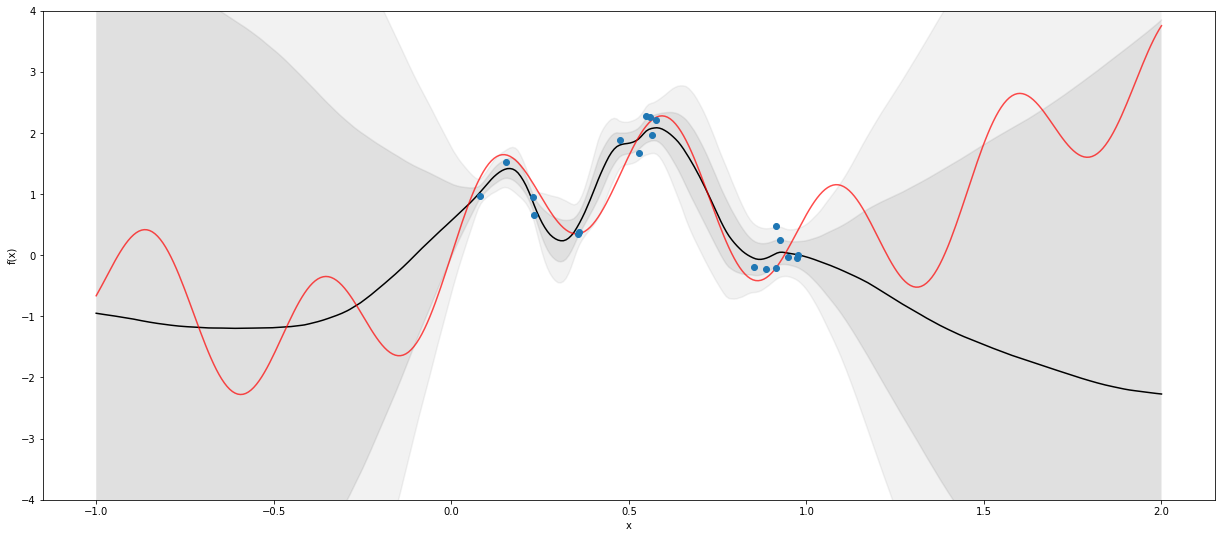

In [16]:
upper1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + np.std(predictions_ksgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_ksgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)
plt.xlabel('x')
plt.ylabel('f(x)')

### KSGFS

In [48]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs

eta = 1.
v = 0.
lambda_ = 1.
l2 = 1e-3

# learning_rates = [5e-2]
# learning_rates = [8e-3, 7e-3]
# learning_rates = [4e-2]
# learning_rates = [8e-3]
# learning_rates = [1e-3]
# learning_rates = [1e-3, 1e-4]
# learning_rates = [5e-3, 4e-3, 2e-3, 1e-3, 9e-4, 8e-4, 7e-4, 6e-4, 5e-4]
learning_rates = [3e-5]


batch_size = 20
dataset_size= 20

x_test = torch.FloatTensor(grid)
y_test = torch.FloatTensor(y_true)

rmse_result = np.zeros((1,len(learning_rates)))

for i,lr in enumerate(learning_rates):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    predictions_ksgfs = torch.zeros(400,1)
    t = 1.

    for epoch in range(10000):

        running_loss = 0

        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = (1./(2*0.0009))*criterion(output, y)
        loss.backward()
        optim.step()



        running_loss += loss * batch_size / dataset_size


        if (t >= 100) & (t % 100 == 0):
            with torch.autograd.no_grad():
                output = network(x_test)
                predictions_ksgfs = torch.cat((predictions_ksgfs, output), 1)

        t += 1.
        print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    rmse_result[:,i] = torch.sqrt(criterion(y_test, torch.mean(predictions_ksgfs,1).view(-1,1)))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 22371.6602
Epoch 1 - loss: 22039.8086
Epoch 2 - loss: 21767.0059
Epoch 3 - loss: 21395.8887
Epoch 4 - loss: 20946.0566
Epoch 5 - loss: 20547.5996
Epoch 6 - loss: 20356.6270
Epoch 7 - loss: 20105.1797
Epoch 8 - loss: 19819.2832
Epoch 9 - loss: 19411.7520
Epoch 10 - loss: 19116.9316
Epoch 11 - loss: 18900.9297
Epoch 12 - loss: 18508.9277
Epoch 13 - loss: 18173.9160
Epoch 14 - loss: 17972.0234
Epoch 15 - loss: 17847.7969
Epoch 16 - loss: 17575.2695
Epoch 17 - loss: 17419.7656
Epoch 18 - loss: 16662.4004
Epoch 19 - loss: 16471.4395
Epoch 20 - loss: 16156.0645
Epoch 21 - loss: 15934.5205
Epoch 22 - loss: 15739.1191
Epoch 23 - loss: 15523.8184
Epoch 24 - loss: 15237.0059
Epoch 25 - loss: 15109.2783
Epoch 26 - loss: 14935.7324
Epoch 27 - loss: 14681.6768
Epoch 28 - loss: 14526.1816
Epoch 29 - loss: 14354.4004
Epoch 30 - loss: 14232.6064
Epoch 31 - loss: 14052.0127
Epoch 32 - loss: 13928.7402
Epoch 33 - loss: 13617.3311
Epoch 34 - loss: 13422.2207
Epoch 35 - loss: 13271.3223
Ep

Epoch 302 - loss: 4339.9019
Epoch 303 - loss: 4317.5625
Epoch 304 - loss: 4311.2871
Epoch 305 - loss: 4305.0435
Epoch 306 - loss: 4290.2515
Epoch 307 - loss: 4281.6851
Epoch 308 - loss: 4274.8706
Epoch 309 - loss: 4265.4526
Epoch 310 - loss: 4252.2075
Epoch 311 - loss: 4234.4229
Epoch 312 - loss: 4227.6050
Epoch 313 - loss: 4210.1406
Epoch 314 - loss: 4195.5254
Epoch 315 - loss: 4177.2427
Epoch 316 - loss: 4153.0605
Epoch 317 - loss: 4141.8496
Epoch 318 - loss: 4130.1143
Epoch 319 - loss: 4124.5659
Epoch 320 - loss: 4113.2231
Epoch 321 - loss: 4099.3301
Epoch 322 - loss: 4084.7258
Epoch 323 - loss: 4074.2031
Epoch 324 - loss: 4058.5847
Epoch 325 - loss: 4053.6453
Epoch 326 - loss: 4040.5046
Epoch 327 - loss: 4037.7612
Epoch 328 - loss: 4023.8442
Epoch 329 - loss: 4012.2065
Epoch 330 - loss: 3995.6453
Epoch 331 - loss: 3987.8367
Epoch 332 - loss: 3974.2651
Epoch 333 - loss: 3959.8560
Epoch 334 - loss: 3954.3286
Epoch 335 - loss: 3948.6790
Epoch 336 - loss: 3938.9448
Epoch 337 - loss: 39

Epoch 605 - loss: 2221.9814
Epoch 606 - loss: 2218.8792
Epoch 607 - loss: 2210.9661
Epoch 608 - loss: 2204.1587
Epoch 609 - loss: 2202.9614
Epoch 610 - loss: 2198.5657
Epoch 611 - loss: 2197.7725
Epoch 612 - loss: 2196.6123
Epoch 613 - loss: 2192.5374
Epoch 614 - loss: 2188.1460
Epoch 615 - loss: 2185.2305
Epoch 616 - loss: 2182.0630
Epoch 617 - loss: 2179.8638
Epoch 618 - loss: 2175.5823
Epoch 619 - loss: 2172.4570
Epoch 620 - loss: 2171.6182
Epoch 621 - loss: 2166.8599
Epoch 622 - loss: 2160.9360
Epoch 623 - loss: 2158.9675
Epoch 624 - loss: 2154.3694
Epoch 625 - loss: 2154.9446
Epoch 626 - loss: 2148.3735
Epoch 627 - loss: 2146.8818
Epoch 628 - loss: 2143.8342
Epoch 629 - loss: 2140.0664
Epoch 630 - loss: 2139.5000
Epoch 631 - loss: 2135.1323
Epoch 632 - loss: 2134.0237
Epoch 633 - loss: 2132.1169
Epoch 634 - loss: 2126.2344
Epoch 635 - loss: 2129.1130
Epoch 636 - loss: 2122.0649
Epoch 637 - loss: 2119.8931
Epoch 638 - loss: 2113.5029
Epoch 639 - loss: 2111.6252
Epoch 640 - loss: 21

Epoch 900 - loss: 1529.6053
Epoch 901 - loss: 1526.6450
Epoch 902 - loss: 1525.2765
Epoch 903 - loss: 1521.2383
Epoch 904 - loss: 1518.1549
Epoch 905 - loss: 1517.3739
Epoch 906 - loss: 1513.6467
Epoch 907 - loss: 1513.1906
Epoch 908 - loss: 1509.7917
Epoch 909 - loss: 1507.8627
Epoch 910 - loss: 1505.1632
Epoch 911 - loss: 1503.0659
Epoch 912 - loss: 1501.6047
Epoch 913 - loss: 1499.9536
Epoch 914 - loss: 1495.9520
Epoch 915 - loss: 1496.9348
Epoch 916 - loss: 1494.3298
Epoch 917 - loss: 1490.8506
Epoch 918 - loss: 1492.3706
Epoch 919 - loss: 1493.0109
Epoch 920 - loss: 1489.9587
Epoch 921 - loss: 1487.0374
Epoch 922 - loss: 1483.8446
Epoch 923 - loss: 1483.4102
Epoch 924 - loss: 1477.9584
Epoch 925 - loss: 1473.7343
Epoch 926 - loss: 1474.6093
Epoch 927 - loss: 1475.3547
Epoch 928 - loss: 1473.4203
Epoch 929 - loss: 1472.0129
Epoch 930 - loss: 1468.6257
Epoch 931 - loss: 1467.0986
Epoch 932 - loss: 1464.6367
Epoch 933 - loss: 1464.5472
Epoch 934 - loss: 1462.8306
Epoch 935 - loss: 14

Epoch 1189 - loss: 1003.9451
Epoch 1190 - loss: 1003.1660
Epoch 1191 - loss: 1000.4662
Epoch 1192 - loss: 998.7850
Epoch 1193 - loss: 998.2062
Epoch 1194 - loss: 999.7092
Epoch 1195 - loss: 998.3727
Epoch 1196 - loss: 995.5999
Epoch 1197 - loss: 994.9951
Epoch 1198 - loss: 993.8517
Epoch 1199 - loss: 992.0557
Epoch 1200 - loss: 990.2355
Epoch 1201 - loss: 988.5197
Epoch 1202 - loss: 987.5104
Epoch 1203 - loss: 986.8744
Epoch 1204 - loss: 985.3680
Epoch 1205 - loss: 984.5988
Epoch 1206 - loss: 982.9857
Epoch 1207 - loss: 981.7344
Epoch 1208 - loss: 979.6366
Epoch 1209 - loss: 978.2421
Epoch 1210 - loss: 977.7870
Epoch 1211 - loss: 978.7350
Epoch 1212 - loss: 977.5084
Epoch 1213 - loss: 975.5737
Epoch 1214 - loss: 974.3569
Epoch 1215 - loss: 973.3190
Epoch 1216 - loss: 971.1420
Epoch 1217 - loss: 968.7465
Epoch 1218 - loss: 967.1642
Epoch 1219 - loss: 965.7361
Epoch 1220 - loss: 963.2269
Epoch 1221 - loss: 961.8380
Epoch 1222 - loss: 962.3594
Epoch 1223 - loss: 959.8051
Epoch 1224 - loss

Epoch 1482 - loss: 728.4883
Epoch 1483 - loss: 729.5775
Epoch 1484 - loss: 728.1608
Epoch 1485 - loss: 728.1086
Epoch 1486 - loss: 727.6233
Epoch 1487 - loss: 725.8774
Epoch 1488 - loss: 724.6412
Epoch 1489 - loss: 722.8156
Epoch 1490 - loss: 719.6929
Epoch 1491 - loss: 716.9032
Epoch 1492 - loss: 717.4778
Epoch 1493 - loss: 716.3177
Epoch 1494 - loss: 716.1957
Epoch 1495 - loss: 716.0964
Epoch 1496 - loss: 715.9678
Epoch 1497 - loss: 714.3959
Epoch 1498 - loss: 714.7654
Epoch 1499 - loss: 713.5793
Epoch 1500 - loss: 713.2233
Epoch 1501 - loss: 714.4896
Epoch 1502 - loss: 714.8696
Epoch 1503 - loss: 716.2018
Epoch 1504 - loss: 714.9220
Epoch 1505 - loss: 717.2112
Epoch 1506 - loss: 716.2016
Epoch 1507 - loss: 714.5192
Epoch 1508 - loss: 712.9009
Epoch 1509 - loss: 713.1713
Epoch 1510 - loss: 712.2205
Epoch 1511 - loss: 711.7095
Epoch 1512 - loss: 709.6721
Epoch 1513 - loss: 709.2581
Epoch 1514 - loss: 709.2140
Epoch 1515 - loss: 708.7852
Epoch 1516 - loss: 708.1070
Epoch 1517 - loss: 7

Epoch 1779 - loss: 586.2411
Epoch 1780 - loss: 585.9672
Epoch 1781 - loss: 586.5405
Epoch 1782 - loss: 585.3958
Epoch 1783 - loss: 586.6245
Epoch 1784 - loss: 585.9873
Epoch 1785 - loss: 585.8987
Epoch 1786 - loss: 586.3044
Epoch 1787 - loss: 585.8619
Epoch 1788 - loss: 585.5397
Epoch 1789 - loss: 586.9559
Epoch 1790 - loss: 586.2411
Epoch 1791 - loss: 585.4047
Epoch 1792 - loss: 584.3177
Epoch 1793 - loss: 582.2603
Epoch 1794 - loss: 583.4067
Epoch 1795 - loss: 583.0941
Epoch 1796 - loss: 583.3090
Epoch 1797 - loss: 582.6452
Epoch 1798 - loss: 583.0756
Epoch 1799 - loss: 584.1718
Epoch 1800 - loss: 583.5260
Epoch 1801 - loss: 583.0775
Epoch 1802 - loss: 584.0303
Epoch 1803 - loss: 581.5726
Epoch 1804 - loss: 581.5181
Epoch 1805 - loss: 580.7965
Epoch 1806 - loss: 579.9640
Epoch 1807 - loss: 579.0303
Epoch 1808 - loss: 578.6707
Epoch 1809 - loss: 576.1598
Epoch 1810 - loss: 576.2394
Epoch 1811 - loss: 576.8596
Epoch 1812 - loss: 576.9224
Epoch 1813 - loss: 575.9951
Epoch 1814 - loss: 5

Epoch 2081 - loss: 526.8212
Epoch 2082 - loss: 528.1875
Epoch 2083 - loss: 527.0210
Epoch 2084 - loss: 528.2776
Epoch 2085 - loss: 528.3232
Epoch 2086 - loss: 526.7200
Epoch 2087 - loss: 526.3926
Epoch 2088 - loss: 526.1774
Epoch 2089 - loss: 525.7487
Epoch 2090 - loss: 526.2183
Epoch 2091 - loss: 525.1007
Epoch 2092 - loss: 524.2070
Epoch 2093 - loss: 524.1530
Epoch 2094 - loss: 524.5900
Epoch 2095 - loss: 525.3302
Epoch 2096 - loss: 525.1783
Epoch 2097 - loss: 523.9073
Epoch 2098 - loss: 523.4935
Epoch 2099 - loss: 523.2387
Epoch 2100 - loss: 522.2573
Epoch 2101 - loss: 521.0811
Epoch 2102 - loss: 521.5607
Epoch 2103 - loss: 521.7333
Epoch 2104 - loss: 521.8793
Epoch 2105 - loss: 521.2262
Epoch 2106 - loss: 521.1859
Epoch 2107 - loss: 520.8614
Epoch 2108 - loss: 521.2363
Epoch 2109 - loss: 523.0708
Epoch 2110 - loss: 522.7521
Epoch 2111 - loss: 522.5782
Epoch 2112 - loss: 521.7455
Epoch 2113 - loss: 522.8748
Epoch 2114 - loss: 522.4635
Epoch 2115 - loss: 521.6846
Epoch 2116 - loss: 5

Epoch 2384 - loss: 489.6855
Epoch 2385 - loss: 489.4562
Epoch 2386 - loss: 489.6247
Epoch 2387 - loss: 489.6337
Epoch 2388 - loss: 489.5005
Epoch 2389 - loss: 489.2227
Epoch 2390 - loss: 488.1218
Epoch 2391 - loss: 488.1350
Epoch 2392 - loss: 488.9202
Epoch 2393 - loss: 488.8289
Epoch 2394 - loss: 489.9064
Epoch 2395 - loss: 489.9623
Epoch 2396 - loss: 490.9879
Epoch 2397 - loss: 489.5898
Epoch 2398 - loss: 489.3282
Epoch 2399 - loss: 488.6034
Epoch 2400 - loss: 488.3364
Epoch 2401 - loss: 488.7896
Epoch 2402 - loss: 488.1509
Epoch 2403 - loss: 489.0634
Epoch 2404 - loss: 488.9715
Epoch 2405 - loss: 488.3293
Epoch 2406 - loss: 488.0431
Epoch 2407 - loss: 488.5455
Epoch 2408 - loss: 489.1941
Epoch 2409 - loss: 489.0144
Epoch 2410 - loss: 489.5097
Epoch 2411 - loss: 489.4975
Epoch 2412 - loss: 488.6995
Epoch 2413 - loss: 488.8200
Epoch 2414 - loss: 488.3040
Epoch 2415 - loss: 488.3963
Epoch 2416 - loss: 487.2602
Epoch 2417 - loss: 487.9327
Epoch 2418 - loss: 488.2474
Epoch 2419 - loss: 4

Epoch 2694 - loss: 472.6415
Epoch 2695 - loss: 471.8419
Epoch 2696 - loss: 470.1184
Epoch 2697 - loss: 470.8009
Epoch 2698 - loss: 470.5150
Epoch 2699 - loss: 470.4745
Epoch 2700 - loss: 469.3637
Epoch 2701 - loss: 469.8281
Epoch 2702 - loss: 470.6169
Epoch 2703 - loss: 470.5377
Epoch 2704 - loss: 470.6913
Epoch 2705 - loss: 470.4254
Epoch 2706 - loss: 470.8697
Epoch 2707 - loss: 470.5047
Epoch 2708 - loss: 470.4632
Epoch 2709 - loss: 471.2336
Epoch 2710 - loss: 470.6821
Epoch 2711 - loss: 471.2549
Epoch 2712 - loss: 469.5677
Epoch 2713 - loss: 470.9847
Epoch 2714 - loss: 471.0786
Epoch 2715 - loss: 470.9455
Epoch 2716 - loss: 470.9087
Epoch 2717 - loss: 470.0790
Epoch 2718 - loss: 471.5279
Epoch 2719 - loss: 470.7821
Epoch 2720 - loss: 470.5619
Epoch 2721 - loss: 469.3416
Epoch 2722 - loss: 470.4291
Epoch 2723 - loss: 471.7034
Epoch 2724 - loss: 469.8215
Epoch 2725 - loss: 470.4762
Epoch 2726 - loss: 470.7633
Epoch 2727 - loss: 470.1996
Epoch 2728 - loss: 470.0093
Epoch 2729 - loss: 4

Epoch 3003 - loss: 457.9428
Epoch 3004 - loss: 456.7147
Epoch 3005 - loss: 455.3741
Epoch 3006 - loss: 455.0390
Epoch 3007 - loss: 454.8550
Epoch 3008 - loss: 455.0473
Epoch 3009 - loss: 453.8849
Epoch 3010 - loss: 452.8109
Epoch 3011 - loss: 452.2695
Epoch 3012 - loss: 451.9417
Epoch 3013 - loss: 452.4630
Epoch 3014 - loss: 453.1474
Epoch 3015 - loss: 454.5379
Epoch 3016 - loss: 452.8221
Epoch 3017 - loss: 452.3155
Epoch 3018 - loss: 453.1303
Epoch 3019 - loss: 453.0226
Epoch 3020 - loss: 452.6696
Epoch 3021 - loss: 452.6121
Epoch 3022 - loss: 452.2475
Epoch 3023 - loss: 451.9169
Epoch 3024 - loss: 452.5602
Epoch 3025 - loss: 453.1900
Epoch 3026 - loss: 452.2209
Epoch 3027 - loss: 452.8591
Epoch 3028 - loss: 453.3195
Epoch 3029 - loss: 452.7525
Epoch 3030 - loss: 452.4268
Epoch 3031 - loss: 452.2247
Epoch 3032 - loss: 453.4268
Epoch 3033 - loss: 453.1394
Epoch 3034 - loss: 453.2485
Epoch 3035 - loss: 453.9378
Epoch 3036 - loss: 453.0405
Epoch 3037 - loss: 453.4295
Epoch 3038 - loss: 4

Epoch 3298 - loss: 442.4579
Epoch 3299 - loss: 442.7518
Epoch 3300 - loss: 441.5880
Epoch 3301 - loss: 443.2945
Epoch 3302 - loss: 440.5562
Epoch 3303 - loss: 441.4278
Epoch 3304 - loss: 442.0399
Epoch 3305 - loss: 441.6274
Epoch 3306 - loss: 440.7827
Epoch 3307 - loss: 439.3893
Epoch 3308 - loss: 438.8250
Epoch 3309 - loss: 439.2904
Epoch 3310 - loss: 439.2455
Epoch 3311 - loss: 438.9657
Epoch 3312 - loss: 439.1215
Epoch 3313 - loss: 438.9521
Epoch 3314 - loss: 439.5247
Epoch 3315 - loss: 439.1566
Epoch 3316 - loss: 439.5352
Epoch 3317 - loss: 439.7179
Epoch 3318 - loss: 441.5590
Epoch 3319 - loss: 439.9439
Epoch 3320 - loss: 439.8895
Epoch 3321 - loss: 440.0132
Epoch 3322 - loss: 439.9604
Epoch 3323 - loss: 438.8637
Epoch 3324 - loss: 439.1886
Epoch 3325 - loss: 439.4223
Epoch 3326 - loss: 439.5436
Epoch 3327 - loss: 439.3769
Epoch 3328 - loss: 439.7354
Epoch 3329 - loss: 440.0221
Epoch 3330 - loss: 439.2729
Epoch 3331 - loss: 440.1945
Epoch 3332 - loss: 440.3022
Epoch 3333 - loss: 4

Epoch 3598 - loss: 424.7674
Epoch 3599 - loss: 424.8028
Epoch 3600 - loss: 424.8163
Epoch 3601 - loss: 424.4982
Epoch 3602 - loss: 424.8326
Epoch 3603 - loss: 424.5854
Epoch 3604 - loss: 425.0972
Epoch 3605 - loss: 426.3237
Epoch 3606 - loss: 425.2369
Epoch 3607 - loss: 424.8096
Epoch 3608 - loss: 424.1119
Epoch 3609 - loss: 424.0956
Epoch 3610 - loss: 424.3318
Epoch 3611 - loss: 424.6097
Epoch 3612 - loss: 424.8844
Epoch 3613 - loss: 424.2654
Epoch 3614 - loss: 424.2592
Epoch 3615 - loss: 423.9848
Epoch 3616 - loss: 424.3619
Epoch 3617 - loss: 425.2773
Epoch 3618 - loss: 424.5557
Epoch 3619 - loss: 426.1112
Epoch 3620 - loss: 426.8456
Epoch 3621 - loss: 424.0808
Epoch 3622 - loss: 424.3856
Epoch 3623 - loss: 423.3572
Epoch 3624 - loss: 424.7131
Epoch 3625 - loss: 423.0531
Epoch 3626 - loss: 422.4264
Epoch 3627 - loss: 422.6915
Epoch 3628 - loss: 423.0394
Epoch 3629 - loss: 422.0352
Epoch 3630 - loss: 422.6987
Epoch 3631 - loss: 421.8702
Epoch 3632 - loss: 422.5107
Epoch 3633 - loss: 4

Epoch 3905 - loss: 407.0222
Epoch 3906 - loss: 406.1602
Epoch 3907 - loss: 405.6554
Epoch 3908 - loss: 406.2638
Epoch 3909 - loss: 406.5931
Epoch 3910 - loss: 406.9455
Epoch 3911 - loss: 407.7361
Epoch 3912 - loss: 407.0039
Epoch 3913 - loss: 406.9894
Epoch 3914 - loss: 406.8546
Epoch 3915 - loss: 407.2209
Epoch 3916 - loss: 406.9189
Epoch 3917 - loss: 406.1436
Epoch 3918 - loss: 406.4055
Epoch 3919 - loss: 406.3885
Epoch 3920 - loss: 407.2248
Epoch 3921 - loss: 406.9323
Epoch 3922 - loss: 406.4353
Epoch 3923 - loss: 407.0970
Epoch 3924 - loss: 407.4054
Epoch 3925 - loss: 407.3509
Epoch 3926 - loss: 406.4493
Epoch 3927 - loss: 406.5475
Epoch 3928 - loss: 406.7383
Epoch 3929 - loss: 407.5815
Epoch 3930 - loss: 406.8571
Epoch 3931 - loss: 406.4403
Epoch 3932 - loss: 406.8550
Epoch 3933 - loss: 406.5815
Epoch 3934 - loss: 407.1040
Epoch 3935 - loss: 406.5110
Epoch 3936 - loss: 406.0955
Epoch 3937 - loss: 406.3693
Epoch 3938 - loss: 407.1252
Epoch 3939 - loss: 406.9990
Epoch 3940 - loss: 4

Epoch 4202 - loss: 398.7725
Epoch 4203 - loss: 397.3738
Epoch 4204 - loss: 398.7426
Epoch 4205 - loss: 398.0703
Epoch 4206 - loss: 397.8112
Epoch 4207 - loss: 399.3223
Epoch 4208 - loss: 401.1022
Epoch 4209 - loss: 401.1303
Epoch 4210 - loss: 398.4059
Epoch 4211 - loss: 399.2527
Epoch 4212 - loss: 399.5733
Epoch 4213 - loss: 398.5845
Epoch 4214 - loss: 397.9498
Epoch 4215 - loss: 397.6680
Epoch 4216 - loss: 399.1006
Epoch 4217 - loss: 398.1900
Epoch 4218 - loss: 397.1836
Epoch 4219 - loss: 397.1698
Epoch 4220 - loss: 397.7412
Epoch 4221 - loss: 397.7438
Epoch 4222 - loss: 396.2821
Epoch 4223 - loss: 397.4054
Epoch 4224 - loss: 396.8238
Epoch 4225 - loss: 396.5514
Epoch 4226 - loss: 396.4079
Epoch 4227 - loss: 395.8457
Epoch 4228 - loss: 395.8997
Epoch 4229 - loss: 395.8877
Epoch 4230 - loss: 395.6160
Epoch 4231 - loss: 395.7498
Epoch 4232 - loss: 394.9557
Epoch 4233 - loss: 394.7972
Epoch 4234 - loss: 394.8100
Epoch 4235 - loss: 395.0365
Epoch 4236 - loss: 394.6784
Epoch 4237 - loss: 3

Epoch 4509 - loss: 381.8067
Epoch 4510 - loss: 380.9057
Epoch 4511 - loss: 380.9983
Epoch 4512 - loss: 380.3791
Epoch 4513 - loss: 380.7136
Epoch 4514 - loss: 379.9734
Epoch 4515 - loss: 380.2888
Epoch 4516 - loss: 379.7115
Epoch 4517 - loss: 380.1722
Epoch 4518 - loss: 381.1342
Epoch 4519 - loss: 381.6081
Epoch 4520 - loss: 381.2341
Epoch 4521 - loss: 380.3621
Epoch 4522 - loss: 382.0027
Epoch 4523 - loss: 381.8489
Epoch 4524 - loss: 382.1400
Epoch 4525 - loss: 381.4577
Epoch 4526 - loss: 380.0284
Epoch 4527 - loss: 379.8454
Epoch 4528 - loss: 380.1296
Epoch 4529 - loss: 379.9139
Epoch 4530 - loss: 381.5739
Epoch 4531 - loss: 379.3318
Epoch 4532 - loss: 379.6650
Epoch 4533 - loss: 378.9281
Epoch 4534 - loss: 378.7907
Epoch 4535 - loss: 377.8627
Epoch 4536 - loss: 379.2388
Epoch 4537 - loss: 379.1823
Epoch 4538 - loss: 378.3781
Epoch 4539 - loss: 378.1876
Epoch 4540 - loss: 378.0305
Epoch 4541 - loss: 377.6081
Epoch 4542 - loss: 377.2986
Epoch 4543 - loss: 377.4027
Epoch 4544 - loss: 3

Epoch 4818 - loss: 365.8972
Epoch 4819 - loss: 366.1158
Epoch 4820 - loss: 365.8047
Epoch 4821 - loss: 364.0623
Epoch 4822 - loss: 364.0949
Epoch 4823 - loss: 365.4659
Epoch 4824 - loss: 366.1270
Epoch 4825 - loss: 366.5314
Epoch 4826 - loss: 367.6877
Epoch 4827 - loss: 366.0912
Epoch 4828 - loss: 365.8996
Epoch 4829 - loss: 365.3271
Epoch 4830 - loss: 364.2048
Epoch 4831 - loss: 363.9299
Epoch 4832 - loss: 363.9585
Epoch 4833 - loss: 364.6500
Epoch 4834 - loss: 363.2485
Epoch 4835 - loss: 363.6057
Epoch 4836 - loss: 362.8301
Epoch 4837 - loss: 362.2674
Epoch 4838 - loss: 362.7780
Epoch 4839 - loss: 362.2600
Epoch 4840 - loss: 362.5699
Epoch 4841 - loss: 362.3592
Epoch 4842 - loss: 361.5671
Epoch 4843 - loss: 362.0044
Epoch 4844 - loss: 361.1336
Epoch 4845 - loss: 362.0029
Epoch 4846 - loss: 360.8863
Epoch 4847 - loss: 362.1371
Epoch 4848 - loss: 361.4682
Epoch 4849 - loss: 362.8667
Epoch 4850 - loss: 361.5228
Epoch 4851 - loss: 361.4832
Epoch 4852 - loss: 361.2777
Epoch 4853 - loss: 3

Epoch 5127 - loss: 350.2791
Epoch 5128 - loss: 349.5578
Epoch 5129 - loss: 349.5132
Epoch 5130 - loss: 350.8774
Epoch 5131 - loss: 349.0414
Epoch 5132 - loss: 348.4261
Epoch 5133 - loss: 348.2650
Epoch 5134 - loss: 348.7203
Epoch 5135 - loss: 348.2096
Epoch 5136 - loss: 348.2265
Epoch 5137 - loss: 348.6513
Epoch 5138 - loss: 349.0771
Epoch 5139 - loss: 348.8203
Epoch 5140 - loss: 348.8925
Epoch 5141 - loss: 349.0222
Epoch 5142 - loss: 348.6257
Epoch 5143 - loss: 348.9263
Epoch 5144 - loss: 349.2554
Epoch 5145 - loss: 347.4113
Epoch 5146 - loss: 347.5235
Epoch 5147 - loss: 348.0795
Epoch 5148 - loss: 348.4657
Epoch 5149 - loss: 347.7454
Epoch 5150 - loss: 349.0186
Epoch 5151 - loss: 348.8097
Epoch 5152 - loss: 348.3177
Epoch 5153 - loss: 348.1262
Epoch 5154 - loss: 347.5576
Epoch 5155 - loss: 348.7476
Epoch 5156 - loss: 348.4323
Epoch 5157 - loss: 348.9775
Epoch 5158 - loss: 348.5110
Epoch 5159 - loss: 348.4375
Epoch 5160 - loss: 349.2519
Epoch 5161 - loss: 348.4756
Epoch 5162 - loss: 3

Epoch 5437 - loss: 337.8395
Epoch 5438 - loss: 339.1086
Epoch 5439 - loss: 338.4921
Epoch 5440 - loss: 338.2221
Epoch 5441 - loss: 338.4489
Epoch 5442 - loss: 337.6825
Epoch 5443 - loss: 337.6718
Epoch 5444 - loss: 337.3782
Epoch 5445 - loss: 338.2847
Epoch 5446 - loss: 337.6951
Epoch 5447 - loss: 337.5576
Epoch 5448 - loss: 337.8957
Epoch 5449 - loss: 338.1069
Epoch 5450 - loss: 337.7994
Epoch 5451 - loss: 337.3491
Epoch 5452 - loss: 336.8073
Epoch 5453 - loss: 336.3821
Epoch 5454 - loss: 337.0257
Epoch 5455 - loss: 336.1381
Epoch 5456 - loss: 336.1405
Epoch 5457 - loss: 336.1412
Epoch 5458 - loss: 336.3533
Epoch 5459 - loss: 336.7312
Epoch 5460 - loss: 336.5197
Epoch 5461 - loss: 338.2128
Epoch 5462 - loss: 337.5929
Epoch 5463 - loss: 337.4577
Epoch 5464 - loss: 338.2120
Epoch 5465 - loss: 336.8178
Epoch 5466 - loss: 337.3282
Epoch 5467 - loss: 337.1826
Epoch 5468 - loss: 336.8329
Epoch 5469 - loss: 336.1435
Epoch 5470 - loss: 335.9184
Epoch 5471 - loss: 336.2302
Epoch 5472 - loss: 3

Epoch 5745 - loss: 325.0215
Epoch 5746 - loss: 325.7001
Epoch 5747 - loss: 325.1397
Epoch 5748 - loss: 325.1404
Epoch 5749 - loss: 325.5253
Epoch 5750 - loss: 325.6942
Epoch 5751 - loss: 325.4588
Epoch 5752 - loss: 324.2350
Epoch 5753 - loss: 324.9648
Epoch 5754 - loss: 326.1041
Epoch 5755 - loss: 325.4899
Epoch 5756 - loss: 325.5980
Epoch 5757 - loss: 324.5557
Epoch 5758 - loss: 325.3077
Epoch 5759 - loss: 324.6012
Epoch 5760 - loss: 324.0447
Epoch 5761 - loss: 323.6957
Epoch 5762 - loss: 324.0216
Epoch 5763 - loss: 324.1493
Epoch 5764 - loss: 325.1126
Epoch 5765 - loss: 326.2198
Epoch 5766 - loss: 326.6465
Epoch 5767 - loss: 325.3181
Epoch 5768 - loss: 325.2587
Epoch 5769 - loss: 324.2104
Epoch 5770 - loss: 324.3661
Epoch 5771 - loss: 323.7331
Epoch 5772 - loss: 323.9398
Epoch 5773 - loss: 323.6753
Epoch 5774 - loss: 323.9339
Epoch 5775 - loss: 324.3302
Epoch 5776 - loss: 323.8677
Epoch 5777 - loss: 323.6859
Epoch 5778 - loss: 325.8814
Epoch 5779 - loss: 324.5050
Epoch 5780 - loss: 3

Epoch 6038 - loss: 318.9935
Epoch 6039 - loss: 318.1521
Epoch 6040 - loss: 319.0742
Epoch 6041 - loss: 318.9127
Epoch 6042 - loss: 318.6192
Epoch 6043 - loss: 317.0977
Epoch 6044 - loss: 317.1653
Epoch 6045 - loss: 317.4095
Epoch 6046 - loss: 317.9366
Epoch 6047 - loss: 318.4327
Epoch 6048 - loss: 318.4997
Epoch 6049 - loss: 317.6635
Epoch 6050 - loss: 317.1868
Epoch 6051 - loss: 317.2393
Epoch 6052 - loss: 317.1944
Epoch 6053 - loss: 318.3601
Epoch 6054 - loss: 317.9741
Epoch 6055 - loss: 317.6161
Epoch 6056 - loss: 317.3679
Epoch 6057 - loss: 317.6714
Epoch 6058 - loss: 317.4920
Epoch 6059 - loss: 316.9984
Epoch 6060 - loss: 317.1643
Epoch 6061 - loss: 318.2039
Epoch 6062 - loss: 317.5665
Epoch 6063 - loss: 317.6886
Epoch 6064 - loss: 318.0335
Epoch 6065 - loss: 318.3032
Epoch 6066 - loss: 319.4100
Epoch 6067 - loss: 320.7276
Epoch 6068 - loss: 321.6877
Epoch 6069 - loss: 321.7335
Epoch 6070 - loss: 320.7202
Epoch 6071 - loss: 320.0353
Epoch 6072 - loss: 319.1197
Epoch 6073 - loss: 3

Epoch 6344 - loss: 310.8570
Epoch 6345 - loss: 310.2494
Epoch 6346 - loss: 311.2814
Epoch 6347 - loss: 310.2750
Epoch 6348 - loss: 311.0035
Epoch 6349 - loss: 311.3756
Epoch 6350 - loss: 311.6212
Epoch 6351 - loss: 311.2533
Epoch 6352 - loss: 310.9872
Epoch 6353 - loss: 311.0380
Epoch 6354 - loss: 310.4479
Epoch 6355 - loss: 309.8766
Epoch 6356 - loss: 310.3705
Epoch 6357 - loss: 309.7067
Epoch 6358 - loss: 309.3918
Epoch 6359 - loss: 310.0261
Epoch 6360 - loss: 309.6671
Epoch 6361 - loss: 309.8721
Epoch 6362 - loss: 308.8624
Epoch 6363 - loss: 308.9960
Epoch 6364 - loss: 309.0897
Epoch 6365 - loss: 309.3778
Epoch 6366 - loss: 309.2419
Epoch 6367 - loss: 310.5474
Epoch 6368 - loss: 310.4661
Epoch 6369 - loss: 311.3347
Epoch 6370 - loss: 310.2491
Epoch 6371 - loss: 309.3989
Epoch 6372 - loss: 309.8803
Epoch 6373 - loss: 308.9616
Epoch 6374 - loss: 308.7568
Epoch 6375 - loss: 308.9666
Epoch 6376 - loss: 309.3891
Epoch 6377 - loss: 308.9282
Epoch 6378 - loss: 309.1571
Epoch 6379 - loss: 3

Epoch 6653 - loss: 304.4619
Epoch 6654 - loss: 303.8626
Epoch 6655 - loss: 304.0617
Epoch 6656 - loss: 303.5215
Epoch 6657 - loss: 304.1253
Epoch 6658 - loss: 303.4074
Epoch 6659 - loss: 303.3257
Epoch 6660 - loss: 304.3038
Epoch 6661 - loss: 304.5181
Epoch 6662 - loss: 304.2753
Epoch 6663 - loss: 304.0519
Epoch 6664 - loss: 304.7502
Epoch 6665 - loss: 303.8688
Epoch 6666 - loss: 303.1260
Epoch 6667 - loss: 302.9829
Epoch 6668 - loss: 303.6662
Epoch 6669 - loss: 303.8589
Epoch 6670 - loss: 303.4424
Epoch 6671 - loss: 303.3548
Epoch 6672 - loss: 304.0400
Epoch 6673 - loss: 303.7030
Epoch 6674 - loss: 303.7843
Epoch 6675 - loss: 304.4977
Epoch 6676 - loss: 304.3030
Epoch 6677 - loss: 304.9544
Epoch 6678 - loss: 303.9120
Epoch 6679 - loss: 304.8017
Epoch 6680 - loss: 304.6375
Epoch 6681 - loss: 306.7142
Epoch 6682 - loss: 306.9882
Epoch 6683 - loss: 307.3320
Epoch 6684 - loss: 307.6109
Epoch 6685 - loss: 306.5255
Epoch 6686 - loss: 307.0508
Epoch 6687 - loss: 307.0209
Epoch 6688 - loss: 3

Epoch 6963 - loss: 305.2415
Epoch 6964 - loss: 304.7036
Epoch 6965 - loss: 303.7432
Epoch 6966 - loss: 302.4684
Epoch 6967 - loss: 302.1260
Epoch 6968 - loss: 301.9234
Epoch 6969 - loss: 301.2672
Epoch 6970 - loss: 302.4037
Epoch 6971 - loss: 301.4207
Epoch 6972 - loss: 302.0674
Epoch 6973 - loss: 301.6018
Epoch 6974 - loss: 301.9094
Epoch 6975 - loss: 300.8790
Epoch 6976 - loss: 301.0448
Epoch 6977 - loss: 300.0767
Epoch 6978 - loss: 299.8612
Epoch 6979 - loss: 301.4271
Epoch 6980 - loss: 299.6571
Epoch 6981 - loss: 299.5349
Epoch 6982 - loss: 299.1833
Epoch 6983 - loss: 299.3363
Epoch 6984 - loss: 299.1049
Epoch 6985 - loss: 298.7522
Epoch 6986 - loss: 298.4677
Epoch 6987 - loss: 297.9844
Epoch 6988 - loss: 298.0148
Epoch 6989 - loss: 299.3018
Epoch 6990 - loss: 299.2480
Epoch 6991 - loss: 299.5111
Epoch 6992 - loss: 298.8156
Epoch 6993 - loss: 298.6611
Epoch 6994 - loss: 298.7074
Epoch 6995 - loss: 298.1856
Epoch 6996 - loss: 298.5445
Epoch 6997 - loss: 298.7635
Epoch 6998 - loss: 2

Epoch 7268 - loss: 294.2083
Epoch 7269 - loss: 294.4963
Epoch 7270 - loss: 297.3515
Epoch 7271 - loss: 298.6045
Epoch 7272 - loss: 298.5122
Epoch 7273 - loss: 297.9233
Epoch 7274 - loss: 299.2223
Epoch 7275 - loss: 298.5888
Epoch 7276 - loss: 297.7140
Epoch 7277 - loss: 296.8172
Epoch 7278 - loss: 297.5967
Epoch 7279 - loss: 297.5840
Epoch 7280 - loss: 298.3556
Epoch 7281 - loss: 297.2488
Epoch 7282 - loss: 297.2319
Epoch 7283 - loss: 297.5594
Epoch 7284 - loss: 298.1620
Epoch 7285 - loss: 296.8753
Epoch 7286 - loss: 296.9099
Epoch 7287 - loss: 297.6524
Epoch 7288 - loss: 297.7466
Epoch 7289 - loss: 297.5576
Epoch 7290 - loss: 297.6903
Epoch 7291 - loss: 297.5803
Epoch 7292 - loss: 297.6762
Epoch 7293 - loss: 296.7097
Epoch 7294 - loss: 296.1064
Epoch 7295 - loss: 297.0052
Epoch 7296 - loss: 297.3935
Epoch 7297 - loss: 298.6340
Epoch 7298 - loss: 298.6663
Epoch 7299 - loss: 298.7259
Epoch 7300 - loss: 299.6612
Epoch 7301 - loss: 299.2724
Epoch 7302 - loss: 298.2529
Epoch 7303 - loss: 2

Epoch 7575 - loss: 290.4831
Epoch 7576 - loss: 291.4949
Epoch 7577 - loss: 291.6477
Epoch 7578 - loss: 291.0675
Epoch 7579 - loss: 291.0786
Epoch 7580 - loss: 291.2930
Epoch 7581 - loss: 291.9348
Epoch 7582 - loss: 291.3140
Epoch 7583 - loss: 291.0253
Epoch 7584 - loss: 291.0901
Epoch 7585 - loss: 291.2073
Epoch 7586 - loss: 291.4391
Epoch 7587 - loss: 291.0160
Epoch 7588 - loss: 290.3126
Epoch 7589 - loss: 290.1029
Epoch 7590 - loss: 290.0056
Epoch 7591 - loss: 289.6748
Epoch 7592 - loss: 291.7047
Epoch 7593 - loss: 291.8112
Epoch 7594 - loss: 292.4153
Epoch 7595 - loss: 291.1147
Epoch 7596 - loss: 292.4053
Epoch 7597 - loss: 293.2813
Epoch 7598 - loss: 293.8059
Epoch 7599 - loss: 293.9026
Epoch 7600 - loss: 293.4899
Epoch 7601 - loss: 291.8151
Epoch 7602 - loss: 291.1209
Epoch 7603 - loss: 291.4219
Epoch 7604 - loss: 290.9092
Epoch 7605 - loss: 290.6975
Epoch 7606 - loss: 290.2526
Epoch 7607 - loss: 289.8783
Epoch 7608 - loss: 290.1003
Epoch 7609 - loss: 290.6208
Epoch 7610 - loss: 2

Epoch 7875 - loss: 285.9931
Epoch 7876 - loss: 286.2866
Epoch 7877 - loss: 287.1534
Epoch 7878 - loss: 286.9200
Epoch 7879 - loss: 286.8000
Epoch 7880 - loss: 287.6881
Epoch 7881 - loss: 288.3400
Epoch 7882 - loss: 287.5582
Epoch 7883 - loss: 287.1507
Epoch 7884 - loss: 286.4033
Epoch 7885 - loss: 287.3727
Epoch 7886 - loss: 286.9799
Epoch 7887 - loss: 288.0060
Epoch 7888 - loss: 287.9887
Epoch 7889 - loss: 287.4723
Epoch 7890 - loss: 287.0113
Epoch 7891 - loss: 287.3450
Epoch 7892 - loss: 287.5111
Epoch 7893 - loss: 286.7451
Epoch 7894 - loss: 286.9765
Epoch 7895 - loss: 285.8666
Epoch 7896 - loss: 285.4083
Epoch 7897 - loss: 284.9122
Epoch 7898 - loss: 285.7132
Epoch 7899 - loss: 285.8524
Epoch 7900 - loss: 285.7088
Epoch 7901 - loss: 286.5352
Epoch 7902 - loss: 286.1452
Epoch 7903 - loss: 286.5034
Epoch 7904 - loss: 287.0309
Epoch 7905 - loss: 288.7594
Epoch 7906 - loss: 287.7932
Epoch 7907 - loss: 288.1771
Epoch 7908 - loss: 286.0278
Epoch 7909 - loss: 286.3713
Epoch 7910 - loss: 2

Epoch 8180 - loss: 284.7788
Epoch 8181 - loss: 285.1020
Epoch 8182 - loss: 285.9701
Epoch 8183 - loss: 284.2766
Epoch 8184 - loss: 284.2039
Epoch 8185 - loss: 284.7364
Epoch 8186 - loss: 284.4369
Epoch 8187 - loss: 283.8278
Epoch 8188 - loss: 284.4204
Epoch 8189 - loss: 283.9346
Epoch 8190 - loss: 284.9246
Epoch 8191 - loss: 284.8379
Epoch 8192 - loss: 285.6285
Epoch 8193 - loss: 285.9244
Epoch 8194 - loss: 285.3121
Epoch 8195 - loss: 285.2926
Epoch 8196 - loss: 286.0729
Epoch 8197 - loss: 284.4846
Epoch 8198 - loss: 283.7312
Epoch 8199 - loss: 283.6385
Epoch 8200 - loss: 283.2483
Epoch 8201 - loss: 284.5701
Epoch 8202 - loss: 284.0760
Epoch 8203 - loss: 283.8781
Epoch 8204 - loss: 283.8682
Epoch 8205 - loss: 283.8830
Epoch 8206 - loss: 284.2929
Epoch 8207 - loss: 283.7290
Epoch 8208 - loss: 283.8793
Epoch 8209 - loss: 283.9023
Epoch 8210 - loss: 284.1439
Epoch 8211 - loss: 283.9053
Epoch 8212 - loss: 283.5717
Epoch 8213 - loss: 283.7525
Epoch 8214 - loss: 283.3462
Epoch 8215 - loss: 2

Epoch 8474 - loss: 280.4333
Epoch 8475 - loss: 280.0933
Epoch 8476 - loss: 279.6188
Epoch 8477 - loss: 279.7611
Epoch 8478 - loss: 280.3814
Epoch 8479 - loss: 280.6882
Epoch 8480 - loss: 281.2485
Epoch 8481 - loss: 281.3690
Epoch 8482 - loss: 280.9835
Epoch 8483 - loss: 280.2870
Epoch 8484 - loss: 280.2698
Epoch 8485 - loss: 278.9844
Epoch 8486 - loss: 278.9494
Epoch 8487 - loss: 279.5642
Epoch 8488 - loss: 279.6921
Epoch 8489 - loss: 279.8709
Epoch 8490 - loss: 280.0636
Epoch 8491 - loss: 279.7575
Epoch 8492 - loss: 280.5695
Epoch 8493 - loss: 280.9828
Epoch 8494 - loss: 281.4204
Epoch 8495 - loss: 281.5439
Epoch 8496 - loss: 280.8178
Epoch 8497 - loss: 280.2776
Epoch 8498 - loss: 280.2167
Epoch 8499 - loss: 280.5391
Epoch 8500 - loss: 281.0989
Epoch 8501 - loss: 280.9845
Epoch 8502 - loss: 280.2032
Epoch 8503 - loss: 280.1735
Epoch 8504 - loss: 280.4499
Epoch 8505 - loss: 281.1420
Epoch 8506 - loss: 280.8965
Epoch 8507 - loss: 280.7171
Epoch 8508 - loss: 280.4941
Epoch 8509 - loss: 2

Epoch 8775 - loss: 277.0142
Epoch 8776 - loss: 277.2531
Epoch 8777 - loss: 276.9268
Epoch 8778 - loss: 276.5621
Epoch 8779 - loss: 277.5001
Epoch 8780 - loss: 277.9210
Epoch 8781 - loss: 278.6781
Epoch 8782 - loss: 277.9151
Epoch 8783 - loss: 277.7032
Epoch 8784 - loss: 277.8715
Epoch 8785 - loss: 278.5004
Epoch 8786 - loss: 278.5054
Epoch 8787 - loss: 278.5478
Epoch 8788 - loss: 278.3528
Epoch 8789 - loss: 278.2998
Epoch 8790 - loss: 279.5158
Epoch 8791 - loss: 279.9783
Epoch 8792 - loss: 279.5504
Epoch 8793 - loss: 278.7314
Epoch 8794 - loss: 279.2484
Epoch 8795 - loss: 278.1381
Epoch 8796 - loss: 278.0863
Epoch 8797 - loss: 277.7827
Epoch 8798 - loss: 278.0877
Epoch 8799 - loss: 278.5043
Epoch 8800 - loss: 277.9798
Epoch 8801 - loss: 277.7319
Epoch 8802 - loss: 277.6564
Epoch 8803 - loss: 277.0946
Epoch 8804 - loss: 276.9210
Epoch 8805 - loss: 277.7157
Epoch 8806 - loss: 276.7578
Epoch 8807 - loss: 277.3041
Epoch 8808 - loss: 276.9379
Epoch 8809 - loss: 276.3035
Epoch 8810 - loss: 2

Epoch 9077 - loss: 275.3324
Epoch 9078 - loss: 275.6628
Epoch 9079 - loss: 277.4258
Epoch 9080 - loss: 276.4579
Epoch 9081 - loss: 275.6091
Epoch 9082 - loss: 275.1656
Epoch 9083 - loss: 276.1729
Epoch 9084 - loss: 276.4756
Epoch 9085 - loss: 275.7074
Epoch 9086 - loss: 275.4995
Epoch 9087 - loss: 275.2629
Epoch 9088 - loss: 274.6054
Epoch 9089 - loss: 275.8366
Epoch 9090 - loss: 275.8476
Epoch 9091 - loss: 276.7450
Epoch 9092 - loss: 276.7189
Epoch 9093 - loss: 276.2864
Epoch 9094 - loss: 277.1782
Epoch 9095 - loss: 277.5695
Epoch 9096 - loss: 278.2466
Epoch 9097 - loss: 277.4785
Epoch 9098 - loss: 277.0946
Epoch 9099 - loss: 277.4483
Epoch 9100 - loss: 276.1468
Epoch 9101 - loss: 276.0143
Epoch 9102 - loss: 275.7361
Epoch 9103 - loss: 274.4742
Epoch 9104 - loss: 274.1923
Epoch 9105 - loss: 274.3824
Epoch 9106 - loss: 273.7236
Epoch 9107 - loss: 272.7908
Epoch 9108 - loss: 274.0632
Epoch 9109 - loss: 273.5032
Epoch 9110 - loss: 273.3939
Epoch 9111 - loss: 273.2461
Epoch 9112 - loss: 2

Epoch 9383 - loss: 274.0014
Epoch 9384 - loss: 273.9474
Epoch 9385 - loss: 273.7893
Epoch 9386 - loss: 274.0004
Epoch 9387 - loss: 274.1840
Epoch 9388 - loss: 274.1140
Epoch 9389 - loss: 274.3401
Epoch 9390 - loss: 275.5802
Epoch 9391 - loss: 276.2863
Epoch 9392 - loss: 275.4083
Epoch 9393 - loss: 276.0008
Epoch 9394 - loss: 275.3086
Epoch 9395 - loss: 274.3877
Epoch 9396 - loss: 275.2454
Epoch 9397 - loss: 274.5760
Epoch 9398 - loss: 274.5068
Epoch 9399 - loss: 275.2742
Epoch 9400 - loss: 275.1837
Epoch 9401 - loss: 275.2634
Epoch 9402 - loss: 275.4690
Epoch 9403 - loss: 275.4318
Epoch 9404 - loss: 275.7555
Epoch 9405 - loss: 275.4591
Epoch 9406 - loss: 274.6317
Epoch 9407 - loss: 275.2297
Epoch 9408 - loss: 274.8016
Epoch 9409 - loss: 275.4572
Epoch 9410 - loss: 275.8437
Epoch 9411 - loss: 274.6690
Epoch 9412 - loss: 276.0114
Epoch 9413 - loss: 276.5997
Epoch 9414 - loss: 276.9091
Epoch 9415 - loss: 274.8087
Epoch 9416 - loss: 275.0216
Epoch 9417 - loss: 274.0029
Epoch 9418 - loss: 2

Epoch 9692 - loss: 274.9832
Epoch 9693 - loss: 274.4390
Epoch 9694 - loss: 274.8120
Epoch 9695 - loss: 275.9637
Epoch 9696 - loss: 274.6174
Epoch 9697 - loss: 275.0969
Epoch 9698 - loss: 274.5401
Epoch 9699 - loss: 273.9771
Epoch 9700 - loss: 276.0103
Epoch 9701 - loss: 275.2007
Epoch 9702 - loss: 275.4272
Epoch 9703 - loss: 275.7682
Epoch 9704 - loss: 274.4881
Epoch 9705 - loss: 274.4139
Epoch 9706 - loss: 274.3676
Epoch 9707 - loss: 273.4467
Epoch 9708 - loss: 273.6518
Epoch 9709 - loss: 273.4350
Epoch 9710 - loss: 272.8133
Epoch 9711 - loss: 272.6015
Epoch 9712 - loss: 272.2954
Epoch 9713 - loss: 273.4042
Epoch 9714 - loss: 274.0401
Epoch 9715 - loss: 274.4425
Epoch 9716 - loss: 273.2839
Epoch 9717 - loss: 274.7391
Epoch 9718 - loss: 273.4158
Epoch 9719 - loss: 272.2534
Epoch 9720 - loss: 272.7837
Epoch 9721 - loss: 271.9945
Epoch 9722 - loss: 271.8569
Epoch 9723 - loss: 272.8168
Epoch 9724 - loss: 273.5653
Epoch 9725 - loss: 273.5675
Epoch 9726 - loss: 273.6444
Epoch 9727 - loss: 2

Epoch 9998 - loss: 273.1049
Epoch 9999 - loss: 273.7629


Text(0,0.5,'f(x)')

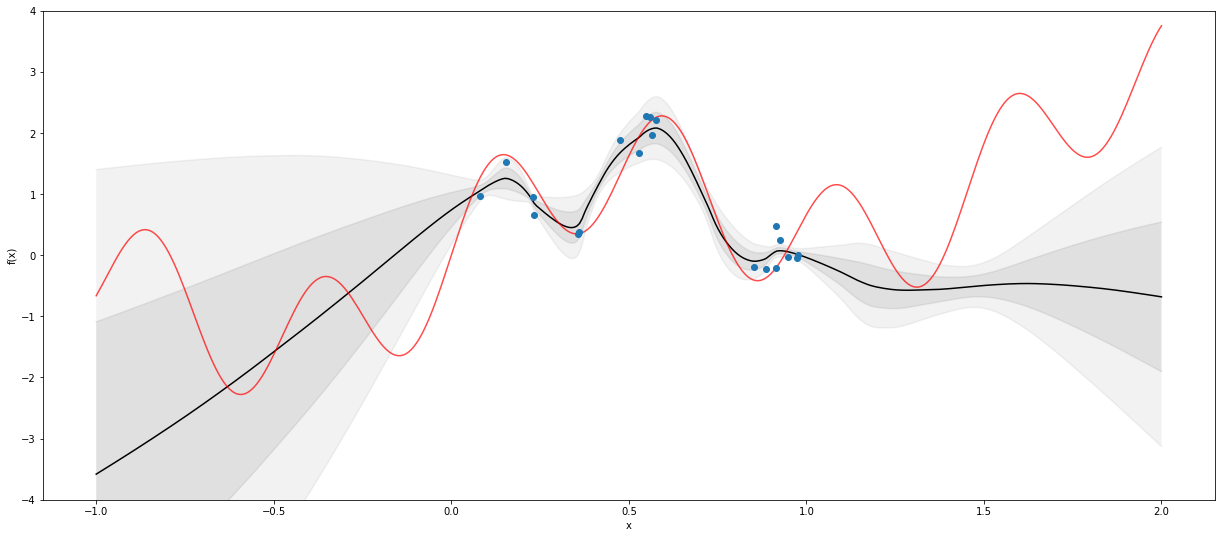

In [49]:
upper1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_ksgfs[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)
plt.xlabel('x')
plt.ylabel('f(x)')